In [1]:
import os
os.getpid()

853

In [3]:
from IPython.display import Image

import matplotlib_options
matplotlib_options.define_matplotlib_backend_options(backend='agg')

%matplotlib inline
# Use autoreload to keep up-to-date version of custom packages
# %load_ext autoreload
import mwTools
import cterminal
# %autoreload 2

import matplotlib.pyplot as plt
from cterminal import colorBackground1, get_line_width, vmax, cmap, colorHeatmapLine
from matplotlib.font_manager import FontProperties
from matplotlib.patches import Rectangle
from matplotlib import gridspec
from matplotlib import colors
import seaborn as sns
sns.set_style('whitegrid')

import numpy as np
from numpy import exp, log2, log10, log
import pandas as pd
idx = pd.IndexSlice
import collections
from collections import Counter
import json
import argparse
import subprocess
import shlex
import itertools
import os.path
import io
import re
import gzip
import urllib
import gc
import time
from pathlib import Path
import random
import math

import Bio
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqFeature import SeqFeature, FeatureLocation, ExactPosition
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO

from importlib import reload
import mwTools.bio
reload(mwTools.bio)
from mwTools.bio import sort_codon_index
from mwTools.bio import convert_df_to_fasta
from statannot import add_stat_annotation
from mwTools.id import *
from mwTools.paths import p
from cterminal import *
from matplotlib_options import set_fontsize_paper, set_fontsize_screen

p = p()
print(p.rootPath)

/users/lserrano/mweber


In [4]:
rootPath = p.rootPath
cterminalPath = p.cterminalPath
refSeqPath = p.refSeqPath
mycoplasmaDataPath = p.mycoplasmaDataPath
mpnAnnotationPath = p.mpnAnnotationPath
analysisCtermDataPath = p.analysisCtermDataPath
analysisCtermPlotsPath = p.analysisCtermPlotsPath
analysisCtermPath = p.analysisCtermPath
ctermELISAPath = p.ctermELISAPath
ctermELMseqPath = p.ctermELMseqPath
ctermAmiGOPath = analysisCtermPath / 'AmiGO'
analysisAbundancePath = p.analysisAbundancePath
taxonomyPath = p.taxonomyPath

In [5]:
importExistingDataframe = True

# ATGC

In [14]:
codonTableBio = Bio.Data.CodonTable.unambiguous_dna_by_name['Standard']
refCodonTableDf = build_refCodonTable(codonTableBio)
refCodonTableDf['aa'].head()

codon
CGT    R
CGC    R
CGA    R
CGG    R
AGA    R
Name: aa, dtype: object

In [15]:
evolPath = analysisCtermPath / 'Evolutionary_analysis'

In [16]:
ATGCPath = p.databasesPath / 'ATGC' / 'dmk-brain.ecn.uiowa.edu' / 'ATGC' / 'data'
print(ATGCPath)

/users/lserrano/mweber/Databases/ATGC/dmk-brain.ecn.uiowa.edu/ATGC/data


## downloading database

```sh
wget --ftp-user anonymous --ftp-password marc.weber@crg.eu -r ftp://dmk-brain.ecn.uiowa.edu/ATGC/data/ATGC153
```

2019.12.19

download finished yesterday, in principles the full database is in path `/users/lserrano/mweber/Databases/ATGC/dmk-brain.ecn.uiowa.edu/ATGC`.

## import data

In [17]:
tripletsDf = pd.read_excel(evolPath / 'Rogozin2016_triplets_table.xlsx')\
             .rename(columns={'ATGC#':'ATGC_id', 'Species name (1,2,o)':'species'})
tripletsDf.columns
tripletsDf.head()

,ATGC_id,species,D_1o,D_2o,D_12,#Coding nucleotides,Dn_1o,Dn_2o,Dn_12,#Non-coding nucleotides
0,ATGC001,Salmonella enterica arizonae serovar,0.296,0.291,0.179,2774067.0,0.309,0.307,0.100,150361.0
1,NaN,Salmonella enterica serovar Choleraesuis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Salmonella bongori NCTC 12419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ATGC003,Streptococcus pneumoniae INV200,0.218,0.208,0.157,1211700.0,0.131,0.128,0.103,250393.0
4,NaN,Streptococcus pseudopneumoniae IS7493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
ATGCGenomeDf = pd.read_csv(ATGCPath / 'rawdatafiles' / 'atgcgenomelist.csv', sep='\t', header=None, index_col=0,
                           names=['ATGC_id', 'genomes'])
ATGCGenomeDf = ATGCGenomeDf['genomes'].str.split(',', expand=True).stack()
ATGCGenomeDf.index = ATGCGenomeDf.index.droplevel(1)
ATGCGenomeDf.tail(10)

ATGC_id
ATGC428       Cyclobacterium_marinum_DSM_745.GCF_000222485.1
ATGC429                    Cycloclasticus_P1.GCF_000299965.1
ATGC429         Cycloclasticus_zancles_78_ME.GCF_000442595.1
ATGC430         Erysipelothrix_rhusiopathiae.GCF_001602155.1
ATGC430    Erysipelothrix_rhusiopathiae_Fujisawa.GCF_0002...
ATGC430    Erysipelothrix_rhusiopathiae_SY1027.GCF_000404...
ATGC431    Thioalkalimicrobium_aerophilum_AL3.GCF_0002276...
ATGC431    Thioalkalimicrobium_cyclicum_ALM1.GCF_000214825.1
ATGC432       Candidatus_Profftella_armatura.GCF_000441555.1
ATGC432       Candidatus_Profftella_armatura.GCF_001278785.1
dtype: object

In [19]:
ATGCDataDf = pd.read_csv(ATGCPath / 'rawdatafiles' / 'atgcdata.csv')
ATGCDataDf.head()

,ATGC#,genomes,numgenomes,superkingdom,phylum,order,commontaxa,COGorgs,mediandnmin,mediandnmax,...,mediandndsmax,genomesizemin,genomesizemax,genomesizeavg,numgenesmin,numgenesmax,numgenesavg,gcmin,gcmax,gcavg
0,ATGC001,Salmonella/Escherichia/Enterobacter/Shigella/C...,432,[2] {superkingdom} Bacteria,[1224] {phylum} Proteobacteria,[91347] {order} Enterobacteriales,[543] {family} Enterobacteriaceae,Citkos;Crotur;Entclo;Escc01;Esccol;Salent,0.0,0.1,...,2.8,4.0,5.9,4.9,3713.0,5833.0,4595.0,49.7,57.8,51.9
1,ATGC002,Klebsiella/Enterobacter,73,[2] {superkingdom} Bacteria,[1224] {phylum} Proteobacteria,[91347] {order} Enterobacteriales,[543] {family} Enterobacteriaceae,Klepne,0.0,0.0,...,1.3,5.1,7.2,5.7,4621.0,6631.0,5376.0,54.7,58.0,56.8
2,ATGC003,Streptococcus pneumoniae/mitis/pseudopneumonia...,37,[2] {superkingdom} Bacteria,[1239] {phylum} Firmicutes,[186826] {order} Lactobacillales,[1301] {genus} Streptococcus,Strpne,0.0,0.0,...,1.1,1.9,2.3,2.1,1785.0,2258.0,2060.0,39.5,41.1,39.8
3,ATGC004,Streptococcus pyogenes/dysgalactiae,53,[2] {superkingdom} Bacteria,[1239] {phylum} Firmicutes,[186826] {order} Lactobacillales,[1301] {genus} Streptococcus,Strpyo,0.0,0.0,...,1.7,1.7,2.2,1.9,1527.0,1965.0,1711.0,38.2,39.6,38.6
4,ATGC005,Streptococcus suis,22,[2] {superkingdom} Bacteria,[1239] {phylum} Firmicutes,[186826] {order} Lactobacillales,[1307] {species} Streptococcus suis,NaN,0.0,0.0,...,0.6,2.0,2.3,2.1,1833.0,2163.0,1961.0,41.0,41.4,41.2


In [20]:
dS = pd.read_csv(ATGCPath / 'rawdatafiles' / 'dsdata.txt', nrows=None, sep='\t', header=None,
                 names=['species_1', 'species_2', 'dS'])
dS.head()

,species_1,species_2,dS
0,Sulfolobus_islandicus_HVE10_4.GCF_000189575.1,Sulfolobus_islandicus_LAL14_1.GCF_000364745.1,0.0
1,Sulfolobus_islandicus_HVE10_4.GCF_000189575.1,Sulfolobus_islandicus_L_S_2_15.GCF_000022385.1,0.0
2,Sulfolobus_islandicus_HVE10_4.GCF_000189575.1,Sulfolobus_islandicus_M_14_25.GCF_000022405.1,0.0
3,Sulfolobus_islandicus_HVE10_4.GCF_000189575.1,Sulfolobus_islandicus_M_16_2.GCF_000245095.1,0.0
4,Sulfolobus_islandicus_HVE10_4.GCF_000189575.1,Sulfolobus_islandicus_M_16_23.GCF_000245175.1,0.0


In [21]:
dS2 = dS.set_index(['species_1', 'species_2'])
dS2.head()

dS
species_1                                     species_2                                          
Sulfolobus_islandicus_HVE10_4.GCF_000189575.1 Sulfolobus_islandicus_LAL14_1.GCF_000364745.1   0.0
                                              Sulfolobus_islandicus_L_S_2_15.GCF_000022385.1  0.0
                                              Sulfolobus_islandicus_M_14_25.GCF_000022405.1   0.0
                                              Sulfolobus_islandicus_M_16_2.GCF_000245095.1    0.0
                                              Sulfolobus_islandicus_M_16_23.GCF_000245175.1   0.0

## example of ATGC-COG

In [ ]:
eggGenomeOGDf = eggGenomeDf4[eggGenomeDf4['bestOG'] == OG_id]
print(len(eggGenomeOGDf))

In [1630]:
len(set(proteinList))

236

In [1631]:
len(set(eggGenomeOGDf.index))

214

In [1632]:
len(set(proteinList) & set(eggGenomeOGDf.index))

0

In [1634]:
eggOrganismList = eggGenomeOGDf['organism_name'].unique()
len(eggOrganismList)

198

In [1635]:
eggOrganismList

array(['Deinococcus radiodurans R1', 'Chlorobium tepidum TLS',
       'Bacteroides thetaiotaomicron VPI-5482', 'Bacteroides ovatus',
       'Parvimonas micra',
       'Riemerella anatipestifer ATCC 11845 = DSM 15868',
       'Bacteroides vulgatus ATCC 8482', 'Prevotella dentalis DSM 3688',
       'Parabacteroides distasonis ATCC 8503', 'Myroides odoratimimus',
       'Parachlamydia acanthamoebae UV-7',
       'Gordonia polyisoprenivorans VH2', 'Bacteroides cellulosilyticus',
       'Paraglaciecola psychrophila 170', 'Niabella soli DSM 19437',
       'Bacteroides thetaiotaomicron',
       'Fusobacterium nucleatum subsp. vincentii 3_1_36A2',
       'Synechocystis sp. PCC 6803', 'Synechococcus elongatus PCC 6301',
       'Chlorobium chlorochromatii CaD3', 'Desulfovibrio alaskensis G20',
       'Deinococcus geothermalis DSM 11300',
       'Pseudoalteromonas atlantica T6c',
       'Cytophaga hutchinsonii ATCC 33406', 'Gramella forsetii KT0803',
       'Chlorobium phaeobacteroides DSM 266',


We identify one protein that appears in the ATGC cluster database.

In [1636]:
eggGenomeOGDf[eggGenomeOGDf['organism_name'] == 'Desulfovibrio vulgaris str. Hildenborough']

,genome_accession,bestOG,seed_eggNOG_ortholog,taxid,organism_name,species_name,species_taxid,DNASeq,stopCodon,DNA3UTRSeq,codonTableBio,proteinSeq
refSeqProteinId,,,,,,,,,,,,
YP_010477.1,GCF_000195755.1,07QTX,882.DVU1258,882,Desulfovibrio vulgaris str. Hildenborough,Desulfovibrio vulgaris,881.0,ATGAGTGGAATCCAGGCACGCCTCAACGCCATCTCGGCTGTCACCA...,TAA,CGCGGATAGAATCGACAGATACAGAACGGG,11.0,MSGIQARLNAISAVTNYKPSTAPMNFSETKLTEFFGCNVFNEKVMR...


ATGC153.COG0521

there are in a ATGC cluster of only 3 genomes, so only 3 orthologous proteins aligned. Not much to say, protein sequence is very conserved, no change at c-terminal.

```
>CogId|ATGC153.COG0521|taxonId|391774|assemblyId|Desulfovibrio_vulgaris_DP4.GCF_000015485.1|>Desulfovibrio_vulgaris_DP4.GCF_000015485.1:1:2111697..2113877 DVUL_RS09290 WP_010938554.1 GI:499241014 glutamine synthetase [Desulfovibrio vulgaris DP4]
MSGIQARLNAISAVTNYKPSTAPMNFSETKLTEFFGCNVFNEKVMRERLP
KDVFKSLQKTIELGEKLDPSIADIVANTMKDWAIEKGATHFTHVFYPLTG
LTAEKHDSFLTPDGKGGALAEFSGKMLIQGEPDASSFPSGGLRSTFEARG
YTAWDVTSPAYILENPNGTFLCIPTAFLSWTGEALDKKTPLLRSMQALNT
QAKRVLKLFGIETKLPVIAFAGPEQEYFLIDRNFAFSRPDLLIAGRSLFG
ARPPKGQEFEDQYFGVIPRRVLAFMMEVERELYKLGVPVKTRHNEVAPSQ
YEIAPIYETGNLATDHNQIIMTTLRSVAKRYGMLCLLHEKPFAGINGSGK
HLNYSIGNAELGSLFDPGDTPHENAKFLVFCAAAIRALHKFGPMLRATVA
SASNDHRLGANEAPPAIMSMYLGEQLTDVFEQFKQGKVNGCKQKCVMNVG
VDTLPPLPRDPGDRNRTSPFAFTGNRFEFRAVGSSMSIAGSQVALNTMMA
DSLDYIASELEKAIGGDASKLNEAVQSLLQKIMVEHEAIIFNGDGYSEAW
HKEAERRGLPNLRTTPDALPMLTKPEVIELFTKYGVFSEAELRSREEIYL
EQYCKTVKTEANLVIRMARTIIFPAAMRYQGELATTCANLKAAGHDYQMV
TLEDVTAKLRSMQKAANELEKLLDHEAASVLEEARHMCDAILPAMNDVRK
WADSLETIVADDLWSLPSYQEMLFIK
>CogId|ATGC153.COG0521|taxonId|882|assemblyId|Desulfovibrio_vulgaris_Hildenborough.GCF_000195755.1|>Desulfovibrio_vulgaris_Hildenborough.GCF_000195755.1:1:complement(1343777..1345957) DVU1258 YP_010477.1 GI:46579669; GeneID:2794604 glutamine synthetase [Desulfovibrio vulgaris str. Hildenborough]
MSGIQARLNAISAVTNYKPSTAPMNFSETKLTEFFGCNVFNEKVMRERLP
KDVFKSLQKTIELGEKLDPSIADIVANTMKDWAIEKGATHFTHVFYPLTG
LTAEKHDSFLTPDGKGGALAEFSGKMLIQGEPDASSFPSGGLRSTFEARG
YTAWDVTSPAYILENPNGTFLCIPTAFLSWTGEALDKKTPLLRSMQALNT
QAKRVLKLFGIETKLPVIAFAGPEQEYFLIDRNFAFSRPDLLIAGRSLFG
ARPPKGQEFEDQYFGVIPRRVLAFMMEVERELYKLGVPVKTRHNEVAPSQ
YEIAPIYETGNLATDHNQIIMTTLRSVAKRYGMLCLLHEKPFAGINGSGK
HLNYSIGNAELGSLFDPGDTPHENAKFLVFCAAAIRALHKFGPMLRATVA
SASNDHRLGANEAPPAIMSMYLGEQLTDVFEQFKQGKVNGCKQKCVMNVG
VDTLPPLPRDPGDRNRTSPFAFTGNRFEFRAVGSSMSIAGSQVALNTMMA
DSLDYIASELEKAIGGDASKLNEAVQSLLQKIMVEHEAIIFNGDGYSEAW
HKEAERRGLPNLRTTPDALPMLTKPEVIELFTKYGVFSEAELRSREEIYL
EQYCKTVKTEANLVIRMARTIIFPAAMRYQGELATTCANLKAAGHDYQMV
TLEDVTAKLRSMQKAANELEKLLDHEAASVLEEARHMCDAILPAMNDVRK
WADSLETIVADDLWSLPSYQEMLFIK
>CogId|ATGC153.COG0521|taxonId|573059|assemblyId|Desulfovibrio_vulgaris_RCH1.GCF_000166115.1|>Desulfovibrio_vulgaris_RCH1.GCF_000166115.1:1:complement(1347295..1349475) DEVAL_RS05855 WP_010938554.1 GI:499241014 glutamine synthetase [Desulfovibrio vulgaris RCH1]
MSGIQARLNAISAVTNYKPSTAPMNFSETKLTEFFGCNVFNEKVMRERLP
KDVFKSLQKTIELGEKLDPSIADIVANTMKDWAIEKGATHFTHVFYPLTG
LTAEKHDSFLTPDGKGGALAEFSGKMLIQGEPDASSFPSGGLRSTFEARG
YTAWDVTSPAYILENPNGTFLCIPTAFLSWTGEALDKKTPLLRSMQALNT
QAKRVLKLFGIETKLPVIAFAGPEQEYFLIDRNFAFSRPDLLIAGRSLFG
ARPPKGQEFEDQYFGVIPRRVLAFMMEVERELYKLGVPVKTRHNEVAPSQ
YEIAPIYETGNLATDHNQIIMTTLRSVAKRYGMLCLLHEKPFAGINGSGK
HLNYSIGNAELGSLFDPGDTPHENAKFLVFCAAAIRALHKFGPMLRATVA
SASNDHRLGANEAPPAIMSMYLGEQLTDVFEQFKQGKVNGCKQKCVMNVG
VDTLPPLPRDPGDRNRTSPFAFTGNRFEFRAVGSSMSIAGSQVALNTMMA
DSLDYIASELEKAIGGDASKLNEAVQSLLQKIMVEHEAIIFNGDGYSEAW
HKEAERRGLPNLRTTPDALPMLTKPEVIELFTKYGVFSEAELRSREEIYL
EQYCKTVKTEANLVIRMARTIIFPAAMRYQGELATTCANLKAAGHDYQMV
TLEDVTAKLRSMQKAANELEKLLDHEAASVLEEARHMCDAILPAMNDVRK
WADSLETIVADDLWSLPSYQEMLFIK
```

## species triplets

@Rogozin2016: Evolutionary switches between two serine codon sets are driven by selection | PNAS
https://www.pnas.org/content/113/46/13109.full#T1

first step, choose triplets of species for the analysis. Could use the same 37 triplets as in @Rogozin2016.

@Rogozin2016:

> Genomic data for bacteria and archaea were obtained from an updated version of the ATGC. The ATGCs consist of bacterial and archaeal genomes with a high level of conserved gene synteny and a synonymous substitution rate (dS) <1.5 (40, 41). To reconstruct mutations in protein-coding and noncoding DNA, we used triplets of closely related species (Fig. 1) (29). The triplets of species were extracted from the ATGC database as follows. We aimed for a pair of species with dS in the range of 0.25–1.0, preferentially choosing those as close to 0.25 as possible, to balance the requirements for a sufficient number of substitutions for reliable analysis and for the lack of mutational saturation. Then, the third species was chosen such that the distance from each member of the initially selected pair of species was at least 1.2 (preferably 1.5) times greater than the distance within the pair, so that it would represent an unambiguous outgroup. The dS values were maximum-likelihood estimates calculated using the CODML program of the PAML4.8 package (42). The dN/dS value (the measure of protein-level selection) was estimated using the Pamilo-Bianchi-Li method (43).

The list of species triplets is available as a supp. table S1, I will parse it semi-manually.

In [164]:
df_list = []
cluster = None
for i in tripletsDf[~tripletsDf['ATGC_id'].isnull()].index:
    row = tripletsDf.loc[i].copy()
    row = row.rename({'species':'species_1'})
    row['species_2'] = tripletsDf.loc[i+1, 'species']
    row['species_o'] = tripletsDf.loc[i+2, 'species']
    df_list.append(row)
    
tripletsDf = pd.DataFrame(df_list)
print(len(tripletsDf))
tripletsDf

37


,ATGC_id,species_1,D_1o,D_2o,D_12,#Coding nucleotides,Dn_1o,Dn_2o,Dn_12,#Non-coding nucleotides,species_2,species_o
0,ATGC001,Salmonella enterica arizonae serovar,0.296,0.291,0.179,2774067.0,0.309,0.307,0.100,150361.0,Salmonella enterica serovar Choleraesuis,Salmonella bongori NCTC 12419
3,ATGC003,Streptococcus pneumoniae INV200,0.218,0.208,0.157,1211700.0,0.131,0.128,0.103,250393.0,Streptococcus pseudopneumoniae IS7493,Streptococcus mitis B6
6,ATGC008,Streptococcus salivarius CCHSS3,0.289,0.287,0.104,1152951.0,0.224,0.220,0.064,48658.0,Streptococcus salivarius JIM8777,Streptococcus thermophilus CNRZ1066
9,ATGC014,Bacillus cereus ATCC 10987,0.284,0.283,0.153,3335145.0,0.224,0.220,0.064,48658.0,Bacillus thuringiensis Al Hakam,Bacillus weihenstephanensis KBAB4
12,ATGC015,Bacillus JS,0.233,0.225,0.146,2917515.0,0.177,0.177,0.027,266416.0,Bacillus subtilis BSP1,Bacillus subtilis spizizenii W23
15,ATGC035,Mycoplasma capricolum ATCC 27343,0.186,0.149,0.111,639171.0,0.165,0.166,0.073,250670.0,Mycoplasma leachii PG50,Mycoplasma mycoides SC PG1
18,ATGC044,Rickettsia akari Hartford,0.365,0.356,0.206,722781.0,0.165,0.152,0.106,212492.0,Rickettsia massiliae MTU5,Rickettsia prowazekii Rp22
21,ATGC050,Helicobacter pylori 83,0.440,0.444,0.199,1122180.0,0.206,0.205,0.114,153629.0,Helicobacter pylori SouthAfrica7,Helicobacter cetorum MIT 99 5656
24,ATGC071,Pseudomonas putida H8234,0.272,0.260,0.178,4213602.0,0.124,0.111,0.084,223299.0,Pseudomonas putida NBRC 14164,Pseudomonas putida GB 1
27,ATGC088,Burkholderia thailandensis E264,0.119,0.114,0.103,4195449.0,0.109,0.103,0.061,47158.0,Burkholderia thailandensis MSMB121,Burkholderia pseudomallei K96243


In [166]:
triplet = tripletsDf.iloc[0]
triplet

ATGC_id                                                     ATGC001
species_1                      Salmonella enterica arizonae serovar
D_1o                                                          0.296
D_2o                                                          0.291
D_12                                                          0.179
#Coding nucleotides                                     2.77407e+06
Dn_1o                                                         0.309
Dn_2o                                                         0.307
Dn_12                                                           0.1
#Non-coding nucleotides                                      150361
species_2                  Salmonella enterica serovar Choleraesuis
species_o                             Salmonella bongori NCTC 12419
Name: 0, dtype: object

In the triplet list, we have some species names that match 2 species names in the full ATGC genomes list.

In [168]:
matchList = []
for i, triplet in tripletsDf.iterrows():
    for col in ['species_1', 'species_2', 'species_o']:
        match = ATGCGenomeDf[ATGCGenomeDf.str.contains(re.sub(' ', '_', triplet[col]), re.I)]
        print(match.values)
        nMatches = len(match)
        matchList.append({'ATGC_id':triplet['ATGC_id'], 'species':triplet[col], 'n_matched species':nMatches,
                          'species matched':match.values, 'position_in_triplet':col})
tripletSpecies = pd.DataFrame(matchList)

['Salmonella_enterica_arizonae_serovar_62_z36_str_RKS2983.GCF_000756465.1'
 'Salmonella_enterica_arizonae_serovar_62_z4_z23.GCF_000018625.1']
[]
['Salmonella_bongori_NCTC_12419.GCF_000252995.1']
['Streptococcus_pneumoniae_INV200.GCF_000210935.1']
['Streptococcus_pseudopneumoniae_IS7493.GCF_000221985.1']
['Streptococcus_mitis_B6.GCF_000027165.1']
['Streptococcus_salivarius_CCHSS3.GCF_000253335.1']
['Streptococcus_salivarius_JIM8777.GCF_000253315.1']
['Streptococcus_thermophilus_CNRZ1066.GCF_000011845.1']
['Bacillus_cereus_ATCC_10987.GCF_000008005.1']
['Bacillus_thuringiensis_Al_Hakam.GCF_000015065.1'
 'Bacillus_thuringiensis_Al_Hakam.GCF_000832885.1']
['Bacillus_weihenstephanensis_KBAB4.GCF_000018825.1']
['Bacillus_JS.GCF_000259365.1']
[]
[]
[]
['Mycoplasma_leachii_PG50.GCF_000183365.1']
[]
['Rickettsia_akari_Hartford.GCF_000018205.1']
['Rickettsia_massiliae_MTU5.GCF_000016625.1']
['Rickettsia_prowazekii_Rp22.GCF_000022785.1']
['Helicobacter_pylori_83.GCF_000213135.1']
['Helicobacter_py

The species name is the only information available in the Rogozin2016 table of species triplet. However, some of the species name are not found exactly with the same name in the species list of the new ATGC database. We will correct for some cases manually for the species name.

We should check that for the reconstructed species triplets, the dS distance and synteny are similar to the one described in the original triplets.

> Genomic data for bacteria and archaea were obtained from an updated version of the ATGC. The ATGCs consist of bacterial and archaeal genomes with a high level of conserved gene synteny and a synonymous substitution rate (dS) <1.5 (40, 41). To reconstruct mutations in protein-coding and noncoding DNA, we used triplets of closely related species (Fig. 1) (29). The triplets of species were extracted from the ATGC database as follows. We aimed for a pair of species with dS in the range of 0.25–1.0, preferentially choosing those as close to 0.25 as possible, to balance the requirements for a sufficient number of substitutions for reliable analysis and for the lack of mutational saturation. Then, the third species was chosen such that the distance from each member of the initially selected pair of species was at least 1.2 (preferably 1.5) times greater than the distance within the pair, so that it would represent an unambiguous outgroup. The dS values were maximum-likelihood estimates calculated using the CODML program of the PAML4.8 package (42). The dN/dS value (the measure of protein-level selection) was estimated using the Pamilo-Bianchi-Li method (43).

In [170]:
tripletSpecies[tripletSpecies['n_matched species'] == 0]

,ATGC_id,n_matched species,position_in_triplet,species,species matched
1,ATGC001,0,species_2,Salmonella enterica serovar Choleraesuis,[]
13,ATGC015,0,species_2,Bacillus subtilis BSP1,[]
14,ATGC015,0,species_o,Bacillus subtilis spizizenii W23,[]
15,ATGC035,0,species_1,Mycoplasma capricolum ATCC 27343,[]
17,ATGC035,0,species_o,Mycoplasma mycoides SC PG1,[]
36,ATGC100,0,species_1,Pectobacterium carotovorum PC1,[]
37,ATGC100,0,species_2,Pectobacterium carotovorum PCC21,[]
39,ATGC104,0,species_1,Bifidobacterium longum JCM 1217,[]
44,ATGC108,0,species_o,Listeria innocua Clip11262,[]
45,ATGC111,0,species_1,Aeromonas hydrophila ATCC 7966,[]


In [171]:
ATGCGenomeDf[ATGCGenomeDf.str.contains('Dehalococcoides', re.I)]

ATGC_id
ATGC210              Dehalococcoides_UCH007.GCF_001010485.1
ATGC210            Dehalococcoides_mccartyi.GCF_001610775.1
ATGC210        Dehalococcoides_mccartyi_195.GCF_000011905.1
ATGC210       Dehalococcoides_mccartyi_BAV1.GCF_000016705.1
ATGC210      Dehalococcoides_mccartyi_BTF08.GCF_000341695.1
ATGC210      Dehalococcoides_mccartyi_CBDB1.GCF_000009025.1
ATGC210        Dehalococcoides_mccartyi_CG1.GCF_000830925.1
ATGC210        Dehalococcoides_mccartyi_CG4.GCF_000830905.1
ATGC210        Dehalococcoides_mccartyi_CG5.GCF_000830885.1
ATGC210      Dehalococcoides_mccartyi_DCMB5.GCF_000341655.1
ATGC210         Dehalococcoides_mccartyi_GT.GCF_000025585.1
ATGC210       Dehalococcoides_mccartyi_GY50.GCF_000499365.1
ATGC210    Dehalococcoides_mccartyi_IBARAKI.GCF_001547795.1
ATGC210         Dehalococcoides_mccartyi_VS.GCF_000025025.1
dtype: object

In [172]:
tripletSpecies.loc[1, 'species']

'Salmonella enterica serovar Choleraesuis'

In [173]:
tripletSpecies.loc[1, 'species matched'] = [['Salmonella_enterica_enterica_serovar_Choleraesuis.GCF_000742815.1']]

In [174]:
tripletSpecies.loc[13, 'species']

'Bacillus subtilis BSP1'

In [175]:
tripletSpecies.loc[13, 'species matched'] = [['Bacillus_subtilis_subtilis_str_BSP1.GCF_000321395.1']]

In [176]:
tripletSpecies.loc[14, 'species']

'Bacillus subtilis spizizenii W23'

In [177]:
tripletSpecies.loc[14, 'species matched'] = [['Bacillus_subtilis_spizizenii_str_W23.GCF_000146565.1']]

In [178]:
tripletSpecies.loc[15, 'species']

'Mycoplasma capricolum ATCC 27343'

In [179]:
tripletSpecies.loc[15, 'species matched'] = [['Mycoplasma_capricolum_capricolum_ATCC_27343.GCF_000012765.1']]

In [180]:
tripletSpecies.loc[17, 'species']

'Mycoplasma mycoides SC PG1'

In [181]:
tripletSpecies.loc[17, 'species matched'] = [['Mycoplasma_mycoides_mycoides_SC_str_PG1.GCF_000011445.1']]

In [182]:
tripletSpecies.loc[36, 'species']

'Pectobacterium carotovorum PC1'

In [183]:
tripletSpecies.loc[36, 'species matched'] = [['Pectobacterium_carotovorum_carotovorum_PC1.GCF_000023605.1']]

In [184]:
tripletSpecies.loc[37, 'species']

'Pectobacterium carotovorum PCC21'

In [185]:
tripletSpecies.loc[37, 'species matched'] = [['Pectobacterium_carotovorum_carotovorum_PCC21.GCF_000294535.1']]

In [186]:
tripletSpecies.loc[39, 'species']

'Bifidobacterium longum JCM 1217'

In [187]:
tripletSpecies.loc[39, 'species matched'] = [['Bifidobacterium_longum_longum_JCM_1217.GCF_000196555.1']]

In [188]:
tripletSpecies.loc[44, 'species']
# this species is not present in the new ATGC database

'Listeria innocua Clip11262'

In [189]:
tripletSpecies.loc[45, 'species']

'Aeromonas hydrophila ATCC 7966'

In [190]:
tripletSpecies.loc[45, 'species matched'] = [['Aeromonas_hydrophila_hydrophila_ATCC_7966.GCF_000014805.1']]

In [191]:
tripletSpecies.loc[47, 'species']

'Aeromonas salmonicida A449'

In [192]:
tripletSpecies.loc[47, 'species matched'] = [['Aeromonas_salmonicida_salmonicida_A449.GCF_000196395.1']]

In [193]:
tripletSpecies.loc[48, 'species']
# there are 4 different species of Rhizobium_leguminosarum_trifolii in the new ATGC database...

'Rhizobium leguminosarum bv trifolii'

In [194]:
tripletSpecies.loc[49, 'species']

'Rhizobium leguminosarum bv viciae 3841'

In [195]:
tripletSpecies.loc[49, 'species matched'] = [['Rhizobium_leguminosarum_viciae_3841.GCF_000009265.1']]

In [196]:
tripletSpecies.loc[50, 'species']
# there are 4 different species of Rhizobium_leguminosarum_trifolii in the new ATGC database...

'Rhizobium leguminosarum bv trifolii'

In [197]:
tripletSpecies.loc[51, 'species']
# there is no such species, only a Sinorhizobium_fredii_NGR234.GCF_000018545.1 but it
# is probably in a different genome cluster

'Rhizobium NGR234'

In [198]:
ATGCGenomeDf[ATGCGenomeDf.str.contains('Rhizobium', re.I)]
ATGCGenomeDf[ATGCGenomeDf.str.contains('.*sinoRhizobium.*', re.I)]

Series([], dtype: object)

In [199]:
tripletSpecies.loc[52, 'species']
# not present in the new database

'Sinorhizobium fredii HH103'

In [200]:
tripletSpecies.loc[53, 'species']
# not present in the new database

'Sinorhizobium fredii USDA 257'

In [201]:
tripletSpecies.loc[54, 'species']

'Xanthomonas axonopodis citri 306'

In [202]:
tripletSpecies.loc[54, 'species matched'] = [['Xanthomonas_axonopodis_citri_str_306.GCF_000007165.1']]

In [203]:
tripletSpecies.loc[60, 'species']
# not present in the new database

'Neisseria gonorrhoeae TCDC NG08107'

In [204]:
tripletSpecies.loc[64, 'species']

'Francisella philomiragia ATCC 25017'

In [205]:
tripletSpecies.loc[64, 'species matched'] = [['Francisella_philomiragia_philomiragia_ATCC_25017.GCF_000019285.1']]

In [206]:
tripletSpecies.loc[66, 'species']
# not present in the new database

'Borrelia bissettii DN127'

In [207]:
tripletSpecies.loc[80, 'species']

'Thermoanaerobacter mathranii A3'

In [208]:
tripletSpecies.loc[80, 'species matched'] = [['Thermoanaerobacter_mathranii_mathranii_str_A3.GCF_000092965.1']]

In [209]:
tripletSpecies.loc[89, 'species']
# not present in the new database

'Ralstonia solanacearum CFBP2957'

In [210]:
tripletSpecies.loc[92, 'species']
# not present in the new database

'Cupriavidus taiwanensis LMG 19424'

In [211]:
tripletSpecies.loc[99, 'species']

'Dehalococcoides VS'

In [212]:
tripletSpecies.loc[99, 'species matched'] = [['Dehalococcoides_mccartyi_VS.GCF_000025025.1']]

In [213]:
tripletSpecies.loc[100, 'species']

'Dehalococcoides ethenogenes 195'

In [214]:
tripletSpecies.loc[100, 'species matched'] = [['Dehalococcoides_mccartyi_195.GCF_000011905.1']]

In [215]:
tripletSpecies.loc[101, 'species']

'Dehalococcoides GT'

In [216]:
tripletSpecies.loc[101, 'species matched'] = [['Dehalococcoides_mccartyi_GT.GCF_000025585.1']]

In [217]:
tripletSpecies.loc[105, 'species']

'Clavibacter michiganensis NCPPB 382'

In [218]:
tripletSpecies.loc[105, 'species matched'] = [['Clavibacter_michiganensis_michiganensis_NCPPB_382.GCF_000063485.1']]

In summary, we still have quite many species that are not present in the new version of the ATGC database...

In [219]:
tripletSpecies[tripletSpecies['species matched'].map(lambda x: len(x) == 0)]

,ATGC_id,n_matched species,position_in_triplet,species,species matched
44,ATGC108,0,species_o,Listeria innocua Clip11262,[]
48,ATGC123,0,species_1,Rhizobium leguminosarum bv trifolii,[]
50,ATGC123,0,species_o,Rhizobium leguminosarum bv trifolii,[]
51,ATGC125,0,species_1,Rhizobium NGR234,[]
52,ATGC125,0,species_2,Sinorhizobium fredii HH103,[]
53,ATGC125,0,species_o,Sinorhizobium fredii USDA 257,[]
60,ATGC137,0,species_1,Neisseria gonorrhoeae TCDC NG08107,[]
66,ATGC144,0,species_1,Borrelia bissettii DN127,[]
89,ATGC188,0,species_o,Ralstonia solanacearum CFBP2957,[]
92,ATGC189,0,species_o,Cupriavidus taiwanensis LMG 19424,[]


### multiple matches

We also have species that have more than 1 match. In most cases, since the 2 species are extremely similar, we can just choose one of the two randomly.

In [220]:
tripletSpecies[tripletSpecies['species matched'].map(lambda x: len(x) > 1)]

,ATGC_id,n_matched species,position_in_triplet,species,species matched
0,ATGC001,2,species_1,Salmonella enterica arizonae serovar,[Salmonella_enterica_arizonae_serovar_62_z36_s...
10,ATGC014,2,species_2,Bacillus thuringiensis Al Hakam,[Bacillus_thuringiensis_Al_Hakam.GCF_000015065...
29,ATGC088,2,species_o,Burkholderia pseudomallei K96243,[Burkholderia_pseudomallei_K96243.GCF_00001154...
40,ATGC104,2,species_2,Bifidobacterium longum infantis ATCC 156,[Bifidobacterium_longum_infantis_ATCC_15697_JC...
63,ATGC138,6,species_1,Francisella noatunensis orientalis,[Francisella_noatunensis_orientalis.GCF_001042...


In [221]:
tripletSpecies.loc[0, 'species']

'Salmonella enterica arizonae serovar'

In [222]:
tripletSpecies.loc[0, 'species matched']

array(['Salmonella_enterica_arizonae_serovar_62_z36_str_RKS2983.GCF_000756465.1',
       'Salmonella_enterica_arizonae_serovar_62_z4_z23.GCF_000018625.1'],
      dtype=object)

In [223]:
tripletSpecies.loc[0, 'species matched'] = [['Salmonella_enterica_arizonae_serovar_62_z36_str_RKS2983.GCF_000756465.1']]

In [224]:
tripletSpecies.loc[10, 'species']

'Bacillus thuringiensis Al Hakam'

In [225]:
tripletSpecies.loc[10, 'species matched']

array(['Bacillus_thuringiensis_Al_Hakam.GCF_000015065.1',
       'Bacillus_thuringiensis_Al_Hakam.GCF_000832885.1'], dtype=object)

In [226]:
tripletSpecies.loc[10, 'species matched'] = [['Bacillus_thuringiensis_Al_Hakam.GCF_000015065.1']]

In [227]:
tripletSpecies.loc[29, 'species']

'Burkholderia pseudomallei K96243'

In [228]:
tripletSpecies.loc[29, 'species matched']

array(['Burkholderia_pseudomallei_K96243.GCF_000011545.1',
       'Burkholderia_pseudomallei_K96243.GCF_000959285.1'], dtype=object)

In [229]:
tripletSpecies.loc[29, 'species matched'] = [['Burkholderia_pseudomallei_K96243.GCF_000011545.1']]

In [230]:
tripletSpecies.loc[40, 'species']

'Bifidobacterium longum infantis ATCC 156'

In [231]:
tripletSpecies.loc[40, 'species matched']

array(['Bifidobacterium_longum_infantis_ATCC_15697_JCM_1222_DSM_20088.GCF_000020425.1',
       'Bifidobacterium_longum_infantis_ATCC_15697_JCM_1222_DSM_20088.GCF_000269965.1'],
      dtype=object)

In [232]:
tripletSpecies.loc[40, 'species matched'] = [['Bifidobacterium_longum_infantis_ATCC_15697_JCM_1222_DSM_20088.GCF_000020425.1']]

In [233]:
tripletSpecies.loc[63, 'species']

'Francisella noatunensis orientalis'

In [234]:
tripletSpecies.loc[63, 'species matched']

array(['Francisella_noatunensis_orientalis.GCF_001042565.1',
       'Francisella_noatunensis_orientalis.GCF_001190905.1',
       'Francisella_noatunensis_orientalis_FNO12.GCF_001042525.1',
       'Francisella_noatunensis_orientalis_FNO24.GCF_001042545.1',
       'Francisella_noatunensis_orientalis_LADL_07_285A.GCF_000505725.1',
       'Francisella_noatunensis_orientalis_str_Toba_04.GCF_000262205.1'],
      dtype=object)

In [235]:
tripletSpecies.loc[63, 'species matched'] = [['Francisella_noatunensis_orientalis.GCF_001042565.1']]

### no matches

Now we should check that the dS distance between the genome triplets respects the original idea in the paper:

> The triplets of species were extracted from the ATGC database as follows. We aimed for a pair of species with dS in the range of 0.25–1.0, preferentially choosing those as close to 0.25 as possible, to balance the requirements for a sufficient number of substitutions for reliable analysis and for the lack of mutational saturation. Then, the third species was chosen such that the distance from each member of the initially selected pair of species was at least 1.2 (preferably 1.5) times greater than the distance within the pair, so that it would represent an unambiguous outgroup.

We can complete the incomplete groups by choosing genomes based on this criteria.

In [237]:
tripletSpecies['n_matched species'] = tripletSpecies['species matched'].map(len)

In [238]:
tripletSpecies.head()

,ATGC_id,n_matched species,position_in_triplet,species,species matched
0,ATGC001,1,species_1,Salmonella enterica arizonae serovar,[Salmonella_enterica_arizonae_serovar_62_z36_s...
1,ATGC001,1,species_2,Salmonella enterica serovar Choleraesuis,[Salmonella_enterica_enterica_serovar_Cholerae...
2,ATGC001,1,species_o,Salmonella bongori NCTC 12419,[Salmonella_bongori_NCTC_12419.GCF_000252995.1]
3,ATGC003,1,species_1,Streptococcus pneumoniae INV200,[Streptococcus_pneumoniae_INV200.GCF_000210935.1]
4,ATGC003,1,species_2,Streptococcus pseudopneumoniae IS7493,[Streptococcus_pseudopneumoniae_IS7493.GCF_000...


In [239]:
noMatch = tripletSpecies[tripletSpecies['species matched'].map(lambda x: len(x) == 0)]
noMatch

,ATGC_id,n_matched species,position_in_triplet,species,species matched
44,ATGC108,0,species_o,Listeria innocua Clip11262,[]
48,ATGC123,0,species_1,Rhizobium leguminosarum bv trifolii,[]
50,ATGC123,0,species_o,Rhizobium leguminosarum bv trifolii,[]
51,ATGC125,0,species_1,Rhizobium NGR234,[]
52,ATGC125,0,species_2,Sinorhizobium fredii HH103,[]
53,ATGC125,0,species_o,Sinorhizobium fredii USDA 257,[]
60,ATGC137,0,species_1,Neisseria gonorrhoeae TCDC NG08107,[]
66,ATGC144,0,species_1,Borrelia bissettii DN127,[]
89,ATGC188,0,species_o,Ralstonia solanacearum CFBP2957,[]
92,ATGC189,0,species_o,Cupriavidus taiwanensis LMG 19424,[]


In [240]:
ATGC_id = noMatch.iloc[0]['ATGC_id']
ATGC_id

'ATGC108'

In [241]:
tripletsDf.set_index('ATGC_id').loc[ATGC_id]

species_1                     Listeria monocytogenes J0161
D_1o                                                 0.395
D_2o                                                 0.389
D_12                                                 0.233
#Coding nucleotides                            2.26068e+06
Dn_1o                                                 0.13
Dn_2o                                                0.139
Dn_12                                                0.087
#Non-coding nucleotides                             222913
species_2                  Listeria monocytogenes SLCC2376
species_o                       Listeria innocua Clip11262
Name: ATGC108, dtype: object

In [242]:
triplets = tripletSpecies.set_index('ATGC_id').loc[ATGC_id]
triplets

,n_matched species,position_in_triplet,species,species matched
ATGC_id,,,,
ATGC108,1,species_1,Listeria monocytogenes J0161,[Listeria_monocytogenes_J0161.GCF_000168635.2]
ATGC108,1,species_2,Listeria monocytogenes SLCC2376,[Listeria_monocytogenes_SLCC2376.GCF_000307065.1]
ATGC108,0,species_o,Listeria innocua Clip11262,[]


In [243]:
species = tripletSpecies.set_index('ATGC_id').loc['ATGC001', 'species matched'].map(lambda x: x[0]).values
print(species)
for species1, species2 in [(species[0], species[1]), (species[1], species[2]), (species[0], species[2])]:
    print(species1)
    print(species2)
    ds = None
    try:
        ds = dS2.loc[(species2, species1)].iloc[0]
    except:
        ds = dS2.loc[(species1, species2)].iloc[0]
    print(ds)

['Salmonella_enterica_arizonae_serovar_62_z36_str_RKS2983.GCF_000756465.1'
 'Salmonella_enterica_enterica_serovar_Choleraesuis.GCF_000742815.1'
 'Salmonella_bongori_NCTC_12419.GCF_000252995.1']
Salmonella_enterica_arizonae_serovar_62_z36_str_RKS2983.GCF_000756465.1
Salmonella_enterica_enterica_serovar_Choleraesuis.GCF_000742815.1
0.2
Salmonella_enterica_enterica_serovar_Choleraesuis.GCF_000742815.1
Salmonella_bongori_NCTC_12419.GCF_000252995.1
0.4
Salmonella_enterica_arizonae_serovar_62_z36_str_RKS2983.GCF_000756465.1
Salmonella_bongori_NCTC_12419.GCF_000252995.1
0.4


In [265]:
tripletsMatch = triplets[triplets['n_matched species'] == 1]

print("###", ATGC_id)

s = triplets[triplets['position_in_triplet'] == 'species_1'].iloc[0]
if s['n_matched species'] == 1:
    species1 = s['species matched'][0]
else:
    species1 = None
s = triplets[triplets['position_in_triplet'] == 'species_2'].iloc[0]
if s['n_matched species'] == 1:
    species2 = s['species matched'][0]
else:
    species2 = None
s = triplets[triplets['position_in_triplet'] == 'species_o'].iloc[0]
if s['n_matched species'] == 1:
    speciesO = s['species matched'][0]
else:
    speciesO = None
print("species_1", species1)
print("species_2", species2)
print("species_o", speciesO)

if len(tripletsMatch) == 2:
    # we just miss 1 species
    if speciesO is None:
        # The outgroup species is missing
        print("missing species_o")
        dS12 = dS2.loc[(species1, species2)].iloc[0]
        print(dS12)
        # choose one other species in the cluster which has a dS larger than the first one
        df = dS2.loc[species1, 'dS']
        print(df)
        df = df[df >= 1.2*dS12]
        print(df)
        # Choose the outgroup species with the largest dS but smaller than 1.5*dS12
        # or the species with smaller dS it all dS_1o are larger than 1.5*dS12
        if (df < 1.5*dS12).sum() > 0:
            # choose the largest dS up to 1.5*dS12
            speciesO = df[df < 1.5*dS12].idxmax()
        else:
            # Choose the smallest dS
            speciesO = df.idxmin()
        dS_1o = df.loc[speciesO]
        print(speciesO)
        print(dS_1o)
        # Check that the chosen species also has correct distance to species2
        df = dS2.loc[species2, 'dS']
        print(df)
        dS_2o = df.loc[speciesO]
        if not (dS_2o >= 1.2*dS12):
            raise ValueError("ERROR, species2 is too close to the species_o")

### ATGC108
species_1 Listeria_monocytogenes_J0161.GCF_000168635.2
species_2 Listeria_monocytogenes_SLCC2376.GCF_000307065.1
species_o None
missing species_o
0.3
species_2
Listeria_monocytogenes_J1816.GCF_000195395.3                     0.2
Listeria_monocytogenes_J1_220.GCF_000195435.3                    0.2
Listeria_monocytogenes_L312.GCF_000307085.1                      0.2
Listeria_monocytogenes_L99.GCF_000209755.1                       0.3
Listeria_monocytogenes_M7.GCF_000218305.1                        0.3
Listeria_monocytogenes_R479a.GCF_000613085.1                     0.0
Listeria_monocytogenes_SLCC2372.GCF_000210815.2                  0.0
Listeria_monocytogenes_SLCC2376.GCF_000307065.1                  0.3
Listeria_monocytogenes_SLCC2378.GCF_000307615.1                  0.2
Listeria_monocytogenes_SLCC2479.GCF_000307005.1                  0.0
Listeria_monocytogenes_SLCC2540.GCF_000306905.1                  0.2
Listeria_monocytogenes_SLCC2755.GCF_000197755.2                  0.2


In [273]:
tripletSpecies.set_index(['ATGC_id', 'position_in_triplet'], inplace=True)

In [274]:
ATGC_id = 'ATGC108'
tripletSpecies.loc[ATGC_id]

,n_matched species,species,species matched
position_in_triplet,,,
species_1,1,Listeria monocytogenes J0161,[Listeria_monocytogenes_J0161.GCF_000168635.2]
species_2,1,Listeria monocytogenes SLCC2376,[Listeria_monocytogenes_SLCC2376.GCF_000307065.1]
species_o,0,Listeria innocua Clip11262,[]


In [281]:
tripletSpecies.loc[(ATGC_id, 'species_o'), 'species matched'] = ['Listeria_welshimeri_serovar_6b_SLCC5334.GCF_000060285.1']
tripletSpecies.loc[(ATGC_id, 'species_o'), 'n_matched species'] = 1

In [282]:
ATGC_id = 'ATGC108'
tripletSpecies.loc[ATGC_id]

,n_matched species,species,species matched
position_in_triplet,,,
species_1,1,Listeria monocytogenes J0161,[Listeria_monocytogenes_J0161.GCF_000168635.2]
species_2,1,Listeria monocytogenes SLCC2376,[Listeria_monocytogenes_SLCC2376.GCF_000307065.1]
species_o,1,Listeria innocua Clip11262,Listeria_welshimeri_serovar_6b_SLCC5334.GCF_00...


It will be easier to choose the species manually...

In [266]:
noMatch

,ATGC_id,n_matched species,position_in_triplet,species,species matched
44,ATGC108,0,species_o,Listeria innocua Clip11262,[]
48,ATGC123,0,species_1,Rhizobium leguminosarum bv trifolii,[]
50,ATGC123,0,species_o,Rhizobium leguminosarum bv trifolii,[]
51,ATGC125,0,species_1,Rhizobium NGR234,[]
52,ATGC125,0,species_2,Sinorhizobium fredii HH103,[]
53,ATGC125,0,species_o,Sinorhizobium fredii USDA 257,[]
60,ATGC137,0,species_1,Neisseria gonorrhoeae TCDC NG08107,[]
66,ATGC144,0,species_1,Borrelia bissettii DN127,[]
89,ATGC188,0,species_o,Ralstonia solanacearum CFBP2957,[]
92,ATGC189,0,species_o,Cupriavidus taiwanensis LMG 19424,[]


In [283]:
ATGC_id = 'ATGC123'
tripletSpecies.loc[ATGC_id]

,n_matched species,species,species matched
position_in_triplet,,,
species_1,0,Rhizobium leguminosarum bv trifolii,[]
species_2,1,Rhizobium leguminosarum bv viciae 3841,[Rhizobium_leguminosarum_viciae_3841.GCF_00000...
species_o,0,Rhizobium leguminosarum bv trifolii,[]


In [291]:
species_2 = tripletSpecies.loc[ATGC_id].loc['species_2']['species matched'][0]
species_2

'Rhizobium_leguminosarum_viciae_3841.GCF_000009265.1'

In [293]:
ATGCGenomeDf.loc[ATGC_id]

ATGC_id
ATGC123                Rhizobium_etli_CFN_42.GCF_000092045.1
ATGC123              Rhizobium_etli_CIAT_652.GCF_000020265.1
ATGC123    Rhizobium_etli_mimosae_str_IE4771.GCF_000698845.1
ATGC123      Rhizobium_etli_mimosae_str_Mim1.GCF_000442435.1
ATGC123    Rhizobium_etli_phaseoli_str_IE4803.GCF_0008161...
ATGC123    Rhizobium_leguminosarum_trifolii_CB782.GCF_000...
ATGC123    Rhizobium_leguminosarum_trifolii_WSM1325.GCF_0...
ATGC123    Rhizobium_leguminosarum_trifolii_WSM1689.GCF_0...
ATGC123    Rhizobium_leguminosarum_trifolii_WSM2304.GCF_0...
ATGC123    Rhizobium_leguminosarum_viciae_3841.GCF_000009...
dtype: object

In [296]:
species = ATGCGenomeDf.loc[ATGC_id].iloc[1]
dS2.loc[species]

,dS
species_2,
Rhizobium_etli_mimosae_str_IE4771.GCF_000698845.1,0.3
Rhizobium_etli_mimosae_str_Mim1.GCF_000442435.1,0.5
Rhizobium_etli_phaseoli_str_IE4803.GCF_000816125.1,0.3
Rhizobium_leguminosarum_trifolii_CB782.GCF_000520875.1,0.6
Rhizobium_leguminosarum_trifolii_WSM1325.GCF_000023185.1,0.6
Rhizobium_leguminosarum_trifolii_WSM1689.GCF_000517605.1,0.6
Rhizobium_leguminosarum_trifolii_WSM2304.GCF_000021345.1,0.6
Rhizobium_leguminosarum_viciae_3841.GCF_000009265.1,0.6


In [297]:
species_1 = species
species_2 = 'Rhizobium_etli_mimosae_str_IE4771.GCF_000698845.1'
species_o = 'Rhizobium_leguminosarum_trifolii_CB782.GCF_000520875.1'

In [302]:
dS2.loc[(species_1, species_2)]['dS']

0.3

In [303]:
dS2.loc[(species_1, species_o)]['dS']

0.6

In [304]:
dS2.loc[(species_2, species_o)]['dS']

0.6

In [307]:
tripletSpecies.loc[(ATGC_id, 'species_1'), 'species matched'] = species_1
tripletSpecies.loc[(ATGC_id, 'species_2'), 'species matched'] = species_2
tripletSpecies.loc[(ATGC_id, 'species_o'), 'species matched'] = species_o
tripletSpecies.loc[ATGC_id]

,n_matched species,species,species matched
position_in_triplet,,,
species_1,0,Rhizobium leguminosarum bv trifolii,Rhizobium_etli_CIAT_652.GCF_000020265.1
species_2,1,Rhizobium leguminosarum bv viciae 3841,Rhizobium_etli_mimosae_str_IE4771.GCF_000698845.1
species_o,0,Rhizobium leguminosarum bv trifolii,Rhizobium_leguminosarum_trifolii_CB782.GCF_000...


In [368]:
ATGC_id = 'ATGC125'
tripletSpecies.loc[ATGC_id]

,n_matched species,species,species matched
position_in_triplet,,,
species_1,0,Rhizobium NGR234,[]
species_2,0,Sinorhizobium fredii HH103,[]
species_o,0,Sinorhizobium fredii USDA 257,[]


ATGC125 is now missing in the database. We remove it.

In [374]:
ATGC_id

'ATGC125'

In [376]:
print(len(tripletSpecies))
tripletSpecies.drop(ATGC_id, inplace=True)
print(len(tripletSpecies))

111
108


In [378]:
ATGC_id = 'ATGC137'
tripletSpecies.loc[ATGC_id]

,n_matched species,species,species matched
position_in_triplet,,,
species_1,0,Neisseria gonorrhoeae TCDC NG08107,[]
species_2,1,Neisseria meningitidis MC58,[Neisseria_meningitidis_MC58.GCF_000008805.1]
species_o,1,Neisseria lactamica 020 06,[Neisseria_lactamica_020_06.GCF_000196295.1]


In [379]:
ATGCGenomeDf.loc[ATGC_id]

ATGC_id
ATGC137                Neisseria_gonorrhoeae.GCF_001047225.1
ATGC137                Neisseria_gonorrhoeae.GCF_001047255.1
ATGC137                Neisseria_gonorrhoeae.GCF_001047275.1
ATGC137        Neisseria_gonorrhoeae_FA_1090.GCF_000006845.1
ATGC137           Neisseria_gonorrhoeae_MS11.GCF_000156855.2
ATGC137      Neisseria_gonorrhoeae_NCCP11945.GCF_000020105.1
ATGC137           Neisseria_lactamica_020_06.GCF_000196295.1
ATGC137               Neisseria_meningitidis.GCF_000626595.1
ATGC137               Neisseria_meningitidis.GCF_000800235.1
ATGC137               Neisseria_meningitidis.GCF_000800315.1
ATGC137               Neisseria_meningitidis.GCF_000800355.1
ATGC137               Neisseria_meningitidis.GCF_000800415.1
ATGC137               Neisseria_meningitidis.GCF_001029815.1
ATGC137        Neisseria_meningitidis_053442.GCF_000014105.1
ATGC137          Neisseria_meningitidis_8013.GCF_000026965.1
ATGC137         Neisseria_meningitidis_FAM18.GCF_000009465.1
ATGC137         

In [380]:
species_2 = tripletSpecies.loc[ATGC_id].loc['species_2']['species matched'][0]
species_2

'Neisseria_meningitidis_MC58.GCF_000008805.1'

In [381]:
species_o = tripletSpecies.loc[ATGC_id].loc['species_o']['species matched'][0]
species_o

'Neisseria_lactamica_020_06.GCF_000196295.1'

In [386]:
dS2.loc[(species_o, species_2)]

dS    0.2
Name: (Neisseria_lactamica_020_06.GCF_000196295.1, Neisseria_meningitidis_MC58.GCF_000008805.1), dtype: float64

In [388]:
dS2.loc[species_2]

,dS
species_2,
Neisseria_meningitidis_NZ_05_33.GCF_000191525.1,0.1
Neisseria_meningitidis_WUE_2594.GCF_000253215.1,0.1
Neisseria_meningitidis_Z2491.GCF_000009105.1,0.1
Neisseria_meningitidis_alpha14.GCF_000083565.1,0.1
Neisseria_meningitidis_alpha710.GCF_000152165.1,0.1


In [390]:
species_1 = 'Neisseria_meningitidis_WUE_2594.GCF_000253215.1'

In [391]:
dS2.loc[(species_o, species_1)]

dS    0.2
Name: (Neisseria_lactamica_020_06.GCF_000196295.1, Neisseria_meningitidis_WUE_2594.GCF_000253215.1), dtype: float64

In [393]:
dS2.loc[(species_2, species_1)]['dS']

0.1

In [395]:
dS2.loc[(species_o, species_1)]['dS']

0.2

In [396]:
dS2.loc[(species_o, species_2)]['dS']

0.2

In [397]:
tripletSpecies.loc[(ATGC_id, 'species_1'), 'species matched'] = species_1
tripletSpecies.loc[(ATGC_id, 'species_2'), 'species matched'] = species_2
tripletSpecies.loc[(ATGC_id, 'species_o'), 'species matched'] = species_o
tripletSpecies.loc[ATGC_id]

,n_matched species,species,species matched
position_in_triplet,,,
species_1,0,Neisseria gonorrhoeae TCDC NG08107,Neisseria_meningitidis_WUE_2594.GCF_000253215.1
species_2,1,Neisseria meningitidis MC58,Neisseria_meningitidis_MC58.GCF_000008805.1
species_o,1,Neisseria lactamica 020 06,Neisseria_lactamica_020_06.GCF_000196295.1


In [398]:
ATGC_id = 'ATGC144'
tripletSpecies.loc[ATGC_id]

,n_matched species,species,species matched
position_in_triplet,,,
species_1,0,Borrelia bissettii DN127,[]
species_2,1,Borrelia burgdorferi ZS7,[Borrelia_burgdorferi_ZS7.GCF_000021405.1]
species_o,1,Borrelia garinii BgVir,[Borrelia_garinii_BgVir.GCF_000239475.1]


In [399]:
ATGCGenomeDf.loc[ATGC_id]

ATGC_id
ATGC144            Borrelia_afzelii_HLJ01.GCF_000304735.1
ATGC144              Borrelia_afzelii_K78.GCF_000962775.1
ATGC144              Borrelia_afzelii_PKo.GCF_000222835.1
ATGC144          Borrelia_afzelii_Tom3107.GCF_000741005.1
ATGC144          Borrelia_burgdorferi_B31.GCF_000008685.2
ATGC144        Borrelia_burgdorferi_CA382.GCF_000444465.1
ATGC144          Borrelia_burgdorferi_JD1.GCF_000166655.1
ATGC144          Borrelia_burgdorferi_N40.GCF_000166635.1
ATGC144          Borrelia_burgdorferi_ZS7.GCF_000021405.1
ATGC144            Borrelia_garinii_BgVir.GCF_000239475.1
ATGC144            Borrelia_garinii_NMJW1.GCF_000300045.1
ATGC144               Borrelia_garinii_SZ.GCF_000691545.1
ATGC144       Borreliella_bavariensis_PBi.GCF_000196215.1
ATGC144       Borreliella_bissettii_DN127.GCF_000222305.1
ATGC144    Borreliella_valaisiana_Tom4006.GCF_000739475.1
ATGC144      Borreliella_valaisiana_VS116.GCF_000170955.2
dtype: object

In [400]:
species_2 = tripletSpecies.loc[ATGC_id].loc['species_2']['species matched'][0]
species_2

'Borrelia_burgdorferi_ZS7.GCF_000021405.1'

In [401]:
species_o = tripletSpecies.loc[ATGC_id].loc['species_o']['species matched'][0]
species_o

'Borrelia_garinii_BgVir.GCF_000239475.1'

In [403]:
dS2.loc[(species_2, species_o)]

dS    0.4
Name: (Borrelia_burgdorferi_ZS7.GCF_000021405.1, Borrelia_garinii_BgVir.GCF_000239475.1), dtype: float64

In [404]:
dS2.loc[species_2]

,dS
species_2,
Borrelia_duttonii_Ly.GCF_000019685.1,3.1
Borrelia_garinii_BgVir.GCF_000239475.1,0.4
Borrelia_garinii_NMJW1.GCF_000300045.1,0.4
Borrelia_garinii_SZ.GCF_000691545.1,0.4
Borrelia_hermsii_CC1.GCF_000956315.1,3.1
Borrelia_miyamotoi.GCF_000807295.1,3.1
Borrelia_miyamotoi_LB_2001.GCF_000445425.4,3.1
Borrelia_parkeri_HR1.GCF_000512145.1,3.1
Borrelia_recurrentis_A1.GCF_000019705.1,3.1


In [405]:
species_1 = 'Borreliella_bissettii_DN127.GCF_000222305.1'

In [407]:
dS2.loc[(species_2, species_1)]['dS']

0.2

In [408]:
dS2.loc[(species_o, species_1)]['dS']

0.4

In [410]:
dS2.loc[(species_2, species_o)]['dS']

0.4

In [411]:
tripletSpecies.loc[(ATGC_id, 'species_1'), 'species matched'] = species_1
tripletSpecies.loc[(ATGC_id, 'species_2'), 'species matched'] = species_2
tripletSpecies.loc[(ATGC_id, 'species_o'), 'species matched'] = species_o
tripletSpecies.loc[ATGC_id]

,n_matched species,species,species matched
position_in_triplet,,,
species_1,0,Borrelia bissettii DN127,Borreliella_bissettii_DN127.GCF_000222305.1
species_2,1,Borrelia burgdorferi ZS7,Borrelia_burgdorferi_ZS7.GCF_000021405.1
species_o,1,Borrelia garinii BgVir,Borrelia_garinii_BgVir.GCF_000239475.1


In [412]:
ATGC_id = 'ATGC188'
tripletSpecies.loc[ATGC_id]

,n_matched species,species,species matched
position_in_triplet,,,
species_1,1,Ralstonia solanacearum GMI1000,[Ralstonia_solanacearum_GMI1000.GCF_000009125.1]
species_2,1,Ralstonia solanacearum PSI07,[Ralstonia_solanacearum_PSI07.GCF_000283475.1]
species_o,0,Ralstonia solanacearum CFBP2957,[]


In [413]:
ATGCGenomeDf.loc[ATGC_id]

ATGC_id
ATGC188         Ralstonia_mannitolilytica.GCF_000954135.1
ATGC188         Ralstonia_mannitolilytica.GCF_001628775.1
ATGC188           Ralstonia_pickettii_12D.GCF_000023425.1
ATGC188           Ralstonia_pickettii_12J.GCF_000020205.1
ATGC188            Ralstonia_solanacearum.GCF_001299555.1
ATGC188            Ralstonia_solanacearum.GCF_001587135.1
ATGC188            Ralstonia_solanacearum.GCF_001587155.1
ATGC188    Ralstonia_solanacearum_GMI1000.GCF_000009125.1
ATGC188      Ralstonia_solanacearum_PSI07.GCF_000283475.1
ATGC188       Ralstonia_solanacearum_Po82.GCF_000215325.1
dtype: object

In [414]:
species_1 = tripletSpecies.loc[ATGC_id].loc['species_1']['species matched'][0]
species_1

'Ralstonia_solanacearum_GMI1000.GCF_000009125.1'

In [415]:
species_2 = tripletSpecies.loc[ATGC_id].loc['species_2']['species matched'][0]
species_2

'Ralstonia_solanacearum_PSI07.GCF_000283475.1'

In [416]:
dS2.loc[(species_1, species_2)]

dS    0.3
Name: (Ralstonia_solanacearum_GMI1000.GCF_000009125.1, Ralstonia_solanacearum_PSI07.GCF_000283475.1), dtype: float64

In [418]:
dS2.loc[species_1]

,dS
species_2,
Ralstonia_solanacearum_PSI07.GCF_000283475.1,0.3
Ralstonia_solanacearum_Po82.GCF_000215325.1,0.4


In [419]:
species_o = 'Ralstonia_solanacearum_Po82.GCF_000215325.1'

In [421]:
dS2.loc[(species_1, species_2)]['dS']

0.3

In [423]:
dS2.loc[(species_1, species_o)]['dS']

0.4

In [424]:
dS2.loc[(species_2, species_o)]['dS']

0.4

In [425]:
tripletSpecies.loc[(ATGC_id, 'species_1'), 'species matched'] = species_1
tripletSpecies.loc[(ATGC_id, 'species_2'), 'species matched'] = species_2
tripletSpecies.loc[(ATGC_id, 'species_o'), 'species matched'] = species_o
tripletSpecies.loc[ATGC_id]

,n_matched species,species,species matched
position_in_triplet,,,
species_1,1,Ralstonia solanacearum GMI1000,Ralstonia_solanacearum_GMI1000.GCF_000009125.1
species_2,1,Ralstonia solanacearum PSI07,Ralstonia_solanacearum_PSI07.GCF_000283475.1
species_o,0,Ralstonia solanacearum CFBP2957,Ralstonia_solanacearum_Po82.GCF_000215325.1


In [426]:
ATGC_id = 'ATGC189'
tripletSpecies.loc[ATGC_id]

,n_matched species,species,species matched
position_in_triplet,,,
species_1,1,Cupriavidus necator N 1,[Cupriavidus_necator_N_1.GCF_000219215.1]
species_2,1,Ralstonia eutropha H16,[Ralstonia_eutropha_H16.GCF_000009285.1]
species_o,0,Cupriavidus taiwanensis LMG 19424,[]


In [427]:
ATGCGenomeDf.loc[ATGC_id]

ATGC_id
ATGC189    Cupriavidus_necator_N_1.GCF_000219215.1
ATGC189     Ralstonia_eutropha_H16.GCF_000009285.1
dtype: object

In [428]:
species_1 = tripletSpecies.loc[ATGC_id].loc['species_1']['species matched'][0]
species_1

'Cupriavidus_necator_N_1.GCF_000219215.1'

In [429]:
species_2 = tripletSpecies.loc[ATGC_id].loc['species_2']['species matched'][0]
species_2

'Ralstonia_eutropha_H16.GCF_000009285.1'

In [430]:
dS2.loc[(species_1, species_2)]

dS    0.2
Name: (Cupriavidus_necator_N_1.GCF_000219215.1, Ralstonia_eutropha_H16.GCF_000009285.1), dtype: float64

In [433]:
dS2.loc[species_1]

,dS
species_2,
Ralstonia_eutropha_H16.GCF_000009285.1,0.2


There are no enough species in this cluster to create a triplet.

In [435]:
print(len(tripletSpecies))
tripletSpecies.drop(ATGC_id, inplace=True)
print(len(tripletSpecies))

108
105


### clean corrected triplets

In [445]:
tripletSpecies2 = tripletSpecies.drop(['n_matched species', 'species'], axis=1)
tripletSpecies2['species matched'] = tripletSpecies2['species matched']\
                                     .map(lambda x: x[0] if (type(x) is list or type(x) is np.ndarray) else x)
tripletSpecies2.head()

species matched
ATGC_id position_in_triplet                                                   
ATGC001 species_1            Salmonella_enterica_arizonae_serovar_62_z36_st...
        species_2            Salmonella_enterica_enterica_serovar_Choleraes...
        species_o                Salmonella_bongori_NCTC_12419.GCF_000252995.1
ATGC003 species_1              Streptococcus_pneumoniae_INV200.GCF_000210935.1
        species_2            Streptococcus_pseudopneumoniae_IS7493.GCF_0002...

In [449]:
tripletSpecies2['species matched'].dtypes

dtype('O')

In [450]:
len(tripletSpecies2.reset_index()['ATGC_id'].unique())

35

Check that the dS statisfies the criteria

In [453]:
dS2

dS
species_1                                          species_2                                              
Sulfolobus_islandicus_HVE10_4.GCF_000189575.1      Sulfolobus_islandicus_LAL14_1.GCF_000364745.1       0.0
                                                   Sulfolobus_islandicus_L_S_2_15.GCF_000022385.1      0.0
                                                   Sulfolobus_islandicus_M_14_25.GCF_000022405.1       0.0
                                                   Sulfolobus_islandicus_M_16_2.GCF_000245095.1        0.0
                                                   Sulfolobus_islandicus_M_16_23.GCF_000245175.1       0.0
                                                   Sulfolobus_islandicus_M_16_27.GCF_000022425.1       0.0
                                                   Sulfolobus_islandicus_M_16_4.GCF_000022445.1        0.0
                                                   Sulfolobus_islandicus_M_16_40.GCF_000245215.1       0.0
                                                   Sulfolobus_islandicus_M_16_43.GCF_000245235.1       0.0
                                                   Sulfolobus_islandicus_M_16_47.GCF_000245275.1       0.0
                                                   Sulfolobus_islandicus_REY15A.GCF_000189555.1        0.0
                                                   Sulfolobus_islandicus_Y_G_57_14.GCF_000022465.1     0.0
                                                   Sulfolobus_islandicus_Y_N_15_51.GCF_000022485.1     0.0
                                                   Sulfolobus_solfataricus.GCF_000968355.1             0.6
                                                   Sulfolobus_solfataricus.GCF_000968395.1             0.6
                                                   Sulfolobus_solfataricus.GCF_000968435.1             0.6
                                                   Sulfolobus_solfataricus.GCF_900079115.1             0.6
                                                   Sulfolobus_solfataricus_98_2.GCF_000024745.1        0.6
                                                   Sulfolobus_solfataricus_P2.GCF_000007005.1          0.6
Sulfolobus_islandicus_LAL14_1.GCF_000364745.1      Sulfolobus_islandicus_L_S_2_15.GCF_000022385.1      0.0
                                                   Sulfolobus_islandicus_M_14_25.GCF_000022405.1       0.0
                                                   Sulfolobus_islandicus_M_16_2.GCF_000245095.1        0.0
                                                   Sulfolobus_islandicus_M_16_23.GCF_000245175.1       0.0
                                                   Sulfolobus_islandicus_M_16_27.GCF_000022425.1       0.0
                                                   Sulfolobus_islandicus_M_16_4.GCF_000022445.1        0.0
                                                   Sulfolobus_islandicus_M_16_40.GCF_000245215.1       0.0
                                                   Sulfolobus_islandicus_M_16_43.GCF_000245235.1       0.0
                                                   Sulfolobus_islandicus_M_16_47.GCF_000245275.1       0.0
                                                   Sulfolobus_islandicus_REY15A.GCF_000189555.1        0.0
                                                   Sulfolobus_islandicus_Y_G_57_14.GCF_000022465.1     0.0
...                                                                                                    ...
Taylorella_asinigenitalis_MCE3.GCF_000226625.1     Taylorella_equigenitalis_MCE9.GCF_000185745.1       3.1
Taylorella_equigenitalis_ATCC_35865.GCF_0002766... Taylorella_equigenitalis_MCE9.GCF_000185745.1       0.0
Cyclobacterium_amurskyense.GCF_001050135.1         Cyclobacterium_marinum_DSM_745.GCF_000222485.1      2.6
Cycloclasticus_P1.GCF_000299965.1                  Cycloclasticus_zancles_78_ME.GCF_000442595.1        0.0
Salinibacter_ruber_DSM_13855.GCF_000013045.1       Salinibacter_ruber_M8.GCF_000090405.2               0.0
Rhodothermus_marinus_DSM_4252.GCF_0000

In [457]:
tripletSpecies2.loc['ATGC001']

,species matched
position_in_triplet,
species_1,Salmonella_enterica_arizonae_serovar_62_z36_st...
species_2,Salmonella_enterica_enterica_serovar_Choleraes...
species_o,Salmonella_bongori_NCTC_12419.GCF_000252995.1


In [472]:
tripletDSs = []

for ATGC_id in tripletSpecies2.index.get_level_values(0).unique()[:]:
    df = tripletSpecies2.loc[ATGC_id]
    species_1 = df.loc['species_1', 'species matched']
    species_2 = df.loc['species_2', 'species matched']
    species_o = df.loc['species_o', 'species matched']
    print("species_1", species1)
    print("species_2", species2)
    print("species_o", speciesO)

    try:
        dS_12 = dS2.loc[(species_1, species_2), 'dS']
    except:
        try:
            dS_12 = dS2.loc[(species_2, species_1), 'dS']
        except:
            raise ValueError("species 1 and 2 are not in the dS matrix.")

    try:
        dS_1o = dS2.loc[(species_o, species_1), 'dS']
    except:
        try:
            dS_1o = dS2.loc[(species_1, species_o), 'dS']
        except:
            raise ValueError("species 1 and o are not in the dS matrix.")

    try:
        dS_2o = dS2.loc[(species_o, species_2), 'dS']
    except:
        try:
            dS_2o = dS2.loc[(species_2, species_o), 'dS']
        except:
            raise ValueError("species 2 and o are not in the dS matrix.")
            
    tripletDSs.append({'species_1':species_1, 'species_2':species_2, 'species_o':species_o,
                       'dS_12':dS_12, 'dS_1o':dS_1o, 'dS_2o':dS_2o})

tripletDS = pd.DataFrame(tripletDSs)
tripletDS

species_1 Listeria_monocytogenes_J0161.GCF_000168635.2
species_2 Listeria_monocytogenes_SLCC2376.GCF_000307065.1
species_o Listeria_welshimeri_serovar_6b_SLCC5334.GCF_000060285.1
species_1 Listeria_monocytogenes_J0161.GCF_000168635.2
species_2 Listeria_monocytogenes_SLCC2376.GCF_000307065.1
species_o Listeria_welshimeri_serovar_6b_SLCC5334.GCF_000060285.1
species_1 Listeria_monocytogenes_J0161.GCF_000168635.2
species_2 Listeria_monocytogenes_SLCC2376.GCF_000307065.1
species_o Listeria_welshimeri_serovar_6b_SLCC5334.GCF_000060285.1
species_1 Listeria_monocytogenes_J0161.GCF_000168635.2
species_2 Listeria_monocytogenes_SLCC2376.GCF_000307065.1
species_o Listeria_welshimeri_serovar_6b_SLCC5334.GCF_000060285.1
species_1 Listeria_monocytogenes_J0161.GCF_000168635.2
species_2 Listeria_monocytogenes_SLCC2376.GCF_000307065.1
species_o Listeria_welshimeri_serovar_6b_SLCC5334.GCF_000060285.1
species_1 Listeria_monocytogenes_J0161.GCF_000168635.2
species_2 Listeria_monocytogenes_SLCC2376.GCF_0003

,dS_12,dS_1o,dS_2o,species_1,species_2,species_o
0,0.2,0.4,0.4,Salmonella_enterica_arizonae_serovar_62_z36_st...,Salmonella_enterica_enterica_serovar_Choleraes...,Salmonella_bongori_NCTC_12419.GCF_000252995.1
1,0.2,0.3,0.2,Streptococcus_pneumoniae_INV200.GCF_000210935.1,Streptococcus_pseudopneumoniae_IS7493.GCF_0002...,Streptococcus_mitis_B6.GCF_000027165.1
2,0.1,0.5,0.5,Streptococcus_salivarius_CCHSS3.GCF_000253335.1,Streptococcus_salivarius_JIM8777.GCF_000253315.1,Streptococcus_thermophilus_CNRZ1066.GCF_000011...
3,0.2,0.5,0.5,Bacillus_cereus_ATCC_10987.GCF_000008005.1,Bacillus_thuringiensis_Al_Hakam.GCF_000015065.1,Bacillus_weihenstephanensis_KBAB4.GCF_000018825.1
4,0.1,0.3,0.2,Bacillus_JS.GCF_000259365.1,Bacillus_subtilis_subtilis_str_BSP1.GCF_000321...,Bacillus_subtilis_spizizenii_str_W23.GCF_00014...
5,0.3,0.7,0.5,Mycoplasma_capricolum_capricolum_ATCC_27343.GC...,Mycoplasma_leachii_PG50.GCF_000183365.1,Mycoplasma_mycoides_mycoides_SC_str_PG1.GCF_00...
6,0.2,0.6,0.6,Rickettsia_akari_Hartford.GCF_000018205.1,Rickettsia_massiliae_MTU5.GCF_000016625.1,Rickettsia_prowazekii_Rp22.GCF_000022785.1
7,0.2,0.9,0.9,Helicobacter_pylori_83.GCF_000213135.1,Helicobacter_pylori_SouthAfrica7.GCF_000185245.1,Helicobacter_cetorum_MIT_99_5656.GCF_000259275.1
8,0.3,0.5,0.5,Pseudomonas_putida_H8234.GCF_000410575.1,Pseudomonas_putida_NBRC_14164.GCF_000412675.1,Pseudomonas_putida_GB_1.GCF_000019125.1
9,0.3,0.3,0.3,Burkholderia_thailandensis_E264.GCF_000012365.1,Burkholderia_thailandensis_MSMB121.GCF_0003855...,Burkholderia_pseudomallei_K96243.GCF_000011545.1


In [473]:
tripletDS.head()

,dS_12,dS_1o,dS_2o,species_1,species_2,species_o
0,0.2,0.4,0.4,Salmonella_enterica_arizonae_serovar_62_z36_st...,Salmonella_enterica_enterica_serovar_Choleraes...,Salmonella_bongori_NCTC_12419.GCF_000252995.1
1,0.2,0.3,0.2,Streptococcus_pneumoniae_INV200.GCF_000210935.1,Streptococcus_pseudopneumoniae_IS7493.GCF_0002...,Streptococcus_mitis_B6.GCF_000027165.1
2,0.1,0.5,0.5,Streptococcus_salivarius_CCHSS3.GCF_000253335.1,Streptococcus_salivarius_JIM8777.GCF_000253315.1,Streptococcus_thermophilus_CNRZ1066.GCF_000011...
3,0.2,0.5,0.5,Bacillus_cereus_ATCC_10987.GCF_000008005.1,Bacillus_thuringiensis_Al_Hakam.GCF_000015065.1,Bacillus_weihenstephanensis_KBAB4.GCF_000018825.1
4,0.1,0.3,0.2,Bacillus_JS.GCF_000259365.1,Bacillus_subtilis_subtilis_str_BSP1.GCF_000321...,Bacillus_subtilis_spizizenii_str_W23.GCF_00014...


we have 3 triplets that do not meet the criteria.

In [478]:
tripletDS[~((tripletDS['dS_1o'] > 1.2*tripletDS['dS_12']) &
(tripletDS['dS_2o'] > 1.2*tripletDS['dS_12']) &
(tripletDS['dS_12'] >= 0.1))]

,dS_12,dS_1o,dS_2o,species_1,species_2,species_o
1,0.2,0.3,0.2,Streptococcus_pneumoniae_INV200.GCF_000210935.1,Streptococcus_pseudopneumoniae_IS7493.GCF_0002...,Streptococcus_mitis_B6.GCF_000027165.1
9,0.3,0.3,0.3,Burkholderia_thailandensis_E264.GCF_000012365.1,Burkholderia_thailandensis_MSMB121.GCF_0003855...,Burkholderia_pseudomallei_K96243.GCF_000011545.1
33,0.5,0.6,0.6,Clavibacter_michiganensis_michiganensis_NCPPB_...,Clavibacter_michiganensis_nebraskensis_NCPPB_2...,Clavibacter_michiganensis_sepedonicus.GCF_0000...


### automatic selection of triplets

In [961]:
print(len(ATGCGenomeDf.index.unique()))
ATGCGenomeDf.head()

410


ATGC_id
ATGC001        Citrobacter_FDAARGOS_156.GCF_001559235.1
ATGC001        Citrobacter_amalonaticus.GCF_001558935.1
ATGC001        Citrobacter_amalonaticus.GCF_001559075.1
ATGC001    Citrobacter_amalonaticus_Y19.GCF_000981805.1
ATGC001            Citrobacter_freundii.GCF_001022155.1
dtype: object

In [959]:
len(dS)

154334

In [977]:
tripletsAutoList = []
errors = []

for ATGC_id in ATGCGenomeDf.index.unique()[:]:
    print("###", ATGC_id)

    try:
        speciesDf = ATGCGenomeDf.loc[ATGC_id]
        speciesDf

        dS4 = dS[dS['species_1'].map(lambda x: x in speciesDf.values) |
                 dS['species_2'].map(lambda x: x in speciesDf.values)]
        dS4i = dS4.set_index(['species_1', 'species_2'])
        dS4i.head()

        dSmin = 0.2
        dSmax = 1.0

        df = dS4[(dSmin < dS4['dS']) & (dS4['dS'] < dSmax)]['dS']
        if len(df) == 0:
            print(dS4)
            raise ValueError("There are no species pair close enough, with dS_12 <", dSmax,
                             "or far enough, with dS >", dSmin)

        idxmin = df.idxmin()

        species_1 = dS4.loc[idxmin, 'species_1']
        species_2 = dS4.loc[idxmin, 'species_2']
        dS_12 = dS4.loc[idxmin, 'dS']
        print(dS4.loc[idxmin])

        df = dS4.loc[dS4['species_1'] == species_1]
        df2 = df[df['dS'] > 1.5*dS_12]
        if len(df2) > 0:
            idxmin = df2['dS'].idxmin()
            print(df2.loc[idxmin])
            species_o = df2.loc[idxmin, 'species_2']
            dS_1o = df2.loc[idxmin, 'dS']
        else:
            df2 = df[df['dS'] > 1.2*dS_12]
            if len(df2) > 0:
                idxmax = df2['dS'].idxmax()
                print(df2.loc[idxmax])
                species_o = df2.loc[idxmax, 'species_2']
                dS_1o = df2.loc[idxmax, 'dS']
            else:
                raise ValueError("could not find a species_o at dS > 1.2*dS_12.")

        try:
            dS_2o = dS4i.loc[(species_2, species_o), 'dS']
        except:
            dS_2o = dS4i.loc[(species_o, species_2), 'dS']
        if dS_2o < 1.2*dS_12:
            raise ValueError("species_o is too close to species_2.")


        print("species_1", species1)
        print("species_2", species2)
        print("species_o", speciesO)
        print("dS_12", dS_12)
        print("dS_1o", dS_1o)
        print("dS_2o", dS_2o)
        tripletsAutoList.append({
            'ATGC_id':ATGC_id,
            'species_1':species_1,
            'species_2':species_2,
            'species_o':species_o,
            'dS_12':dS_12,
            'dS_1o':dS_1o,
            'dS_2o':dS_2o
        })
    except ValueError as err:
        errors.append({'ATGC_id':ATGC_id, 'err':str(err)})

### ATGC001
species_1        Citrobacter_amalonaticus.GCF_001558935.1
species_2    Citrobacter_amalonaticus_Y19.GCF_000981805.1
dS                                                    0.3
Name: 732, dtype: object
species_1        Citrobacter_amalonaticus.GCF_001558935.1
species_2    Citrobacter_rodentium_ICC168.GCF_000027085.1
dS                                                    0.8
Name: 738, dtype: object
species_1 Listeria_monocytogenes_J0161.GCF_000168635.2
species_2 Listeria_monocytogenes_SLCC2376.GCF_000307065.1
species_o Listeria_welshimeri_serovar_6b_SLCC5334.GCF_000060285.1
dS_12 0.3
dS_1o 0.8
dS_2o 0.8
### ATGC002
species_1    Klebsiella_oxytoca.GCF_000724525.1
species_2    Klebsiella_oxytoca.GCF_001022115.1
dS                                          0.3
Name: 93813, dtype: object
species_1       Klebsiella_oxytoca.GCF_000724525.1
species_2    Klebsiella_pneumoniae.GCF_000364385.3
dS                                               1
Name: 93820, dtype: object
species_1 Listeria

                                                species_1  \
107794           Streptococcus_agalactiae.GCF_000730215.1   
107795           Streptococcus_agalactiae.GCF_000730215.1   
107796           Streptococcus_agalactiae.GCF_000730215.1   
107797           Streptococcus_agalactiae.GCF_000730215.1   
107798           Streptococcus_agalactiae.GCF_000730215.1   
107799           Streptococcus_agalactiae.GCF_000730215.1   
107800           Streptococcus_agalactiae.GCF_000730215.1   
107801           Streptococcus_agalactiae.GCF_000730215.1   
107802           Streptococcus_agalactiae.GCF_000730215.1   
107803           Streptococcus_agalactiae.GCF_000730215.1   
107804           Streptococcus_agalactiae.GCF_000730215.1   
107805           Streptococcus_agalactiae.GCF_000730215.1   
107806           Streptococcus_agalactiae.GCF_000730215.1   
107807           Streptococcus_agalactiae.GCF_000730215.1   
107808           Streptococcus_agalactiae.GCF_000730215.1   
107809           Strepto

species_1      Streptococcus_salivarius.GCF_000448685.2
species_2    Streptococcus_thermophilus.GCF_000971665.1
dS                                                  0.5
Name: 108260, dtype: object
### ATGC009
                                                species_1  \
108416         Streptococcus_gallolyticus.GCF_001477575.1   
108417         Streptococcus_gallolyticus.GCF_001477575.1   
108418         Streptococcus_gallolyticus.GCF_001477575.1   
108419         Streptococcus_gallolyticus.GCF_001477575.1   
108420         Streptococcus_gallolyticus.GCF_001477575.1   
108421         Streptococcus_gallolyticus.GCF_001477575.1   
108422         Streptococcus_gallolyticus.GCF_001477575.1   
108423         Streptococcus_gallolyticus.GCF_001477575.1   
108424   Streptococcus_gallolyticus_UCN34.GCF_000027185.1   
108425   Streptococcus_gallolyticus_UCN34.GCF_000027185.1   
108426   Streptococcus_gallolyticus_UCN34.GCF_000027185.1   
108427   Streptococcus_gallolyticus_UCN34.GCF_000027185.1   

species_1     Streptococcus_A12.GCF_001587175.1
species_2    Streptococcus_I_G2.GCF_000479335.1
dS                                          0.3
Name: 108477, dtype: object
species_1                    Streptococcus_A12.GCF_001587175.1
species_2    Streptococcus_parasanguinis_ATCC_15912.GCF_000...
dS                                                           2
Name: 108479, dtype: object
species_1 Listeria_monocytogenes_J0161.GCF_000168635.2
species_2 Listeria_monocytogenes_SLCC2376.GCF_000307065.1
species_o Listeria_welshimeri_serovar_6b_SLCC5334.GCF_000060285.1
dS_12 0.3
dS_1o 2.0
dS_2o 2.0
### ATGC014
species_1    Bacillus_anthracis.GCF_000725325.1
species_2       Bacillus_cereus.GCF_001635995.1
dS                                          0.3
Name: 98219, dtype: object
species_1    Bacillus_anthracis.GCF_000725325.1
species_2     Bacillus_mycoides.GCF_000832605.1
dS                                          0.5
Name: 98239, dtype: object
species_1 Listeria_monocytogenes_J0161.GCF_00016

                                                species_1  \
129849                  Chlamydia_abortus.GCF_000952935.1   
129850                  Chlamydia_abortus.GCF_000952935.1   
129851                  Chlamydia_abortus.GCF_000952935.1   
129852                  Chlamydia_abortus.GCF_000952935.1   
129853                  Chlamydia_abortus.GCF_000952935.1   
129854                  Chlamydia_abortus.GCF_000952935.1   
129855                  Chlamydia_abortus.GCF_000952935.1   
129856                  Chlamydia_abortus.GCF_000952935.1   
129857                  Chlamydia_abortus.GCF_000952935.1   
129858                  Chlamydia_abortus.GCF_000952935.1   
129859                  Chlamydia_abortus.GCF_000952935.1   
129860                  Chlamydia_abortus.GCF_000952935.1   
129861                  Chlamydia_abortus.GCF_000952935.1   
129862                  Chlamydia_abortus.GCF_000952935.1   
129863                  Chlamydia_abortus.GCF_000952935.1   
129864                  

                                                species_1  \
126965   Mycobacterium_africanum_GM041182.GCF_000253355.1   
126966   Mycobacterium_africanum_GM041182.GCF_000253355.1   
126967   Mycobacterium_africanum_GM041182.GCF_000253355.1   
126968   Mycobacterium_africanum_GM041182.GCF_000253355.1   
126969   Mycobacterium_africanum_GM041182.GCF_000253355.1   
126970   Mycobacterium_africanum_GM041182.GCF_000253355.1   
126971   Mycobacterium_africanum_GM041182.GCF_000253355.1   
126972   Mycobacterium_africanum_GM041182.GCF_000253355.1   
126973   Mycobacterium_africanum_GM041182.GCF_000253355.1   
126974   Mycobacterium_africanum_GM041182.GCF_000253355.1   
126975   Mycobacterium_africanum_GM041182.GCF_000253355.1   
126976   Mycobacterium_africanum_GM041182.GCF_000253355.1   
126977   Mycobacterium_africanum_GM041182.GCF_000253355.1   
126978   Mycobacterium_africanum_GM041182.GCF_000253355.1   
126979   Mycobacterium_africanum_GM041182.GCF_000253355.1   
126980   Mycobacterium_a

                                species_1                          species_2  \
128735  Mycobacterium_JLS.GCF_000016005.1  Mycobacterium_KMS.GCF_000015405.1   
128736  Mycobacterium_JLS.GCF_000016005.1  Mycobacterium_MCS.GCF_000014165.1   
128737  Mycobacterium_KMS.GCF_000015405.1  Mycobacterium_MCS.GCF_000014165.1   

         dS  
128735  0.0  
128736  0.0  
128737  0.0  
### ATGC028
                                           species_1  \
128732  Mycobacterium_gilvum_PYR_GCK.GCF_000016365.1   
128733  Mycobacterium_gilvum_PYR_GCK.GCF_000016365.1   
128734    Mycobacterium_gilvum_Spyr1.GCF_000184435.1   

                                              species_2   dS  
128732       Mycobacterium_gilvum_Spyr1.GCF_000184435.1  0.0  
128733  Mycobacterium_vanbaalenii_PYR_1.GCF_000015305.1  1.6  
128734  Mycobacterium_vanbaalenii_PYR_1.GCF_000015305.1  1.7  
### ATGC030
species_1      Mycobacterium_abscessus.GCF_001430775.1
species_2    Mycobacterium_immunogenum.GCF_001605725.1
dS          

                                          species_1  \
129236    Mycoplasma_genitalium_G37.GCF_000027325.1   
129237    Mycoplasma_genitalium_G37.GCF_000027325.1   
129238    Mycoplasma_genitalium_G37.GCF_000027325.1   
129239    Mycoplasma_genitalium_G37.GCF_000027325.1   
129240    Mycoplasma_genitalium_G37.GCF_000027325.1   
129241    Mycoplasma_genitalium_G37.GCF_000027325.1   
129242    Mycoplasma_genitalium_G37.GCF_000027325.1   
129243    Mycoplasma_genitalium_G37.GCF_000027325.1   
129244    Mycoplasma_genitalium_G37.GCF_000027325.1   
129245    Mycoplasma_genitalium_G37.GCF_000027325.1   
129246    Mycoplasma_genitalium_G37.GCF_000027325.1   
129247    Mycoplasma_genitalium_G37.GCF_000027325.1   
129248    Mycoplasma_genitalium_G37.GCF_000027325.1   
129249    Mycoplasma_genitalium_G37.GCF_000027325.1   
129250    Mycoplasma_genitalium_G37.GCF_000027325.1   
129251    Mycoplasma_genitalium_G37.GCF_000027325.1   
129252    Mycoplasma_genitalium_G37.GCF_000027325.1   
129253    

species_1    Mycoplasma_capricolum_capricolum_ATCC_27343.GC...
species_2              Mycoplasma_leachii_PG50.GCF_000183365.1
dS                                                         0.3
Name: 129565, dtype: object
species_1    Mycoplasma_capricolum_capricolum_ATCC_27343.GC...
species_2         Mycoplasma_mycoides_mycoides.GCF_000800785.1
dS                                                         0.7
Name: 129570, dtype: object
species_1 Listeria_monocytogenes_J0161.GCF_000168635.2
species_2 Listeria_monocytogenes_SLCC2376.GCF_000307065.1
species_o Listeria_welshimeri_serovar_6b_SLCC5334.GCF_000060285.1
dS_12 0.3
dS_1o 0.7
dS_2o 0.5
### ATGC036
                                               species_1  \
129797  Mycoplasma_flocculare_ATCC_27399.GCF_000815065.1   
129798  Mycoplasma_flocculare_ATCC_27399.GCF_000815065.1   
129799  Mycoplasma_flocculare_ATCC_27399.GCF_000815065.1   
129800  Mycoplasma_flocculare_ATCC_27399.GCF_000815065.1   
129801  Mycoplasma_flocculare_ATCC_27399.GCF_

                                            species_1  \
129818  Mycoplasma_hyorhinis_DBS_1050.GCF_000496815.1   
129819  Mycoplasma_hyorhinis_DBS_1050.GCF_000496815.1   
129820  Mycoplasma_hyorhinis_DBS_1050.GCF_000496815.1   
129821  Mycoplasma_hyorhinis_DBS_1050.GCF_000496815.1   
129822     Mycoplasma_hyorhinis_GDL_1.GCF_000241125.1   
129823     Mycoplasma_hyorhinis_GDL_1.GCF_000241125.1   
129824     Mycoplasma_hyorhinis_GDL_1.GCF_000241125.1   
129825     Mycoplasma_hyorhinis_HUB_1.GCF_000145705.1   
129826     Mycoplasma_hyorhinis_HUB_1.GCF_000145705.1   
129827      Mycoplasma_hyorhinis_MCLD.GCF_000211295.1   

                                         species_2   dS  
129818  Mycoplasma_hyorhinis_GDL_1.GCF_000241125.1  0.0  
129819  Mycoplasma_hyorhinis_HUB_1.GCF_000145705.1  0.0  
129820   Mycoplasma_hyorhinis_MCLD.GCF_000211295.1  0.0  
129821   Mycoplasma_hyorhinis_SK76.GCF_000313635.1  0.0  
129822  Mycoplasma_hyorhinis_HUB_1.GCF_000145705.1  0.0  
129823   Mycoplasma_hyor

                                                species_1  \
110787           Staphylococcus_argenteus.GCF_000236925.1   
110788           Staphylococcus_argenteus.GCF_000236925.1   
110789           Staphylococcus_argenteus.GCF_000236925.1   
110790           Staphylococcus_argenteus.GCF_000236925.1   
110907              Staphylococcus_aureus.GCF_000597965.1   
110908              Staphylococcus_aureus.GCF_000597965.1   
110909              Staphylococcus_aureus.GCF_000597965.1   
110910              Staphylococcus_aureus.GCF_000597965.1   
111026              Staphylococcus_aureus.GCF_000626615.1   
111027              Staphylococcus_aureus.GCF_000626615.1   
111028              Staphylococcus_aureus.GCF_000626615.1   
111029              Staphylococcus_aureus.GCF_000626615.1   
111144              Staphylococcus_aureus.GCF_000695875.1   
111145              Staphylococcus_aureus.GCF_000695875.1   
111146              Staphylococcus_aureus.GCF_000695875.1   
111147              Stap

                                                species_1  \
128744            Lactobacillus_casei_12A.GCF_000309565.2   
128745            Lactobacillus_casei_12A.GCF_000309565.2   
128746            Lactobacillus_casei_12A.GCF_000309565.2   
128747            Lactobacillus_casei_12A.GCF_000309565.2   
128748            Lactobacillus_casei_12A.GCF_000309565.2   
128749            Lactobacillus_casei_12A.GCF_000309565.2   
128750            Lactobacillus_casei_12A.GCF_000309565.2   
128751            Lactobacillus_casei_12A.GCF_000309565.2   
128752            Lactobacillus_casei_12A.GCF_000309565.2   
128753            Lactobacillus_casei_12A.GCF_000309565.2   
128754            Lactobacillus_casei_12A.GCF_000309565.2   
128755            Lactobacillus_casei_12A.GCF_000309565.2   
128756            Lactobacillus_casei_12A.GCF_000309565.2   
128757            Lactobacillus_casei_12A.GCF_000309565.2   
128758            Lactobacillus_casei_12A.GCF_000309565.2   
128759            Lactob

species_1         Lactobacillus_gasseri_130918.GCF_000814885.1
species_2    Lactobacillus_gasseri_ATCC_33323_JCM_1131.GCF_...
dS                                                         0.3
Name: 129144, dtype: object
species_1      Lactobacillus_gasseri_130918.GCF_000814885.1
species_2    Lactobacillus_johnsonii_FI9785.GCF_000091405.1
dS                                                      1.4
Name: 129146, dtype: object
species_1 Listeria_monocytogenes_J0161.GCF_000168635.2
species_2 Listeria_monocytogenes_SLCC2376.GCF_000307065.1
species_o Listeria_welshimeri_serovar_6b_SLCC5334.GCF_000060285.1
dS_12 0.3
dS_1o 1.4
dS_2o 1.4
### ATGC060
                                              species_1  \
129123            Lactobacillus_reuteri.GCF_001046835.1   
129124            Lactobacillus_reuteri.GCF_001046835.1   
129125            Lactobacillus_reuteri.GCF_001046835.1   
129126            Lactobacillus_reuteri.GCF_001046835.1   
129127            Lactobacillus_reuteri.GCF_001046835.1   


species_1    Corynebacterium_pseudotuberculosis.GCF_0007303...
species_2             Corynebacterium_ulcerans.GCF_000767415.1
dS                                                         0.7
Name: 136217, dtype: object
### ATGC068
                                               species_1  \
135520       Corynebacterium_diphtheriae.GCF_001457455.1   
135521       Corynebacterium_diphtheriae.GCF_001457455.1   
135522       Corynebacterium_diphtheriae.GCF_001457455.1   
135523       Corynebacterium_diphtheriae.GCF_001457455.1   
135524       Corynebacterium_diphtheriae.GCF_001457455.1   
135525       Corynebacterium_diphtheriae.GCF_001457455.1   
135526       Corynebacterium_diphtheriae.GCF_001457455.1   
135527       Corynebacterium_diphtheriae.GCF_001457455.1   
135528       Corynebacterium_diphtheriae.GCF_001457455.1   
135529       Corynebacterium_diphtheriae.GCF_001457455.1   
135530       Corynebacterium_diphtheriae.GCF_001457455.1   
135531       Corynebacterium_diphtheriae.GCF_001457

                                                species_1  \
137277  Corynebacterium_urealyticum_DSM_7109.GCF_00006...   

                                                species_2   dS  
137277  Corynebacterium_urealyticum_DSM_7111.GCF_00033...  0.0  
### ATGC071
species_1         Pseudomonas_putida_H8234.GCF_000410575.1
species_2    Pseudomonas_putida_NBRC_14164.GCF_000412675.1
dS                                                     0.3
Name: 110356, dtype: object
species_1     Pseudomonas_putida_H8234.GCF_000410575.1
species_2    Pseudomonas_putida_HB3267.GCF_000325725.1
dS                                                 0.6
Name: 110354, dtype: object
species_1 Listeria_monocytogenes_J0161.GCF_000168635.2
species_2 Listeria_monocytogenes_SLCC2376.GCF_000307065.1
species_o Listeria_welshimeri_serovar_6b_SLCC5334.GCF_000060285.1
dS_12 0.3
dS_1o 0.6
dS_2o 0.6
### ATGC072
species_1        Pseudomonas_aeruginosa.GCF_000816985.1
species_2    Pseudomonas_aeruginosa_PA7.GCF_000017205.1
dS  

species_1    Burkholderia_CCGE1001.GCF_000176935.3
species_2         Burkholderia_HB1.GCF_001293045.1
dS                                             0.6
Name: 126946, dtype: object
### ATGC091
species_1    Burkholderia_RPE64.GCF_000402035.1
species_2    Burkholderia_RPE67.GCF_000828875.1
dS                                          0.7
Name: 126960, dtype: object
### ATGC093
species_1    Sulfolobus_islandicus_L_S_2_15.GCF_000022385.1
species_2        Sulfolobus_solfataricus_P2.GCF_000007005.1
dS                                                      0.5
Name: 53, dtype: object
### ATGC094
                                             species_1  \
211  Sulfolobus_acidocaldarius_DSM_639.GCF_000012285.1   
212  Sulfolobus_acidocaldarius_DSM_639.GCF_000012285.1   
213  Sulfolobus_acidocaldarius_DSM_639.GCF_000012285.1   
214       Sulfolobus_acidocaldarius_N8.GCF_000340315.1   
215       Sulfolobus_acidocaldarius_N8.GCF_000340315.1   
216  Sulfolobus_acidocaldarius_Ron12_I.GCF_000338775.1   



                                                species_1  \
146592            Bifidobacterium_bifidum.GCF_001281345.1   
146593            Bifidobacterium_bifidum.GCF_001281345.1   
146594            Bifidobacterium_bifidum.GCF_001281345.1   
146595            Bifidobacterium_bifidum.GCF_001281345.1   
146596  Bifidobacterium_bifidum_ATCC_29521_JCM_1255_DS...   
146597  Bifidobacterium_bifidum_ATCC_29521_JCM_1255_DS...   
146598  Bifidobacterium_bifidum_ATCC_29521_JCM_1255_DS...   
146599       Bifidobacterium_bifidum_BGN4.GCF_000265095.1   
146600       Bifidobacterium_bifidum_BGN4.GCF_000265095.1   
146601    Bifidobacterium_bifidum_PRL2010.GCF_000165905.1   

                                                species_2   dS  
146592  Bifidobacterium_bifidum_ATCC_29521_JCM_1255_DS...  0.0  
146593       Bifidobacterium_bifidum_BGN4.GCF_000265095.1  0.0  
146594    Bifidobacterium_bifidum_PRL2010.GCF_000165905.1  0.0  
146595        Bifidobacterium_bifidum_S17.GCF_000164965.1  0.0  
146

                                                species_1  \
149397              Pasteurella_multocida.GCF_000754275.1   
149398              Pasteurella_multocida.GCF_000754275.1   
149399              Pasteurella_multocida.GCF_000754275.1   
149400              Pasteurella_multocida.GCF_000754275.1   
149401              Pasteurella_multocida.GCF_000754275.1   
149402              Pasteurella_multocida.GCF_000754275.1   
149403              Pasteurella_multocida.GCF_000754275.1   
149404              Pasteurella_multocida.GCF_000754275.1   
149405        Pasteurella_multocida_36950.GCF_000234745.1   
149406        Pasteurella_multocida_36950.GCF_000234745.1   
149407        Pasteurella_multocida_36950.GCF_000234745.1   
149408        Pasteurella_multocida_36950.GCF_000234745.1   
149409        Pasteurella_multocida_36950.GCF_000234745.1   
149410        Pasteurella_multocida_36950.GCF_000234745.1   
149411        Pasteurella_multocida_36950.GCF_000234745.1   
149412       Pasteurella

                                   species_1  \
149448  Haemophilus_parasuis.GCF_000740985.1   
149449  Haemophilus_parasuis.GCF_000740985.1   
149450  Haemophilus_parasuis.GCF_000740985.1   
149451  Haemophilus_parasuis.GCF_000742795.1   
149452  Haemophilus_parasuis.GCF_000742795.1   
149453  Haemophilus_parasuis.GCF_001611775.1   

                                          species_2   dS  
149448         Haemophilus_parasuis.GCF_000742795.1  0.0  
149449         Haemophilus_parasuis.GCF_001611775.1  0.1  
149450  Haemophilus_parasuis_SH0165.GCF_000021885.1  0.0  
149451         Haemophilus_parasuis.GCF_001611775.1  0.1  
149452  Haemophilus_parasuis_SH0165.GCF_000021885.1  0.0  
149453  Haemophilus_parasuis_SH0165.GCF_000021885.1  0.1  
### ATGC119
                                       species_1  \
149454  Haemophilus_somnus_129PT.GCF_000011785.1   

                                      species_2   dS  
149454  Haemophilus_somnus_2336.GCF_000019405.1  0.0  
### ATGC120
species_1  

                                                species_1  \
151629              Neisseria_gonorrhoeae.GCF_001047225.1   
151630              Neisseria_gonorrhoeae.GCF_001047225.1   
151631              Neisseria_gonorrhoeae.GCF_001047225.1   
151632              Neisseria_gonorrhoeae.GCF_001047225.1   
151633              Neisseria_gonorrhoeae.GCF_001047225.1   
151634              Neisseria_gonorrhoeae.GCF_001047225.1   
151635              Neisseria_gonorrhoeae.GCF_001047225.1   
151636              Neisseria_gonorrhoeae.GCF_001047225.1   
151637              Neisseria_gonorrhoeae.GCF_001047225.1   
151638              Neisseria_gonorrhoeae.GCF_001047225.1   
151639              Neisseria_gonorrhoeae.GCF_001047225.1   
151640              Neisseria_gonorrhoeae.GCF_001047225.1   
151641              Neisseria_gonorrhoeae.GCF_001047225.1   
151642              Neisseria_gonorrhoeae.GCF_001047225.1   
151643              Neisseria_gonorrhoeae.GCF_001047225.1   
151644              Neis

species_1                  Streptomyces_CFMR_7.GCF_001278095.1
species_2    Streptomyces_fulvissimus_DSM_40593.GCF_0003859...
dS                                                         0.5
Name: 151306, dtype: object
species_1                Streptomyces_CFMR_7.GCF_001278095.1
species_2    Streptomyces_globisporus_C_1027.GCF_000261345.2
dS                                                       0.8
Name: 151307, dtype: object
species_1 Listeria_monocytogenes_J0161.GCF_000168635.2
species_2 Listeria_monocytogenes_SLCC2376.GCF_000307065.1
species_o Listeria_welshimeri_serovar_6b_SLCC5334.GCF_000060285.1
dS_12 0.5
dS_1o 0.8
dS_2o 0.7
### ATGC140
                                                species_1  \
151322  Streptomyces_cattleya_NRRL_8057_DSM_46488.GCF_...   

                                                species_2   dS  
151322  Streptomyces_cattleya_NRRL_8057_DSM_46488.GCF_...  0.0  
### ATGC141
                                                species_1  \
151318  Streptomyces_hygr

species_1    Borrelia_afzelii_HLJ01.GCF_000304735.1
species_2    Borrelia_garinii_BgVir.GCF_000239475.1
dS                                              0.3
Name: 152865, dtype: object
species_1    Borrelia_afzelii_HLJ01.GCF_000304735.1
species_2      Borrelia_duttonii_Ly.GCF_000019685.1
dS                                              3.1
Name: 152864, dtype: object
species_1 Listeria_monocytogenes_J0161.GCF_000168635.2
species_2 Listeria_monocytogenes_SLCC2376.GCF_000307065.1
species_o Listeria_welshimeri_serovar_6b_SLCC5334.GCF_000060285.1
dS_12 0.3
dS_1o 3.1
dS_2o 3.1
### ATGC145
species_1    Borrelia_hermsii_CC1.GCF_000956315.1
species_2    Borrelia_parkeri_HR1.GCF_000512145.1
dS                                            0.4
Name: 153066, dtype: object
species_1    Borrelia_hermsii_CC1.GCF_000956315.1
species_2      Borrelia_miyamotoi.GCF_000807295.1
dS                                            0.7
Name: 153064, dtype: object
species_1 Listeria_monocytogenes_J0161.GCF_000168635.2


species_1    Methanococcus_maripaludis_C5.GCF_000016125.1
species_2    Methanococcus_maripaludis_C6.GCF_000018485.1
dS                                                    0.4
Name: 277, dtype: object
species_1    Methanococcus_maripaludis_C5.GCF_000016125.1
species_2    Methanococcus_maripaludis_S2.GCF_000011585.1
dS                                                    0.7
Name: 279, dtype: object
species_1 Listeria_monocytogenes_J0161.GCF_000168635.2
species_2 Listeria_monocytogenes_SLCC2376.GCF_000307065.1
species_o Listeria_welshimeri_serovar_6b_SLCC5334.GCF_000060285.1
dS_12 0.4
dS_1o 0.7
dS_2o 0.7
### ATGC148
species_1          Methanocaldococcus_FS406_22.GCF_000025525.1
species_2    Methanocaldococcus_bathoardescens.GCF_000739065.1
dS                                                         0.7
Name: 292, dtype: object
### ATGC149
species_1    Acinetobacter_baumannii.GCF_000695855.2
species_2    Acinetobacter_baumannii.GCF_000814165.3
dS                                               

                                                species_1  \
153376  Candidatus_Moranella_endobia_PCIT.GCF_000219175.1   

                                                species_2   dS  
153376  Candidatus_Moranella_endobia_PCVAL.GCF_0003647...  0.0  
### ATGC157
species_1                Acetobacter_SLV_7.GCF_001628715.1
species_2    Acetobacter_pasteurianus_386B.GCF_000723785.2
dS                                                     0.3
Name: 152628, dtype: object
species_1           Acetobacter_SLV_7.GCF_001628715.1
species_2    Acetobacter_pasteurianus.GCF_001183745.1
dS                                                0.4
Name: 152627, dtype: object
### ATGC158
                                                species_1  \
152699  Gluconacetobacter_diazotrophicus_PA1_5.GCF_000...   

                                                species_2   dS  
152699  Gluconacetobacter_diazotrophicus_PA1_5.GCF_000...  0.0  
### ATGC159
                                                species_1  \
15

species_1     Synechococcus_CC9605.GCF_000012625.1
species_2    Synechococcus_WH_8109.GCF_000161795.2
dS                                             0.3
Name: 152347, dtype: object
species_1      Synechococcus_CC9605.GCF_000012625.1
species_2    Synechococcus_KORDI_52.GCF_000737595.1
dS                                              0.5
Name: 152345, dtype: object
species_1 Listeria_monocytogenes_J0161.GCF_000168635.2
species_2 Listeria_monocytogenes_SLCC2376.GCF_000307065.1
species_o Listeria_welshimeri_serovar_6b_SLCC5334.GCF_000060285.1
dS_12 0.3
dS_1o 0.5
dS_2o 0.5
### ATGC161
                                               species_1  \
152384           Synechococcus_UTEX_2973.GCF_000817325.1   
152385           Synechococcus_UTEX_2973.GCF_000817325.1   
152386  Synechococcus_elongatus_PCC_6301.GCF_000010065.1   

                                               species_2   dS  
152384  Synechococcus_elongatus_PCC_6301.GCF_000010065.1  0.0  
152385  Synechococcus_elongatus_PCC_7942.GCF_

                                                species_1  \
153546            Rhodobacter_sphaeroides.GCF_001576595.1   
153547            Rhodobacter_sphaeroides.GCF_001576595.1   
153548            Rhodobacter_sphaeroides.GCF_001576595.1   
153549            Rhodobacter_sphaeroides.GCF_001576595.1   
153550            Rhodobacter_sphaeroides.GCF_001576595.1   
153551      Rhodobacter_sphaeroides_2_4_1.GCF_000273405.1   
153552      Rhodobacter_sphaeroides_2_4_1.GCF_000273405.1   
153553      Rhodobacter_sphaeroides_2_4_1.GCF_000273405.1   
153554      Rhodobacter_sphaeroides_2_4_1.GCF_000273405.1   
153555  Rhodobacter_sphaeroides_ATCC_17025.GCF_0000164...   
153556  Rhodobacter_sphaeroides_ATCC_17025.GCF_0000164...   
153557  Rhodobacter_sphaeroides_ATCC_17025.GCF_0000164...   
153558  Rhodobacter_sphaeroides_ATCC_17029.GCF_0000159...   
153559  Rhodobacter_sphaeroides_ATCC_17029.GCF_0000159...   
153560      Rhodobacter_sphaeroides_KD131.GCF_000021005.1   

                       

species_1     Prochlorococcus_marinus_MIT_9515.GCF_000015665.1
species_2    Prochlorococcus_marinus_pastoris_str_CCMP1986....
dS                                                         0.9
Name: 154030, dtype: object
species_1     Prochlorococcus_marinus_MIT_9515.GCF_000015665.1
species_2    Prochlorococcus_marinus_marinus_str_CCMP1375.G...
dS                                                         3.1
Name: 154029, dtype: object
species_1 Listeria_monocytogenes_J0161.GCF_000168635.2
species_2 Listeria_monocytogenes_SLCC2376.GCF_000307065.1
species_o Listeria_welshimeri_serovar_6b_SLCC5334.GCF_000060285.1
dS_12 0.9
dS_1o 3.1
dS_2o 3.1
### ATGC179
                                               species_1  \
154035  Prochlorococcus_marinus_MIT_9303.GCF_000015705.1   

                                               species_2   dS  
154035  Prochlorococcus_marinus_MIT_9313.GCF_000011485.1  0.1  
### ATGC180
                                             species_1  \
154032        Prochlorococ

species_1              Legionella_pneumophila.GCF_001610735.1
species_2    Legionella_pneumophila_pascullei.GCF_001590615.1
dS                                                        0.3
Name: 152393, dtype: object
### ATGC185
                                      species_1  \
219    Methanosarcina_mazei_C16.GCF_000970245.1   
220    Methanosarcina_mazei_C16.GCF_000970245.1   
221    Methanosarcina_mazei_C16.GCF_000970245.1   
222    Methanosarcina_mazei_C16.GCF_000970245.1   
223    Methanosarcina_mazei_C16.GCF_000970245.1   
224    Methanosarcina_mazei_Go1.GCF_000007065.1   
225    Methanosarcina_mazei_Go1.GCF_000007065.1   
226    Methanosarcina_mazei_Go1.GCF_000007065.1   
227    Methanosarcina_mazei_Go1.GCF_000007065.1   
228    Methanosarcina_mazei_LYC.GCF_000970225.1   
229    Methanosarcina_mazei_LYC.GCF_000970225.1   
230    Methanosarcina_mazei_LYC.GCF_000970225.1   
231    Methanosarcina_mazei_S_6.GCF_000970205.1   
232    Methanosarcina_mazei_S_6.GCF_000970205.1   
233  Meth

                                             species_1  \
293  Desulfurococcus_fermentans_DSM_16532.GCF_00023...   
294  Desulfurococcus_fermentans_DSM_16532.GCF_00023...   
295  Desulfurococcus_kamchatkensis_1221n.GCF_000020...   

                                             species_2   dS  
293  Desulfurococcus_kamchatkensis_1221n.GCF_000020...  0.1  
294   Desulfurococcus_mucosus_DSM_2162.GCF_000186365.1  3.1  
295   Desulfurococcus_mucosus_DSM_2162.GCF_000186365.1  3.1  
### ATGC198
species_1    Staphylothermus_hellenicus_DSM_12710.GCF_00009...
species_2           Staphylothermus_marinus_F1.GCF_000015945.1
dS                                                         0.5
Name: 296, dtype: object
### ATGC199
species_1     Paenibacillus_peoriae.GCF_001272655.2
species_2    Paenibacillus_polymyxa.GCF_000819665.1
dS                                              0.3
Name: 151327, dtype: object
species_1           Paenibacillus_peoriae.GCF_001272655.2
species_2    Paenibacillus_terrae_HPL_0

                                             species_1  \
153955            Bacteroides_fragilis.GCF_000965785.1   
153956            Bacteroides_fragilis.GCF_000965785.1   
153957            Bacteroides_fragilis.GCF_000965785.1   
153958            Bacteroides_fragilis.GCF_000965785.1   
153959            Bacteroides_fragilis.GCF_001286525.1   
153960            Bacteroides_fragilis.GCF_001286525.1   
153961            Bacteroides_fragilis.GCF_001286525.1   
153962       Bacteroides_fragilis_638R.GCF_000210835.1   
153963       Bacteroides_fragilis_638R.GCF_000210835.1   
153964  Bacteroides_fragilis_NCTC_9343.GCF_000025985.1   

                                             species_2   dS  
153955            Bacteroides_fragilis.GCF_001286525.1  0.0  
153956       Bacteroides_fragilis_638R.GCF_000210835.1  0.0  
153957  Bacteroides_fragilis_NCTC_9343.GCF_000025985.1  0.0  
153958      Bacteroides_fragilis_YCH46.GCF_000009925.1  0.0  
153959       Bacteroides_fragilis_638R.GCF_00021083

                                              species_1  \
154146    Amycolatopsis_mediterranei_RB.GCF_000454025.1   
154147    Amycolatopsis_mediterranei_RB.GCF_000454025.1   
154148    Amycolatopsis_mediterranei_RB.GCF_000454025.1   
154149  Amycolatopsis_mediterranei_S699.GCF_000220945.1   
154150  Amycolatopsis_mediterranei_S699.GCF_000220945.1   
154151  Amycolatopsis_mediterranei_S699.GCF_000282715.1   

                                              species_2   dS  
154146  Amycolatopsis_mediterranei_S699.GCF_000220945.1  0.0  
154147  Amycolatopsis_mediterranei_S699.GCF_000282715.1  0.0  
154148   Amycolatopsis_mediterranei_U32.GCF_000196835.1  0.0  
154149  Amycolatopsis_mediterranei_S699.GCF_000282715.1  0.0  
154150   Amycolatopsis_mediterranei_U32.GCF_000196835.1  0.0  
154151   Amycolatopsis_mediterranei_U32.GCF_000196835.1  0.0  
### ATGC227
                                    species_1  \
154293  Chloroflexus_Y_400_fl.GCF_000022185.1   

                                  

                                            species_1  \
154086  Idiomarina_loihiensis_GSL_199.GCF_000401175.1   

                                         species_2   dS  
154086  Idiomarina_loihiensis_L2TR.GCF_000008465.1  0.0  
### ATGC237
                                                species_1  \
154042           Porphyromonas_gingivalis.GCF_001263815.1   
154043           Porphyromonas_gingivalis.GCF_001263815.1   
154044           Porphyromonas_gingivalis.GCF_001263815.1   
154045           Porphyromonas_gingivalis.GCF_001263815.1   
154046           Porphyromonas_gingivalis.GCF_001263815.1   
154047           Porphyromonas_gingivalis.GCF_001263815.1   
154048       Porphyromonas_gingivalis_381.GCF_001314265.1   
154049       Porphyromonas_gingivalis_381.GCF_001314265.1   
154050       Porphyromonas_gingivalis_381.GCF_001314265.1   
154051       Porphyromonas_gingivalis_381.GCF_001314265.1   
154052       Porphyromonas_gingivalis_381.GCF_001314265.1   
154053   Porphyromonas_gi

                                                species_1  \
154198  Candidatus_Liberibacter_africanus_PTSAPSY.GCF_...   
154199  Candidatus_Liberibacter_africanus_PTSAPSY.GCF_...   
154200  Candidatus_Liberibacter_africanus_PTSAPSY.GCF_...   
154201  Candidatus_Liberibacter_africanus_PTSAPSY.GCF_...   
154202  Candidatus_Liberibacter_africanus_PTSAPSY.GCF_...   
154203  Candidatus_Liberibacter_asiaticus.GCF_000590865.2   
154204  Candidatus_Liberibacter_asiaticus.GCF_000590865.2   
154205  Candidatus_Liberibacter_asiaticus.GCF_000590865.2   
154206  Candidatus_Liberibacter_asiaticus.GCF_000590865.2   
154207  Candidatus_Liberibacter_asiaticus_Ishi_1.GCF_0...   
154208  Candidatus_Liberibacter_asiaticus_Ishi_1.GCF_0...   
154209  Candidatus_Liberibacter_asiaticus_Ishi_1.GCF_0...   
154210  Candidatus_Liberibacter_asiaticus_gxpsy.GCF_00...   
154211  Candidatus_Liberibacter_asiaticus_gxpsy.GCF_00...   
154212  Candidatus_Liberibacter_asiaticus_psy62.GCF_00...   

                       

                                        species_1  \
154326  Polynucleobacter_duraquae.GCF_000973625.1   

                                                species_2   dS  
154326  Polynucleobacter_necessarius_asymbioticus_QLW_...  2.6  
### ATGC266
                                            species_1  \
154330  Lawsonia_intracellularis_N343.GCF_000331715.1   

                                                species_2   dS  
154330  Lawsonia_intracellularis_PHE_MN1_00.GCF_000055...  0.0  
### ATGC269
                                                species_1  \
154331  Fibrobacter_succinogenes_succinogenes_S85.GCF_...   

                                                species_2   dS  
154331  Fibrobacter_succinogenes_succinogenes_S85.GCF_...  0.0  
### ATGC270
                                       species_1  \
190  Metallosphaera_cuprina_Ar_4.GCF_000204925.1   
191  Metallosphaera_cuprina_Ar_4.GCF_000204925.1   
192  Metallosphaera_cuprina_Ar_4.GCF_000204925.1   
193  Metallosphaera_c

                                  species_1  \
98178  Xenorhabdus_bovienii.GCF_000973125.1   

                                          species_2   dS  
98178  Xenorhabdus_bovienii_SS_2004.GCF_000027225.1  0.1  
### ATGC289
                                species_1                           species_2  \
98179  Serratia_fonticola.GCF_001006005.1  Serratia_fonticola.GCF_001514455.1   

        dS  
98179  0.1  
### ATGC290
species_1        Bacillus_WP8.GCF_000800825.1
species_2    Bacillus_pumilus.GCF_001578205.1
dS                                        0.4
Name: 105669, dtype: object
species_1        Bacillus_WP8.GCF_000800825.1
species_2    Bacillus_pumilus.GCF_000590455.1
dS                                        0.6
Name: 105662, dtype: object
species_1 Listeria_monocytogenes_J0161.GCF_000168635.2
species_2 Listeria_monocytogenes_SLCC2376.GCF_000307065.1
species_o Listeria_welshimeri_serovar_6b_SLCC5334.GCF_000060285.1
dS_12 0.4
dS_1o 0.6
dS_2o 0.6
### ATGC291
species_1    Lysiniba

                                                species_1  \
110791           Staphylococcus_argenteus.GCF_000236925.1   
110792           Staphylococcus_argenteus.GCF_000236925.1   
110911              Staphylococcus_aureus.GCF_000597965.1   
110912              Staphylococcus_aureus.GCF_000597965.1   
111030              Staphylococcus_aureus.GCF_000626615.1   
111031              Staphylococcus_aureus.GCF_000626615.1   
111148              Staphylococcus_aureus.GCF_000695875.1   
111149              Staphylococcus_aureus.GCF_000695875.1   
111265              Staphylococcus_aureus.GCF_000746505.1   
111266              Staphylococcus_aureus.GCF_000746505.1   
111381              Staphylococcus_aureus.GCF_000815045.1   
111382              Staphylococcus_aureus.GCF_000815045.1   
111496              Staphylococcus_aureus.GCF_000815085.1   
111497              Staphylococcus_aureus.GCF_000815085.1   
111610              Staphylococcus_aureus.GCF_000815125.1   
111611              Stap

                                     species_1  \
118053  Staphylococcus_agnetis.GCF_001442815.1   
118054  Staphylococcus_agnetis.GCF_001442815.1   
118055  Staphylococcus_agnetis.GCF_001442815.1   
118056  Staphylococcus_agnetis.GCF_001442815.1   
118057  Staphylococcus_agnetis.GCF_001442815.1   
118058  Staphylococcus_agnetis.GCF_001442815.1   
118059  Staphylococcus_agnetis.GCF_001442815.1   
118060  Staphylococcus_agnetis.GCF_001442815.1   
118061  Staphylococcus_agnetis.GCF_001442815.1   
118062   Staphylococcus_hyicus.GCF_000816085.1   
118063   Staphylococcus_hyicus.GCF_000816085.1   
118064   Staphylococcus_hyicus.GCF_000816085.1   
118065   Staphylococcus_hyicus.GCF_000816085.1   
118066   Staphylococcus_hyicus.GCF_000816085.1   
118067   Staphylococcus_hyicus.GCF_000816085.1   
118068   Staphylococcus_hyicus.GCF_000816085.1   
118069   Staphylococcus_hyicus.GCF_000816085.1   

                                                species_2   dS  
118053              Staphylococcus

species_1          Campylobacter_concisus.GCF_001298465.1
species_2    Campylobacter_concisus_13826.GCF_000017725.1
dS                                                    0.5
Name: 123499, dtype: object
### ATGC313
species_1    Burkholderia_glumae_BGR1.GCF_000022645.2
species_2     Burkholderia_glumae_PG1.GCF_000835205.1
dS                                                0.4
Name: 126940, dtype: object
### ATGC314
species_1         Paraburkholderia_caribensis.GCF_001449005.1
species_2    Paraburkholderia_phymatum_STM815.GCF_000020045.1
dS                                                        0.7
Name: 126953, dtype: object
### ATGC315
species_1    Paraburkholderia_phytofirmans_PsJN.GCF_0000201...
species_2    Paraburkholderia_xenovorans_LB400.GCF_000013645.1
dS                                                         0.5
Name: 126957, dtype: object
### ATGC316
                                    species_1  \
126963  Burkholderia_gladioli.GCF_000959725.1   

                              

                                                species_1  \
137264  Corynebacterium_aurimucosum_ATCC_700975.GCF_00...   
137265  Corynebacterium_aurimucosum_ATCC_700975.GCF_00...   
137266  Corynebacterium_aurimucosum_ATCC_700975.GCF_00...   
137267  Corynebacterium_aurimucosum_ATCC_700975.GCF_00...   
137270     Corynebacterium_camporealensis.GCF_000980815.1   
137272           Corynebacterium_simulans.GCF_001586215.1   
137273           Corynebacterium_simulans.GCF_001586235.1   

                                             species_2   dS  
137264  Corynebacterium_camporealensis.GCF_000980815.1  3.1  
137265        Corynebacterium_simulans.GCF_001586215.1  3.1  
137266        Corynebacterium_simulans.GCF_001586235.1  3.1  
137267       Corynebacterium_singulare.GCF_000833575.1  1.5  
137270       Corynebacterium_singulare.GCF_000833575.1  3.1  
137272       Corynebacterium_singulare.GCF_000833575.1  3.1  
137273       Corynebacterium_singulare.GCF_000833575.1  3.1  
### ATGC331
   

species_1               Vibrio_fluvialis.GCF_001558415.1
species_2    Vibrio_furnissii_NCTC_11218.GCF_000184325.1
dS                                                   0.8
Name: 144581, dtype: object
### ATGC338
                                     species_1  \
144582  Vibrio_coralliilyticus.GCF_000763535.1   

                                     species_2   dS  
144582  Vibrio_coralliilyticus.GCF_000772065.1  0.1  
### ATGC339
                                             species_1  \
146068           Bordetella_avium_197N.GCF_000070465.1   
146069           Bordetella_avium_197N.GCF_000070465.1   
146070           Bordetella_avium_197N.GCF_000070465.1   
146071           Bordetella_avium_197N.GCF_000070465.1   
146072           Bordetella_avium_197N.GCF_000070465.1   
146073           Bordetella_avium_197N.GCF_000070465.1   
146074               Bordetella_hinzii.GCF_001078275.1   
146075               Bordetella_hinzii.GCF_001078275.1   
146076               Bordetella_hinzii.GCF_001

                                                species_1  \
151321  Streptomyces_cyaneogriseus_noncyanogenus.GCF_0...   

                                         species_2   dS  
151321  Streptomyces_leeuwenhoekii.GCF_001013905.1  0.1  
### ATGC355
                                      species_1  \
151323  Streptomyces_PAMC_26508.GCF_000364805.1   

                                                species_2   dS  
151323  Streptomyces_pratensis_ATCC_33331.GCF_000176115.2  0.0  
### ATGC356
                                      species_1  \
151324  Streptomyces_venezuelae.GCF_001406115.1   

                                      species_2   dS  
151324  Streptomyces_venezuelae.GCF_001443625.1  0.0  
### ATGC357
                                   species_1  \
151325  Streptomyces_albulus.GCF_000695235.1   

                                       species_2   dS  
151325  Streptomyces_albulus_ZPM.GCF_000963515.1  0.0  
### ATGC358
                                 species_1  \
151326  Stre

                                    species_1  \
151628  Marinobacter_BSs20148.GCF_000283275.1   

                                         species_2   dS  
151628  Marinobacter_psychrophilus.GCF_001043175.1  0.1  
### ATGC367
                                  species_1  \
152155  Enterococcus_durans.GCF_001267395.1   
152156  Enterococcus_durans.GCF_001267395.1   
152157  Enterococcus_durans.GCF_001267395.1   
152158  Enterococcus_durans.GCF_001267395.1   
152159  Enterococcus_durans.GCF_001267395.1   
152160  Enterococcus_durans.GCF_001267395.1   
152161  Enterococcus_durans.GCF_001267395.1   
152162  Enterococcus_durans.GCF_001267395.1   
152163  Enterococcus_durans.GCF_001267395.1   
152164  Enterococcus_durans.GCF_001267395.1   
152165  Enterococcus_durans.GCF_001267395.1   
152166  Enterococcus_durans.GCF_001267395.1   
152167  Enterococcus_durans.GCF_001267865.1   
152168  Enterococcus_durans.GCF_001267865.1   
152169  Enterococcus_durans.GCF_001267865.1   
152170  Enterococcus_

                                species_1  \
152849  Rhodococcus_B7740.GCF_000954115.1   
152850  Rhodococcus_B7740.GCF_000954115.1   
152851  Rhodococcus_PBTS2.GCF_001620005.1   

                                        species_2   dS  
152849          Rhodococcus_PBTS2.GCF_001620005.1  1.1  
152850  Rhodococcus_fascians_D188.GCF_001620305.1  1.1  
152851  Rhodococcus_fascians_D188.GCF_001620305.1  0.1  
### ATGC383
species_1    Rhodococcus_jostii_RHA1.GCF_000014565.1
species_2      Rhodococcus_opacus_B4.GCF_000010805.1
dS                                               0.5
Name: 152852, dtype: object
### ATGC384
                                 species_1  \
152855  Nocardia_farcinica.GCF_001182745.1   

                                           species_2   dS  
152855  Nocardia_farcinica_IFM_10152.GCF_000009805.1  0.0  
### ATGC385
                                    species_1  \
153200  Aerococcus_urinaeequi.GCF_001518795.1   
153201  Aerococcus_urinaeequi.GCF_001518795.1   
153202  

species_1           Sulfurovum_NBC37_1.GCF_000010345.1
species_2    Sulfurovum_lithotrophicum.GCF_000987835.1
dS                                                 0.4
Name: 153941, dtype: object
### ATGC402
                                           species_1  \
153965  Bacteroides_thetaiotaomicron.GCF_001314975.1   

                                                species_2   dS  
153965  Bacteroides_thetaiotaomicron_VPI_5482.GCF_0000...  0.0  
### ATGC403
species_1    Comamonas_testosteroni_CNB_2.GCF_000093145.3
species_2    Comamonas_testosteroni_TK102.GCF_000739375.1
dS                                                    0.3
Name: 153967, dtype: object
### ATGC404
                               species_1  \
154038   Dehalobacter_CF.GCF_000305815.1   
154039   Dehalobacter_CF.GCF_000305815.1   
154040  Dehalobacter_DCA.GCF_000305775.1   

                                               species_2   dS  
154038                  Dehalobacter_DCA.GCF_000305775.1  0.0  
154039  Dehalobacter_

species_1    Azospirillum_brasilense.GCF_000632475.1
species_2    Azospirillum_brasilense.GCF_001315015.1
dS                                               0.3
Name: 154262, dtype: object
### ATGC423
                                      species_1  \
154283  Alcanivorax_NBRC_101098.GCF_001010505.1   

                                          species_2   dS  
154283  Alcanivorax_borkumensis_SK2.GCF_000009365.1  0.0  
### ATGC424
                                               species_1  \
154289      Leptospirillum_Group_II_CF_1.GCF_001186405.1   
154290      Leptospirillum_Group_II_CF_1.GCF_001186405.1   
154291  Leptospirillum_ferriphilum_ML_04.GCF_000299235.1   

                                               species_2   dS  
154289  Leptospirillum_ferriphilum_ML_04.GCF_000299235.1  0.0  
154290    Leptospirillum_ferriphilum_YSK.GCF_000695975.1  0.0  
154291    Leptospirillum_ferriphilum_YSK.GCF_000695975.1  0.0  
### ATGC425
                                                species_1  

In [978]:
errorsDf = pd.DataFrame(errors)
print(len(errorsDf))
errorsDf.head()

343


,ATGC_id,err
0,ATGC004,could not find a species_o at dS > 1.2*dS_12.
1,ATGC005,"('There are no species pair close enough, with..."
2,ATGC006,"('There are no species pair close enough, with..."
3,ATGC007,"('There are no species pair close enough, with..."
4,ATGC008,could not find a species_o at dS > 1.2*dS_12.


In [979]:
errorsDf.err.value_counts()

('There are no species pair close enough, with dS_12 <', 1.0, 'or far enough, with dS >', 0.2)    264
could not find a species_o at dS > 1.2*dS_12.                                                      78
species_o is too close to species_2.                                                                1
Name: err, dtype: int64

In [980]:
tripletsAuto = pd.DataFrame(tripletsAutoList)
print(len(tripletsAuto))
tripletsAuto

67


,ATGC_id,dS_12,dS_1o,dS_2o,species_1,species_2,species_o
0,ATGC001,0.3,0.8,0.8,Citrobacter_amalonaticus.GCF_001558935.1,Citrobacter_amalonaticus_Y19.GCF_000981805.1,Citrobacter_rodentium_ICC168.GCF_000027085.1
1,ATGC002,0.3,1.0,1.0,Klebsiella_oxytoca.GCF_000724525.1,Klebsiella_oxytoca.GCF_001022115.1,Klebsiella_pneumoniae.GCF_000364385.3
2,ATGC003,0.3,0.6,0.6,Streptococcus_mitis.GCF_001281025.1,Streptococcus_mitis.GCF_001560895.1,Streptococcus_oralis_Uo5.GCF_000253155.1
3,ATGC013,0.3,2.0,2.0,Streptococcus_A12.GCF_001587175.1,Streptococcus_I_G2.GCF_000479335.1,Streptococcus_parasanguinis_ATCC_15912.GCF_000...
4,ATGC014,0.3,0.5,0.5,Bacillus_anthracis.GCF_000725325.1,Bacillus_cereus.GCF_001635995.1,Bacillus_mycoides.GCF_000832605.1
5,ATGC015,0.3,1.4,1.3,Bacillus_JS.GCF_000259365.1,Bacillus_subtilis.GCF_000959025.1,Bacillus_atrophaeus.GCF_000830075.1
6,ATGC016,0.4,0.7,0.8,Geobacillus_12AMOR1.GCF_001028085.1,Geobacillus_GHH01.GCF_000336445.1,Geobacillus_thermodenitrificans_NG80_2.GCF_000...
7,ATGC035,0.3,0.7,0.5,Mycoplasma_capricolum_capricolum_ATCC_27343.GC...,Mycoplasma_leachii_PG50.GCF_000183365.1,Mycoplasma_mycoides_mycoides.GCF_000800785.1
8,ATGC044,0.3,0.6,0.6,Candidatus_Rickettsia_amblyommii.GCF_001273795.1,Rickettsia_akari_Hartford.GCF_000018205.1,Rickettsia_prowazekii.GCF_001602215.1
9,ATGC045,0.9,2.5,2.5,Ehrlichia_HF.GCF_000632845.1,Ehrlichia_chaffeensis_Arkansas.GCF_000013145.1,Ehrlichia_ruminantium_Gardel.GCF_000050405.1


further exclude those triplets for which the outgroup species is very far from the ingroup species, dS_1o > 2.

In [981]:
print(len(tripletsAuto))
tripletsAuto2 = tripletsAuto[~((tripletsAuto['dS_1o'] > 2) | (tripletsAuto['dS_2o'] > 2))]
print(len(tripletsAuto2))

67
57


In [982]:
tripletsAuto2

,ATGC_id,dS_12,dS_1o,dS_2o,species_1,species_2,species_o
0,ATGC001,0.3,0.8,0.8,Citrobacter_amalonaticus.GCF_001558935.1,Citrobacter_amalonaticus_Y19.GCF_000981805.1,Citrobacter_rodentium_ICC168.GCF_000027085.1
1,ATGC002,0.3,1.0,1.0,Klebsiella_oxytoca.GCF_000724525.1,Klebsiella_oxytoca.GCF_001022115.1,Klebsiella_pneumoniae.GCF_000364385.3
2,ATGC003,0.3,0.6,0.6,Streptococcus_mitis.GCF_001281025.1,Streptococcus_mitis.GCF_001560895.1,Streptococcus_oralis_Uo5.GCF_000253155.1
3,ATGC013,0.3,2.0,2.0,Streptococcus_A12.GCF_001587175.1,Streptococcus_I_G2.GCF_000479335.1,Streptococcus_parasanguinis_ATCC_15912.GCF_000...
4,ATGC014,0.3,0.5,0.5,Bacillus_anthracis.GCF_000725325.1,Bacillus_cereus.GCF_001635995.1,Bacillus_mycoides.GCF_000832605.1
5,ATGC015,0.3,1.4,1.3,Bacillus_JS.GCF_000259365.1,Bacillus_subtilis.GCF_000959025.1,Bacillus_atrophaeus.GCF_000830075.1
6,ATGC016,0.4,0.7,0.8,Geobacillus_12AMOR1.GCF_001028085.1,Geobacillus_GHH01.GCF_000336445.1,Geobacillus_thermodenitrificans_NG80_2.GCF_000...
7,ATGC035,0.3,0.7,0.5,Mycoplasma_capricolum_capricolum_ATCC_27343.GC...,Mycoplasma_leachii_PG50.GCF_000183365.1,Mycoplasma_mycoides_mycoides.GCF_000800785.1
8,ATGC044,0.3,0.6,0.6,Candidatus_Rickettsia_amblyommii.GCF_001273795.1,Rickettsia_akari_Hartford.GCF_000018205.1,Rickettsia_prowazekii.GCF_001602215.1
11,ATGC050,0.3,0.8,0.9,Helicobacter_acinonychis_Sheeba.GCF_000009305.1,Helicobacter_pylori.GCF_000685665.1,Helicobacter_cetorum_MIT_99_5656.GCF_000259275.1


In [983]:
tripletsAuto.to_csv(evolPath / 'tripletsAuto.csv')
tripletsAuto2.to_csv(evolPath / 'tripletsAuto2.csv')

In [22]:
tripletsAuto2 = pd.read_csv(evolPath / 'tripletsAuto2.csv', index_col=0)
tripletsAuto2.head()

,ATGC_id,dS_12,dS_1o,dS_2o,species_1,species_2,species_o
0,ATGC001,0.3,0.8,0.8,Citrobacter_amalonaticus.GCF_001558935.1,Citrobacter_amalonaticus_Y19.GCF_000981805.1,Citrobacter_rodentium_ICC168.GCF_000027085.1
1,ATGC002,0.3,1.0,1.0,Klebsiella_oxytoca.GCF_000724525.1,Klebsiella_oxytoca.GCF_001022115.1,Klebsiella_pneumoniae.GCF_000364385.3
2,ATGC003,0.3,0.6,0.6,Streptococcus_mitis.GCF_001281025.1,Streptococcus_mitis.GCF_001560895.1,Streptococcus_oralis_Uo5.GCF_000253155.1
3,ATGC013,0.3,2.0,2.0,Streptococcus_A12.GCF_001587175.1,Streptococcus_I_G2.GCF_000479335.1,Streptococcus_parasanguinis_ATCC_15912.GCF_000...
4,ATGC014,0.3,0.5,0.5,Bacillus_anthracis.GCF_000725325.1,Bacillus_cereus.GCF_001635995.1,Bacillus_mycoides.GCF_000832605.1


## orthologous groups

Index orthologs indicated with a plus sign before their Protein ID

In [594]:
ATGC_ids = ATGCGenomeDf.index.unique()
ATGC_ids

Index(['ATGC001', 'ATGC002', 'ATGC003', 'ATGC004', 'ATGC005', 'ATGC006',
       'ATGC007', 'ATGC008', 'ATGC009', 'ATGC010',
       ...
       'ATGC423', 'ATGC424', 'ATGC425', 'ATGC426', 'ATGC427', 'ATGC428',
       'ATGC429', 'ATGC430', 'ATGC431', 'ATGC432'],
      dtype='object', name='ATGC_id', length=410)

In [ ]:
# Warning: large set of data files, 400 x 160MB

ATGC_COG_dic = dict()

for ATGC_id in ATGC_ids[:]:

    filePath = ATGCPath / ATGC_id / '{}-COGs.csv'.format(ATGC_id)
    ATGC_COGDf = pd.read_csv(filePath).rename(columns={'#cog':'cog',
        'numgenomes':'n_genomes', 'numproteins':'n_proteins', 'averageprotlength(aa)':'average_prot_length(aa)',
        'averagesyntenysupport(%)':'average_synteny_support(%)'})
    ATGC_COG_dic[ATGC_id] = ATGC_COGDf

## choose ATGC_id cluster

In [596]:
ATGC_COG_dic['ATGC001'].head()

,cog,n_genomes,n_proteins,average_prot_length(aa),average_synteny_support(%),Citrobacter_FDAARGOS_156.GCF_001559235.1,Citrobacter_amalonaticus.GCF_001558935.1,Citrobacter_amalonaticus.GCF_001559075.1,Citrobacter_amalonaticus_Y19.GCF_000981805.1,Citrobacter_freundii.GCF_001022155.1,...,Shigella_flexneri_2a_301.GCF_000006925.2,Shigella_flexneri_4c.GCF_001579965.1,Shigella_flexneri_5_8401.GCF_000013585.1,Shigella_flexneri_G1663.GCF_001021855.1,Shigella_flexneri_Shi06HN006.GCF_000743995.1,Shigella_sonnei.GCF_001518855.1,Shigella_sonnei.GCF_001558295.1,Shigella_sonnei_53G.GCF_000283715.1,Shigella_sonnei_Ss046.GCF_000092525.1,Siccibacter_turicensis_z3032.GCF_000027065.2
0,ATGC001.COG00001,432,7117,173.0,0.574,Citrobacter_FDAARGOS_156.GCF_001559235.1:1:157...,Citrobacter_amalonaticus.GCF_001558935.1:1:112...,Citrobacter_amalonaticus.GCF_001559075.1:1:193...,+Citrobacter_amalonaticus_Y19.GCF_000981805.1:...,Citrobacter_freundii.GCF_001022155.1:1:4055245...,...,Shigella_flexneri_2a_301.GCF_000006925.2:1:476...,Shigella_flexneri_4c.GCF_001579965.1:1:1040723...,Shigella_flexneri_5_8401.GCF_000013585.1:1:222...,Shigella_flexneri_G1663.GCF_001021855.1:1:3273...,Shigella_flexneri_Shi06HN006.GCF_000743995.1:1...,Shigella_sonnei.GCF_001518855.1:1:1018044..101...,Shigella_sonnei.GCF_001558295.1:1:2135483..213...,Shigella_sonnei_53G.GCF_000283715.1:1:1017204....,Shigella_sonnei_Ss046.GCF_000092525.1:1:101595...,Siccibacter_turicensis_z3032.GCF_000027065.2:1...
1,ATGC001.COG00002,432,4666,230.0,0.386,+Citrobacter_FDAARGOS_156.GCF_001559235.1:1:15...,Citrobacter_amalonaticus.GCF_001558935.1:1:112...,Citrobacter_amalonaticus.GCF_001559075.1:1:193...,+Citrobacter_amalonaticus_Y19.GCF_000981805.1:...,Citrobacter_freundii.GCF_001022155.1:1:4055910...,...,Shigella_flexneri_2a_301.GCF_000006925.2:1:327...,Shigella_flexneri_4c.GCF_001579965.1:1:1041328...,Shigella_flexneri_5_8401.GCF_000013585.1:1:324...,Shigella_flexneri_G1663.GCF_001021855.1:1:3274...,Shigella_flexneri_Shi06HN006.GCF_000743995.1:1...,Shigella_sonnei.GCF_001518855.1:1:1018696..101...,Shigella_sonnei.GCF_001558295.1:1:2138573..213...,Shigella_sonnei_53G.GCF_000283715.1:1:1017856....,Shigella_sonnei_Ss046.GCF_000092525.1:1:101661...,Siccibacter_turicensis_z3032.GCF_000027065.2:1...
2,ATGC001.COG00003,432,4270,278.0,0.764,Citrobacter_FDAARGOS_156.GCF_001559235.1:1:110...,Citrobacter_amalonaticus.GCF_001558935.1:1:115...,Citrobacter_amalonaticus.GCF_001559075.1:1:110...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_freundii.GCF_001022155.1:1:1659930...,...,Shigella_flexneri_2a_301.GCF_000006925.2:1:369...,Shigella_flexneri_4c.GCF_001579965.1:1:1224605...,Shigella_flexneri_5_8401.GCF_000013585.1:1:249...,Shigella_flexneri_G1663.GCF_001021855.1:1:3682...,Shigella_flexneri_Shi06HN006.GCF_000743995.1:1...,Shigella_sonnei.GCF_001518855.1:1:1498563..149...,Shigella_sonnei.GCF_001558295.1:1:3354458..335...,Shigella_sonnei_53G.GCF_000283715.1:1:1521420....,Shigella_sonnei_Ss046.GCF_000092525.1:1:149642...,Siccibacter_turicensis_z3032.GCF_000027065.2:1...
3,ATGC001.COG00004,432,2522,494.0,0.433,Citrobacter_FDAARGOS_156.GCF_001559235.1:1:101...,Citrobacter_amalonaticus.GCF_001558935.1:1:133...,+Citrobacter_amalonaticus.GCF_001559075.1:1:16...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,+Citrobacter_freundii.GCF_001022155.1:1:217440...,...,+Shigella_flexneri_2a_301.GCF_000006925.2:1:co...,+Shigella_flexneri_4c.GCF_001579965.1:1:comple...,Shigella_flexneri_5_8401.GCF_000013585.1:1:367...,+Shigella_flexneri_G1663.GCF_001021855.1:1:com...,+Shigella_flexneri_Shi06HN006.GCF_000743995.1:...,Shigella_sonnei.GCF_001518855.1:1:3109456..311...,+Shigella_sonnei.GCF_001558295.1:1:3391154..33...,Shigella_sonnei_53G.GCF_000283715.1:1:3200450....,Shigella_sonnei_Ss046.GCF_000092525.1:1:310724...,Siccibacter_turicensis_z3032.GCF_000027065.2:1...
4,ATGC001.COG00005,432,2447,483.0,0.636,Citrobacter_FDAARGOS_156.GCF_001559235.1:1:294...,Citrobacter_amalonaticus.GCF_001558935.1:1:301...,Citrobacter

In [17]:
triplet = tripletsAuto2.iloc[0]
ATGC_id = triplet['ATGC_id']
species_1 = triplet['species_1']
species_2 = triplet['species_2']
species_o = triplet['species_o']
COGDf = ATGC_COG_dic[ATGC_id]
COGDf.head()

,cog,n_genomes,n_proteins,average_prot_length(aa),average_synteny_support(%),Citrobacter_FDAARGOS_156.GCF_001559235.1,Citrobacter_amalonaticus.GCF_001558935.1,Citrobacter_amalonaticus.GCF_001559075.1,Citrobacter_amalonaticus_Y19.GCF_000981805.1,Citrobacter_freundii.GCF_001022155.1,...,Shigella_flexneri_2a_301.GCF_000006925.2,Shigella_flexneri_4c.GCF_001579965.1,Shigella_flexneri_5_8401.GCF_000013585.1,Shigella_flexneri_G1663.GCF_001021855.1,Shigella_flexneri_Shi06HN006.GCF_000743995.1,Shigella_sonnei.GCF_001518855.1,Shigella_sonnei.GCF_001558295.1,Shigella_sonnei_53G.GCF_000283715.1,Shigella_sonnei_Ss046.GCF_000092525.1,Siccibacter_turicensis_z3032.GCF_000027065.2
0,ATGC001.COG00001,432,7117,173.0,0.574,Citrobacter_FDAARGOS_156.GCF_001559235.1:1:157...,Citrobacter_amalonaticus.GCF_001558935.1:1:112...,Citrobacter_amalonaticus.GCF_001559075.1:1:193...,+Citrobacter_amalonaticus_Y19.GCF_000981805.1:...,Citrobacter_freundii.GCF_001022155.1:1:4055245...,...,Shigella_flexneri_2a_301.GCF_000006925.2:1:476...,Shigella_flexneri_4c.GCF_001579965.1:1:1040723...,Shigella_flexneri_5_8401.GCF_000013585.1:1:222...,Shigella_flexneri_G1663.GCF_001021855.1:1:3273...,Shigella_flexneri_Shi06HN006.GCF_000743995.1:1...,Shigella_sonnei.GCF_001518855.1:1:1018044..101...,Shigella_sonnei.GCF_001558295.1:1:2135483..213...,Shigella_sonnei_53G.GCF_000283715.1:1:1017204....,Shigella_sonnei_Ss046.GCF_000092525.1:1:101595...,Siccibacter_turicensis_z3032.GCF_000027065.2:1...
1,ATGC001.COG00002,432,4666,230.0,0.386,+Citrobacter_FDAARGOS_156.GCF_001559235.1:1:15...,Citrobacter_amalonaticus.GCF_001558935.1:1:112...,Citrobacter_amalonaticus.GCF_001559075.1:1:193...,+Citrobacter_amalonaticus_Y19.GCF_000981805.1:...,Citrobacter_freundii.GCF_001022155.1:1:4055910...,...,Shigella_flexneri_2a_301.GCF_000006925.2:1:327...,Shigella_flexneri_4c.GCF_001579965.1:1:1041328...,Shigella_flexneri_5_8401.GCF_000013585.1:1:324...,Shigella_flexneri_G1663.GCF_001021855.1:1:3274...,Shigella_flexneri_Shi06HN006.GCF_000743995.1:1...,Shigella_sonnei.GCF_001518855.1:1:1018696..101...,Shigella_sonnei.GCF_001558295.1:1:2138573..213...,Shigella_sonnei_53G.GCF_000283715.1:1:1017856....,Shigella_sonnei_Ss046.GCF_000092525.1:1:101661...,Siccibacter_turicensis_z3032.GCF_000027065.2:1...
2,ATGC001.COG00003,432,4270,278.0,0.764,Citrobacter_FDAARGOS_156.GCF_001559235.1:1:110...,Citrobacter_amalonaticus.GCF_001558935.1:1:115...,Citrobacter_amalonaticus.GCF_001559075.1:1:110...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_freundii.GCF_001022155.1:1:1659930...,...,Shigella_flexneri_2a_301.GCF_000006925.2:1:369...,Shigella_flexneri_4c.GCF_001579965.1:1:1224605...,Shigella_flexneri_5_8401.GCF_000013585.1:1:249...,Shigella_flexneri_G1663.GCF_001021855.1:1:3682...,Shigella_flexneri_Shi06HN006.GCF_000743995.1:1...,Shigella_sonnei.GCF_001518855.1:1:1498563..149...,Shigella_sonnei.GCF_001558295.1:1:3354458..335...,Shigella_sonnei_53G.GCF_000283715.1:1:1521420....,Shigella_sonnei_Ss046.GCF_000092525.1:1:149642...,Siccibacter_turicensis_z3032.GCF_000027065.2:1...
3,ATGC001.COG00004,432,2522,494.0,0.433,Citrobacter_FDAARGOS_156.GCF_001559235.1:1:101...,Citrobacter_amalonaticus.GCF_001558935.1:1:133...,+Citrobacter_amalonaticus.GCF_001559075.1:1:16...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,+Citrobacter_freundii.GCF_001022155.1:1:217440...,...,+Shigella_flexneri_2a_301.GCF_000006925.2:1:co...,+Shigella_flexneri_4c.GCF_001579965.1:1:comple...,Shigella_flexneri_5_8401.GCF_000013585.1:1:367...,+Shigella_flexneri_G1663.GCF_001021855.1:1:com...,+Shigella_flexneri_Shi06HN006.GCF_000743995.1:...,Shigella_sonnei.GCF_001518855.1:1:3109456..311...,+Shigella_sonnei.GCF_001558295.1:1:3391154..33...,Shigella_sonnei_53G.GCF_000283715.1:1:3200450....,Shigella_sonnei_Ss046.GCF_000092525.1:1:310724...,Siccibacter_turicensis_z3032.GCF_000027065.2:1...
4,ATGC001.COG00005,432,2447,483.0,0.636,Citrobacter_FDAARGOS_156.GCF_001559235.1:1:294...,Citrobacter_amalonaticus.GCF_001558935.1:1:301...,Citrobacter

In [18]:
triplet

ATGC_id                                           ATGC001
dS_12                                                 0.3
dS_1o                                                 0.8
dS_2o                                                 0.8
species_1        Citrobacter_amalonaticus.GCF_001558935.1
species_2    Citrobacter_amalonaticus_Y19.GCF_000981805.1
species_o    Citrobacter_rodentium_ICC168.GCF_000027085.1
Name: 0, dtype: object

In [21]:
COGDf2 = pd.concat([COGDf.iloc[:, :5],
                    COGDf[[triplet['species_1'], triplet['species_2'], triplet['species_o']]]], axis=1)
print(len(COGDf2))
COGDf2 = COGDf2.dropna().set_index('cog')
print(len(COGDf2))
COGDf2.head()

26599
3006


,n_genomes,n_proteins,average_prot_length(aa),average_synteny_support(%),Citrobacter_amalonaticus.GCF_001558935.1,Citrobacter_amalonaticus_Y19.GCF_000981805.1,Citrobacter_rodentium_ICC168.GCF_000027085.1
cog,,,,,,,
ATGC001.COG00001,432,7117,173.0,0.574,Citrobacter_amalonaticus.GCF_001558935.1:1:112...,+Citrobacter_amalonaticus_Y19.GCF_000981805.1:...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...
ATGC001.COG00002,432,4666,230.0,0.386,Citrobacter_amalonaticus.GCF_001558935.1:1:112...,+Citrobacter_amalonaticus_Y19.GCF_000981805.1:...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...
ATGC001.COG00003,432,4270,278.0,0.764,Citrobacter_amalonaticus.GCF_001558935.1:1:115...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...
ATGC001.COG00004,432,2522,494.0,0.433,Citrobacter_amalonaticus.GCF_001558935.1:1:133...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,+Citrobacter_rodentium_ICC168.GCF_000027085.1:...
ATGC001.COG00005,432,2447,483.0,0.636,Citrobacter_amalonaticus.GCF_001558935.1:1:301...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...


In [22]:
species_1

'Citrobacter_amalonaticus.GCF_001558935.1'

In [23]:
species_2

'Citrobacter_amalonaticus_Y19.GCF_000981805.1'

In [24]:
species_o

'Citrobacter_rodentium_ICC168.GCF_000027085.1'

In [25]:
# choosing the index ortholog in each species

COGDf2.loc['ATGC001.COG00004', species_1]

'Citrobacter_amalonaticus.GCF_001558935.1:1:1338324..1339916;Citrobacter_amalonaticus.GCF_001558935.1:1:910990..912465;Citrobacter_amalonaticus.GCF_001558935.1:1:complement(1603365..1604762);Citrobacter_amalonaticus.GCF_001558935.1:1:complement(1644551..1646029);Citrobacter_amalonaticus.GCF_001558935.1:1:complement(369339..370793);Citrobacter_amalonaticus.GCF_001558935.1:1:complement(803152..804621);+Citrobacter_amalonaticus.GCF_001558935.1:1:complement(858864..860372)'

In [226]:
def choose_representative_protein(x):
    if pd.isnull(x):
        return np.nan
    
    sp_list = x.split(';')
    sp_list
    
#     m = re.search(r'.*\+(.+)(;.+$)|$', x)
#     if m:
    sp_index = [sp for sp in sp_list if sp[0] == '+']
    if len(sp_index) == 1:    
        # choose index species indicated by a + character
#         species = m.group(1)
        species = sp_index[0][1:]
    else:
#         m2 = re.search(r'^(.+)(;.+$)|$', x)
#         if m2:
        if len(sp_list) > 0:
            # choose the first species in the list
#             species = m2.group(1)
            species = sp_list[0]
        else:
            raise ValueError("Cannot extract species from string:", x)
    return species

In [22]:
COGDf3 = COGDf2.copy()
COGDf3[species_1] = COGDf3.loc[:, species_1].map(choose_representative_protein)
COGDf3[species_2] = COGDf3.loc[:, species_2].map(choose_representative_protein)
COGDf3[species_o] = COGDf3.loc[:, species_o].map(choose_representative_protein)

In [23]:
COGDf2.loc[:'ATGC001.COG00010', species_1].map(lambda x: print(x, '\n'));

Citrobacter_amalonaticus.GCF_001558935.1:1:1122923..1123453;Citrobacter_amalonaticus.GCF_001558935.1:1:1123522..1124070;Citrobacter_amalonaticus.GCF_001558935.1:1:1127412..1128035;Citrobacter_amalonaticus.GCF_001558935.1:1:1129100..1129648;Citrobacter_amalonaticus.GCF_001558935.1:1:1505609..1506127;Citrobacter_amalonaticus.GCF_001558935.1:1:1533481..1534023;Citrobacter_amalonaticus.GCF_001558935.1:1:4880186..4880722;Citrobacter_amalonaticus.GCF_001558935.1:1:4884159..4884671;Citrobacter_amalonaticus.GCF_001558935.1:1:complement(1147028..1147522);Citrobacter_amalonaticus.GCF_001558935.1:1:complement(1151816..1152355);Citrobacter_amalonaticus.GCF_001558935.1:1:complement(1226695..1227255);Citrobacter_amalonaticus.GCF_001558935.1:1:complement(1523735..1524235);Citrobacter_amalonaticus.GCF_001558935.1:1:complement(1524248..1524775);Citrobacter_amalonaticus.GCF_001558935.1:1:complement(1528240..1528779);Citrobacter_amalonaticus.GCF_001558935.1:1:complement(1528848..1529396);Citrobacter_amal

In [24]:
COGDf3.loc[:'ATGC001.COG00010', species_1].map(lambda x: print(x, '\n'));

Citrobacter_amalonaticus.GCF_001558935.1:1:complement(2706964..2707518) 

Citrobacter_amalonaticus.GCF_001558935.1:1:complement(2706196..2706891) 

Citrobacter_amalonaticus.GCF_001558935.1:1:804922..805758 

Citrobacter_amalonaticus.GCF_001558935.1:1:complement(858864..860372) 

Citrobacter_amalonaticus.GCF_001558935.1:1:complement(1771557..1773008) 

Citrobacter_amalonaticus.GCF_001558935.1:1:957737..959143 

Citrobacter_amalonaticus.GCF_001558935.1:1:complement(4378076..4380997) 

Citrobacter_amalonaticus.GCF_001558935.1:1:622673..623602 

Citrobacter_amalonaticus.GCF_001558935.1:1:2394863..2395609 

Citrobacter_amalonaticus.GCF_001558935.1:1:1385478..1386500 



In [836]:
COGDf3.to_csv(evolPath / ATGC_id / '{}_COGDf3.csv.gz'.format(ATGC_id), compression='gzip')

## MSA

### import pre-computed COG MSA

In [952]:
(evolPath / ATGC_id).mkdir(exist_ok=True)
(evolPath / ATGC_id / 'alignments').mkdir(exist_ok=True)
(evolPath / ATGC_id / 'alignments' / 'prot').mkdir(exist_ok=True)
(evolPath / ATGC_id / 'alignments' / 'nuc').mkdir(exist_ok=True)
(evolPath / ATGC_id / 'alignments' / 'prot' / 'phylip').mkdir(exist_ok=True)
(evolPath / ATGC_id / 'alignments' / 'nuc' / 'phylip').mkdir(exist_ok=True)

In [788]:
# filePath = ATGCPath / ATGC_id / '{}.protalns.zip'.format(ATGC_id)

# import zipfile
# import io
# encoding = 'utf-8'
# with zipfile.ZipFile(filePath, 'r') as zfile:
#     name = '{}.protalns.fa'.format(ATGC_id)
#     with zfile.open(name) as readfile:
#         stream = io.TextIOWrapper(readfile, encoding)
#         print(next(Bio.AlignIO.parse(stream, format='fasta')))

manually extract zipped files ...

In [28]:
# the file contains ALL the MSA for all the orthologous groups
# as such we cannot parse it directly as an alignment
filePath = ATGCPath / ATGC_id / '{}.indexprotalns.fa'.format(ATGC_id)
aligns = list(Bio.SeqIO.parse(filePath, format='fasta'))

In [954]:
print(len(aligns))

1705836


In [29]:
alignDf = pd.DataFrame({'protein_id':[re.search(r'\|>([^\s]+)\s', a.description).group(1) for a in aligns],
                        'aligned_protein_sequence':[str(a.seq) for a in aligns],
                        'description':[a.description for a in aligns]
                       })
alignDf.head()

,protein_id,aligned_protein_sequence,description
0,Escherichia_coli.GCF_001485455.1:1:1335907..13...,---------------MKLRF---IS-------------SALAAALF...,CogId|ATGC001.COG00001|taxonId|562|assemblyId|...
1,Salmonella_enterica_enterica_serovar_Typhimuri...,---------------MNRSH---CA-------------LFAMGLML...,CogId|ATGC001.COG00001|taxonId|90371|assemblyI...
2,Salmonella_enterica_enterica_serovar_Schwarzen...,---------------MNRSH---CA-------------LFAMGLML...,CogId|ATGC001.COG00001|taxonId|439843|assembly...
3,Salmonella_enterica_enterica_serovar_Newport_s...,---------------MNRSH---CA-------------LFAMGLML...,CogId|ATGC001.COG00001|taxonId|1454620|assembl...
4,Escherichia_coli.GCF_001420955.1:1:2630612..26...,--------------MPGKQM--LCCILISIISEGDMKIFISLFLFI...,CogId|ATGC001.COG00001|taxonId|562|assemblyId|...


In [30]:
alignDf['ATGC_id'] = ATGC_id
alignDf['cog'] = alignDf['description'].map(lambda x: re.search(r'^CogId\|(.+?)\|', x).group(1))
alignDf['assembly_id'] = alignDf['description'].map(lambda x: re.search(r'\|assemblyId\|(.+?)\|', x).group(1))
alignDf['protein_GI'] = alignDf['description'].map(lambda x: re.search(r'\s(GI:\d+)\s', x).group(1)
                                                  if re.search(r'\s(GI:\d+)\s', x) else np.nan)

In [29]:
alignDf.to_csv(evolPath / 'alignDf.csv.gz', compression='gzip')

In [19]:
alignDf = pd.read_csv(evolPath / 'alignDf.csv.gz', index_col=0, compression='gzip')

/home/mweber/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [20]:
print(len(alignDf))
alignDf.head()

1705836


,protein_id,aligned_protein_sequence,description,ATGC_id,cog,assembly_id,protein_GI
0,Escherichia_coli.GCF_001485455.1:1:1335907..13...,---------------MKLRF---IS-------------SALAAALF...,CogId|ATGC001.COG00001|taxonId|562|assemblyId|...,ATGC001,ATGC001.COG00001,Escherichia_coli.GCF_001485455.1,GI:446699209
1,Salmonella_enterica_enterica_serovar_Typhimuri...,---------------MNRSH---CA-------------LFAMGLML...,CogId|ATGC001.COG00001|taxonId|90371|assemblyI...,ATGC001,ATGC001.COG00001,Salmonella_enterica_enterica_serovar_Typhimuri...,GI:447004782
2,Salmonella_enterica_enterica_serovar_Schwarzen...,---------------MNRSH---CA-------------LFAMGLML...,CogId|ATGC001.COG00001|taxonId|439843|assembly...,ATGC001,ATGC001.COG00001,Salmonella_enterica_enterica_serovar_Schwarzen...,GI:447004782
3,Salmonella_enterica_enterica_serovar_Newport_s...,---------------MNRSH---CA-------------LFAMGLML...,CogId|ATGC001.COG00001|taxonId|1454620|assembl...,ATGC001,ATGC001.COG00001,Salmonella_enterica_enterica_serovar_Newport_s...,GI:583283091
4,Escherichia_coli.GCF_001420955.1:1:2630612..26...,--------------MPGKQM--LCCILISIISEGDMKIFISLFLFI...,CogId|ATGC001.COG00001|taxonId|562|assemblyId|...,ATGC001,ATGC001.COG00001,Escherichia_coli.GCF_001420955.1,GI:486243542


In [33]:
COGDf3 = COGDf3.rename(columns={species_1:'species_1_protein',
                                species_2:'species_2_protein',
                                species_o:'species_o_protein'})
COGDf3.head()

,n_genomes,n_proteins,average_prot_length(aa),average_synteny_support(%),species_1_protein,species_2_protein,species_o_protein
cog,,,,,,,
ATGC001.COG00001,432,7117,173.0,0.574,Citrobacter_amalonaticus.GCF_001558935.1:1:com...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...
ATGC001.COG00002,432,4666,230.0,0.386,Citrobacter_amalonaticus.GCF_001558935.1:1:com...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...
ATGC001.COG00003,432,4270,278.0,0.764,Citrobacter_amalonaticus.GCF_001558935.1:1:804...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...
ATGC001.COG00004,432,2522,494.0,0.433,Citrobacter_amalonaticus.GCF_001558935.1:1:com...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...
ATGC001.COG00005,432,2447,483.0,0.636,Citrobacter_amalonaticus.GCF_001558935.1:1:com...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...


In [34]:
COGDf4 = COGDf3.copy().reset_index()
for species_x in ['species_1', 'species_2', 'species_o']:
    COGDf4 = pd.merge(COGDf4[:],
                      alignDf[['cog', 'protein_id', 'aligned_protein_sequence', 'protein_GI']]
                          .rename(columns={'protein_id':'{}_protein'.format(species_x),
                                           'aligned_protein_sequence':'{}_aligned_protein_sequence'.format(species_x),
                                           'protein_GI':'{}_protein_GI'.format(species_x)}),
                      on=['cog', '{}_protein'.format(species_x)], how='left')
COGDf4.tail()

,cog,n_genomes,n_proteins,average_prot_length(aa),average_synteny_support(%),species_1_protein,species_2_protein,species_o_protein,species_1_aligned_protein_sequence,species_1_protein_GI,species_2_aligned_protein_sequence,species_2_protein_GI,species_o_aligned_protein_sequence,species_o_protein_GI
3001,ATGC001.COG11502,5,5,206.0,0.800,Citrobacter_amalonaticus.GCF_001558935.1:1:com...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...,MKEYLQETASQTAGPYVHIGLAPDAAGFHIFEKNFSSTLTNSHTEG...,GI:763400944,MKDYLQETASQTAGPYVHIGLAPDAAGFHIFEKNFSSTLTNSHTEG...,GI:817107649,MKDYLQETASQTAGPYVHIGLAPDAAGFHIFEKNFSSTLTNSHTEG...,GI:502670019
3002,ATGC001.COG11503,5,5,246.0,0.853,Citrobacter_amalonaticus.GCF_001558935.1:1:com...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...,MREKVSSREVIHRDYNSHPPAFAPGYKTSVLRSPRNALISLQNSLS...,GI:757782040,MREKVTSREVIHRDYNSHPPAFAPGYKTSVLRSPRNALISLQNSLS...,GI:817107648,MHKHTPAREVIHRDYNSHPPAFAPGYKTSVLRSPRNALISLQNSLS...,GI:502670018
3003,ATGC001.COG12301,4,4,395.0,0.937,Citrobacter_amalonaticus.GCF_001558935.1:1:139...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...,MKTQVAIIGAGPSGLLLGQLLHKVGIRTLIIERQTPEYVLGRIRAG...,GI:764297735,MKTQVAIIGAGPSGLLLGQLLHKAGIRTLIIERQTPEYVLGRIRAG...,GI:817113951,MKTQVAIIGAGPSGLLLGQLLHKAGIRTFIIERQTPEYVLGRIRAG...,GI:502672929
3004,ATGC001.COG12312,4,4,100.0,0.708,Citrobacter_amalonaticus.GCF_001558935.1:1:com...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...,MDKDYKVGYYEEETRALSAVLLSLFTARAEIAFGELECSLQKLAFP...,GI:757780868,MDKVKKVGYYEEETRALSAILLSLFTARNEIAFGELERSLQKLAFP...,GI:817113551,------MGYYEEETRALSAVLLSLYSQQGERAYHKLETALRQLTFP...,GI:582047008
3005,ATGC001.COG13227,3,4,438.0,0.593,Citrobacter_amalonaticus.GCF_001558935.1:1:171...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...,MLALIGVLTIATLLFFIMSKRMSPLVALIVIPVIGALAAGCGTDTA...,GI:757779857,MLALIGVLTIATLLFFIMSKRMSPLVALIVIPVIGALAAGCGTDTA...,GI:817118534,MLSLLGYGMIVVFMILIMTKKLSALTALTIIPIIFALIAGFGAEMG...,GI:502669667


In [35]:
filePath = ATGCPath / ATGC_id / '{}.indexnuclalns.fa'.format(ATGC_id)
aligns = list(Bio.SeqIO.parse(filePath, format='fasta'))

In [36]:
print(len(aligns))

1705824


In [37]:
alignNucDf = pd.DataFrame({'protein_id':[re.search(r'\|>([^\s]+)\s', a.description).group(1) for a in aligns],
                           'aligned_protein_sequence_nuc':[str(a.seq) for a in aligns],
                           'description':[a.description for a in aligns]
                          })
alignNucDf.head()

,protein_id,aligned_protein_sequence_nuc,description
0,Escherichia_coli.GCF_001485455.1:1:1335907..13...,---------------------------------------------A...,CogId|ATGC001.COG00001|taxonId|562|assemblyId|...
1,Salmonella_enterica_enterica_serovar_Typhimuri...,---------------------------------------------A...,CogId|ATGC001.COG00001|taxonId|90371|assemblyI...
2,Salmonella_enterica_enterica_serovar_Schwarzen...,---------------------------------------------A...,CogId|ATGC001.COG00001|taxonId|439843|assembly...
3,Salmonella_enterica_enterica_serovar_Newport_s...,---------------------------------------------A...,CogId|ATGC001.COG00001|taxonId|1454620|assembl...
4,Escherichia_coli.GCF_001420955.1:1:2630612..26...,------------------------------------------ATGC...,CogId|ATGC001.COG00001|taxonId|562|assemblyId|...


In [38]:
alignNucDf['ATGC_id'] = ATGC_id
alignNucDf['cog'] = alignNucDf['description'].map(lambda x: re.search(r'^CogId\|(.+?)\|', x).group(1))
alignNucDf['assembly_id'] = alignNucDf['description'].map(lambda x: re.search(r'\|assemblyId\|(.+?)\|', x).group(1))
alignNucDf['protein_GI'] = alignNucDf['description'].map(lambda x: re.search(r'\s(GI:\d+)\s', x).group(1)
                                                  if re.search(r'\s(GI:\d+)\s', x) else np.nan)

In [35]:
alignNucDf.to_csv(evolPath / 'alignNucDf.csv.gz', compression='gzip')

In [21]:
alignNucDf = pd.read_csv(evolPath / 'alignNucDf.csv.gz', index_col=0)

In [22]:
print(len(alignNucDf))
alignNucDf.head()

1705824


,protein_id,aligned_protein_sequence_nuc,description,ATGC_id,cog,assembly_id,protein_GI
0,Escherichia_coli.GCF_001485455.1:1:1335907..13...,---------------------------------------------A...,CogId|ATGC001.COG00001|taxonId|562|assemblyId|...,ATGC001,ATGC001.COG00001,Escherichia_coli.GCF_001485455.1,GI:446699209
1,Salmonella_enterica_enterica_serovar_Typhimuri...,---------------------------------------------A...,CogId|ATGC001.COG00001|taxonId|90371|assemblyI...,ATGC001,ATGC001.COG00001,Salmonella_enterica_enterica_serovar_Typhimuri...,GI:447004782
2,Salmonella_enterica_enterica_serovar_Schwarzen...,---------------------------------------------A...,CogId|ATGC001.COG00001|taxonId|439843|assembly...,ATGC001,ATGC001.COG00001,Salmonella_enterica_enterica_serovar_Schwarzen...,GI:447004782
3,Salmonella_enterica_enterica_serovar_Newport_s...,---------------------------------------------A...,CogId|ATGC001.COG00001|taxonId|1454620|assembl...,ATGC001,ATGC001.COG00001,Salmonella_enterica_enterica_serovar_Newport_s...,GI:583283091
4,Escherichia_coli.GCF_001420955.1:1:2630612..26...,------------------------------------------ATGC...,CogId|ATGC001.COG00001|taxonId|562|assemblyId|...,ATGC001,ATGC001.COG00001,Escherichia_coli.GCF_001420955.1,GI:486243542


In [41]:
COGDf5 = COGDf4.copy().reset_index()
for species_x in ['species_1', 'species_2', 'species_o']:
    COGDf5 = pd.merge(COGDf5[:],
                      alignNucDf[['cog', 'protein_id', 'aligned_protein_sequence_nuc']]
          .rename(columns={'protein_id':'{}_protein'.format(species_x),
                           'aligned_protein_sequence_nuc':'{}_aligned_protein_sequence_nuc'.format(species_x),
                           }),
                      on=['cog', '{}_protein'.format(species_x)], how='left')
COGDf5.tail()

,index,cog,n_genomes,n_proteins,average_prot_length(aa),average_synteny_support(%),species_1_protein,species_2_protein,species_o_protein,species_1_aligned_protein_sequence,species_1_protein_GI,species_2_aligned_protein_sequence,species_2_protein_GI,species_o_aligned_protein_sequence,species_o_protein_GI,species_1_aligned_protein_sequence_nuc,species_2_aligned_protein_sequence_nuc,species_o_aligned_protein_sequence_nuc
3001,3001,ATGC001.COG11502,5,5,206.0,0.800,Citrobacter_amalonaticus.GCF_001558935.1:1:com...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...,MKEYLQETASQTAGPYVHIGLAPDAAGFHIFEKNFSSTLTNSHTEG...,GI:763400944,MKDYLQETASQTAGPYVHIGLAPDAAGFHIFEKNFSSTLTNSHTEG...,GI:817107649,MKDYLQETASQTAGPYVHIGLAPDAAGFHIFEKNFSSTLTNSHTEG...,GI:502670019,ATGAAAGAGTATTTGCAGGAAACCGCCTCGCAGACGGCGGGACCGT...,ATGAAAGACTATTTACAGGAAACCGCCTCGCAAACGGCGGGACCGT...,ATGAAAGACTATCTGCAGGAAACCGCTTCACAAACCGCGGGACCGT...
3002,3002,ATGC001.COG11503,5,5,246.0,0.853,Citrobacter_amalonaticus.GCF_001558935.1:1:com...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...,MREKVSSREVIHRDYNSHPPAFAPGYKTSVLRSPRNALISLQNSLS...,GI:757782040,MREKVTSREVIHRDYNSHPPAFAPGYKTSVLRSPRNALISLQNSLS...,GI:817107648,MHKHTPAREVIHRDYNSHPPAFAPGYKTSVLRSPRNALISLQNSLS...,GI:502670018,ATGCGTGAAAAAGTGTCCTCTCGCGAGGTGATCCATCGCGACTATA...,ATGCGTGAAAAAGTAACCTCTCGCGAGGTGATCCATCGCGACTATA...,ATGCATAAGCACACGCCTGCTCGCGAGGTCATCCATCGCGACTATA...
3003,3003,ATGC001.COG12301,4,4,395.0,0.937,Citrobacter_amalonaticus.GCF_001558935.1:1:139...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...,MKTQVAIIGAGPSGLLLGQLLHKVGIRTLIIERQTPEYVLGRIRAG...,GI:764297735,MKTQVAIIGAGPSGLLLGQLLHKAGIRTLIIERQTPEYVLGRIRAG...,GI:817113951,MKTQVAIIGAGPSGLLLGQLLHKAGIRTFIIERQTPEYVLGRIRAG...,GI:502672929,ATGAAAACTCAGGTCGCAATTATTGGGGCAGGACCTTCCGGCCTGC...,ATGAAAACTCAGGTCGCAATTATTGGAGCAGGACCTTCCGGGCTGC...,ATGAAAACTCAGGTTGCCATTATCGGCGCAGGCCCTTCAGGCCTGT...
3004,3004,ATGC001.COG12312,4,4,100.0,0.708,Citrobacter_amalonaticus.GCF_001558935.1:1:com...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...,MDKDYKVGYYEEETRALSAVLLSLFTARAEIAFGELECSLQKLAFP...,GI:757780868,MDKVKKVGYYEEETRALSAILLSLFTARNEIAFGELERSLQKLAFP...,GI:817113551,------MGYYEEETRALSAVLLSLYSQQGERAYHKLETALRQLTFP...,GI:582047008,ATGGACAAGGATTATAAAGTGGGATACTACGAAGAAGAAACGCGCG...,ATGGACAAGGTAAAAAAAGTGGGATACTACGAAGAAGAAACGCGCG...,------------------ATGGGTTATTACGAAGAAGAGACGCGCG...
3005,3005,ATGC001.COG13227,3,4,438.0,0.593,Citrobacter_amalonaticus.GCF_001558935.1:1:171...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...,MLALIGVLTIATLLFFIMSKRMSPLVALIVIPVIGALAAGCGTDTA...,GI:757779857,MLALIGVLTIATLLFFIMSKRMSPLVALIVIPVIGALAAGCGTDTA...,GI:817118534,MLSLLGYGMIVVFMILIMTKKLSALTALTIIPIIFALIAGFGAEMG...,GI:502669667,ATGCTGGCGCTAATAGGTGTGCTTACTATAGCCACCTTATTATTTT...,ATGCTGGCGCTAATAGGTGTGCTTACCATAGCCACCTTATTATTTT...,ATGCTCTCGTTACTGGGTTACGGCATGATTGTGGTTTTTATGATCC...


In [42]:
COGDf5 = COGDf5.set_index('cog')

In [43]:
COGDf5.iloc[0]['species_1_aligned_protein_sequence'][-20:]

'--ITPGNAYADMTVNILYR-'

In [44]:
COGDf5.iloc[0]['species_1_aligned_protein_sequence_nuc'][-3*20:]

'------ATCACACCCGGAAATGCGTATGCAGATATGACAGTCAATATTTTGTATCGC---'

In [45]:
COGDf5.iloc[0]['species_2_aligned_protein_sequence'][-20:]

'AEITPGTASSQMIVNIVYH-'

In [46]:
COGDf5.iloc[0]['species_2_aligned_protein_sequence_nuc'][-3*20:]

'GCAGAGATCACCCCTGGGACCGCAAGCAGTCAAATGATCGTCAACATTGTCTATCAC---'

In [47]:
COGDf5.iloc[0]['species_o_aligned_protein_sequence'][-20:]

'--VMAGPANAVANFTVNYN-'

In [48]:
COGDf5.iloc[0]['species_o_aligned_protein_sequence_nuc'][-3*20:]

'------GTAATGGCAGGACCAGCTAACGCTGTCGCTAACTTCACCGTTAACTATAAC---'

Remove gap-only columns and write the MSA into a file for each COG group.

In [49]:
len(COGDf5.index.unique())

3006

In [53]:
verbose = 1

In [ ]:
for cog in COGDf5.index.unique()[:]:
    if verbose >= 1: print("###", cog)

    s = ""
    for species_x in ['species_1', 'species_2', 'species_o']:
        s += ">" + COGDf5.loc[cog, '{}_protein'.format(species_x)] + "\n"
        s += COGDf5.loc[cog, '{}_aligned_protein_sequence'.format(species_x)] + "\n"
    if verbose >= 2: print(s)

    # Load the alignment and remove gap-only columns
    align = next(AlignIO.parse(io.StringIO(s), format='fasta'))
    jList = []
    for j in range(align.get_alignment_length()):
        col = align[:, j]
        if col != '---':
            jList.append(j)

    s = ""
    s_nuc = ""
    for species_x in ['species_1', 'species_2', 'species_o']:
        seq = COGDf5.loc[cog, '{}_aligned_protein_sequence'.format(species_x)]
        seqNogap = ''.join([seq[j] for j in jList])
        COGDf5.loc[cog, '{}_aligned_protein_sequence_nogap'.format(species_x)] = seqNogap
        s += ">" + COGDf5.loc[cog, '{}_protein'.format(species_x)] + "\n"
        s += seqNogap + "\n"
        
        seq = COGDf5.loc[cog, '{}_aligned_protein_sequence_nuc'.format(species_x)]
        seqNogap = ''.join([seq[3*j:3*(j+1)] for j in jList])
        COGDf5.loc[cog, '{}_aligned_protein_sequence_nuc_nogap'.format(species_x)] = seqNogap
        s_nuc += ">" + COGDf5.loc[cog, '{}_protein'.format(species_x)] + "\n"
        s_nuc += seqNogap + "\n"

    with (evolPath / ATGC_id / 'alignments' / 'prot' / '{}_prot.fa'.format(cog)).open('w') as f:
        f.write(s)
    with (evolPath / ATGC_id / 'alignments' / 'nuc' / '{}_nuc.fa'.format(cog)).open('w') as f:
        f.write(s_nuc)

    align = next(AlignIO.parse(io.StringIO(s), format='fasta'))
    align[0].id = 'species_1'
    align[1].id = 'species_2'
    align[2].id = 'species_o'
    s = '3 {:d}\n'.format(align.get_alignment_length())
    for i, species_x in enumerate(['species_1', 'species_2', 'species_o']):
        s += '{}  {}\n'.format(species_x, align[i].seq)
    with (evolPath / ATGC_id / 'alignments' / 'prot' / 'phylip' / '{}_prot.phylip'.format(cog)).open('w') as f:
        # we better write the file manually, because PAML requires 2 whitespaces after the species name,
        # and Biopython only inserts 1 space.
#         SeqIO.write(align, f, "phylip-sequential")
        f.write(s)
    if verbose >= 2: print(s)

    align = next(AlignIO.parse(io.StringIO(s_nuc), format='fasta'))
    align[0].id = 'species_1'
    align[1].id = 'species_2'
    align[2].id = 'species_o'
    s = '3 {:d}\n'.format(align.get_alignment_length())
    for i, species_x in enumerate(['species_1', 'species_2', 'species_o']):
        s += '{}  {}\n'.format(species_x, align[i].seq)
    with (evolPath / ATGC_id / 'alignments' / 'nuc' / 'phylip' / '{}_nuc.phylip'.format(cog)).open('w') as f:
        f.write(s)
    if verbose >= 2: print(s)

In [41]:
COGDf5.to_csv(evolPath / ATGC_id / '{}_COGDf5.csv.gz'.format(ATGC_id), compression='gzip')

In [23]:
COGDf5 = pd.read_csv(evolPath / ATGC_id / '{}_COGDf5.csv.gz'.format(ATGC_id), index_col=0)

In [24]:
COGDf5.head()

,n_genomes,n_proteins,average_prot_length(aa),average_synteny_support(%),species_1_protein,species_2_protein,species_o_protein,species_1_aligned_protein_sequence,species_1_protein_GI,species_2_aligned_protein_sequence,...,species_o_aligned_protein_sequence_nogap,species_1_aligned_protein_sequence_nogap,species_2_aligned_protein_sequence_nogap,species_1_aligned_protein_sequence_nuc,species_2_aligned_protein_sequence_nuc,species_o_aligned_protein_sequence_nuc,species_1_aligned_protein_sequence_nuc_nogap,species_2_aligned_protein_sequence_nuc_nogap,species_o_aligned_protein_sequence_nuc_nogap,aligned_protein_sequence_cterminal_region_has_gap
cog,,,,,,,,,,,,,,,,,,,,,
ATGC001.COG00001,432,7117,173.0,0.574,Citrobacter_amalonaticus.GCF_001558935.1:1:com...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...,---------------MRLTP---LL-------------IAASLLSL...,GI:763408213,-------------MHLNKSL------------------SALALLTL...,...,--MKKNS--IALALSVTALFTATNVMAYDGTVNFVGQILDTACTV-...,--MRLTPLLIAASLLSLASMGSRADENNAGTIHFTGEIVDPSCTI-...,MHLNKSL--SALALLTLTSTSAWADEGPSGIIHFTGDIINPSCKIV...,---------------------------------------------A...,---------------------------------------ATGCATT...,---------------------------------------------A...,------ATGCGTTTAACACCACTATTAATAGCAGCTTCGCTATTAT...,ATGCATTTAAATAAATCGTTA------AGTGCCTTAGCACTGTTAA...,------ATGAAAAAGAACAGT------ATAGCCCTGGCATTATCCG...,False
ATGC001.COG00002,432,4666,230.0,0.386,Citrobacter_amalonaticus.GCF_001558935.1:1:com...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...,---------------MKAPLLL------------ILLTTSSSLFSL...,GI:992383007,---------------MRTLLFI------------CLVALTLSGVQS...,...,MRLFVVCIASLMVCAMSMATA---QAGVSVGGTRVIYAGDKKEASL...,-MKAPLLL-ILLTTSSSLFSLGSSAEGIQLGRTRVVYDANKKEAAL...,-MRTLLFI-CLVALTLSGVQSQAVAGGIQLGRTRVIYDANKKEAAL...,---------------------------------------------A...,---------------------------------------------A...,------------------------------------------ATGC...,---ATGAAGGCACCGTTGTTACTT---ATTCTATTAACGACATCCA...,---ATGCGAACTTTGCTGTTTATC---TGTTTGGTGGCATTGACAT...,ATGCGTTTATTCGTTGTTTGCATCGCGTCGTTGATGGTTTGCGCCA...,True
ATGC001.COG00003,432,4270,278.0,0.764,Citrobacter_amalonaticus.GCF_001558935.1:1:804...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...,----------------------------MTVLHCV-----DFFP--...,GI:757780314,----------------------------MTVLHSV-----DFFP--...,...,MTVLHSVDFFPSGNAPVAIEPRLPQSAFPEHHHDFHEIVIVEHGTG...,MTVLHCVDFFPSGKAPVAIEPRLPQSAFPEHHHDFHEIVIVEHGTG...,MTVLHSVDFFPSGKAPVAIEPRLPQSAFPEHHHDFHEIVIVEHGTG...,----------------------------------------------...,----------------------------------------------...,----------------------------------------------...,ATGACCGTACTGCACTGCGTGGATTTTTTTCCATCAGGTAAAGCGC...,ATGACCGTACTGCACAGCGTGGATTTTTTTCCATCAGGTAAAGCGC...,ATGACCGTATTGCACAGCGTGGATTTTTTCCCATCAGGTAACGCGC...,False
ATGC001.COG00004,432,2522,494.0,0.433,Citrobacter_amalonaticus.GCF_001558935.1:1:com...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...,---------MTEKKYIVALDQGTTSSRAVVMDHDANIVSVSQ--RE...,GI:992382497,--------------MYIGIDLGTSGVKAILLNEQGEVVASQT--EK...,...,-MKNEVILVLDCGATNVRAMAVDRQGHIVARASVPNASEIAPENSA...,MTEKKYIVALDQGTTSSRAVVMDHDANIVSVSQ--REFEQIYPKAG...,-----MYIGIDLGTSGVKAILLNEQGEVVASQT--EKLTVSRPHPL...,---------------------------ATGACTGAGAAAAAATATA...,------------------------------------------ATGT...,------------------------------ATGAAAAATGAAGTCA...,ATGACTGAGAAAAAATATATCGTTGCGCTCGACCAGGGAACCACCA...,---------------ATGTATATCGGGATCGATCTTGGCACCTCGG...,---ATGAAAAATGAAGTCATCTTGGTTCTCGACTGCGGCGCGACCA...,True
ATGC001.COG00005,432,2447,483.0,0.636,Citrobacter_amalonaticus.GCF_001558935.1:1:com...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...,-MQLNDPTLFRQQ--------------ALIDGQWRDADSGEVIAVT...,GI:757781063,-MQLNDPTLFRQQ--------------ALIDGQWR

## phylogenetic tree

In [25]:
(evolPath / ATGC_id / 'phylo_tree_align').mkdir(exist_ok=True)
(evolPath / ATGC_id / 'tree_alignments').mkdir(exist_ok=True)
(evolPath / ATGC_id / 'pamp').mkdir(exist_ok=True)

In [26]:
ATGC_id = 'ATGC001'

In [27]:
ATGC_id

'ATGC001'

In [28]:
triplet

ATGC_id                                           ATGC001
dS_12                                                 0.3
dS_1o                                                 0.8
dS_2o                                                 0.8
species_1        Citrobacter_amalonaticus.GCF_001558935.1
species_2    Citrobacter_amalonaticus_Y19.GCF_000981805.1
species_o    Citrobacter_rodentium_ICC168.GCF_000027085.1
Name: 0, dtype: object

In [29]:
import ete3
from ete3 import PhyloTree, Tree, TreeStyle, TreeNode, NodeStyle, faces, AttrFace, TreeFace

In [30]:
filePath = ATGCPath / ATGC_id / '{}.nhx'.format(ATGC_id)

In [31]:
phyloTree = PhyloTree(str(filePath), sp_naming_function=None)

In [16]:
# species_1 = 'Citrobacter_amalonaticus.GCF_001558935.1'
# species_2 = 'Citrobacter_amalonaticus_Y19.GCF_000981805.1'
# species_o = 'Citrobacter_rodentium_ICC168.GCF_000027085.1'

In [32]:
verbose = 2

In [33]:
nodeNames = []
for node in phyloTree:
    if verbose >= 2: print("#", node.name)
    if node.name not in [species_1, species_2, species_o]:
        node.delete()

# Salmonella_enterica_enterica_serovar_Enteritidis.GCF_000750475.1
# Salmonella_enterica_enterica_serovar_Enteritidis_str_EC20090698.GCF_000626255.1
# Salmonella_enterica_enterica_serovar_Enteritidis.GCF_000750495.1
# Salmonella_enterica_enterica_serovar_Enteritidis_str_EC20120002.GCF_000624395.2
# Salmonella_enterica_enterica_serovar_Enteritidis_str_EC20120005.GCF_000623195.2
# Salmonella_enterica_enterica_serovar_Enteritidis.GCF_000750255.1
# Salmonella_enterica_enterica_serovar_Enteritidis.GCF_000750435.1
# Salmonella_enterica_enterica_serovar_Enteritidis.GCF_000750455.1
# Salmonella_enterica_enterica_serovar_Enteritidis_str_EC20100101.GCF_000626215.1
# Salmonella_enterica_enterica_serovar_Enteritidis_str_EC20110354.GCF_000626175.1
# Salmonella_enterica_enterica_serovar_Enteritidis_str_EC20110355.GCF_000626295.1
# Salmonella_enterica_enterica_serovar_Enteritidis_str_EC20110356.GCF_000623375.1
# Salmonella_enterica_enterica_serovar_Enteritidis_str_EC20110360.GCF_000623295.1
# Salmone

In [34]:
# delete the root branch (the tree will still be rooted, but with no root branch length)
phyloTreeCut = phyloTree.children[0]
phyloTreeCut

PhyloTree node '' (-0x7ffff802ed2af662)

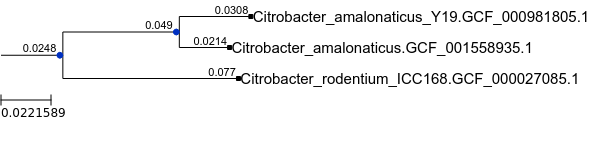

In [35]:
ts = TreeStyle()
# ts.scale = 300
ts.show_leaf_name = False
ts.show_branch_length = True
ts.show_branch_support = False

treeFilePath = evolPath / ATGC_id / '{}_tree.svg'.format(ATGC_id)
phyloTreeCut.render(str(treeFilePath), tree_style=ts)
phyloTreeCut.render("%%inline", tree_style=ts)

In [36]:
filepath = (evolPath / ATGC_id / '{}_tree.nhx'.format(ATGC_id))
phyloTreeString = phyloTreeCut.write()
with filepath.open('w') as f:
    f.write(phyloTreeString)

In [37]:
phyloTree3 = phyloTreeCut.copy()

In [38]:
nodeNames = []
for node in phyloTree3:
    print("#", node.name)
    node.name = {species_1:'species_1', species_2:'species_2', species_o:'species_o'}[node.name]

# Citrobacter_amalonaticus_Y19.GCF_000981805.1
# Citrobacter_amalonaticus.GCF_001558935.1
# Citrobacter_rodentium_ICC168.GCF_000027085.1


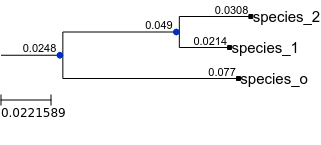

In [39]:
# treeFilePath = evolPath / ATGC_id / '{}_tree.svg'.format(ATGC_id)
# phyloTree.render(str(treeFilePath), tree_style=ts)
phyloTree3.render("%%inline", tree_style=ts)

In [40]:
filepath = (evolPath / ATGC_id / '{}_tree_simple.nhx'.format(ATGC_id))
phyloTreeString = phyloTree3.write()
with filepath.open('w') as f:
    f.write(phyloTreeString)

In [41]:
# modifying the Newick tree format to adapt to phylip/PAML format
with filepath.open('r') as f:
    s = f.readlines()
s = '3 1\n' + s[0] + '\n'
filepath = (evolPath / ATGC_id / '{}_tree_simple.phylip'.format(ATGC_id))
with filepath.open('w') as f:
    f.write(s)

## choose COG

### examples

In [42]:
cog = "ATGC001.COG00122"

In [43]:
COGDf5.loc[cog]

n_genomes                                                                                          432
n_proteins                                                                                         827
average_prot_length(aa)                                                                            402
average_synteny_support(%)                                                                       0.667
species_1_protein                                    Citrobacter_amalonaticus.GCF_001558935.1:1:217...
species_2_protein                                    Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...
species_o_protein                                    Citrobacter_rodentium_ICC168.GCF_000027085.1:1...
species_1_aligned_protein_sequence                   ----------------MTAVTHKEKTSAANTSLFRIAFAVFLTYMT...
species_1_protein_GI                                                                      GI:992382832
species_2_aligned_protein_sequence                   ----------------MTAV

In [44]:
for col in ["species_1_aligned_protein_sequence_nogap",
            "species_2_aligned_protein_sequence_nogap",
            "species_o_aligned_protein_sequence_nogap"]:
    print(COGDf5.loc[cog, col][-30:])

TSCGYPSVFLAGAISAVLGIVVTLLSFRRR
TSCGYRSVFLAGAISAVLGIVVTLLSFRRG
TSCGYPSVFLAGAISAVLGIAVTLLSFRRG


### detect gap-free regions

In [45]:
colList = ["species_1_aligned_protein_sequence_nogap",
           "species_2_aligned_protein_sequence_nogap",
           "species_o_aligned_protein_sequence_nogap"]
colPos = -1
alignCol = COGDf5.loc[cog, colList].map(lambda x: x[colPos])
alignColHasGap = '-' in alignCol.values
alignColHasGap

ctermRegion = -3

def alignment_cterm_region_has_gap(x):
    alignRegion = ''.join(x[colList].map(lambda x: x[ctermRegion:]).values)
    alignRegionHasGap = '-' in alignRegion
    return alignRegionHasGap

COGDf5['aligned_protein_sequence_cterminal_region_has_gap'] = \
    COGDf5.apply(alignment_cterm_region_has_gap, axis=1)

In [46]:
COGDf5['aligned_protein_sequence_cterminal_region_has_gap'].value_counts()

False    2575
True      431
Name: aligned_protein_sequence_cterminal_region_has_gap, dtype: int64

In [47]:
cogList = COGDf5[COGDf5['aligned_protein_sequence_cterminal_region_has_gap']].index

In [48]:
for cog in cogList[:5]:
    print("#", cog)
    for col in colList:
        print(COGDf5.loc[cog, col][-30:])

# ATGC001.COG00002
AKTAAQSVSWRCINDYGGTTDKFTTSLKP-
SPATGQTVSWRCINDYGGPSAKYTAKLDKA
DGVTGGNVTFKIINDYGGISDAHRSAI---
# ATGC001.COG00004
IETTERNY--RYSGWKKAVKRALAWEDHEE
AQ-RHHVYQQRRETFRRLYQQLLPLMS---
YPQT--------------------------
# ATGC001.COG00005
GIKASGLGREGSKYGIEDYLEIKYLCIGLS
GIKASGLGREGSKYGIEDYLEIKYLCIGL-
GQKLSGYGKDMSLYGLEDYTVIRHVMVKH-
# ATGC001.COG00010
HRYPFSQLAEIFEQDVINNRTLIKGVITF-
HRFSIDEFQKGFDAMRSGQS--GKVILSWN
HRYSIDDFQQGFDAMRSGQS--GKVILSWD
# ATGC001.COG00011
IATITTGEEIPQNTDAADIKRMTAACKQGG
TATVPAPAE-SSNNAPSGIKSITAVCRQGE
TVEYSFKAA----VGSGDIITDARLCR---


In [49]:
cogList = COGDf5[~COGDf5['aligned_protein_sequence_cterminal_region_has_gap']].index
len(cogList)

2575

In [50]:
for cog in cogList[:100]:
    print("#", cog)
    for col in colList:
        print(COGDf5.loc[cog, col][-30:])

# ATGC001.COG00001
VARYESYDATP--ITPGNAYADMTVNILYR
FARFQSIVATPAEITPGTASSQMIVNIVYH
YAAYVATRVP---VMAGPANAVANFTVNYN
# ATGC001.COG00003
GDSNHFSTLFRREFDWSPRDIRQGRDALLQ
GDSNHFSTLFRREFDWSPRDIRQGRDALLQ
GDSNHFSTLFRREFNWSPRDIRQGRDALLQ
# ATGC001.COG00006
GTIQADSLPGKGATFTLWLPVTLTRKDSQG
GTIQADSLPGKGATFTLWLPVTLTRKDSQG
GTIQADSPAGRGAVFTLWLPVNAKQKDSQG
# ATGC001.COG00007
NFSAYTDANYLGGGDVDQDWSANAGVKYTW
NFSAYTDANYLGGGDVDQNWSANAGVKYTW
NFSAYTDVNYLGGGDVDQDWSANLGVKYTW
# ATGC001.COG00008
AAAAIAVTRKGAQPSVPWREEIEAFLGQQR
AAAAIAVTRKGAQPSVPWRNEIEAFLGQQR
AAAAIAVTRKGAQPSVPWREEIEAFLGQQR
# ATGC001.COG00009
KQVALDQQQRPIEYSISYCRSDLYVFVCEE
KQVALDQQQRPIEYSISYCRSDLYVFVCEE
KQVALDQQQRPIEYSISYCRSDLYVFVCEE
# ATGC001.COG00012
HLGGEFTREQATQEVLMAAAVGKLNRVNQE
HLGGEFTREQATQEVLMAAAVGKLNRVNQE
HLGGEFTREQATQEVLMAAAVGKLNRVNQE
# ATGC001.COG00013
RTCYLSWHEAAGRDKGHQWMEELLASVCKR
RTCYLSWHEAAGRDKGHQWMEELLASVCKR
RACYLSWHEAAGRDKGHQWMEELLASVCKR
# ATGC001.COG00016
LITDAGIDPAFRQALEEKGIEVIITGETNE
LITDAGIDPAFRQALEEKGIEVIITGETNE
LITDAGIDPAFRRALEEKGIDVI

### examples alignment tree

In [988]:
cog = "ATGC001.COG00024"

We have some cases where the two ingroup species have gained an extension at the C-terminal, presumably by mutation of the stop codon. example:

In [1024]:
cog = "ATGC001.COG00039"

ATGC001.COG00039
# Citrobacter_amalonaticus_Y19.GCF_000981805.1
# Citrobacter_amalonaticus.GCF_001558935.1
# Citrobacter_rodentium_ICC168.GCF_000027085.1


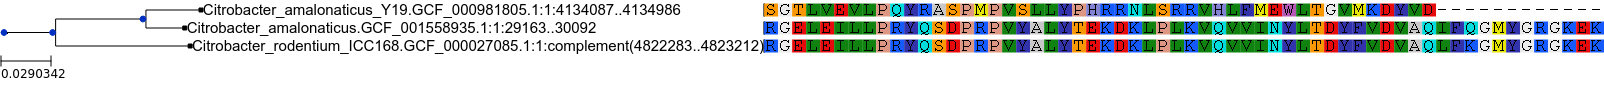

In [1012]:
phyloTree2 = phyloTree.copy()

print(cog)
alignFilePath = evolPath / ATGC_id / 'alignments' / 'prot' / '{}_prot.fa'.format(cog)
align = next(AlignIO.parse(alignFilePath, format='fasta'))

# change the name of the tree leaves to the protein ids, not the species

for node in phyloTree2:
    print("#", node.name)
    node.name = {triplet['species_1']:COGDf4.loc[cog, 'species_1_protein'],
                 triplet['species_2']:COGDf4.loc[cog, 'species_2_protein'],
                 triplet['species_o']:COGDf4.loc[cog, 'species_o_protein']}[node.name]

phyloTree2.render("%%inline", tree_style=ts)

phyloTree2.link_to_alignment(alignment=str(alignFilePath), alg_format="fasta")

ts = TreeStyle()
# ts.scale = 300
ts.show_leaf_name = False
ts.show_branch_length = False
ts.show_branch_support = False

alignTreeFilePath = evolPath / ATGC_id / 'tree_alignments' / '{}_tree_align_prot.svg'.format(cog)
phyloTree2.render(str(alignTreeFilePath), tree_style=ts)


align2 = align[:, -60:]
alignFilePath2 = evolPath / ATGC_id / 'alignments' / 'prot' / '{}_prot_dummy.fa'.format(cog)
with alignFilePath2.open('w') as f:
    f.write(align2.format(format='fasta'))
phyloTree2.link_to_alignment(alignment=str(alignFilePath2), alg_format="fasta")
alignFilePath2.unlink()
phyloTree2.render("%%inline", tree_style=ts)

In [1013]:
cog = "ATGC001.COG00076"

ATGC001.COG00076
# Citrobacter_amalonaticus_Y19.GCF_000981805.1
# Citrobacter_amalonaticus.GCF_001558935.1
# Citrobacter_rodentium_ICC168.GCF_000027085.1


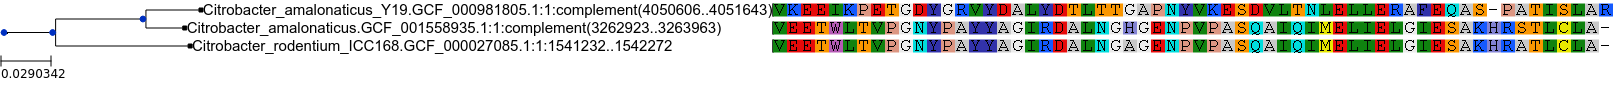

In [1014]:
phyloTree2 = phyloTree.copy()

print(cog)
alignFilePath = evolPath / ATGC_id / 'alignments' / 'prot' / '{}_prot.fa'.format(cog)
align = next(AlignIO.parse(alignFilePath, format='fasta'))

# change the name of the tree leaves to the protein ids, not the species

for node in phyloTree2:
    print("#", node.name)
    node.name = {triplet['species_1']:COGDf4.loc[cog, 'species_1_protein'],
                 triplet['species_2']:COGDf4.loc[cog, 'species_2_protein'],
                 triplet['species_o']:COGDf4.loc[cog, 'species_o_protein']}[node.name]

phyloTree2.render("%%inline", tree_style=ts)

phyloTree2.link_to_alignment(alignment=str(alignFilePath), alg_format="fasta")

ts = TreeStyle()
# ts.scale = 300
ts.show_leaf_name = False
ts.show_branch_length = False
ts.show_branch_support = False

alignTreeFilePath = evolPath / ATGC_id / 'tree_alignments' / '{}_tree_align_prot.svg'.format(cog)
phyloTree2.render(str(alignTreeFilePath), tree_style=ts)


align2 = align[:, -60:]
alignFilePath2 = evolPath / ATGC_id / 'alignments' / 'prot' / '{}_prot_dummy.fa'.format(cog)
with alignFilePath2.open('w') as f:
    f.write(align2.format(format='fasta'))
phyloTree2.link_to_alignment(alignment=str(alignFilePath2), alg_format="fasta")
alignFilePath2.unlink()
phyloTree2.render("%%inline", tree_style=ts)

In [1015]:
cog = "ATGC001.COG00084"

ATGC001.COG00084
# Citrobacter_amalonaticus_Y19.GCF_000981805.1
# Citrobacter_amalonaticus.GCF_001558935.1
# Citrobacter_rodentium_ICC168.GCF_000027085.1


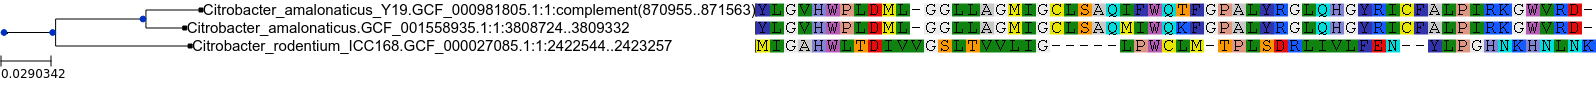

In [1016]:
phyloTree2 = phyloTree.copy()

print(cog)
alignFilePath = evolPath / ATGC_id / 'alignments' / 'prot' / '{}_prot.fa'.format(cog)
align = next(AlignIO.parse(alignFilePath, format='fasta'))

# change the name of the tree leaves to the protein ids, not the species

for node in phyloTree2:
    print("#", node.name)
    node.name = {triplet['species_1']:COGDf4.loc[cog, 'species_1_protein'],
                 triplet['species_2']:COGDf4.loc[cog, 'species_2_protein'],
                 triplet['species_o']:COGDf4.loc[cog, 'species_o_protein']}[node.name]

phyloTree2.render("%%inline", tree_style=ts)

phyloTree2.link_to_alignment(alignment=str(alignFilePath), alg_format="fasta")

ts = TreeStyle()
# ts.scale = 300
ts.show_leaf_name = False
ts.show_branch_length = False
ts.show_branch_support = False

alignTreeFilePath = evolPath / ATGC_id / 'tree_alignments' / '{}_tree_align_prot.svg'.format(cog)
phyloTree2.render(str(alignTreeFilePath), tree_style=ts)


align2 = align[:, -60:]
alignFilePath2 = evolPath / ATGC_id / 'alignments' / 'prot' / '{}_prot_dummy.fa'.format(cog)
with alignFilePath2.open('w') as f:
    f.write(align2.format(format='fasta'))
phyloTree2.link_to_alignment(alignment=str(alignFilePath2), alg_format="fasta")
alignFilePath2.unlink()
phyloTree2.render("%%inline", tree_style=ts)

In [1064]:
cog = "ATGC001.COG00122"

ATGC001.COG00122
# Citrobacter_amalonaticus_Y19.GCF_000981805.1
# Citrobacter_amalonaticus.GCF_001558935.1
# Citrobacter_rodentium_ICC168.GCF_000027085.1


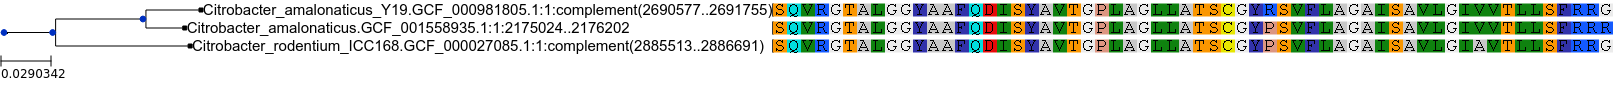

In [1065]:
phyloTree2 = phyloTree.copy()

print(cog)
alignFilePath = evolPath / ATGC_id / 'alignments' / 'prot' / '{}_prot.fa'.format(cog)
align = next(AlignIO.parse(alignFilePath, format='fasta'))

# change the name of the tree leaves to the protein ids, not the species

for node in phyloTree2:
    print("#", node.name)
    node.name = {triplet['species_1']:COGDf4.loc[cog, 'species_1_protein'],
                 triplet['species_2']:COGDf4.loc[cog, 'species_2_protein'],
                 triplet['species_o']:COGDf4.loc[cog, 'species_o_protein']}[node.name]

phyloTree2.render("%%inline", tree_style=ts)

phyloTree2.link_to_alignment(alignment=str(alignFilePath), alg_format="fasta")

ts = TreeStyle()
# ts.scale = 300
ts.show_leaf_name = False
ts.show_branch_length = False
ts.show_branch_support = False

alignTreeFilePath = evolPath / ATGC_id / 'tree_alignments' / '{}_tree_align_prot.svg'.format(cog)
phyloTree2.render(str(alignTreeFilePath), tree_style=ts)


align2 = align[:, -60:]
alignFilePath2 = evolPath / ATGC_id / 'alignments' / 'prot' / '{}_prot_dummy.fa'.format(cog)
with alignFilePath2.open('w') as f:
    f.write(align2.format(format='fasta'))
phyloTree2.link_to_alignment(alignment=str(alignFilePath2), alg_format="fasta")
alignFilePath2.unlink()
phyloTree2.render("%%inline", tree_style=ts)

In [1067]:
with (evolPath / ATGC_id / 'alignments' / 'nuc' / 'phylip' / '{}_nuc.phylip'.format(cog)).open() as f:
    lines = f.readlines()
print('\n'.join(lines))

3 1176

species_1  ATGACAGCAGTAACCCATAAAGAAAAAACATCTGCAGCGAACACATCGCTTTTTCGTATCGCGTTTGCGGTCTTTTTGACCTACATGACGGTCGGCCTGCCGCTACCCGTCATTCCACTTTTTGTTCATCATGAACTGGGCTATGGCAATACGATGGTCGGTATCGCCGTGGGGATTCAGTTTCTCGCAACCGTCTTAACGCGCGGCTATGCCGGGCGACTCGCCGATCAGTACGGCGCCAGGCGTTCTGCGCTGCAGGGCATGTTTGCCTGCGCGCTGGCGGGCGGCGCGTGGCTACTGGCAGCACTCTTACCCGTTTCTGTACCGTTCAAATTCGCGTTATTAATCGTCGGACGGCTGATCCTCGGCTTTGGGGAAAGCCAGTTACTGACTGGAACCCTGACCTGGGGGCTGGGTCTGGTGGGGCCGGCACGTTCCGGTAAAGTGATGTCGTGGAACGGGATGGCAATTTACGGTGCGCTGGCGGCAGGGGCGCCGCTGGGTCTGCTGATCCACAGCCATTTTGGGTTTGCGGGTCTTGCGGGCACGACAATGGTGTTACCGCTGCTGGCATGGGCATTTAACGGAACGGTGCGTAAAGTACCGGCACATGCGGGCGAGCGTCCCTCACTGTGGAGCGTAGTAGGGCTTATCTGGAAACCGGGTCTGGGCCTCGCGCTGCAAGGCGTGGGATTTGCCGTGATCGGCACCTTTATCTCTCTCTATTTTGCCAGCCACGGTTGGGCGATGGCGGGCTTTACGCTGACTGCGTTTGGCGGAGCCTTTGTGATCATGCGCGTGCTGTTTGGCTGGATGCCGGACCGCTTTGGCGGGGTCAGGGTGGCTATCGCTTCTCTGCTGATCGAGACCGTTGGGCTGGTCTTGCTCTGGCTGGCGCCGACGGCCTGGTTTGCGCTACTCGGTGCGGCATTAACCGGAGCCGGCTGTTCGCTGATCTTCCCGGCGCTCGGCGTTGAAGTG

## Parsimony ancestral state reconstruction

PAMP in paml version 4.9j, October 2019

Yang, Z. 1997. PAML: a program package for phylogenetic analysis by maximum likelihood Computer
Applications in BioSciences 13:555-556

In theory, ancestral sequence reconstruction using maximum parsimony algorithm can be done in PAML.

see http://web.mit.edu/6.891/www/lab/paml.html

From the PAML documentation:

> pamp: Parsimony-based analyses for a given tree topology, estimation of the substitution pattern by the method of Yang and Kumar (1996); estimation of the gamma parameter for variable rates among sites by the method of moments, the method of Sullivan et al. (1995), and the method of Yang and Kumar (1996); reconstruction of ancestral character states using the algorithm of Hartigan (1973) and an unpublished "improved parsimony" method.

and

> Reconstruction of ancestral sequences

> Nucleotides or amino acids of extinct ancestors can be reconstructed using information of the present-day
sequences. Parsimony reconstructs ancestral character states by the criterion that the number of changes along
the tree at the site is minimized. Algorithms based on this criterion were developed by Fitch (1971) and
Hartigan (1973), and are implemented in the program pamp. The likelihood approach uses branch lengths
and the substitution pattern for ancestral reconstruction. It was developed by Yang et al. (1995) and Koshi and Goldstein (1996) and is implemented in baseml for nucleotide sequences and in aaml (codeml.c with
seqtype = 2) for amino acid sequences. Results are collected in the file rst.


It seems that the tree should be *unrooted*, or at least have no branch length at root. Species name should be the same in the alignment than in the tree.

Format of the phylip tree: no comma between nb of sequences and number of trees.

Format of the phylip alignment:
```
3 576
s1
------ATGCGTTTAACACCACTATTA
s2
ATGCATTTAAATAAATCGTTA------
so
------ATGAAAAAGAACAGT------
```

Example of results:
```
PAMP ATGC001/alignments/nuc/phylip/ATGC001.COG00001_nuc.phylip, nucleotide sequences

Frequencies..
                                    T      C      A      G
s1                             0.24470 0.26590 0.25626 0.23314 GC = 0.499
s2                             0.26012 0.25434 0.27168 0.21387 GC = 0.468
so                             0.22351 0.25819 0.24663 0.27168 GC = 0.530

Homogeneity statistic: X2 = 0.01152 G = 0.01145 

Average                        0.24277 0.25947 0.25819 0.23956

# constant sites:    149 (28.71%)
ln Lmax (unconstrained) = -1935.600641

TREE #  1
((2, 1), 3);

List of most parsimonious reconstructions (MPRs) at each site: #MPRs (#changes)
and then the most likely reconstruction out of the MPRs and its probability


(1) Branch lengths and substitution pattern
   4..5     5..2     5..1     4..3  
  0.13473  0.08002  0.10489  0.13496
tree length:   0.45460

F(t)
     1.2e+04     3.3e+02     1.5e+02          80
     3.9e+02     7.5e+03     4.7e+02     2.9e+02
     2.7e+02     3.9e+02     6.7e+03     5.7e+02
     1.3e+02     2.5e+02     5.3e+02     7.5e+03

rate matrix Q: Qij*dt = prob(i->j; dt)

   -0.505637    0.278283    0.155674    0.071680
    0.401847   -1.194554    0.500296    0.292411
    0.245808    0.547056   -1.497973    0.705109
    0.105961    0.299341    0.660123   -1.065425
Order: T, C, A, G
Average Ts/Tv =   0.9337


(2) Gamma parameter

# changes .. # sites
     0       149
     1       291
     2        79

# sites   519,  total changes   449
mean-var   0.8651   0.4219
alpha (method of moments)  -1.6887
alpha (Sullivan et al. 1995)  99.0000
alpha (Yang & Kumar 1995, ncatG= 8)  99.0000


(3) Parsimony reconstructions

List of most parsimonious reconstructions (MPRs) at each site: #MPRs (#changes)
and then the most likely reconstruction out of the MPRs and its probability

   1  ATA:  AA  |   1 (1) | 
   2  TTT:  TT  |   1 (0) | 
   3  GAG:  GG  |   1 (1) | 
   4  CAA:  AA  |   1 (1) | 
   5  GAA:  AA  |   1 (1) | 
   6  TTA:  TT AT  |   2 (1) | AT (0.581)
   7  TAA:  AA  |   1 (1) | 
   8  TAA:  AA  |   1 (1) | 
   9  AAG:  AA GA  |   2 (1) | AA (0.503)
  10  ATA:  AA  |   1 (1) | 
  11  CCA:  CC AC  |   2 (1) | AC (0.512)
  12  AGC:  CC CA CG AA GG  |   5 (2) | AA (0.260)
  13  CTA:  TT CC AT AC AA  |   5 (2) | AC (0.309)
  14  CTG:  TT CC GT GC GG  |   5 (2) | GC (0.350)
  15  AAT:  TA AA  |   2 (1) | AA (0.582)

 490  GAG:  GG  |   1 (1) | 
 491  CGC:  CC  |   1 (1) | 
 492  ATT:  TT  |   1 (1) | 
 493  GCG:  GG  |   1 (1) | 
 494  AAT:  TA AA  |   2 (1) | AA (0.582)
 495  TAC:  TT CT CC CA AA  |   5 (2) | AA (0.278)
 496  AAG:  AA GA  |   2 (1) | AA (0.503)
 497  TTC:  TT CT  |   2 (1) | CT (0.569)
 498  GGT:  TG GG  |   2 (1) | GG (0.580)
 499  AAA:  AA  |   1 (0) | 
 500  CTA:  TT CC AT AC AA  |   5 (2) | AC (0.309)
 501  ACC:  CC  |   1 (1) | 
 502  GGT:  TG GG  |   2 (1) | GG (0.580)
 503  TTT:  TT  |   1 (0) | 
 504  CCC:  CC  |   1 (0) | 
 505  AAA:  AA  |   1 (0) | 
 506  AAC:  CA AA  |   2 (1) | AA (0.513)
 507  TCC:  CC  |   1 (1) | 
 508  AAG:  AA GA  |   2 (1) | AA (0.503)
 509  TTT:  TT  |   1 (0) | 
 510  TTT:  TT  |   1 (0) | 
 511  TGA:  TT AT AA AG GG  |   5 (2) | AA (0.338)
 512  TTA:  TT AT  |   2 (1) | AT (0.581)
 513  GCC:  CC  |   1 (1) | 
 514  TTT:  TT  |   1 (0) | 
 515  AAA:  AA  |   1 (0) | 
 516  TTT:  TT  |   1 (0) | 
 517  CCA:  CC AC  |   2 (1) | AC (0.512)
 518  GAA:  AA  |   1 (1) | 
 519  CCC:  CC  |   1 (0) | 

Approx. relative accuracy at each node, by site

   1  ATA:  
   2  TTT:  
   3  GAG:  
   4  CAA:  
   5  GAA:  
   6  TTA:  T (0.581) T (1.000) 
   7  TAA:  
   8  TAA:  
   9  AAG:  A (0.503) A (1.000) 
  10  ATA:  
  11  CCA:  C (0.512) C (1.000) 
  12  AGC:  A (0.260) G (0.506) 
  13  CTA:  C (0.600) T (0.602) 
  14  CTG:  C (0.565) T (0.686) 
  15  AAT:  A (0.582) A (1.000) 

 491  CGC:  
 492  ATT:  
 493  GCG:  
 494  AAT:  A (0.582) A (1.000) 
 495  TAC:  T (0.278) A (0.541) 
 496  AAG:  A (0.503) A (1.000) 
 497  TTC:  T (0.569) T (1.000) 
 498  GGT:  G (0.580) G (1.000) 
 499  AAA:  
 500  CTA:  C (0.600) T (0.602) 
 501  ACC:  
 502  GGT:  G (0.580) G (1.000) 
 503  TTT:  
 504  CCC:  
 505  AAA:  
 506  AAC:  A (0.513) A (1.000) 
 507  TCC:  
 508  AAG:  A (0.503) A (1.000) 
 509  TTT:  
 510  TTT:  
 511  TGA:  T (0.678) G (0.338) 
 512  TTA:  T (0.581) T (1.000) 
 513  GCC:  
 514  TTT:  
 515  AAA:  
 516  TTT:  
 517  CCA:  C (0.512) C (1.000) 
 518  GAA:  
 519  CCC:  

list of extant and reconstructed sequences

s1                  ATGCGTTTAA CACCAATAGC AGCTTCGCTA TTATCACTCG CCTCTATGGG GAGTAGGGCA GATGAGAACA ATGCAGGTAC TATCCACTTC ACCGGTGAAA TTGTTGATCC AAGTTGTACT ATAACGGGCG ATAGCGGAAA AGACAGTACC GTACTTGGTT CTTTCGCGCC CAGCTTTTTT ACCGGTAACG GTGGTAAATC CGACGATGCC GCATTTACCA TTACGTTGGC TGGCTGCCCA ACAGGATTAG ATCGTATTCA GTTAACATTT AAAGGCATCA CCATCGTCGG ACACGATGAC CTTCTGGCAC TTACGGCCGG CGGTGCCACT GGCGTCGGCA TCTCTGTTAG CACTGCAGCA CCAACAAACC TCAACCTGAC CGGCGCGGAT GGCCAGGTGT ATCCACTGCA AGCAACATCA GCCGATTCCC AAAATTTCGT CGCCCGCTAT GAATCCTATG ATGCGACGAT CACACCCGGA AATGCGTATG CAGATATGAC AGTCAATATT TTGTATCGC
s2                  TTAAATAAAT CGTTAAGTGC CTTAGCACTG TTAACTCTCA CCTCAACTTC AGCGTGGGCA GATGAAGGTC CTTCGGGTAT CATTCATTTT ACCGGTGATA TTATTAACCC AAGCTGCAAA ATTGAAGGTG GCACCACAGA TAGCACGGTA AAACTCGGTT CTTACCCGCC CTCAACATTT TCCGCTATGG GCGAAAAATC GACCAACATG AAATTCGTTC TTACCCTTAT AGACTGCCCT GATGGTTTAG ATCAAATCCA GCTGACTTTC TCAGGTGATA CAGTCCCGGG AGAGGATGAC GTGTTGGCGC TTGATGCAAC ATCAGCCGCT GGCGTTGGGA TCTCAGTCGT TAGCAATGAC AAGACGAACC TCAATATGAA GGGAGAAGAA GGCCAGTTGT TCCCACTCAT GACTTCTGCC GGCAATACAA CAAATTTATT CGCCCGCTTT CAGTCGATTG TCGCCACTAT CACCCCTGGG ACCGCAAGCA GTCAAATGAT CGTCAACATT GTCTATCAC
so                  ATGAAAAAGA ACAGTATAGC CCTGGCATTA TCCGTGACGG CGCTTTTTAC GGCAACAAAC GTCATGGCCT ATGACGGTAC GGTGAATTTT GTCGGGCAAA TCCTCGATAC CGCCTGTACG GTGGATATTG GCGCCAACAA CACGCTGGTG GTTATGGGCA ACGTCTATAA GACCGCATTT GCCGCTGCGG GTGATGAGGC GTCGACGACA AAATTTACCC TGAGGCTGAT TAATTGCCCG GCCAGTGTGA GTACCGCCAG AGTAAAATTT GATGGTGCGA ACGACGCTTC CGACAGCACG TTGCTGGCGA TTCCGGATCC GGCAGCGGAT GGCGTGGCGA TTCGGCTCAA GACGGCGGAT AAAACCAACC TCGATCTCAA CCAGGTGAAC GGCTACACGT ACGTCGTATC CAGCACGATG GATAATAACC TGGATTTTTA CGCCGCTTAT GTCGCGACCC GCGTTCCGGT AATGGCAGGA CCAGCTAACG CTGTCGCTAA CTTCACCGTT AACTATAAC
node #4             ATGAAAAAAA AAAGAATAGC CCTAGCACTA TCAACAACGG CGCCTATTAC GGCAAGAAAA GACAAGGACC ATGAAGGTAC GATGAATTTT ACCGGGGAAA TCATCGATAC AAGCTGTACA ATAGAAAGTG GCACCAAAAA CAAGACGGTA GTAATGGGCA ACGTCCAGAA GACCACATTT ACCGCTACGG GTGATAAAGC GACGAAGACA AAATTTACCC TGAGGCTGAT TAACTGCCCA GCCAGTGTAA ATAAAACCAA AGTAAAATTT AAAGGTGAGA ACGACGCCGG AGACAACAAG CTGCTGGCGA TTACGGACAC AGCAGCGGAT GGCGTGGGGA TCCGAGTCAA GACGGCAGAC AAAACAAACC TCAATCTGAA CGAAGCGAAA GGCCAGACGT ACGCAGTACC AAGCACAACA GACAATAACC CAAATTTCTA CGCCGGCTAT GAAGCGACCG ACGCCACGAT AACAGCAGGA ACAGCAAACG CTGAAACGAA CGTCAACATT AACTATAAC
node #5             ATGAATAAAA CACCAATAGC CCTAGCACTA TTAACACTCG CCTCTATTAC GGCAAGGGCA GATGAGGACC ATGCAGGTAC CATCCATTTT ACCGGTGAAA TTATTGATCC AAGCTGTACA ATAGAAGGTG GCACCAAAAA CAACACGGTA GTACTCGGTT CTTTCCCGCC CACCACATTT ACCGCTACGG GTGATAAATC GACCAACACG AAATTTACCC TTACGCTGAT TGACTGCCCA GCCGGTTTAG ATCAAATCCA GCTAACATTT AAAGGTGACA CCGTCGCCGG AGACGATGAC CTGCTGGCGC TTACGGCCAC AGCAGCCGCT GGCGTCGGGA TCTCAGTCAA CACCGCAGAC AAAACAAACC TCAATCTGAA CGGAGCGGAA GGCCAGATGT ACCCACTACC AACCACAACA GGCAATACCC CAAATTTCTT CGCCCGCTAT GAATCGACTG ACGCCACGAT CACACCCGGA ACCGCAAACG CTGAAATGAC CGTCAACATT ATCTATCAC
```

In the results, I don't know how to identify the internal nodes of the tree, which are assigned a number
```
TREE #  1
((2, 1), 3);
```
which is the order of the species, 1, 2, 3?

```
1  ATA:  AA  |   1 (1) | 
...
12  AGC:  CC CA CG AA GG  |   5 (2) | AA (0.260)
```

At site 12, the most parsimonious reconstructions (MPRs) says: AGC. Then, the order of the species must be s1, s2 and so. The next 2 letters are the state at nodes #4 and #5 for the different MPRs. Then, we have the total number of reconstructions, 5, 2 nucleotides changes (2) along the nodes, and then the most likely reconstruction out of the MPRs and its probability, AA (0.260).

Then, we have a second list of sites, which says "Approx. relative accuracy at each node, by site".
```
  11  CCA:  C (0.512) C (1.000) 
  12  AGC:  A (0.260) G (0.506) 
  13  CTA:  C (0.600) T (0.602) 
  14  CTG:  C (0.565) T (0.686) 
  15  AAT:  A (0.582) A (1.000) 
```

compared to the reconstruction
```
  11  CCA:  CC AC  |   2 (1) | AC (0.512)
  12  AGC:  CC CA CG AA GG  |   5 (2) | AA (0.260)
  13  CTA:  TT CC AT AC AA  |   5 (2) | AC (0.309)
  14  CTG:  TT CC GT GC GG  |   5 (2) | GC (0.350)
  15  AAT:  TA AA  |   2 (1) | AA (0.582)

```

The second list is the probabilities for each node of the first two nodes 1 and 2, given the reconstruction (not sure, just guessing?).

Note that the position is most presumably referring to the position in the cleaned alignement, where all columns with one or several gaps have been removed. The full alignment has 576 positions, and in the result files we have 519 positions.

Examples of lines:

```
1  ATA:  AA  |   1 (1) | 
...
12  AGC:  CC CA CG AA GG  |   5 (2) | AA (0.260)
```

In [51]:
pampPath = evolPath / ATGC_id / 'pamp' / cog
pampPath.mkdir(exist_ok=True)
pampCtlFilePath = pampPath / 'pamp.ctl'
# '{}_pamp.ctl'.format(cog)
s = """
    seqfile = ../../alignments/nuc/phylip/{}_nuc.phylip
    outfile = {}_pamp_results.txt
   treefile = ../../{}_tree_simple.phylip

    seqtype = 0  * 0:nucleotides; 2:amino acids, 3:binary
      ncatG = 8  * # of categories in the dG model of rates
      nhomo = 0  * nonhomogeneous in calcualting P for branch
""".format(cog, cog, ATGC_id)
with pampCtlFilePath.open('w') as f:
    f.write(s)

In [52]:
import shlex, subprocess

In [53]:
args = shlex.split('/home/mweber/Software/paml4.9j/bin/pamp')
cmd_output = subprocess.check_output(args, cwd=str(pampPath))
cmd_output = cmd_output.decode().strip()
print(cmd_output)

PAMP in paml version 4.9j, October 2019
ns = 3  	ls = 963
Reading sequences, sequential format..
Reading seq # 3: species_o       
Sequences read..
Counting site patterns..  0:00
Compressing,     56 patterns at    810 /    810 sites (100.0%),  0:00
Counting frequencies..

TREE #  1
((2, 1), 3);

Hartigan reconstruction done..
pattern done..
gamma done..
Yang reconstruction done..


In [55]:
verbose = 2

In [54]:
parsimonyFilePath = pampPath / '{}_pamp_results.txt'.format(cog)

with parsimonyFilePath.open() as f:
    lines = f.readlines()

j = None
for i, line in enumerate(lines):
    if re.search('TREE #  1', line):
        j = i
        break
else:
    if verbose >= 0: print("TREE not found.")

pampTree = lines[j + 1][:-1]
if verbose >= 2: print('pampTree', pampTree)

for i in range(j + 1, len(lines)):
    if re.search("\(3\) Parsimony reconstructions", lines[i]):
        j = i
        break
else:
    if verbose >= 0: print("Parsimony reconstructions not found.")

for i in range(j + 1, len(lines)):
    if re.search(r'^\s*1', lines[i]):
        j = i
        break
else:
    if verbose >= 0: print("first line of MPR not found.")

parsimonyLineStart = j

for i in range(j + 1, len(lines)):
    if lines[i] == '\n':
        j = i
        break
parsimonyLineEnd = j

for i in range(j + 1, len(lines)):
    if re.search("list of extant and reconstructed sequences", lines[i]):
        j = i
        break
else:
    if verbose >= 0: print("list of extant and reconstructed sequences not found.")

MPR_seqs = []
for inode, i in enumerate(range(j + 2, j + 2 + 5)):
    if verbose >= 2: print(lines[i])
    m = re.search(r'^([\w #]+)\s\s([TCAG ]+)', lines[i])
    species_name = m.group(1).strip(' ')
    seq = ''.join([c for c in m.group(2) if c != ' '])
    MPR_seqs.append({'node':inode + 1, 'node_name':species_name, 'MPR_seq':seq, 'length_MPR_seq':len(seq)})
MPRSeqDf = pd.DataFrame(MPR_seqs)
MPRSeqDf

pampTree ((2, 1), 3);
species_1           ATGATTTTCA ATATTCAGCG CTATTCTACA CACGATGGCC CCGGTATCCG CACCGTGGTG TTCCTTAAAG GATGCTCTCT GGGCTGTCGC TGGTGTCAGA ATCCGGAAAG CCGGGCGCGC ACGCAGGATC TGCTGTTTGA TGCACGTTTG TGCCTCGAAT GCGAGCTTTG CGTAAAGGCG GCGGATTGTT GCCCCACTCA GGCATTGACC GTCTGCGGCG AGGTGAAAAG CGTGGATGAA ATAATGACCA CCGTTCTGCG CGATAAACCT TTTTATGACC GCAGCGGTGG CGGTATTACG CTTTCGGGCG GCGAACCGTT TATGCAGCCA GAACTGGCCG CGTCGCTGTT TAAAGCCAGT CACGAAGCGG GCATTCATAC CGCAGTTGAA ACCTGTCTGC ATGTGCCGTG GAAATACATT GAACCTTCAT TGCCCTGGAT CGATCTGTTC CTTGCAGATT TAAAACACGT TGCCGACGCG CCGTTTAAGC AATGGACGGA TGGCAGCGCA TCACGCGTGC TGGAAAACCT GAAAAAGCTC GCCGCTGCCG GGAAAAAAAT CATCATCCGC GTTCCGCTGG TTCAGGGGTT TAACGCGGAT GAAGAGGCCA TTAAAGCGAT TACCGATTTT GCCGCCGAAC TGCACGTCAG CGAGATCCAC TTTTTGCCCT ACCACACGCT GGGCATCAAT AAATACCACT TGCTCAACCA ACCCTACCAC GCGCCGGATA AGCCGCTGGA TGCACCCGAT CTGCTCGCCT TTGCGCAGCA GTACGCCTGC ACGAAAGGTT TGACCGCGAC TTTACGAGGA 

species_2           CGCATCTTCA ATATTCAACG CTATTCGCTG AATGACGGTC A

,MPR_seq,length_MPR_seq,node,node_name
0,ATGATTTTCAATATTCAGCGCTATTCTACACACGATGGCCCCGGTA...,810,1,species_1
1,CGCATCTTCAATATTCAACGCTATTCGCTGAATGACGGTCAGGGGA...,810,2,species_2
2,CGCATCTTCAATATTCAGCGTTACTCGTTGAATGACGGGCAGGGAA...,810,3,species_o
3,CGCATCTTCAATATTCAGCGCTACTCGCTGAATGACGGGCAGGGAA...,810,4,node #4
4,CGCATCTTCAATATTCAGCGCTATTCGCTGAATGACGGGCAGGGAA...,810,5,node #5


In [61]:
MPRSeqDf.to_csv(pampPath / '{}_MPRSeqDf.csv'.format(cog))

In [62]:
def parse_site(line, verbose=0):
    if verbose >= 2: print(line)
    s = line.strip('\n ')
    # detect nb of reconstructions (MPRs)
    m1 = re.search((r'^\s*[0-9]+\s+[TCAG]{3}:.*?\|\s*(?P<n_MPR>[0-9])\s*\((?P<n_changes>[0-9])\)\s*\|.*$'), s)
    m1_dict = m1.groupdict()
    if verbose >= 2: print("m1_dict", m1_dict)
    n_MPR = int(m1.group('n_MPR'))
    # parse again knowing the nb of reconstructions
    regex = re.compile(r'^\s*(?P<position_1based>[0-9]+)\s+(?P<base_node1>[TCAG])(?P<base_node2>[TCAG])(?P<base_node3>[TCAG])\s*:' +
                       n_MPR*r'\s+([TCAG]+)' +
                       r'\s*\|.*?\|\s*(?P<best_MPR>[TCAG][TCAG]\s*\([0-9.]+\))?\s*$')
    m2 = regex.search(s)
    # Extract the list of MPRs
    MPRs = m2.groups()[4:4+n_MPR]
    MPR_dict = {'MPR_{:d}'.format(i):MPR for i, MPR in enumerate(MPRs)}
    m2_dict = m2.groupdict()
    if verbose >= 2: print("m2_dict", m2_dict)
    best_MPR = m2.group('best_MPR')
    m3_dict = dict()
    if best_MPR is not None:
        if verbose >= 2: print("best_MPR", best_MPR)
        m3 = re.search(r'(?P<best_MPR_node4>[TCAG])(?P<best_MPR_node5>[TCAG])\s*\((?P<best_MPR_prob>[0-9.]+)\)', best_MPR)
        m3_dict = m3.groupdict()
        if verbose >= 2: print("m3_dict", m3_dict)
    if n_MPR == 1:
        m3_dict['best_MPR_node4'] = MPR_dict['MPR_0'][0]
        m3_dict['best_MPR_node5'] = MPR_dict['MPR_0'][1]
        m3_dict['best_MPR_prob'] = 1
    
    return dict(**m1_dict, **m2_dict, **m3_dict, **MPR_dict)
    

parsimonyDf = pd.DataFrame([parse_site(line) for line in lines[parsimonyLineStart: parsimonyLineEnd]])

In [63]:
parsimonyDf.head(3)

,MPR_0,MPR_1,MPR_2,MPR_3,MPR_4,base_node1,base_node2,base_node3,best_MPR,best_MPR_node4,best_MPR_node5,best_MPR_prob,n_MPR,n_changes,position_1based
0,CC,NaN,NaN,NaN,NaN,A,C,C,None,C,C,1,1,1,1
1,GG,NaN,NaN,NaN,NaN,T,G,G,None,G,G,1,1,1,2
2,CC,NaN,NaN,NaN,NaN,G,C,C,None,C,C,1,1,1,3


In [64]:
parsimonyDf.tail(3)

,MPR_0,MPR_1,MPR_2,MPR_3,MPR_4,base_node1,base_node2,base_node3,best_MPR,best_MPR_node4,best_MPR_node5,best_MPR_prob,n_MPR,n_changes,position_1based
807,GG,NaN,NaN,NaN,NaN,G,G,G,None,G,G,1,1,0,808
808,GG,NaN,NaN,NaN,NaN,G,G,G,None,G,G,1,1,0,809
809,TT,NaN,NaN,NaN,NaN,A,T,T,None,T,T,1,1,1,810


In [65]:
parsimonyDf.to_csv(pampPath / '{}_parsimony.csv'.format(cog))

## Codon table

We have to find the codon table for each species or ATGC genome cluster. we can look in the genbank file of each genome. The genetic code can be found on the NCBI taxonomy web interface, for example

https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?mode=Info&id=543&lvl=3&lin=f&keep=1&srchmode=1&unlock



In [69]:
ATGCDataDf.head(3)

,ATGC#,genomes,numgenomes,superkingdom,phylum,order,commontaxa,COGorgs,mediandnmin,mediandnmax,...,mediandndsmax,genomesizemin,genomesizemax,genomesizeavg,numgenesmin,numgenesmax,numgenesavg,gcmin,gcmax,gcavg
0,ATGC001,Salmonella/Escherichia/Enterobacter/Shigella/C...,432,[2] {superkingdom} Bacteria,[1224] {phylum} Proteobacteria,[91347] {order} Enterobacteriales,[543] {family} Enterobacteriaceae,Citkos;Crotur;Entclo;Escc01;Esccol;Salent,0.0,0.1,...,2.8,4.0,5.9,4.9,3713.0,5833.0,4595.0,49.7,57.8,51.9
1,ATGC002,Klebsiella/Enterobacter,73,[2] {superkingdom} Bacteria,[1224] {phylum} Proteobacteria,[91347] {order} Enterobacteriales,[543] {family} Enterobacteriaceae,Klepne,0.0,0.0,...,1.3,5.1,7.2,5.7,4621.0,6631.0,5376.0,54.7,58.0,56.8
2,ATGC003,Streptococcus pneumoniae/mitis/pseudopneumonia...,37,[2] {superkingdom} Bacteria,[1239] {phylum} Firmicutes,[186826] {order} Lactobacillales,[1301] {genus} Streptococcus,Strpne,0.0,0.0,...,1.1,1.9,2.3,2.1,1785.0,2258.0,2060.0,39.5,41.1,39.8


The `ATGCDataDf` table is not very useful because it just describes overall in each genome cluster the taxonomy, but what if in one cluster we have a mix of Mycoplasmas and other species, with different genetic codes?

In [73]:
from ete3 import NCBITaxa

In [74]:
ncbi = NCBITaxa()

In [131]:
def find_taxid(species_name, verbose=0):
    s = species_name
    if verbose >= 2: print(s)
    taxa = ncbi.get_name_translator([s])
    if len(taxa) == 0:
        m = re.search(r'([a-zA-Z0-9]+?)_([\w\d_]+)\.(.+)$', species_name)
        if verbose >= 2: print(m.groups())
        if m:
            species_name_1 = m.group(1)
            species_name_2 = re.sub(r'_', r' ', m.group(2))
            genome_id = m.group(3)
            s = '{} {}'.format(species_name_1, species_name_2)
            if verbose >= 2: print(s)
            taxa = ncbi.get_name_translator([s])
            if len(taxa) == 0:
                m2 = re.search(r'(.+)\s.+', species_name_2)
                if m2:
                    species_name_2a = m2.group(1)
                    s = '{} {}'.format(species_name_1, species_name_2a)
                    if verbose >= 2: print(s)
                    taxa = ncbi.get_name_translator([s])
                if len(taxa) == 0 or not m:
                    s = '{}'.format(species_name_1)
                    if verbose >= 2: print(s)
                    taxa = ncbi.get_name_translator([s])
                    if len(taxa) == 0:
                        if verbose >= 0: print("ERROR: cannot find taxa of simplified species name:", s, species_name)
        else:
            if verbose >= 0: print("ERROR: cannot parse the species name:", species_name, species_name)
    if verbose >= 2: print("taxa:", taxa, species_name)
    if len(taxa) > 0:
        taxid = list(taxa.values())[0][0]
        genus = [ncbi.get_taxid_translator([node]) for node in ncbi.get_lineage(taxid)
                 if list(ncbi.get_rank([node]).values()) == ['genus']][0]
        if verbose >= 2: print("genus:", genus, species_name)
        if len(genus) == 1:
            genus_taxid = list(genus.keys())[0]
            genus_name = list(genus.values())[0]
    else:
        taxa = None
        taxid = None
        genus_taxid = None
        genus_name = None
    return {'taxid': taxid, 'genus_taxid':genus_taxid, 'genus_name':genus_name}

In [132]:
ATGCGenomeDf2 = pd.concat([ATGCGenomeDf[:].to_frame().reset_index(),
                           pd.DataFrame(data=ATGCGenomeDf[:].map(lambda x: find_taxid(x)).tolist())],
                          axis=1)

ERROR: cannot find taxa of simplified species name: Candidatus Candidatus_Rickettsia_amblyommii_GAT_30V.GCF_000284055.1
ERROR: cannot find taxa of simplified species name: Candidatus Candidatus_Liberibacter_asiaticus_Ishi_1.GCF_000829355.1
ERROR: cannot find taxa of simplified species name: Candidatus Candidatus_Liberibacter_solanacearum_CLso_ZC1.GCF_000183665.1
ERROR: cannot find taxa of simplified species name: Candidatus Candidatus_Arthromitus_SFB_mouse_Japan.GCF_000270205.1
ERROR: cannot find taxa of simplified species name: Candidatus Candidatus_Arthromitus_SFB_mouse_NL.GCF_000709435.1
ERROR: cannot find taxa of simplified species name: Candidatus Candidatus_Arthromitus_SFB_mouse_Yit.GCF_000284435.1
ERROR: cannot find taxa of simplified species name: Candidatus Candidatus_Arthromitus_SFB_rat_Yit.GCF_000283555.1
ERROR: cannot find taxa of simplified species name: Strawberry Strawberry_lethal_yellows_phytoplasma_CPA_NZSb11.GCF_000397185.1


In [134]:
ATGCGenomeDf2 = ATGCGenomeDf2.rename(columns={0:'species_name'})

In [135]:
ATGCGenomeDf2.head()

,ATGC_id,species_name,genus_name,genus_taxid,taxid
0,ATGC001,Citrobacter_FDAARGOS_156.GCF_001559235.1,Citrobacter,544.0,544.0
1,ATGC001,Citrobacter_amalonaticus.GCF_001558935.1,Citrobacter,544.0,35703.0
2,ATGC001,Citrobacter_amalonaticus.GCF_001559075.1,Citrobacter,544.0,35703.0
3,ATGC001,Citrobacter_amalonaticus_Y19.GCF_000981805.1,Citrobacter,544.0,1261127.0
4,ATGC001,Citrobacter_freundii.GCF_001022155.1,Citrobacter,544.0,546.0


We simply use the universal genetic code, and the mycoplasma code for mycoplasmas species.

In [163]:
ATGCGenomeDf2 = ATGCGenomeDf2.set_index('species_name')

In [169]:
ATGCGenomeDf2.loc[:, 'codon_table'] = 11

In [170]:
len(ATGCGenomeDf2[ATGCGenomeDf2['genus_name'] == 'Mycoplasma'])

93

In [171]:
ATGCGenomeDf2.loc[ATGCGenomeDf2['genus_name'] == 'Mycoplasma', 'codon_table'] = 4

In [172]:
ATGCGenomeDf2[ATGCGenomeDf2['genus_name'] == 'Mycoplasma'].head()

,ATGC_id,genus_name,genus_taxid,taxid,codon_table
species_name,,,,,
Mycoplasma_gallisepticum_CA06_2006_052_5_2P.GCF_000286795.1,ATGC032,Mycoplasma,2093.0,2093.0,4
Mycoplasma_gallisepticum_F.GCF_000025385.1,ATGC032,Mycoplasma,2093.0,708616.0,4
Mycoplasma_gallisepticum_NC06_2006_080_5_2P.GCF_000286775.1,ATGC032,Mycoplasma,2093.0,2093.0,4
Mycoplasma_gallisepticum_NC08_2008_031_4_3P.GCF_000286815.1,ATGC032,Mycoplasma,2093.0,2093.0,4
Mycoplasma_gallisepticum_NC95_13295_2_2P.GCF_000286695.1,ATGC032,Mycoplasma,2093.0,2093.0,4


In [173]:
ATGCGenomeDf2[~(ATGCGenomeDf2['genus_name'] == 'Mycoplasma')].head()

,ATGC_id,genus_name,genus_taxid,taxid,codon_table
species_name,,,,,
Citrobacter_FDAARGOS_156.GCF_001559235.1,ATGC001,Citrobacter,544.0,544.0,11
Citrobacter_amalonaticus.GCF_001558935.1,ATGC001,Citrobacter,544.0,35703.0,11
Citrobacter_amalonaticus.GCF_001559075.1,ATGC001,Citrobacter,544.0,35703.0,11
Citrobacter_amalonaticus_Y19.GCF_000981805.1,ATGC001,Citrobacter,544.0,1261127.0,11
Citrobacter_freundii.GCF_001022155.1,ATGC001,Citrobacter,544.0,546.0,11


In [174]:
ATGCGenomeDf2[ATGCGenomeDf2['genus_name'].isnull()].head()

,ATGC_id,genus_name,genus_taxid,taxid,codon_table
species_name,,,,,
Candidatus_Rickettsia_amblyommii_GAT_30V.GCF_000284055.1,ATGC044,None,NaN,NaN,11
Candidatus_Liberibacter_asiaticus_Ishi_1.GCF_000829355.1,ATGC246,None,NaN,NaN,11
Candidatus_Liberibacter_solanacearum_CLso_ZC1.GCF_000183665.1,ATGC246,None,NaN,NaN,11
Candidatus_Arthromitus_SFB_mouse_Japan.GCF_000270205.1,ATGC260,None,NaN,NaN,11
Candidatus_Arthromitus_SFB_mouse_NL.GCF_000709435.1,ATGC260,None,NaN,NaN,11


In [175]:
ATGCGenomeDf2.to_csv(evolPath / 'ATGCGenomeDf2.csv.gz', compression='gzip')

## Count transitions

In [177]:
codon_table = ATGCGenomeDf2.loc[species_1, 'codon_table']
codon_table

11

- parsimony positions is different from the MSA alignment!!! excludes gaps. We need the original MSA alignment to reconstruct codon sequence.
- recreate amino acid sequences
- list transition by codons and amino acids

In [158]:
MPRSeqDf2 = MPRSeqDf.set_index(['node_name'])
MPRSeqDf2

,MPR_seq,length_MPR_seq,node
node_name,,,
species_1,ATGATTTTCAATATTCAGCGCTATTCTACACACGATGGCCCCGGTA...,810,1
species_2,CGCATCTTCAATATTCAACGCTATTCGCTGAATGACGGTCAGGGGA...,810,2
species_o,CGCATCTTCAATATTCAGCGTTACTCGTTGAATGACGGGCAGGGAA...,810,3
node #4,CGCATCTTCAATATTCAGCGCTACTCGCTGAATGACGGGCAGGGAA...,810,4
node #5,CGCATCTTCAATATTCAGCGCTATTCGCTGAATGACGGGCAGGGAA...,810,5


In [151]:
len(MPRSeqDf.iloc[0]['MPR_seq'])

810

In [150]:
len(parsimonyDf)

810

In [139]:
parsimonyDf.head(3)

,MPR_0,MPR_1,MPR_2,MPR_3,MPR_4,base_node1,base_node2,base_node3,best_MPR,best_MPR_node4,best_MPR_node5,best_MPR_prob,n_MPR,n_changes,position_1based
0,CC,NaN,NaN,NaN,NaN,A,C,C,None,C,C,1,1,1,1
1,GG,NaN,NaN,NaN,NaN,T,G,G,None,G,G,1,1,1,2
2,CC,NaN,NaN,NaN,NaN,G,C,C,None,C,C,1,1,1,3


In [143]:
COGDf5.loc[cog]

n_genomes                                                                                          432
n_proteins                                                                                         773
average_prot_length(aa)                                                                            298
average_synteny_support(%)                                                                       0.703
species_1_protein                                    Citrobacter_amalonaticus.GCF_001558935.1:1:382...
species_2_protein                                    Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...
species_o_protein                                    Citrobacter_rodentium_ICC168.GCF_000027085.1:1...
species_1_aligned_protein_sequence                   ----------------------MIFNIQRYSTHDGPGIRTVVFLKG...
species_1_protein_GI                                                                      GI:763407641
species_2_aligned_protein_sequence                   MTSFAAPRISCEVVESRDEE

In [145]:
s = COGDf5.loc[cog, 'species_1_aligned_protein_sequence_nuc_nogap']
print(len(s))
s

963


'------------------------------------------------------------------ATGATTTTCAATATTCAGCGCTATTCTACACACGATGGCCCCGGTATCCGCACCGTGGTGTTCCTTAAAGGATGCTCTCTGGGCTGTCGCTGGTGTCAGAATCCGGAAAGCCGGGCGCGCACGCAGGATCTGCTGTTTGATGCACGTTTGTGCCTCGAAGGCTGCGAGCTTTGCGTAAAGGCGGCGCCGGGCGTCATCGAACGCGCGCTGAATGGCCTCCTTATCCATCGCGAAAAACTCACTGACGCGCATCTTACCCGCCTGACCGATTGTTGCCCCACTCAGGCATTGACCGTCTGCGGCGAGGTGAAAAGCGTGGATGAAATAATGACCACCGTTCTGCGCGATAAACCTTTTTATGACCGCAGCGGTGGCGGTATTACGCTTTCGGGCGGCGAACCGTTTATGCAGCCAGAACTGGCCGCGTCGCTGTTTAAAGCCAGTCACGAAGCGGGCATTCATACCGCAGTTGAAACCTGTCTGCATGTGCCGTGGAAATACATTGAACCTTCATTGCCCTGGATCGATCTGTTCCTTGCAGATTTAAAACACGTTGCCGACGCGCCGTTTAAGCAATGGACGGATGGCAGCGCATCACGCGTGCTGGAAAACCTGAAAAAGCTCGCCGCTGCCGGGAAAAAAATCATCATCCGCGTTCCGCTGGTTCAGGGGTTTAACGCGGATGAAGAGGCCATTAAAGCGATTACCGATTTTGCCGCCGACGAACTGCACGTCAGCGAGATCCACTTTTTGCCCTACCACACGCTGGGCATCAATAAATACCACTTGCTCAACCAACCCTACCACGCGCCGGATAAGCCGCTGGATGCACCCGATCTGCTCGCCTTTGCGCAGCAGTACGCCTGCACGAAAGGTTTGACCGCGACTTTACGAGGA'

In [153]:
msa_prot_seq1 = COGDf5.loc[cog, 'species_1_aligned_protein_sequence_nogap']
msa_prot_seq2 = COGDf5.loc[cog, 'species_2_aligned_protein_sequence_nogap']
msa_prot_seqo = COGDf5.loc[cog, 'species_o_aligned_protein_sequence_nogap']
print(len(msa_prot_seq1))
msa_prot_seq1

321


'----------------------MIFNIQRYSTHDGPGIRTVVFLKGCSLGCRWCQNPESRARTQDLLFDARLCLEGCELCVKAAPGVIERALNGLLIHREKLTDAHLTRLTDCCPTQALTVCGEVKSVDEIMTTVLRDKPFYDRSGGGITLSGGEPFMQPELAASLFKASHEAGIHTAVETCLHVPWKYIEPSLPWIDLFLADLKHVADAPFKQWTDGSASRVLENLKKLAAAGKKIIIRVPLVQGFNADEEAIKAITDFAADELHVSEIHFLPYHTLGINKYHLLNQPYHAPDKPLDAPDLLAFAQQYACTKGLTATLRG'

In [157]:
pos_parsimony_to_msa = []
pos_msa_gap_col = []
j = 0
for i in range(len(msa_prot_seq1)):
    msa_col = ''.join([msa_prot_seq1[i], msa_prot_seq2[i], msa_prot_seqo[i]])
    if '-' in msa_col:
        pos_msa_gap_col.append(i)
    else:
        pos_parsimony_to_msa.append(j)
    j += 1

pos_parsimony_to_msa[-1]

320

In [193]:
pos_msa_cterm = len(msa_prot_seq1) - 1
pos_msa_cterm

320

In [188]:
MPR_nuc_seq1 = MPRSeqDf2.loc['species_1', 'MPR_seq']
MPR_nuc_seq2 = MPRSeqDf2.loc['species_2', 'MPR_seq']
MPR_nuc_seqo = MPRSeqDf2.loc['species_o', 'MPR_seq']
MPR_nuc_seq4 = MPRSeqDf2.loc['node #4', 'MPR_seq']
MPR_nuc_seq5 = MPRSeqDf2.loc['node #5', 'MPR_seq']
MPR_nuc_seq1

'ATGATTTTCAATATTCAGCGCTATTCTACACACGATGGCCCCGGTATCCGCACCGTGGTGTTCCTTAAAGGATGCTCTCTGGGCTGTCGCTGGTGTCAGAATCCGGAAAGCCGGGCGCGCACGCAGGATCTGCTGTTTGATGCACGTTTGTGCCTCGAATGCGAGCTTTGCGTAAAGGCGGCGGATTGTTGCCCCACTCAGGCATTGACCGTCTGCGGCGAGGTGAAAAGCGTGGATGAAATAATGACCACCGTTCTGCGCGATAAACCTTTTTATGACCGCAGCGGTGGCGGTATTACGCTTTCGGGCGGCGAACCGTTTATGCAGCCAGAACTGGCCGCGTCGCTGTTTAAAGCCAGTCACGAAGCGGGCATTCATACCGCAGTTGAAACCTGTCTGCATGTGCCGTGGAAATACATTGAACCTTCATTGCCCTGGATCGATCTGTTCCTTGCAGATTTAAAACACGTTGCCGACGCGCCGTTTAAGCAATGGACGGATGGCAGCGCATCACGCGTGCTGGAAAACCTGAAAAAGCTCGCCGCTGCCGGGAAAAAAATCATCATCCGCGTTCCGCTGGTTCAGGGGTTTAACGCGGATGAAGAGGCCATTAAAGCGATTACCGATTTTGCCGCCGAACTGCACGTCAGCGAGATCCACTTTTTGCCCTACCACACGCTGGGCATCAATAAATACCACTTGCTCAACCAACCCTACCACGCGCCGGATAAGCCGCTGGATGCACCCGATCTGCTCGCCTTTGCGCAGCAGTACGCCTGCACGAAAGGTTTGACCGCGACTTTACGAGGA'

In [189]:
MPR_prot_seq1 = str(Seq(MPR_nuc_seq1).translate(table=codon_table))
MPR_prot_seq2 = str(Seq(MPR_nuc_seq2).translate(table=codon_table))
MPR_prot_seqo = str(Seq(MPR_nuc_seqo).translate(table=codon_table))
MPR_prot_seq4 = str(Seq(MPR_nuc_seq4).translate(table=codon_table))
MPR_prot_seq5 = str(Seq(MPR_nuc_seq5).translate(table=codon_table))
MPR_prot_seq1

'MIFNIQRYSTHDGPGIRTVVFLKGCSLGCRWCQNPESRARTQDLLFDARLCLECELCVKAADCCPTQALTVCGEVKSVDEIMTTVLRDKPFYDRSGGGITLSGGEPFMQPELAASLFKASHEAGIHTAVETCLHVPWKYIEPSLPWIDLFLADLKHVADAPFKQWTDGSASRVLENLKKLAAAGKKIIIRVPLVQGFNADEEAIKAITDFAAELHVSEIHFLPYHTLGINKYHLLNQPYHAPDKPLDAPDLLAFAQQYACTKGLTATLRG'

In [190]:
MPR_prot_seq5

'RIFNIQRYSLNDGQGIRTVVFFKGCPHTCPWCANPESISPRIETVRRESKCLHCAPCLRDADECPSGAFERIGRDVTLDELEREVMKDDVFFRTSGGGVTLSGGEVLMQAAFATSFLQRLRRWGVHCAIETAGDAPASRLLPLAKTCDEVLFDLKIMEPERAREMVDMNLPRVLANLKMLVAEGMNVIPRLPLIPGYTLTQENMQRALTLLLSLGIRQLHLLPFHLYGEPKYRLLGQPWSMKDVPAPTAQVVAQKREMAENAGFQVTTGG'

In [ ]:
# verify that the translated sequence from the MPR is the same as the subsequence of
# the original protein sequence from the MSA.

In [191]:
''.join([msa_prot_seq1[j] for j in pos_parsimony_to_msa]) == MPR_prot_seq1

True

In [ ]:
# check there is no gap col at the last 3 residues

In [196]:
assert pos_parsimony_to_msa[-3:] == [pos_msa_cterm - 2, pos_msa_cterm - 1, pos_msa_cterm]

In [215]:
transitions = []
for i in range(len(MPR_prot_seq1)):
    aa1 = MPR_prot_seq1[i]
    aa2 = MPR_prot_seq2[i]
    aao = MPR_prot_seqo[i]
    aa4 = MPR_prot_seq4[i]
    aa5 = MPR_prot_seq5[i]
    codon1 = MPR_nuc_seq1[3*i: 3*(i+1)]
    codon2 = MPR_nuc_seq2[3*i: 3*(i+1)]
    codono = MPR_nuc_seqo[3*i: 3*(i+1)]
    codon4 = MPR_nuc_seq4[3*i: 3*(i+1)]
    codon5 = MPR_nuc_seq5[3*i: 3*(i+1)]
    change_only_ingroup = None
    if (aa1 == aa2 == aao == aa4 == aa5):
        change_type = 'no_change'
    # condition of 1 unique change in one of the ingroup species
    elif (aa4 == aa5) and (aao == aa4) and (aa1 == aa4 or aa2 == aa4):
        change_type = 'only_one_ingroup'
        if aa1 == aa4:
            change_only_ingroup = '{}->species_2_{}'.format(aa4, aa2)
        elif aa2 == aa4:
            change_only_ingroup = '{}->species_1_{}'.format(aa4, aa1)
    else:
        change_type = 'other'
    transitions.append({'MPR_pos':i, 'msa_pos':pos_parsimony_to_msa[i],
                        'MPR_aa_1':aa1, 'MPR_aa_2':aa2, 'MPR_aa_o':aao, 'MPR_aa_4':aa5, 'MPR_aa_5':aa5, 
                        'MPR_codon_1':codon1, 'MPR_codon_2':codon2, 'MPR_codon_o':codono, 
                        'MPR_codon_4':codon4, 'MPR_codon_5':codon5,
                        'change_type':change_type, 'change_only_ingroup':change_only_ingroup,
                        'msa_pos_cterm':pos_msa_cterm
                       })
    
transitionDf = pd.DataFrame(transitions)

In [218]:
df = transitionDf[transitionDf['change_type'] == 'only_one_ingroup']
df[df['MPR_aa_4'] == 'K']

,MPR_aa_1,MPR_aa_2,MPR_aa_4,MPR_aa_5,MPR_aa_o,MPR_codon_1,MPR_codon_2,MPR_codon_4,MPR_codon_5,MPR_codon_o,MPR_pos,change_only_ingroup,change_type,msa_pos,msa_pos_cterm
49,L,K,K,K,K,TTG,AAA,AAA,AAA,AAA,49,K->species_1_L,only_one_ingroup,71,320
86,R,K,K,K,K,CGC,AAA,AAA,AAA,AAA,86,K->species_1_R,only_one_ingroup,136,320
144,P,K,K,K,K,CCC,AAA,AAA,AAA,AAA,144,K->species_1_P,only_one_ingroup,194,320
177,K,Q,K,K,K,AAA,CAA,AAA,AAA,AAG,177,K->species_2_Q,only_one_ingroup,227,320
241,P,K,K,K,K,CCG,AAG,AAA,AAG,AAA,241,K->species_1_P,only_one_ingroup,292,320


In [219]:
df = transitionDf[~(transitionDf['change_type'] == 'only_one_ingroup')]
df[df['MPR_aa_4'] == 'K']

,MPR_aa_1,MPR_aa_2,MPR_aa_4,MPR_aa_5,MPR_aa_o,MPR_codon_1,MPR_codon_2,MPR_codon_4,MPR_codon_5,MPR_codon_o,MPR_pos,change_only_ingroup,change_type,msa_pos,msa_pos_cterm
22,K,K,K,K,K,AAA,AAA,AAA,AAA,AAA,22,None,no_change,44,320
154,K,K,K,K,K,AAA,AAG,AAA,AAA,AAA,154,None,no_change,204,320
230,K,K,K,K,K,AAA,AAA,AAA,AAA,AAA,230,None,no_change,281,320
254,A,M,K,K,Y,GCG,ATG,AAC,AAG,TAC,254,None,other,305,320


In [221]:
transitionDf['codon_table'] = codon_table
transitionDf['ATGC_id'] = ATGC_id
transitionDf['cog'] = cog

In [222]:
transitionDf.tail()

,MPR_aa_1,MPR_aa_2,MPR_aa_4,MPR_aa_5,MPR_aa_o,MPR_codon_1,MPR_codon_2,MPR_codon_4,MPR_codon_5,MPR_codon_o,MPR_pos,change_only_ingroup,change_type,msa_pos,msa_pos_cterm,codon_table,ATGC_id,cog
265,A,V,V,V,V,GCG,GTC,GTC,GTC,GTC,265,V->species_1_A,only_one_ingroup,316,320,11,ATGC001,ATGC001.COG00137
266,T,T,T,T,T,ACT,ACA,ACC,ACC,ACC,266,None,no_change,317,320,11,ATGC001,ATGC001.COG00137
267,L,T,T,T,T,TTA,ACA,ACA,ACA,ACA,267,T->species_1_L,only_one_ingroup,318,320,11,ATGC001,ATGC001.COG00137
268,R,G,G,G,G,CGA,GGA,GGA,GGA,GGA,268,G->species_1_R,only_one_ingroup,319,320,11,ATGC001,ATGC001.COG00137
269,G,G,G,G,G,GGA,GGT,GGT,GGT,GGT,269,None,no_change,320,320,11,ATGC001,ATGC001.COG00137


## Script

In [173]:
def print_head(df):
    print("{}.head():\n{}".format(df.name, df.head()))
    
def print_tail(df):
    print("{}.tail():\n{}".format(df.name, df.tail()))
    
# COGDf3.name = 'COGDf3'
# print_head(COGDf3)

In [174]:
import zipfile

In [175]:
verbose = 0

In [ ]:
import_COG5 = False

for ATGC_id, triplet in tripletsAuto2[:].set_index('ATGC_id').loc['ATGC139':'ATGC139'].iterrows():
    print("###################################")
    print("###### ", ATGC_id)
    
    transitionDfList = []
    MPRSeqDf2List = []
    parsimonyDfList = []
    
    (evolPath / ATGC_id).mkdir(exist_ok=True)
    (evolPath / ATGC_id / 'alignments').mkdir(exist_ok=True)
    (evolPath / ATGC_id / 'alignments' / 'prot').mkdir(exist_ok=True)
    (evolPath / ATGC_id / 'alignments' / 'nuc').mkdir(exist_ok=True)
    (evolPath / ATGC_id / 'alignments' / 'prot' / 'phylip').mkdir(exist_ok=True)
    (evolPath / ATGC_id / 'alignments' / 'nuc' / 'phylip').mkdir(exist_ok=True)
    
    species_1 = triplet['species_1']
    species_2 = triplet['species_2']
    species_o = triplet['species_o']
    COGDf = ATGC_COG_dic[ATGC_id]
#     print("COGDf.head():\n", COGDf.head())
    print("triplet:\n", triplet)
    
    if not import_COG5:
        COGDf2 = pd.concat([COGDf.iloc[:, :5],
                            COGDf[[triplet['species_1'], triplet['species_2'], triplet['species_o']]]], axis=1)
        if verbose >= 1: print("len(COGDf2)", len(COGDf2))
        COGDf2 = COGDf2.dropna().set_index('cog')
        if verbose >= 1: print("len(COGDf2)", len(COGDf2))

        # the file contains ALL the MSA for all the orthologous groups
        # as such we cannot parse it directly as an alignment
        filePath = ATGCPath / ATGC_id / '{}.indexprotalns.zip'.format(ATGC_id)
        with zipfile.ZipFile(filePath, 'r') as archive:
            data = archive.open('{}.indexprotalns.fa'.format(ATGC_id))
            aligns = list(Bio.SeqIO.parse(io.TextIOWrapper(data), format='fasta'))
        if verbose >= 1: print("len(aligns):", len(aligns))
        alignDf = pd.DataFrame({'protein_id':[re.search(r'\|>([^\s]+)\s', a.description).group(1) for a in aligns],
                                'aligned_protein_sequence':[str(a.seq) for a in aligns],
                                'description':[a.description for a in aligns]
                               })
        alignDf['ATGC_id'] = ATGC_id
        alignDf['cog'] = alignDf['description'].map(lambda x: re.search(r'^CogId\|(.+?)\|', x).group(1))
        alignDf['assembly_id'] = alignDf['description'].map(lambda x: re.search(r'\|assemblyId\|(.+?)\|', x).group(1))
        alignDf['protein_GI'] = alignDf['description'].map(lambda x: re.search(r'\s(GI:\d+)\s', x).group(1)
                                                          if re.search(r'\s(GI:\d+)\s', x) else np.nan)
        alignDf.to_csv(evolPath / 'alignDf.csv.gz', compression='gzip')
        alignDf = pd.read_csv(evolPath / 'alignDf.csv.gz', index_col=0, compression='gzip')
        if verbose >= 1: print("len(alignDf):", len(alignDf))
        alignDf.name = 'alignDf'
        print_head(alignDf)

        filePath = ATGCPath / ATGC_id / '{}.indexnuclalns.zip'.format(ATGC_id)
        with zipfile.ZipFile(filePath, 'r') as archive:
            data = archive.open('{}.indexnuclalns.fa'.format(ATGC_id))
            aligns = list(Bio.SeqIO.parse(io.TextIOWrapper(data), format='fasta'))
        if verbose >= 1: print("len(aligns)", len(aligns))
        alignNucDf = pd.DataFrame({'protein_id':[re.search(r'\|>([^\s]+)\s', a.description).group(1) for a in aligns],
                                   'aligned_protein_sequence_nuc':[str(a.seq) for a in aligns],
                                   'description':[a.description for a in aligns]
                                  })
        alignNucDf['ATGC_id'] = ATGC_id
        alignNucDf['cog'] = alignNucDf['description'].map(lambda x: re.search(r'^CogId\|(.+?)\|', x).group(1))
        alignNucDf['assembly_id'] = alignNucDf['description'].map(lambda x: re.search(r'\|assemblyId\|(.+?)\|', x).group(1))
        alignNucDf['protein_GI'] = alignNucDf['description'].map(lambda x: re.search(r'\s(GI:\d+)\s', x).group(1)
                                                          if re.search(r'\s(GI:\d+)\s', x) else np.nan)
        alignNucDf.to_csv(evolPath / 'alignNucDf.csv.gz', compression='gzip')
        alignNucDf = pd.read_csv(evolPath / 'alignNucDf.csv.gz', index_col=0)
        if verbose >= 1: print("len(alignNucDf)", len(alignNucDf))
        alignNucDf.name = 'alignNucDf'
        print_head(alignNucDf)

        COGDf3 = COGDf2
        COGDf3[species_1] = COGDf3.loc[:, species_1].map(choose_representative_protein)
        COGDf3[species_2] = COGDf3.loc[:, species_2].map(choose_representative_protein)
        COGDf3[species_o] = COGDf3.loc[:, species_o].map(choose_representative_protein)
        COGDf3.to_csv(evolPath / ATGC_id / '{}_COGDf3.csv.gz'.format(ATGC_id), compression='gzip')


        ## MSA

        ### import pre-computed COG MSA
        COGDf3 = COGDf3.rename(columns={species_1:'species_1_protein',
                                        species_2:'species_2_protein',
                                        species_o:'species_o_protein'})
        COGDf3.name = 'COGDf3'
        print_head(COGDf3)

        COGDf4 = COGDf3.reset_index()
        for species_x in ['species_1', 'species_2', 'species_o']:
            COGDf4 = pd.merge(COGDf4[:],
                              alignDf[['cog', 'protein_id', 'aligned_protein_sequence', 'protein_GI']]
                                  .rename(columns={'protein_id':'{}_protein'.format(species_x),
                                                   'aligned_protein_sequence':'{}_aligned_protein_sequence'.format(species_x),
                                                   'protein_GI':'{}_protein_GI'.format(species_x)}),
                              on=['cog', '{}_protein'.format(species_x)], how='left')

        COGDf5 = COGDf4.reset_index()
        for species_x in ['species_1', 'species_2', 'species_o']:
            COGDf5 = pd.merge(COGDf5[:],
                              alignNucDf[['cog', 'protein_id', 'aligned_protein_sequence_nuc']]
                  .rename(columns={'protein_id':'{}_protein'.format(species_x),
                                   'aligned_protein_sequence_nuc':'{}_aligned_protein_sequence_nuc'.format(species_x),
                                   }),
                              on=['cog', '{}_protein'.format(species_x)], how='left')
        COGDf5 = COGDf5.set_index('cog')
        if verbose >= 1: print("len(COGDf5):", len(COGDf5))
        COGDf5 = COGDf5.dropna(subset=['species_1_aligned_protein_sequence_nuc',
                                       'species_2_aligned_protein_sequence_nuc',
                                       'species_o_aligned_protein_sequence_nuc'])
        if verbose >= 1: print("len(COGDf5):", len(COGDf5))
        COGDf5.name = 'COGDf5'
        print_tail(COGDf5)

        if verbose >= 1: print("# Remove gap-only columns and write the MSA into a file for each COG group.")
        verbose = 1
        for cog in COGDf5.index.unique()[:]:
            if verbose >= 1: print("###", cog)

            s = ""
            for species_x in ['species_1', 'species_2', 'species_o']:
                s += ">" + COGDf5.loc[cog, '{}_protein'.format(species_x)] + "\n"
                s += COGDf5.loc[cog, '{}_aligned_protein_sequence'.format(species_x)] + "\n"
            if verbose >= 2: print(s)

            # Load the alignment and remove gap-only columns
            align = next(AlignIO.parse(io.StringIO(s), format='fasta'))
            jList = []
            for j in range(align.get_alignment_length()):
                col = align[:, j]
                if col != '---':
                    jList.append(j)

            s = ""
            s_nuc = ""
            for species_x in ['species_1', 'species_2', 'species_o']:
                seq = COGDf5.loc[cog, '{}_aligned_protein_sequence'.format(species_x)]
                seqNogap = ''.join([seq[j] for j in jList])
                COGDf5.loc[cog, '{}_aligned_protein_sequence_nogap'.format(species_x)] = seqNogap
                s += ">" + COGDf5.loc[cog, '{}_protein'.format(species_x)] + "\n"
                s += seqNogap + "\n"

                seq = COGDf5.loc[cog, '{}_aligned_protein_sequence_nuc'.format(species_x)]
                seqNogap = ''.join([seq[3*j:3*(j+1)] for j in jList])
                COGDf5.loc[cog, '{}_aligned_protein_sequence_nuc_nogap'.format(species_x)] = seqNogap
                s_nuc += ">" + COGDf5.loc[cog, '{}_protein'.format(species_x)] + "\n"
                s_nuc += seqNogap + "\n"

            with (evolPath / ATGC_id / 'alignments' / 'prot' / '{}_prot.fa'.format(cog)).open('w') as f:
                f.write(s)
            with (evolPath / ATGC_id / 'alignments' / 'nuc' / '{}_nuc.fa'.format(cog)).open('w') as f:
                f.write(s_nuc)

            align = next(AlignIO.parse(io.StringIO(s), format='fasta'))
            align[0].id = 'species_1'
            align[1].id = 'species_2'
            align[2].id = 'species_o'
            s = '3 {:d}\n'.format(align.get_alignment_length())
            for i, species_x in enumerate(['species_1', 'species_2', 'species_o']):
                s += '{}  {}\n'.format(species_x, align[i].seq)
            with (evolPath / ATGC_id / 'alignments' / 'prot' / 'phylip' / '{}_prot.phylip'.format(cog)).open('w') as f:
                # we better write the file manually, because PAML requires 2 whitespaces after the species name,
                # and Biopython only inserts 1 space.
        #         SeqIO.write(align, f, "phylip-sequential")
                f.write(s)
            if verbose >= 2: print(s)

            align = next(AlignIO.parse(io.StringIO(s_nuc), format='fasta'))
            align[0].id = 'species_1'
            align[1].id = 'species_2'
            align[2].id = 'species_o'
            s = '3 {:d}\n'.format(align.get_alignment_length())
            for i, species_x in enumerate(['species_1', 'species_2', 'species_o']):
                s += '{}  {}\n'.format(species_x, align[i].seq)
            with (evolPath / ATGC_id / 'alignments' / 'nuc' / 'phylip' / '{}_nuc.phylip'.format(cog)).open('w') as f:
                f.write(s)
            if verbose >= 2: print(s)

        COGDf5.to_csv(evolPath / ATGC_id / '{}_COGDf5.csv.gz'.format(ATGC_id), compression='gzip')
    else:
        COGDf5 = pd.read_csv(evolPath / ATGC_id / '{}_COGDf5.csv.gz'.format(ATGC_id), index_col=0)
        
    COGDf5.name = 'COGDf5'
    print_head(COGDf5)

    ## phylogenetic tree

    (evolPath / ATGC_id / 'phylo_tree_align').mkdir(exist_ok=True)
    (evolPath / ATGC_id / 'tree_alignments').mkdir(exist_ok=True)
    (evolPath / ATGC_id / 'pamp').mkdir(exist_ok=True)
    filePath = ATGCPath / ATGC_id / '{}.nhx'.format(ATGC_id)

    phyloTree = PhyloTree(str(filePath), sp_naming_function=None)

    verbose = 1
    nodeNames = []
    for node in phyloTree:
        if verbose >= 2: print("#", node.name)
        if node.name not in [species_1, species_2, species_o]:
            node.delete()

    # delete the root branch (the tree will still be rooted, but with no root branch length)
    if len([node.name for node in phyloTree.get_children() if node.name != '']) == 0:
        phyloTreeCut = phyloTree.children[0]
    else:
        phyloTreeCut = phyloTree

    ts = TreeStyle()
    # ts.scale = 300
    ts.show_leaf_name = False
    ts.show_branch_length = True
    ts.show_branch_support = False

    treeFilePath = evolPath / ATGC_id / '{}_tree.svg'.format(ATGC_id)
    phyloTreeCut.render(str(treeFilePath), tree_style=ts)

    filepath = (evolPath / ATGC_id / '{}_tree.nhx'.format(ATGC_id))
    phyloTreeString = phyloTreeCut.write()
    with filepath.open('w') as f:
        f.write(phyloTreeString)

    phyloTree3 = phyloTreeCut.copy()

    nodeNames = []
    for node in phyloTree3:
        if verbose >= 2: print("#", node.name)
        node.name = {species_1:'species_1', species_2:'species_2', species_o:'species_o'}[node.name]

    filepath = (evolPath / ATGC_id / '{}_tree_simple.nhx'.format(ATGC_id))
    phyloTreeString = phyloTree3.write()
    with filepath.open('w') as f:
        f.write(phyloTreeString)

    # modifying the Newick tree format to adapt to phylip/PAML format
    with filepath.open('r') as f:
        s = f.readlines()
    s = '3 1\n' + s[0] + '\n'
    filepath = (evolPath / ATGC_id / '{}_tree_simple.phylip'.format(ATGC_id))
    with filepath.open('w') as f:
        f.write(s)

    ## choose COG

    print("### detect gap-free regions")

    colList = ["species_1_aligned_protein_sequence_nogap",
               "species_2_aligned_protein_sequence_nogap",
               "species_o_aligned_protein_sequence_nogap"]
    colPos = -1
    ctermRegion = -3

    def alignment_cterm_region_has_gap(x):
        alignRegion = ''.join(x[colList].map(lambda x: x[ctermRegion:]).values)
        alignRegionHasGap = '-' in alignRegion
        return alignRegionHasGap

    COGDf5['aligned_protein_sequence_cterminal_region_has_gap'] = \
        COGDf5.apply(alignment_cterm_region_has_gap, axis=1)

    if verbose >= 1: print("COGDf5['aligned_protein_sequence_cterminal_region_has_gap'].value_counts()")
    if verbose >= 1: print(COGDf5['aligned_protein_sequence_cterminal_region_has_gap'].value_counts())

    cogList = COGDf5[~COGDf5['aligned_protein_sequence_cterminal_region_has_gap']].index
    if verbose >= 1: print("len(cogList)", len(cogList))

    if verbose >= 1:
        print("examples:")
        for cog in cogList[:30]:
            print("#", cog)
            for col in colList:
                print(COGDf5.loc[cog, col][-30:])
            
            
    if verbose >= 1: print("### process cogs...")
    for cog in cogList[:]:
        if verbose >= 2: print("###", cog)
        
        # Render alignment tree of the sequences
        phyloTree2 = phyloTree.copy()
        alignFilePath = evolPath / ATGC_id / 'alignments' / 'prot' / '{}_prot.fa'.format(cog)
        align = next(AlignIO.parse(alignFilePath, format='fasta'))
        # change the name of the tree leaves to the protein ids, not the species
        for node in phyloTree2:
            node.name = {triplet['species_1']:COGDf5.loc[cog, 'species_1_protein'],
                         triplet['species_2']:COGDf5.loc[cog, 'species_2_protein'],
                         triplet['species_o']:COGDf5.loc[cog, 'species_o_protein']}[node.name]
        phyloTree2.link_to_alignment(alignment=str(alignFilePath), alg_format="fasta")
        ts = TreeStyle()
        # ts.scale = 300
        ts.show_leaf_name = False
        ts.show_branch_length = False
        ts.show_branch_support = False
        alignTreeFilePath = evolPath / ATGC_id / 'tree_alignments' / '{}_tree_align_prot.svg'.format(cog)
        phyloTree2.render(str(alignTreeFilePath), tree_style=ts)

#         align2 = align[:, -60:]
#         alignFilePath2 = evolPath / ATGC_id / 'alignments' / 'prot' / '{}_prot_dummy.fa'.format(cog)
#         with alignFilePath2.open('w') as f:
#             f.write(align2.format(format='fasta'))
#         phyloTree2.link_to_alignment(alignment=str(alignFilePath2), alg_format="fasta")
#         alignFilePath2.unlink()
#         alignTreeFilePath = evolPath / ATGC_id / 'tree_alignments' / '{}_tree_align_prot_cterm.svg'.format(cog)
#         phyloTree2.render(str(alignTreeFilePath), tree_style=ts)

        ## Parsimony ancestral state reconstruction

        pampPath = evolPath / ATGC_id / 'pamp' / cog
        pampPath.mkdir(exist_ok=True)
        pampCtlFilePath = pampPath / 'pamp.ctl'
        s = """
            seqfile = ../../alignments/nuc/phylip/{}_nuc.phylip
            outfile = {}_pamp_results.txt
           treefile = ../../{}_tree_simple.phylip

            seqtype = 0  * 0:nucleotides; 2:amino acids, 3:binary
              ncatG = 8  * # of categories in the dG model of rates
              nhomo = 0  * nonhomogeneous in calcualting P for branch
        """.format(cog, cog, ATGC_id)
        with pampCtlFilePath.open('w') as f:
            f.write(s)
        try:
            if verbose >= 2: print("pamp...")
            args = shlex.split('/home/mweber/Software/paml4.9j/bin/pamp')
            cmd_output = subprocess.check_output(args, cwd=str(pampPath))
            cmd_output = cmd_output.decode().strip()
            if verbose >= 2: print(cmd_output)

            verbose = 2
            parsimonyFilePath = pampPath / '{}_pamp_results.txt'.format(cog)
            with parsimonyFilePath.open() as f:
                lines = f.readlines()

            j = None
            for i, line in enumerate(lines):
                if re.search('TREE #  1', line):
                    j = i
                    break
            else:
                if verbose >= 0: print("TREE not found.")

            pampTree = lines[j + 1][:-1]
            if verbose >= 2: print('pampTree', pampTree)

            for i in range(j + 1, len(lines)):
                if re.search("\(3\) Parsimony reconstructions", lines[i]):
                    j = i
                    break
            else:
                if verbose >= 0: print("Parsimony reconstructions not found.")

            for i in range(j + 1, len(lines)):
                if re.search(r'^\s*1', lines[i]):
                    j = i
                    break
            else:
                if verbose >= 0: print("first line of MPR not found.")

            parsimonyLineStart = j

            for i in range(j + 1, len(lines)):
                if lines[i] == '\n':
                    j = i
                    break
            parsimonyLineEnd = j

            for i in range(j + 1, len(lines)):
                if re.search("list of extant and reconstructed sequences", lines[i]):
                    j = i
                    break
            else:
                if verbose >= 0: print("list of extant and reconstructed sequences not found.")

            MPR_seqs = []
            for inode, i in enumerate(range(j + 2, j + 2 + 5)):
                if verbose >= 2: print(lines[i])
                m = re.search(r'^([\w #]+)\s\s([TCAG ]+)', lines[i])
                species_name = m.group(1).strip(' ')
                seq = ''.join([c for c in m.group(2) if c != ' '])
                MPR_seqs.append({'node':inode + 1, 'node_name':species_name, 'MPR_seq':seq, 'length_MPR_seq':len(seq)})
            MPRSeqDf = pd.DataFrame(MPR_seqs)
            if verbose >= 2: print("MPRSeqDf:\n", MPRSeqDf)

            MPRSeqDf.to_csv(pampPath / '{}_MPRSeqDf.csv'.format(cog))

            def parse_site(line, verbose=0):
                if verbose >= 2: print(line)
                s = line.strip('\n ')
                # detect nb of reconstructions (MPRs)
                m1 = re.search((r'^\s*[0-9]+\s+[TCAG]{3}:.*?\|\s*(?P<n_MPR>[0-9])\s*\((?P<n_changes>[0-9])\)\s*\|.*$'), s)
                m1_dict = m1.groupdict()
                if verbose >= 2: print("m1_dict", m1_dict)
                n_MPR = int(m1.group('n_MPR'))
                # parse again knowing the nb of reconstructions
                regex = re.compile(r'^\s*(?P<position_1based>[0-9]+)\s+(?P<base_node1>[TCAG])(?P<base_node2>[TCAG])(?P<base_node3>[TCAG])\s*:' +
                                   n_MPR*r'\s+([TCAG]+)' +
                                   r'\s*\|.*?\|\s*(?P<best_MPR>[TCAG][TCAG]\s*\([0-9.]+\))?\s*$')
                m2 = regex.search(s)
                # Extract the list of MPRs
                MPRs = m2.groups()[4:4+n_MPR]
                MPR_dict = {'MPR_{:d}'.format(i):MPR for i, MPR in enumerate(MPRs)}
                m2_dict = m2.groupdict()
                if verbose >= 2: print("m2_dict", m2_dict)
                best_MPR = m2.group('best_MPR')
                m3_dict = dict()
                if best_MPR is not None:
                    if verbose >= 2: print("best_MPR", best_MPR)
                    m3 = re.search(r'(?P<best_MPR_node4>[TCAG])(?P<best_MPR_node5>[TCAG])\s*\((?P<best_MPR_prob>[0-9.]+)\)', best_MPR)
                    m3_dict = m3.groupdict()
                    if verbose >= 2: print("m3_dict", m3_dict)
                if n_MPR == 1:
                    m3_dict['best_MPR_node4'] = MPR_dict['MPR_0'][0]
                    m3_dict['best_MPR_node5'] = MPR_dict['MPR_0'][1]
                    m3_dict['best_MPR_prob'] = 1

                return dict(**m1_dict, **m2_dict, **m3_dict, **MPR_dict)


            parsimonyDf = pd.DataFrame([parse_site(line) for line in lines[parsimonyLineStart: parsimonyLineEnd]])
            parsimonyDf.name = 'parsimonyDf'
            print_head(parsimonyDf)
            print_tail(parsimonyDf)
            parsimonyDf.to_csv(pampPath / '{}_parsimony.csv'.format(cog))

            ## Codon table

            ## Count transitions

            codon_table = ATGCGenomeDf2.loc[species_1, 'codon_table']
            if verbose >= 2: print("codon_table:", codon_table)

            MPRSeqDf2 = MPRSeqDf.set_index(['node_name'])

            if verbose >= 2: print("len(parsimonyDf):", len(parsimonyDf))

            msa_prot_seq1 = COGDf5.loc[cog, 'species_1_aligned_protein_sequence_nogap']
            msa_prot_seq2 = COGDf5.loc[cog, 'species_2_aligned_protein_sequence_nogap']
            msa_prot_seqo = COGDf5.loc[cog, 'species_o_aligned_protein_sequence_nogap']
            if verbose >= 2: print(len(msa_prot_seq1))
            msa_prot_seq1

            pos_parsimony_to_msa = []
            pos_msa_gap_col = []
            j = 0
            for i in range(len(msa_prot_seq1)):
                msa_col = ''.join([msa_prot_seq1[i], msa_prot_seq2[i], msa_prot_seqo[i]])
                if '-' in msa_col:
                    pos_msa_gap_col.append(i)
                else:
                    pos_parsimony_to_msa.append(j)
                j += 1

            pos_msa_cterm = len(msa_prot_seq1) - 1
            if verbose >= 2: print("pos_msa_cterm:", pos_msa_cterm)

            MPR_nuc_seq1 = MPRSeqDf2.loc['species_1', 'MPR_seq']
            MPR_nuc_seq2 = MPRSeqDf2.loc['species_2', 'MPR_seq']
            MPR_nuc_seqo = MPRSeqDf2.loc['species_o', 'MPR_seq']
            MPR_nuc_seq4 = MPRSeqDf2.loc['node #4', 'MPR_seq']
            MPR_nuc_seq5 = MPRSeqDf2.loc['node #5', 'MPR_seq']

            MPR_prot_seq1 = str(Seq(MPR_nuc_seq1).translate(table=codon_table))
            MPR_prot_seq2 = str(Seq(MPR_nuc_seq2).translate(table=codon_table))
            MPR_prot_seqo = str(Seq(MPR_nuc_seqo).translate(table=codon_table))
            MPR_prot_seq4 = str(Seq(MPR_nuc_seq4).translate(table=codon_table))
            MPR_prot_seq5 = str(Seq(MPR_nuc_seq5).translate(table=codon_table))

            # verify that the translated sequence from the MPR is the same as the subsequence of
            # the original protein sequence from the MSA.

            assert ''.join([msa_prot_seq1[j] for j in pos_parsimony_to_msa]) == MPR_prot_seq1

            # check there is no gap col at the last 3 residues

            assert pos_parsimony_to_msa[-3:] == [pos_msa_cterm - 2, pos_msa_cterm - 1, pos_msa_cterm]

            transitions = []
            for i in range(len(MPR_prot_seq1)):
                aa1 = MPR_prot_seq1[i]
                aa2 = MPR_prot_seq2[i]
                aao = MPR_prot_seqo[i]
                aa4 = MPR_prot_seq4[i]
                aa5 = MPR_prot_seq5[i]
                codon1 = MPR_nuc_seq1[3*i: 3*(i+1)]
                codon2 = MPR_nuc_seq2[3*i: 3*(i+1)]
                codono = MPR_nuc_seqo[3*i: 3*(i+1)]
                codon4 = MPR_nuc_seq4[3*i: 3*(i+1)]
                codon5 = MPR_nuc_seq5[3*i: 3*(i+1)]
                change_only_ingroup = None
                if (aa1 == aa2 == aao == aa4 == aa5):
                    change_type = 'no_change'
                # condition of 1 unique change in one of the ingroup species
                elif (aa4 == aa5) and (aao == aa4) and (aa1 == aa4 or aa2 == aa4):
                    change_type = 'only_one_ingroup'
                    if aa1 == aa4:
                        change_only_ingroup = '{}->species_2_{}'.format(aa4, aa2)
                    elif aa2 == aa4:
                        change_only_ingroup = '{}->species_1_{}'.format(aa4, aa1)
                else:
                    change_type = 'other'
                transitions.append({'MPR_pos':i, 'msa_pos':pos_parsimony_to_msa[i],
                                    'MPR_aa_1':aa1, 'MPR_aa_2':aa2, 'MPR_aa_o':aao, 'MPR_aa_4':aa5, 'MPR_aa_5':aa5, 
                                    'MPR_codon_1':codon1, 'MPR_codon_2':codon2, 'MPR_codon_o':codono, 
                                    'MPR_codon_4':codon4, 'MPR_codon_5':codon5,
                                    'change_type':change_type, 'change_only_ingroup':change_only_ingroup,
                                    'msa_pos_cterm':pos_msa_cterm
                                   })

            transitionDf = pd.DataFrame(transitions)
            
        except:
            transitionDf = pd.DataFrame(columns=['MPR_aa_1'], data=[np.nan])
            MPRSeqDf3 = pd.DataFrame(columns=['MPR_seq'], data=[np.nan])
            parsimonyDf3 = pd.DataFrame(columns=['MPR_0'], data=[np.nan])

        transitionDf['codon_table'] = codon_table
        transitionDf['ATGC_id'] = ATGC_id
        transitionDf['cog'] = cog

        MPRSeqDf2['codon_table'] = codon_table
        MPRSeqDf2['ATGC_id'] = ATGC_id
        MPRSeqDf2['cog'] = cog

        parsimonyDf['codon_table'] = codon_table
        parsimonyDf['ATGC_id'] = ATGC_id
        parsimonyDf['cog'] = cog
        
        transitionDfList.append(transitionDf)
        MPRSeqDf2List.append(MPRSeqDf2)
        parsimonyDfList.append(parsimonyDf)            

    transitionDf3 = pd.concat(transitionDfList)
    MPRSeqDf3 = pd.concat(MPRSeqDf2List)
    parsimonyDf3 = pd.concat(parsimonyDfList)

    transitionDf3.to_csv(evolPath / ATGC_id / 'transitionDf3_{}.csv.gz'.format(ATGC_id), compression='gzip')
    MPRSeqDf3.to_csv(evolPath / ATGC_id / 'MPRSeqDf3_{}.csv.gz'.format(ATGC_id), compression='gzip')
    parsimonyDf3.to_csv(evolPath / ATGC_id / 'parsimonyDf3_{}.csv.gz'.format(ATGC_id), compression='gzip')

###################################
######  ATGC139
triplet:
 dS_12                                                      0.5
dS_1o                                                      0.8
dS_2o                                                      0.7
species_1                  Streptomyces_CFMR_7.GCF_001278095.1
species_2    Streptomyces_fulvissimus_DSM_40593.GCF_0003859...
species_o      Streptomyces_globisporus_C_1027.GCF_000261345.2
Name: ATGC139, dtype: object
alignDf.head():
                                          protein_id  \
0  Streptomyces_griseus_griseus_NBRC_13350.GCF_00...   
1  Streptomyces_fulvissimus_DSM_40593.GCF_0003859...   
2  Streptomyces_CFMR_7.GCF_001278095.1:1:compleme...   
3  Streptomyces_globisporus_C_1027.GCF_000261345....   
4  Streptomyces_globisporus_C_1027.GCF_000261345....   

                            aligned_protein_sequence  \
0  ----------------------------------------------...   
1  ---------------MDNLWFRCFGPP-------------------...   
2  MSFLADQ

In [129]:
tripletsAuto2['ATGC_id'].iloc[18:]

21    ATGC089
22    ATGC097
23    ATGC098
24    ATGC100
25    ATGC108
26    ATGC110
27    ATGC111
28    ATGC120
29    ATGC123
30    ATGC127
31    ATGC130
32    ATGC134
33    ATGC135
35    ATGC139
37    ATGC145
38    ATGC147
39    ATGC149
40    ATGC152
41    ATGC160
42    ATGC171
43    ATGC173
44    ATGC177
46    ATGC181
47    ATGC188
48    ATGC190
49    ATGC199
50    ATGC201
51    ATGC210
52    ATGC213
53    ATGC223
54    ATGC234
55    ATGC239
56    ATGC241
57    ATGC244
58    ATGC261
60    ATGC290
62    ATGC309
64    ATGC353
65    ATGC360
Name: ATGC_id, dtype: object

### import all results

In [224]:
del parsimonyDfList

In [ ]:
transitionDfList = []
MPRSeqDfList = []
parsimonyDfList = []
for ATGC_id, triplet in tripletsAuto2[:].set_index('ATGC_id').loc[:].iterrows():

    transitionDfList.append(pd.read_csv(evolPath / ATGC_id / 'transitionDf3_{}.csv.gz'.format(ATGC_id), index_col=0))
    MPRSeqDfList.append(pd.read_csv(evolPath / ATGC_id / 'MPRSeqDf3_{}.csv.gz'.format(ATGC_id), index_col=0))
    parsimonyDfList.append(pd.read_csv(evolPath / ATGC_id / 'parsimonyDf3_{}.csv.gz'.format(ATGC_id), index_col=0))
    
transitionDf4 = pd.concat(transitionDfList)
del transitionDfList
MPRSeqDf4 = pd.concat(MPRSeqDfList)
del MPRSeqDfList
parsimonyDf4 = pd.concat(parsimonyDfList)
del parsimonyDfList

In [13]:
print(len(transitionDf4))
print(len(MPRSeqDf4))
print(len(parsimonyDf4))

22781386
400740
77575010


In [222]:
print(len(transitionDf4))
print(len(MPRSeqDf4))
print(len(parsimonyDf4))

37484532
680095
131977048


In [ ]:
transitionDf4.head()

In [225]:
# check that we have all the ATGCs in the dataframe
transitionDf4['ATGC_id'].nunique() == tripletsAuto2['ATGC_id'].nunique()

True

In [226]:
# check that we have all the ATGCs in the dataframe
MPRSeqDf4['ATGC_id'].nunique() == tripletsAuto2['ATGC_id'].nunique()

True

In [227]:
# check that we have all the ATGCs in the dataframe
parsimonyDf4['ATGC_id'].nunique() == tripletsAuto2['ATGC_id'].nunique()

True

In [214]:
transitionDf4.to_csv('/home/mweber/tmp/transitionDf4.csv')

In [215]:
MPRSeqDf4.to_csv('/home/mweber/tmp/MPRSeqDf4.csv')

In [223]:
parsimonyDf4.to_csv('/home/mweber/tmp/parsimonyDf4.csv')

In [23]:
transitionDf4 = pd.read_csv('/home/mweber/tmp/transitionDf4.csv.gz', index_col=0)

/home/mweber/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [215]:
MPRSeqDf4 = pd.read_csv('/home/mweber/tmp/MPRSeqDf4.csv.gz', index_col=0)

In [223]:
parsimonyDf4 = pd.read_csv('/home/mweber/tmp/parsimonyDf4.csv.gz', index_col=0)

### count selected orthogroups

In [612]:
n_cog_selected = len(transitionDf4['cog'].unique())
n_cog_selected

136019

In [617]:
n_cog_total = sum([len(ATGC_COG_dic[ATGC_id]['cog'].unique())
                   for ATGC_id in tripletsAuto2['ATGC_id']
                  ])
n_cog_total

396240

In [613]:
n_cog_selected / n_cog_total

0.3432742782152231

In [615]:
n_cog_selectedDf = transitionDf4.groupby('ATGC_id')['cog'].nunique()
n_cog_selectedDf

ATGC_id
ATGC001    2575
ATGC002    3359
ATGC003    1150
ATGC013    1049
ATGC014    3431
ATGC015    2494
ATGC016    1839
ATGC035     490
ATGC044     506
ATGC050     842
ATGC059    1119
ATGC071    3704
ATGC073    3153
ATGC075    3560
ATGC076    3674
ATGC078    3572
ATGC080    3966
ATGC088    3409
ATGC089    3767
ATGC097    2236
ATGC098    2934
ATGC100    2847
ATGC108    2146
ATGC110    3292
ATGC111    2730
ATGC120    2402
ATGC123    3907
ATGC127    2500
ATGC130    2012
ATGC134    2298
ATGC135    3185
ATGC139    3879
ATGC145     613
ATGC147    1343
ATGC149    2558
ATGC152    1139
ATGC160    1744
ATGC171    1191
ATGC173    2731
ATGC177    1418
ATGC181    1441
ATGC188    3294
ATGC190    2446
ATGC199    3069
ATGC201     914
ATGC210    1000
ATGC213    3213
ATGC223     257
ATGC234    2241
ATGC239    2112
ATGC241    4752
ATGC244    1299
ATGC261    1295
ATGC290    2973
ATGC309    1166
ATGC353    4043
ATGC360    3740
Name: cog, dtype: int64

In [616]:
n_cog_selectedDf.name = 'n_COG_selected'
n_cog_selectedDf = n_cog_selectedDf.to_frame()
n_cog_selectedDf.head()

,n_COG_selected
ATGC_id,
ATGC001,2575
ATGC002,3359
ATGC003,1150
ATGC013,1049
ATGC014,3431


In [621]:
n_cog_totalDf = pd.DataFrame([(ATGC_id, (ATGC_COG_dic[ATGC_id])['cog'].nunique()) for ATGC_id
                              in tripletsAuto2['ATGC_id']
                             ],
                             columns=['ATGC_id', 'n_COG_total']).set_index('ATGC_id')
n_cog_totalDf.head()

,n_COG_total
ATGC_id,
ATGC001,26599
ATGC002,13542
ATGC003,4588
ATGC013,2451
ATGC014,16983


In [622]:
n_cogDf = n_cog_selectedDf.join(n_cog_totalDf)
n_cogDf.to_csv(evolPath / 'n_cogDf.csv')
n_cogDf

,n_COG_selected,n_COG_total
ATGC_id,,
ATGC001,2575,26599
ATGC002,3359,13542
ATGC003,1150,4588
ATGC013,1049,2451
ATGC014,3431,16983
ATGC015,2494,8372
ATGC016,1839,5810
ATGC035,490,1383
ATGC044,506,3047


In [623]:
n_cogDf.sum()

n_COG_selected    136019
n_COG_total       396240
dtype: int64

## Script compute omega=dN/dS for all genes

In [600]:
df = transitionDf4[['ATGC_id', 'cog']].drop_duplicates()
df.head()

,ATGC_id,cog
0,ATGC001,ATGC001.COG00001
0,ATGC001,ATGC001.COG00003
0,ATGC001,ATGC001.COG00006
0,ATGC001,ATGC001.COG00007
0,ATGC001,ATGC001.COG00008


In [601]:
coglistDf = df.set_index('ATGC_id')
coglistDf.tail()

,cog
ATGC_id,
ATGC360,ATGC360.COG4451
ATGC360,ATGC360.COG4452
ATGC360,ATGC360.COG4453
ATGC360,ATGC360.COG4454
ATGC360,ATGC360.COG4455


In [598]:
verbose = 2

In [604]:
COGDf5.index

Index(['ATGC001.COG00001', 'ATGC001.COG00002', 'ATGC001.COG00003',
       'ATGC001.COG00004', 'ATGC001.COG00005', 'ATGC001.COG00006',
       'ATGC001.COG00007', 'ATGC001.COG00008', 'ATGC001.COG00009',
       'ATGC001.COG00010',
       ...
       'ATGC001.COG10915', 'ATGC001.COG10917', 'ATGC001.COG10919',
       'ATGC001.COG11483', 'ATGC001.COG11493', 'ATGC001.COG11502',
       'ATGC001.COG11503', 'ATGC001.COG12301', 'ATGC001.COG12312',
       'ATGC001.COG13227'],
      dtype='object', name='cog', length=3006)

In [ ]:
computeSelectedCOGs = False

omegaDfList = []

for ATGC_id, triplet in tripletsAuto2[:].set_index('ATGC_id').iterrows():
    print("###################################")
    print("###### ", ATGC_id)
        
    species_1 = triplet['species_1']
    species_2 = triplet['species_2']
    species_o = triplet['species_o']
    COGDf = ATGC_COG_dic[ATGC_id]
    print("triplet:\n", triplet)
    
    COGDf5 = pd.read_csv(evolPath / ATGC_id / '{}_COGDf5.csv.gz'.format(ATGC_id), index_col=0)
    COGDf5.name = 'COGDf5'
#     print_head(COGDf5)

    if computeSelectedCOGs:
        cogList = coglistDf.loc[ATGC_id, 'cog'].values
    else:
        cogListNot = coglistDf.loc[ATGC_id, 'cog'].values
        cogList = list(set(COGDf5.index) - set(cogListNot))
    if verbose >= 1: print("len(cogList)", len(cogList))
            
            
    if verbose >= 1: print("### process cogs...")
    for cog in cogList[:]:
        if verbose >= 2: print("###", cog)

        ## compute omega with CODEML

        codemlPath = evolPath / ATGC_id / 'codeml' / cog
        codemlPath.mkdir(exist_ok=True, parents=True)
        codemlCtlFilePath = codemlPath / 'codeml.ctl'
        s = """           
      seqfile = ../../alignments/nuc/phylip/{}_nuc.phylip * sequence data filename
     treefile = ../../{}_tree_simple.phylip      * tree structure file name
      outfile = {}_codeml_M0_output.txt           * main result file name

        noisy = 9  * 0,1,2,3,9: how much rubbish on the screen
      verbose = 1  * 0: concise; 1: detailed, 2: too much
      runmode = 0  * 0: user tree;  1: semi-automatic;  2: automatic
                   * 3: StepwiseAddition; (4,5):PerturbationNNI; -2: pairwise

      seqtype = 1  * 1:codons; 2:AAs; 3:codons-->AAs
    CodonFreq = 2  * 0:1/61 each, 1:F1X4, 2:F3X4, 3:codon table

*        ndata = 10
        clock = 0  * 0:no clock, 1:clock; 2:local clock; 3:CombinedAnalysis
       aaDist = 0  * 0:equal, +:geometric; -:linear, 1-6:G1974,Miyata,c,p,v,a
   aaRatefile = dat/jones.dat  * only used for aa seqs with model=empirical(_F)
                   * dayhoff.dat, jones.dat, wag.dat, mtmam.dat, or your own

        model = 2
                   * models for codons:
                       * 0:one, 1:b, 2:2 or more dN/dS ratios for branches
                   * models for AAs or codon-translated AAs:
                       * 0:poisson, 1:proportional, 2:Empirical, 3:Empirical+F
                       * 6:FromCodon, 7:AAClasses, 8:REVaa_0, 9:REVaa(nr=189)

      NSsites = 0  * 0:one w;1:neutral;2:selection; 3:discrete;4:freqs;
                   * 5:gamma;6:2gamma;7:beta;8:beta&w;9:beta&gamma;
                   * 10:beta&gamma+1; 11:beta&normal>1; 12:0&2normal>1;
                   * 13:3normal>0

        icode = 0  * 0:universal code; 1:mammalian mt; 2-10:see below
        Mgene = 0
                   * codon: 0:rates, 1:separate; 2:diff pi, 3:diff kapa, 4:all diff
                   * AA: 0:rates, 1:separate

    fix_kappa = 0  * 1: kappa fixed, 0: kappa to be estimated
        kappa = 2  * initial or fixed kappa
    fix_omega = 0  * 1: omega or omega_1 fixed, 0: estimate 
        omega = .4 * initial or fixed omega, for codons or codon-based AAs

    fix_alpha = 1  * 0: estimate gamma shape parameter; 1: fix it at alpha
        alpha = 0. * initial or fixed alpha, 0:infinity (constant rate)
       Malpha = 0  * different alphas for genes
        ncatG = 8  * # of categories in dG of NSsites models

        getSE = 0  * 0: don't want them, 1: want S.E.s of estimates
 RateAncestor = 1  * (0,1,2): rates (alpha>0) or ancestral states (1 or 2)

   Small_Diff = .5e-6
    cleandata = 1  * remove sites with ambiguity data (1:yes, 0:no)?
*  fix_blength = 1  * 0: ignore, -1: random, 1: initial, 2: fixed, 3: proportional
       method = 0  * Optimization method 0: simultaneous; 1: one branch a time

* Genetic codes: 0:universal, 1:mammalian mt., 2:yeast mt., 3:mold mt.,
* 4: invertebrate mt., 5: ciliate nuclear, 6: echinoderm mt., 
* 7: euplotid mt., 8: alternative yeast nu. 9: ascidian mt., 
* 10: blepharisma nu.
* These codes correspond to transl_table 1 to 11 of GENEBANK.

        """.format(cog, ATGC_id, cog)
        with codemlCtlFilePath.open('w') as f:
            f.write(s)
        try:
            if verbose >= 2: print("codeml...")
            args = shlex.split('/home/mweber/Software/paml4.9j/bin/codeml')
            cmd_output = subprocess.check_output(args, cwd=str(codemlPath))
            cmd_output = cmd_output.decode().strip()
            if verbose >= 2: print(cmd_output)

            verbose = 2
            codemlResultFilePath = codemlPath / '{}_codeml_M0_output.txt'.format(cog)
            with codemlResultFilePath.open() as f:
                lines = f.readlines()

            for l in lines:
                m = re.search(r'\s*w \(dN/dS\) for branches:\s+([0-9.]+)', l)
                if m:
                    omega = float(m.group(1))
                    break

            with (codemlPath / '{}_omega.txt'.format(cog)).open('w') as f:
                f.write(str(omega))
            
        except:
            omega = np.nan

        omegaDf = {'omega_M0':omega}
        omegaDf['ATGC_id'] = ATGC_id
        omegaDf['cog'] = cog

        omegaDfList.append(omegaDf)

omegaDf3 = pd.DataFrame(omegaDfList)
if computeSelectedCOGs:
    omegaDf3.to_csv(evolPath / ATGC_id / 'omegaDf3_{}.csv.gz'.format(ATGC_id), compression='gzip')
    pass
else:
    omegaDf3.to_csv(evolPath / ATGC_id / 'omegaDf3_nonselectedCOGs_{}.csv.gz'.format(ATGC_id), compression='gzip')
    pass

In [626]:
omegaDf3.to_csv(evolPath / 'omegaDf3_nonselectedCOGs.csv.gz', compression='gzip')

In [625]:
omegaDf3

,ATGC_id,cog,omega_M0
0,ATGC001,ATGC001.COG01515,0.05388
1,ATGC001,ATGC001.COG00421,0.04875
2,ATGC001,ATGC001.COG02246,0.02997
3,ATGC001,ATGC001.COG03319,0.03462
4,ATGC001,ATGC001.COG05941,0.18018
5,ATGC001,ATGC001.COG05122,0.00572
6,ATGC001,ATGC001.COG02017,0.10407
7,ATGC001,ATGC001.COG01279,0.01079
8,ATGC001,ATGC001.COG00598,0.06963
9,ATGC001,ATGC001.COG00288,0.07358


## Count transitions

In [240]:
parsimonyDf4.head()

,ATGC_id,MPR_0,MPR_1,MPR_2,MPR_3,MPR_4,base_node1,base_node2,base_node3,best_MPR,best_MPR_node4,best_MPR_node5,best_MPR_prob,codon_table,cog,n_MPR,n_changes,position_1based
0,ATGC001,AA,NaN,NaN,NaN,NaN,A,T,A,NaN,A,A,1.0,11,ATGC001.COG00001,1,1,1
1,ATGC001,TT,NaN,NaN,NaN,NaN,T,T,T,NaN,T,T,1.0,11,ATGC001.COG00001,1,0,2
2,ATGC001,GG,NaN,NaN,NaN,NaN,G,A,G,NaN,G,G,1.0,11,ATGC001.COG00001,1,1,3
3,ATGC001,AA,NaN,NaN,NaN,NaN,C,A,A,NaN,A,A,1.0,11,ATGC001.COG00001,1,1,4
4,ATGC001,AA,NaN,NaN,NaN,NaN,G,A,A,NaN,A,A,1.0,11,ATGC001.COG00001,1,1,5


In [24]:
transitionDf4['change_type'].value_counts()

no_change           33494778
other                2559495
only_one_ingroup     1411062
Name: change_type, dtype: int64

In [25]:
transitionDf4['change_aa_ingroup'] = transitionDf4['change_only_ingroup'].map(lambda x: x[-1] if x is not np.nan else np.nan)

In [26]:
transitionDf4['msa_pos_from_cterm'] = transitionDf4['msa_pos'] - transitionDf4['msa_pos_cterm'] - 1

In [27]:
transitionDf4.loc[transitionDf4['change_type'] == 'no_change', 'change_aa_ingroup'] = \
    transitionDf4.loc[transitionDf4['change_type'] == 'no_change', 'MPR_aa_1']

### group by transition X->Y and position

In [500]:
aaGrouping = 'aa_all'

In [501]:
df = transitionDf4
df2 = df[(df['change_type'] == 'only_one_ingroup') | (df['change_type'] == 'no_change')]
print(len(df2))
countTotalDf =  df2\
                .groupby(['MPR_aa_4', 'msa_pos_from_cterm']).count()['MPR_aa_1']
countTotalDf.name = 'count_total'

df3 = df[(df['change_type'] == 'only_one_ingroup')]
print(len(df3))
countChangeDf = df3\
                .groupby(['MPR_aa_4', 'change_aa_ingroup', 'msa_pos_from_cterm']).count()['MPR_aa_1']
countChangeDf.name = 'count'
print(len(countChangeDf))
countChangeDf = countChangeDf.to_frame()
countChangeDf.head()

34905840
1411062
182921


count
MPR_aa_4 change_aa_ingroup msa_pos_from_cterm       
A        C                 -2243.0                 1
                           -1950.0                 1
                           -1522.0                 1
                           -1440.0                 1
                           -1093.0                 1

In [502]:
countChangeDf.reset_index().groupby(['MPR_aa_4', 'msa_pos_from_cterm']).sum().tail();

In [503]:
countTotalDf.to_frame().tail()

count_total
MPR_aa_4 msa_pos_from_cterm             
Y        -5.0                       2832
         -4.0                       2808
         -3.0                       3146
         -2.0                       2249
         -1.0                       2266

In [504]:
countChangeDf.reset_index().tail()

,MPR_aa_4,change_aa_ingroup,msa_pos_from_cterm,count
182916,Y,W,-7.0,1
182917,Y,W,-6.0,5
182918,Y,W,-5.0,1
182919,Y,W,-3.0,2
182920,Y,W,-1.0,3


In [505]:
countTotalDf.to_frame().reset_index().tail()

,MPR_aa_4,msa_pos_from_cterm,count_total
71118,Y,-5.0,2832
71119,Y,-4.0,2808
71120,Y,-3.0,3146
71121,Y,-2.0,2249
71122,Y,-1.0,2266


In [506]:
# # Add also sites where we have ONLY unchanged amino acids, i.e. 0 counts for transitions
# zeroCountDf = pd.merge(countChangeDf.reset_index(), countTotalDf.to_frame().reset_index(),
#                        on=['MPR_aa_4', 'msa_pos_from_cterm'], how='right')
# zeroCountDf = zeroCountDf[zeroCountDf['count'].isnull()]
# zeroCountDf['count'] = 0
# zeroCountDf['change_aa_ingroup'] = zeroCountDf['MPR_aa_4']
# zeroCountDf = zeroCountDf.set_index(['MPR_aa_4', 'change_aa_ingroup', 'msa_pos_from_cterm'])
# zeroCountDf.tail()

In [507]:
countChangeDf2 = pd.merge(countChangeDf.reset_index(), countTotalDf.to_frame().reset_index(),
                          on=['MPR_aa_4', 'msa_pos_from_cterm'], how='outer')
# countChangeDf2 = countChangeDf2.set_index(['MPR_aa_4', 'change_aa_ingroup', 'msa_pos_from_cterm'])
print(len(countChangeDf2))
# for sites where we only have no_change, assign 0 counts
countChangeDf2['count'] = countChangeDf2['count'].fillna(0)
countChangeDf2['freq'] = countChangeDf2['count'] / countChangeDf2['count_total']
countChangeDf2['change_aa_ingroup'] = countChangeDf2['change_aa_ingroup'].fillna('no_change')
countChangeDf2 = countChangeDf2.set_index(['MPR_aa_4', 'change_aa_ingroup', 'msa_pos_from_cterm']).sort_index()
countChangeDf2.tail()

218983


count  count_total  freq
MPR_aa_4 change_aa_ingroup msa_pos_from_cterm                          
Y        no_change         -723.0                0.0          120   0.0
                           -710.0                0.0          163   0.0
                           -702.0                0.0          119   0.0
                           -699.0                0.0          164   0.0
                           -666.0                0.0          157   0.0

compute the total frequency of all substitutions

In [237]:
sitesTotalPosition = countTotalDf.to_frame().reset_index().groupby('msa_pos_from_cterm')['count_total'].sum()
sitesTotalPosition.name = 'count_total'
sitesTotalPosition.tail()

msa_pos_from_cterm
-5.0    104759
-4.0    104923
-3.0    104151
-2.0    102684
-1.0    101814
Name: count_total, dtype: int64

In [244]:
sitesTotalPosition.tail(10)

msa_pos_from_cterm
-10.0    105901
-9.0     105547
-8.0     105406
-7.0     105281
-6.0     104990
-5.0     104759
-4.0     104923
-3.0     104151
-2.0     102684
-1.0     101814
Name: count_total, dtype: int64

In [236]:
sitesAllChangesPosition = countChangeDf.reset_index().groupby('msa_pos_from_cterm')['count'].sum()
sitesAllChangesPosition.name = 'count_all_changes'
sitesAllChangesPosition.tail()

msa_pos_from_cterm
-5.0    5634
-4.0    5951
-3.0    6532
-2.0    7469
-1.0    7620
Name: count_all_changes, dtype: int64

In [238]:
allChangesDf = pd.concat([sitesAllChangesPosition, sitesTotalPosition], axis=1)
allChangesDf['freq'] = allChangesDf['count_all_changes'] / allChangesDf['count_total']
allChangesDf.tail()

,count_all_changes,count_total,freq
msa_pos_from_cterm,,,
-5.0,5634.0,104759,0.053781
-4.0,5951.0,104923,0.056718
-3.0,6532.0,104151,0.062717
-2.0,7469.0,102684,0.072738
-1.0,7620.0,101814,0.074842


In [242]:
allChangesDf.loc[-20:] / allChangesDf.loc[-40]

,count_all_changes,count_total,freq
msa_pos_from_cterm,,,
-20.0,1.123345,0.991206,1.133311
-19.0,1.137747,0.989588,1.149718
-18.0,1.120325,0.988145,1.133766
-17.0,1.118931,0.987322,1.133299
-16.0,1.168177,0.988053,1.182302
-15.0,1.110801,0.984788,1.127959
-14.0,1.115679,0.985981,1.131542
-13.0,1.171429,0.984881,1.189411
-12.0,1.168641,0.983457,1.188299


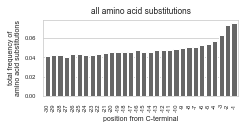

In [499]:
fig, ax = plt.subplots(figsize=(3.5,1.4))
plotDf = allChangesDf.loc[-30:].copy()
plotDf.index = plotDf.index.astype(int)
# plotDf.plot.bar(y='freq', color=sns.color_palette()[0], ax=ax, width=0.8)
plotDf.plot.bar(y='freq', color='0.4', ax=ax, width=0.8)
ax.set_title('all amino acid substitutions')
ax.set_xlabel('position from C-terminal')
ax.set_ylabel('total frequency of\namino acid substitutions')
ax.legend_.remove()
plt.grid(False, axis='x')
filename = 'transition freq cterm region all transitions'
plt.savefig(evolPath / 'results' / (filename + '.svg'))
plt.savefig(evolPath / 'results' / (filename + '.png'), dpi=300, bbox_inches='tight')

should include all possible transitions 20x20, and assign 0 counts, then merge with the total counts

In [509]:
countChangeDf2.to_csv(evolPath / 'countChangeDf2_{}.csv.gz'.format(aaGrouping), compression='gzip')

In [510]:
countChangeDf2.loc[idx[:, 'no_change', :], :].tail();

In [511]:
countChangeDf2.loc[idx['K', :, -1], :].sort_values('freq')

count  count_total      freq
MPR_aa_4 change_aa_ingroup msa_pos_from_cterm                              
K        P                 -1.0                  1.0        10150  0.000099
         Y                 -1.0                  1.0        10150  0.000099
         H                 -1.0                  3.0        10150  0.000296
         D                 -1.0                  4.0        10150  0.000394
         M                 -1.0                  4.0        10150  0.000394
         V                 -1.0                  4.0        10150  0.000394
         L                 -1.0                  5.0        10150  0.000493
         I                 -1.0                  7.0        10150  0.000690
         S                 -1.0                  8.0        10150  0.000788
         A                 -1.0                 10.0        10150  0.000985
         G                 -1.0                 10.0        10150  0.000985
         T                 -1.0                 26.0        10150  0.002562
         E                 -1.0                 75.0        10150  0.007389
         N                 -1.0                106.0        10150  0.010443
         Q                 -1.0                110.0        10150  0.010837
         R                 -1.0                158.0        10150  0.015567

In [512]:
countChangeDf2.loc[idx['R', :, -1], :].sort_values('freq')

count  count_total      freq
MPR_aa_4 change_aa_ingroup msa_pos_from_cterm                              
R        D                 -1.0                  2.0        10022  0.000200
         F                 -1.0                  3.0        10022  0.000299
         M                 -1.0                  3.0        10022  0.000299
         W                 -1.0                  3.0        10022  0.000299
         Y                 -1.0                  5.0        10022  0.000499
         I                 -1.0                  5.0        10022  0.000499
         T                 -1.0                  6.0        10022  0.000599
         E                 -1.0                  7.0        10022  0.000698
         A                 -1.0                 13.0        10022  0.001297
         N                 -1.0                 16.0        10022  0.001596
         C                 -1.0                 32.0        10022  0.003193
         L                 -1.0                 35.0        10022  0.003492
         P                 -1.0                 47.0        10022  0.004690
         S                 -1.0                 55.0        10022  0.005488
         G                 -1.0                 81.0        10022  0.008082
         Q                 -1.0                100.0        10022  0.009978
         K                 -1.0                105.0        10022  0.010477
         H                 -1.0                152.0        10022  0.015167

In [513]:
countChangeDf2.loc[idx['W', :, -1], :].sort_values('freq')

count  count_total      freq
MPR_aa_4 change_aa_ingroup msa_pos_from_cterm                              
W        C                 -1.0                  1.0         1276  0.000784
         F                 -1.0                  1.0         1276  0.000784
         H                 -1.0                  1.0         1276  0.000784
         I                 -1.0                  1.0         1276  0.000784
         M                 -1.0                  1.0         1276  0.000784
         N                 -1.0                  1.0         1276  0.000784
         Y                 -1.0                  1.0         1276  0.000784
         L                 -1.0                  2.0         1276  0.001567
         G                 -1.0                  3.0         1276  0.002351
         R                 -1.0                  7.0         1276  0.005486

In [514]:
countChangeDf2.loc[idx['L', :, -1], :].sort_values('freq')

count  count_total      freq
MPR_aa_4 change_aa_ingroup msa_pos_from_cterm                              
L        D                 -1.0                  1.0         8438  0.000119
         C                 -1.0                  2.0         8438  0.000237
         E                 -1.0                  3.0         8438  0.000356
         T                 -1.0                  3.0         8438  0.000356
         N                 -1.0                  3.0         8438  0.000356
         G                 -1.0                  4.0         8438  0.000474
         K                 -1.0                  7.0         8438  0.000830
         A                 -1.0                  8.0         8438  0.000948
         H                 -1.0                  8.0         8438  0.000948
         W                 -1.0                 10.0         8438  0.001185
         Q                 -1.0                 20.0         8438  0.002370
         S                 -1.0                 22.0         8438  0.002607
         M                 -1.0                 32.0         8438  0.003792
         R                 -1.0                 43.0         8438  0.005096
         P                 -1.0                 49.0         8438  0.005807
         F                 -1.0                 54.0         8438  0.006400
         V                 -1.0                 68.0         8438  0.008059
         I                 -1.0                 95.0         8438  0.011259

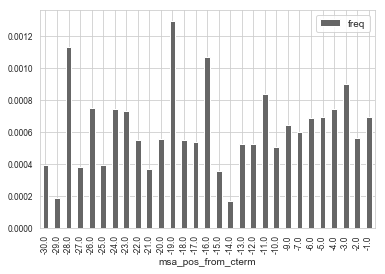

In [517]:
set_fontsize_screen()
plotDf = countChangeDf2.loc[idx['K', 'I']]
plotDf = plotDf[plotDf['count_total'] >= 100].loc[-30:]
plotDf.plot.bar(y='freq', color='0.4')

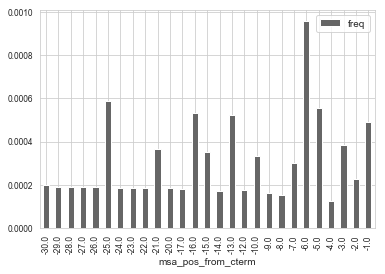

In [518]:
set_fontsize_screen()
plotDf = countChangeDf2.loc[idx['K', 'L']]
plotDf = plotDf[plotDf['count_total'] >= 100].loc[-30:]
plotDf.plot.bar(y='freq', color='0.4')

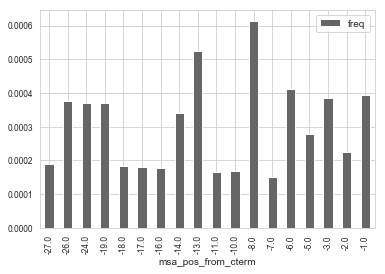

In [521]:
set_fontsize_screen()
plotDf = countChangeDf2.loc[idx['K', 'V']]
plotDf = plotDf[plotDf['count_total'] >= 100].loc[-30:]
plotDf.plot.bar(y='freq', color='0.4')

### group by 4 amino acid groups

In [530]:
aaGrouping = 'aa_4groups'

In [531]:
aaGroups = {
    'K':'positively charged',
    'R':'positively charged',
    'H':'other',
    'D':'other',
    'E':'other',
    'N':'other',
    'Q':'other',
    'S':'other',
    'T':'T',
    'P':'other',
    'C':'other',
    'G':'other',
    'A':'hydrophobic',
    'I':'hydrophobic',
    'L':'hydrophobic',
    'M':'hydrophobic',
    'F':'hydrophobic',
    'W':'hydrophobic',
    'Y':'hydrophobic',
    'V':'hydrophobic'
}
len(aaGroups)

20

In [532]:
from itertools import permutations

In [533]:
transitions = list(permutations(set(aaGroups.values()), 2)) + [(group, group) for group in set(aaGroups.values())]
transitions = [t for t in transitions if t != ('T', 'T')]
transitions

[('hydrophobic', 'T'),
 ('hydrophobic', 'other'),
 ('hydrophobic', 'positively charged'),
 ('T', 'hydrophobic'),
 ('T', 'other'),
 ('T', 'positively charged'),
 ('other', 'hydrophobic'),
 ('other', 'T'),
 ('other', 'positively charged'),
 ('positively charged', 'hydrophobic'),
 ('positively charged', 'T'),
 ('positively charged', 'other'),
 ('hydrophobic', 'hydrophobic'),
 ('other', 'other'),
 ('positively charged', 'positively charged')]

In [545]:
len(transitions)

15

In [534]:
transitionDf4['MPR_aa_4_group'] = transitionDf4['MPR_aa_4'].map(aaGroups)
transitionDf4['change_aa_ingroup_group'] = transitionDf4['change_aa_ingroup'].map(aaGroups)

In [535]:
df = transitionDf4
df2 = df[(df['change_type'] == 'only_one_ingroup') | (df['change_type'] == 'no_change')].copy()
print(len(df2))
countTotalGroupDf =  df2.groupby(['MPR_aa_4_group', 'msa_pos_from_cterm'])['ATGC_id'].count()
countTotalGroupDf.name = 'count_total'
countTotalGroupDf.tail()

34905840


MPR_aa_4_group      msa_pos_from_cterm
positively charged  -5.0                  15025
                    -4.0                  16642
                    -3.0                  15629
                    -2.0                  17631
                    -1.0                  20172
Name: count_total, dtype: int64

In [536]:
df = transitionDf4
df3 = df[(df['change_type'] == 'only_one_ingroup')].copy()
print(len(df3))
countChangeGroupDf = df3.groupby(['MPR_aa_4_group', 'change_aa_ingroup_group', 'msa_pos_from_cterm'])['ATGC_id'].count()
countChangeGroupDf.name = 'count'
print(len(countChangeGroupDf))
countChangeGroupDf = countChangeGroupDf.to_frame()
countChangeGroupDf.head()

1411062
27073


count
MPR_aa_4_group change_aa_ingroup_group msa_pos_from_cterm       
T              hydrophobic             -6226.0                 1
                                       -6199.0                 1
                                       -6127.0                 1
                                       -5902.0                 1
                                       -5610.0                 1

In [537]:
countChangeGroupDf.reset_index().tail()

,MPR_aa_4_group,change_aa_ingroup_group,msa_pos_from_cterm,count
27068,positively charged,positively charged,-5.0,213
27069,positively charged,positively charged,-4.0,272
27070,positively charged,positively charged,-3.0,239
27071,positively charged,positively charged,-2.0,303
27072,positively charged,positively charged,-1.0,263


In [538]:
countTotalGroupDf.to_frame().reset_index().tail()

,MPR_aa_4_group,msa_pos_from_cterm,count_total
19559,positively charged,-5.0,15025
19560,positively charged,-4.0,16642
19561,positively charged,-3.0,15629
19562,positively charged,-2.0,17631
19563,positively charged,-1.0,20172


In [539]:
countChangeGroupDf2 = pd.merge(countChangeGroupDf.reset_index(),
                               countTotalGroupDf.to_frame().reset_index(),
                          on=['MPR_aa_4_group', 'msa_pos_from_cterm'], how='outer')
print(len(countChangeGroupDf2))
# for sites where we only have no_change, assign 0 counts
countChangeGroupDf2['count'] = countChangeGroupDf2['count'].fillna(0)
countChangeGroupDf2['freq'] = countChangeGroupDf2['count'] / countChangeGroupDf2['count_total']
countChangeGroupDf2['change_aa_ingroup_group'] = countChangeGroupDf2['change_aa_ingroup_group'].fillna('no_change')
countChangeGroupDf2 = countChangeGroupDf2.set_index(['MPR_aa_4_group', 'change_aa_ingroup_group', 'msa_pos_from_cterm']).sort_index()
countChangeGroupDf2.tail()

35175


count  \
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm          
positively charged positively charged      -5.0                213.0   
                                           -4.0                272.0   
                                           -3.0                239.0   
                                           -2.0                303.0   
                                           -1.0                263.0   

                                                               count_total  \
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm                
positively charged positively charged      -5.0                      15025   
                                           -4.0                      16642   
                                           -3.0                      15629   
                                           -2.0                      17631   
                                           -1.0                      20172   

                                                                   freq  
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm            
positively charged positively charged      -5.0                0.014176  
                                           -4.0                0.016344  
                                           -3.0                0.015292  
                                           -2.0                0.017186  
                                           -1.0                0.013038

In [540]:
countChangeGroupDf2.loc[idx['positively charged', 'no_change', :], :].tail(3)

count  \
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm          
positively charged no_change               -1174.0               0.0   
                                           -1156.0               0.0   
                                           -1149.0               0.0   

                                                               count_total  \
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm                
positively charged no_change               -1174.0                      65   
                                           -1156.0                      78   
                                           -1149.0                      67   

                                                               freq  
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm        
positively charged no_change               -1174.0              0.0  
                                           -1156.0              0.0  
                                           -1149.0              0.0

In [464]:
cmap = sns.cubehelix_palette(2, as_cmap=True)
cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)

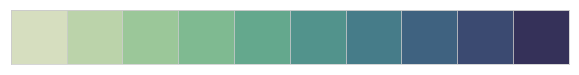

In [465]:
sns.palplot([cmap(x) for x in np.arange(0, 1, 0.1)])

In [466]:
from mwTools.plot import convert_colormap_to_hex
convert_colormap_to_hex(cmap, x=0.4, vmin=0, vmax=1)

'#65a88e'

In [467]:
convert_colormap_to_hex(cmap, x=0, vmin=0, vmax=1)

'#d7dfc0'

In [544]:
countChangeGroupDf2.loc[idx[:, :, -1], :]['count'].describe()

count      15.000000
mean      508.000000
std       602.778211
min        15.000000
25%       102.500000
50%       263.000000
75%       713.000000
max      2049.000000
Name: count, dtype: float64

In [468]:
df = countChangeGroupDf2.loc[idx[:, :, -1], :].sort_values('freq').copy()
# df['thickness'] = df['freq']*
df['color'] = df['freq'].map(lambda x: convert_colormap_to_hex(cmap, x, vmin=0, vmax=0.08))
df

count  \
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm           
positively charged T                       -1.0                  32.0   
other              T                       -1.0                 107.0   
hydrophobic        positively charged      -1.0                 115.0   
positively charged hydrophobic             -1.0                  98.0   
hydrophobic        T                       -1.0                 297.0   
T                  positively charged      -1.0                  15.0   
positively charged positively charged      -1.0                 263.0   
other              positively charged      -1.0                 656.0   
                   hydrophobic             -1.0                 713.0   
hydrophobic        other                   -1.0                 713.0   
                   hydrophobic             -1.0                1564.0   
positively charged other                   -1.0                 809.0   
T                  other                   -1.0                  73.0   
other              other                   -1.0                2049.0   
T                  hydrophobic             -1.0                 116.0   

                                                               count_total  \
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm                
positively charged T                       -1.0                      20172   
other              T                       -1.0                      41135   
hydrophobic        positively charged      -1.0                      39019   
positively charged hydrophobic             -1.0                      20172   
hydrophobic        T                       -1.0                      39019   
T                  positively charged      -1.0                       1488   
positively charged positively charged      -1.0                      20172   
other              positively charged      -1.0                      41135   
                   hydrophobic             -1.0                      41135   
hydrophobic        other                   -1.0                      39019   
                   hydrophobic             -1.0                      39019   
positively charged other                   -1.0                      20172   
T                  other                   -1.0                       1488   
other              other                   -1.0                      41135   
T                  hydrophobic             -1.0                       1488   

                                                                   freq  \
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm             
positively charged T                       -1.0                0.001586   
other              T                       -1.0                0.002601   
hydrophobic        positively charged      -1.0                0.002947   
positively charged hydrophobic             -1.0                0.004858   
hydrophobic        T                       -1.0                0.007612   
T                  positively charged      -1.0                0.010081   
positively charged positively charged      -1.0                0.013038   
other              positively charged      -1.0                0.015947   
                   hydrophobic             -1.0                0.017333   
hydrophobic        other                   -1.0                0.018273   
                   hydrophobic             -1.0                0.040083   
positively charged other                   -1.0                0.040105   
T                  other                   -1.0                0.049059   
other              other                   -1.0                0.049812   
T                  hydrophobic             -1.0                0.077957   

                                                                 color  
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm           
positively charged T                       -1.0                #d2ddbc  


In [541]:
countChangeGroupDf2.loc[idx['hydrophobic', :, -1], :].sort_values('freq')

count  \
MPR_aa_4_group change_aa_ingroup_group msa_pos_from_cterm           
hydrophobic    positively charged      -1.0                 115.0   
               T                       -1.0                 297.0   
               other                   -1.0                 713.0   
               hydrophobic             -1.0                1564.0   

                                                           count_total  \
MPR_aa_4_group change_aa_ingroup_group msa_pos_from_cterm                
hydrophobic    positively charged      -1.0                      39019   
               T                       -1.0                      39019   
               other                   -1.0                      39019   
               hydrophobic             -1.0                      39019   

                                                               freq  
MPR_aa_4_group change_aa_ingroup_group msa_pos_from_cterm            
hydrophobic    positively charged      -1.0                0.002947  
               T                       -1.0                0.007612  
               other                   -1.0                0.018273  
               hydrophobic             -1.0                0.040083

In [542]:
countChangeGroupDf2 = countChangeGroupDf2.sort_index()

In [543]:
countChangeGroupDf2.to_csv(evolPath / 'countChangeGroupDf2_{}.csv.gz'.format(aaGrouping), compression='gzip')

In [471]:
df = countChangeGroupDf2.loc[idx['positively charged', :, -100:-50], :].reset_index()\
     .groupby(['MPR_aa_4_group', 'change_aa_ingroup_group'])[['count', 'count_total']].sum()
df['freq'] = df['count'] / df['count_total']
df

count  count_total      freq
MPR_aa_4_group     change_aa_ingroup_group                                
positively charged T                         1096.0       550767  0.001990
                   hydrophobic               1637.0       550767  0.002972
                   other                    10883.0       550767  0.019760
                   positively charged        6696.0       550767  0.012158

In [472]:
countChangeGroupDf2.loc[idx['hydrophobic', :, -100], :].sort_values('freq')

count  \
MPR_aa_4_group change_aa_ingroup_group msa_pos_from_cterm           
hydrophobic    positively charged      -100.0                36.0   
               T                       -100.0               199.0   
               other                   -100.0               346.0   
               hydrophobic             -100.0              1026.0   

                                                           count_total  \
MPR_aa_4_group change_aa_ingroup_group msa_pos_from_cterm                
hydrophobic    positively charged      -100.0                    45295   
               T                       -100.0                    45295   
               other                   -100.0                    45295   
               hydrophobic             -100.0                    45295   

                                                               freq  
MPR_aa_4_group change_aa_ingroup_group msa_pos_from_cterm            
hydrophobic    positively charged      -100.0              0.000795  
               T                       -100.0              0.004393  
               other                   -100.0              0.007639  
               hydrophobic             -100.0              0.022652

In [473]:
set_fontsize_paper()

In [486]:
dfList = []
for transition in transitions[:]:
    plotDf = countChangeGroupDf2.loc[idx[transition[0], transition[1]]].copy()
    plotDf = plotDf[plotDf['count_total'] >= 100].loc[-30:]
    plotDf.index = plotDf.index.astype(int)
    contingency = [plotDf.loc[-1][['count', 'count_total']].values.tolist(),
                   plotDf.loc[-2][['count', 'count_total']].values.tolist()]
    print(contingency)
    oddsRatioScipy, pvalue = scipy.stats.fisher_exact(contingency, alternative='two-sided')
    dfList.append({'MPR_aa_4_group':transition[0], 'change_aa_ingroup_group':transition[1],'odds ratio':oddsRatioScipy, 'pvalue':pvalue})
fisherDf = pd.DataFrame(dfList).set_index(['MPR_aa_4_group', 'change_aa_ingroup_group'])
fisherDf

[[297.0, 39019.0], [518.0, 39859.0]]
[[713.0, 39019.0], [658.0, 39859.0]]
[[115.0, 39019.0], [63.0, 39859.0]]
[[116.0, 1488.0], [352.0, 4549.0]]
[[73.0, 1488.0], [189.0, 4549.0]]
[[15.0, 1488.0], [47.0, 4549.0]]
[[713.0, 41135.0], [622.0, 40645.0]]
[[107.0, 41135.0], [215.0, 40645.0]]
[[656.0, 41135.0], [517.0, 40645.0]]
[[98.0, 20172.0], [66.0, 17631.0]]
[[32.0, 20172.0], [55.0, 17631.0]]
[[809.0, 20172.0], [563.0, 17631.0]]
[[1564.0, 39019.0], [1546.0, 39859.0]]
[[2049.0, 41135.0], [1755.0, 40645.0]]
[[263.0, 20172.0], [303.0, 17631.0]]


odds ratio        pvalue
MPR_aa_4_group     change_aa_ingroup_group                          
hydrophobic        T                          0.585702  1.057943e-13
                   other                      1.106914  6.395374e-02
                   positively charged         1.864694  6.208751e-05
T                  hydrophobic                1.007461  9.556187e-01
                   other                      1.180794  2.424549e-01
                   positively charged         0.975678  1.000000e+00
other              hydrophobic                1.132648  2.539005e-02
                   T                          0.491746  8.147094e-10
                   positively charged         1.253744  1.306016e-04
positively charged hydrophobic                1.297807  1.164555e-01
                   T                          0.508528  2.414005e-03
                   other                      1.255938  4.478206e-05
hydrophobic        hydrophobic                1.033422  3.703885e-01
other              other                      1.153614  1.729835e-05
positively charged positively charged         0.758649  1.240570e-03

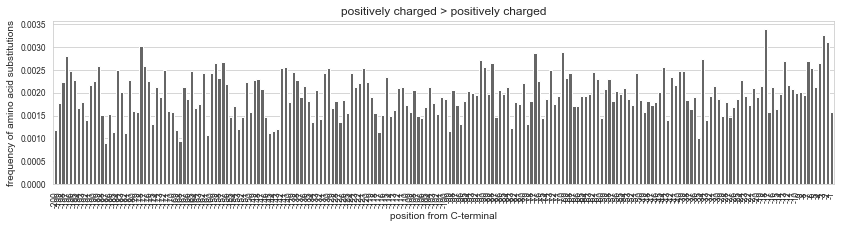

In [529]:
fig, ax = plt.subplots(figsize=(14,3))
plotDf = countChangeGroupDf2.loc[idx['positively charged', 'T']].copy()
plotDf = plotDf[plotDf['count_total'] >= 100].loc[-200:]
plotDf.index = plotDf.index.astype(int)
#     plotDf.plot.bar(y='freq', color=sns.color_palette()[0], ax=ax, width=0.8)
plotDf.plot.bar(y='freq', color='0.4', ax=ax, width=0.8)
ax.set_title(' > '.join(transition))
ax.set_xlabel('position from C-terminal')
ax.set_ylabel('frequency of amino acid substitutions')
ax.legend_.remove()
plt.grid(False, axis='x')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

-2 v.s. -1: Custom statistical test, P_val:1.058e-13
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

-2 v.s. -1: Custom statistical test, P_val:6.395e-02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

-2 v.s. -1: Custom statistical test, P_val:6.209e-05
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

-2 v.s. -1: Custom statistical test, P_val:9.556e-01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <

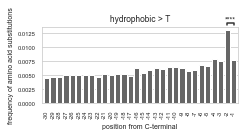

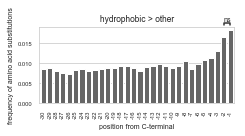

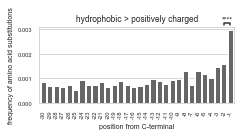

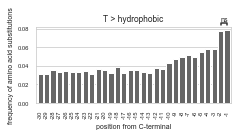

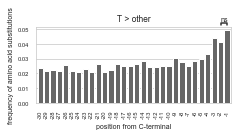

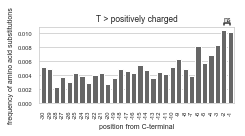

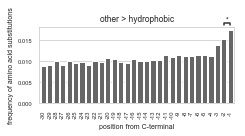

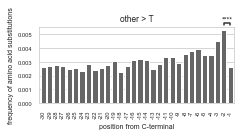

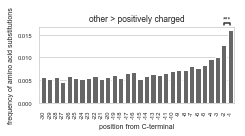

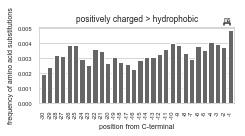

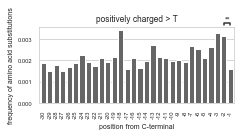

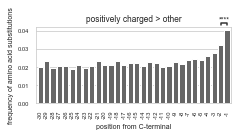

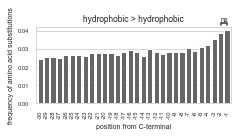

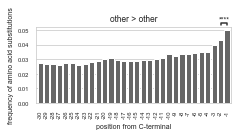

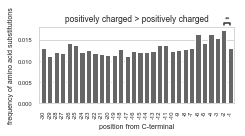

In [498]:
for transition in transitions[:]:
    fig, ax = plt.subplots(figsize=(3.5,1.4))
    plotDf = countChangeGroupDf2.loc[idx[transition[0], transition[1]]].copy()
    plotDf = plotDf[plotDf['count_total'] >= 100].loc[-30:]
    plotDf.index = plotDf.index.astype(int)
#     plotDf.plot.bar(y='freq', color=sns.color_palette()[0], ax=ax, width=0.8)
    plotDf.plot.bar(y='freq', color='0.4', ax=ax, width=0.8)
    ax.set_title(' > '.join(transition))
    ax.set_xlabel('position from C-terminal')
    ax.set_ylabel('frequency of amino acid substitutions')
    ax.legend_.remove()
    plt.grid(False, axis='x')
    add_stat_annotation(ax, data=plotDf.reset_index(), x='msa_pos_from_cterm', y='freq', plot='barplot',
                        box_pairs=[(-2, -1)],
                        perform_stat_test=False, pvalues=[fisherDf.loc[(transition[0], transition[1]), 'pvalue']],
                        test_short_name='', loc='outside',
                        text_format='star', verbose=2)
    filename = '{} transition freq cterm region {} to {}'.format(aaGrouping, transition[0], transition[1])
    plt.savefig(evolPath / 'results' / (filename + '.svg'))
    plt.savefig(evolPath / 'results' / (filename + '.png'), dpi=300, bbox_inches='tight')

In [557]:
transitions = [
    ('hydrophobic', 'hydrophobic'),
    ('hydrophobic', 'T'),
 ('hydrophobic', 'other'),
 ('hydrophobic', 'positively charged'),
    ('T', 'T'),
 ('T', 'hydrophobic'),
 ('T', 'other'),
 ('T', 'positively charged'),
    ('other', 'other'),
 ('other', 'hydrophobic'),
 ('other', 'T'),
 ('other', 'positively charged'),
    ('positively charged', 'positively charged'),
 ('positively charged', 'hydrophobic'),
 ('positively charged', 'T'),
 ('positively charged', 'other'),
 ]
transitions

[('hydrophobic', 'hydrophobic'),
 ('hydrophobic', 'T'),
 ('hydrophobic', 'other'),
 ('hydrophobic', 'positively charged'),
 ('T', 'T'),
 ('T', 'hydrophobic'),
 ('T', 'other'),
 ('T', 'positively charged'),
 ('other', 'other'),
 ('other', 'hydrophobic'),
 ('other', 'T'),
 ('other', 'positively charged'),
 ('positively charged', 'positively charged'),
 ('positively charged', 'hydrophobic'),
 ('positively charged', 'T'),
 ('positively charged', 'other')]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

-2 v.s. -1: Custom statistical test, P_val:3.704e-01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

-2 v.s. -1: Custom statistical test, P_val:1.730e-05
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

-2 v.s. -1: Custom statistical test, P_val:1.241e-03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

-2 v.s. -1: Custom statistical test, P_val:1.058e-13
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <

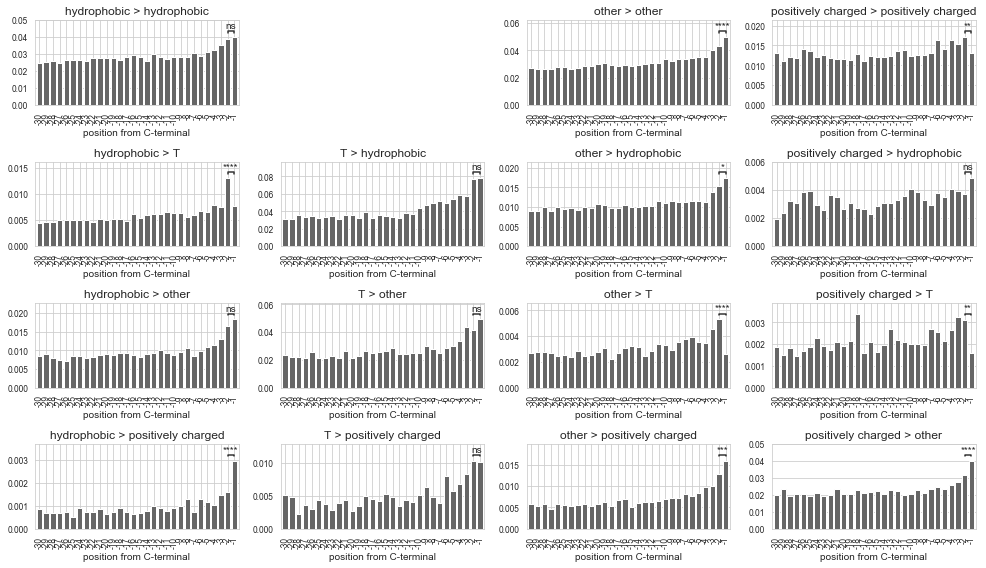

In [564]:
w, h = (3.5, 2)
fig, axes = plt.subplots(4, 4, figsize=(4*w, 4*h))

for i in range(4):
    for j in range(4):
        transition = transitions[i + 4*j]
        ax = axes[i][j]
        if transition != ('T', 'T'):
            plotDf = countChangeGroupDf2.loc[idx[transition[0], transition[1]]].copy()
            plotDf = plotDf[plotDf['count_total'] >= 100].loc[-30:]
            plotDf.index = plotDf.index.astype(int)
            plotDf.plot.bar(y='freq', color='0.4', ax=ax, width=0.8)
            ax.set_title(' > '.join(transition))
            ax.set_xlabel('position from C-terminal')
            ax.set_ylabel('frequency of amino acid substitutions')
            ax.legend_.remove()
            plt.grid(False, axis='x')
            add_stat_annotation(ax, data=plotDf.reset_index(), x='msa_pos_from_cterm', y='freq', plot='barplot',
                                box_pairs=[(-2, -1)],
                                perform_stat_test=False, pvalues=[fisherDf.loc[(transition[0], transition[1]), 'pvalue']],
                                test_short_name='', loc='inside',
                                text_format='star', verbose=2)
            ax.set_ylabel('')
        else:
            ax.set_axis_off()
plt.tight_layout()
filename = '{} transition freq cterm region all transitions'.format(aaGrouping)
plt.savefig(evolPath / 'results' / (filename + '.svg'))
plt.savefig(evolPath / 'results' / (filename + '.png'), dpi=300, bbox_inches='tight')

### compute change in rate from -2 to -1

In [411]:
countChangeGroupDf2.loc[idx[:, :, -1], :]

count  \
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm           
T                  hydrophobic             -1.0                 116.0   
                   other                   -1.0                  73.0   
                   positively charged      -1.0                  15.0   
hydrophobic        T                       -1.0                 297.0   
                   hydrophobic             -1.0                1564.0   
                   other                   -1.0                 713.0   
                   positively charged      -1.0                 115.0   
other              T                       -1.0                 107.0   
                   hydrophobic             -1.0                 713.0   
                   other                   -1.0                2049.0   
                   positively charged      -1.0                 656.0   
positively charged T                       -1.0                  32.0   
                   hydrophobic             -1.0                  98.0   
                   other                   -1.0                 809.0   
                   positively charged      -1.0                 263.0   

                                                               count_total  \
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm                
T                  hydrophobic             -1.0                       1488   
                   other                   -1.0                       1488   
                   positively charged      -1.0                       1488   
hydrophobic        T                       -1.0                      39019   
                   hydrophobic             -1.0                      39019   
                   other                   -1.0                      39019   
                   positively charged      -1.0                      39019   
other              T                       -1.0                      41135   
                   hydrophobic             -1.0                      41135   
                   other                   -1.0                      41135   
                   positively charged      -1.0                      41135   
positively charged T                       -1.0                      20172   
                   hydrophobic             -1.0                      20172   
                   other                   -1.0                      20172   
                   positively charged      -1.0                      20172   

                                                                   freq  
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm            
T                  hydrophobic             -1.0                0.077957  
                   other                   -1.0                0.049059  
                   positively charged      -1.0                0.010081  
hydrophobic        T                       -1.0                0.007612  
                   hydrophobic             -1.0                0.040083  
                   other                   -1.0                0.018273  
                   positively charged      -1.0                0.002947  
other              T                       -1.0                0.002601  
                   hydrophobic             -1.0                0.017333  
                   other                   -1.0                0.049812  
                   positively charged      -1.0                0.015947  
positively charged T                       -1.0                0.001586  
                   hydrophobic             -1.0                0.004858  
                   other                   -1.0                0.040105  
                   positively charged      -1.0                0.013038

In [412]:
countChangeGroupDf2.loc[idx[:, :, -2], :]

count  \
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm           
T                  hydrophobic             -2.0                 352.0   
                   other                   -2.0                 189.0   
                   positively charged      -2.0                  47.0   
hydrophobic        T                       -2.0                 518.0   
                   hydrophobic             -2.0                1546.0   
                   other                   -2.0                 658.0   
                   positively charged      -2.0                  63.0   
other              T                       -2.0                 215.0   
                   hydrophobic             -2.0                 622.0   
                   other                   -2.0                1755.0   
                   positively charged      -2.0                 517.0   
positively charged T                       -2.0                  55.0   
                   hydrophobic             -2.0                  66.0   
                   other                   -2.0                 563.0   
                   positively charged      -2.0                 303.0   

                                                               count_total  \
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm                
T                  hydrophobic             -2.0                       4549   
                   other                   -2.0                       4549   
                   positively charged      -2.0                       4549   
hydrophobic        T                       -2.0                      39859   
                   hydrophobic             -2.0                      39859   
                   other                   -2.0                      39859   
                   positively charged      -2.0                      39859   
other              T                       -2.0                      40645   
                   hydrophobic             -2.0                      40645   
                   other                   -2.0                      40645   
                   positively charged      -2.0                      40645   
positively charged T                       -2.0                      17631   
                   hydrophobic             -2.0                      17631   
                   other                   -2.0                      17631   
                   positively charged      -2.0                      17631   

                                                                   freq  
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm            
T                  hydrophobic             -2.0                0.077380  
                   other                   -2.0                0.041548  
                   positively charged      -2.0                0.010332  
hydrophobic        T                       -2.0                0.012996  
                   hydrophobic             -2.0                0.038787  
                   other                   -2.0                0.016508  
                   positively charged      -2.0                0.001581  
other              T                       -2.0                0.005290  
                   hydrophobic             -2.0                0.015303  
                   other                   -2.0                0.043179  
                   positively charged      -2.0                0.012720  
positively charged T                       -2.0                0.003120  
                   hydrophobic             -2.0                0.003743  
                   other                   -2.0                0.031932  
                   positively charged      -2.0                0.017186

In [427]:
df = (countChangeGroupDf2.loc[idx[:, :, -1], :].reset_index(level=2)['freq']
/ countChangeGroupDf2.loc[idx[:, :, -2], :].reset_index(level=2)['freq']).to_frame()
df

freq
MPR_aa_4_group     change_aa_ingroup_group          
T                  hydrophobic              1.007461
                   other                    1.180794
                   positively charged       0.975678
hydrophobic        T                        0.585702
                   hydrophobic              1.033422
                   other                    1.106914
                   positively charged       1.864694
other              T                        0.491746
                   hydrophobic              1.132648
                   other                    1.153614
                   positively charged       1.253744
positively charged T                        0.508528
                   hydrophobic              1.297807
                   other                    1.255938
                   positively charged       0.758649

In [550]:
cmap = cmap = get_divergent_color_map(name="RdBu_r")

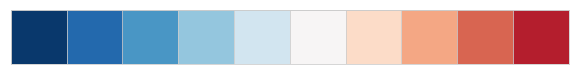

In [551]:
sns.palplot([cmap(x) for x in np.arange(0, 1, 0.1)])

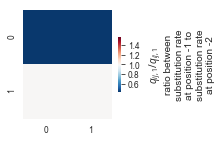

In [552]:
fig, ax = plt.subplots(figsize=(2,2))
sns.heatmap(np.array([[0, 0], [1, 1]]), cmap=cmap, vmin=1-vrange, vmax=1+vrange,
            ax=ax, cbar_kws=dict(shrink=0.5, label='$q_{ij,1}/q_{ij,1}$\nratio between\nsubstitution rate\nat position -1 to\nsubstitution rate\nat position -2'))
plt.savefig(evolPath / 'results' / ('color_bar.svg'))

In [425]:
from mwTools.plot import convert_colormap_to_hex
convert_colormap_to_hex(cmap, x=0.5, vmin=0, vmax=1)

'#f7f6f5'

In [426]:
convert_colormap_to_hex(cmap, x=0, vmin=0, vmax=1)

'#09386d'

In [428]:
vrange = 0.55
df['color'] = df['freq'].map(lambda x: convert_colormap_to_hex(cmap, x, vmin=1-vrange, vmax=1+vrange))
df

freq    color
MPR_aa_4_group     change_aa_ingroup_group                   
T                  hydrophobic              1.007461  #f7f5f3
                   other                    1.180794  #f7b99c
                   positively charged       0.975678  #eff3f5
hydrophobic        T                        0.585702  #2d75b4
                   hydrophobic              1.033422  #f9efe9
                   other                    1.106914  #fdddcb
                   positively charged       1.864694  #730421
other              T                        0.491746  #134a86
                   hydrophobic              1.132648  #fcd3bc
                   other                    1.153614  #fac7ae
                   positively charged       1.253744  #ec9374
positively charged T                        0.508528  #175291
                   hydrophobic              1.297807  #e0775f
                   other                    1.255938  #ec9374
                   positively charged       0.758649  #87beda

In [417]:
(countChangeGroupDf2.loc[idx[:, :, -1], :].reset_index(level=2)['freq']
/ countChangeGroupDf2.loc[idx[:, :, -3], :].reset_index(level=2)['freq']).to_frame()

freq
MPR_aa_4_group     change_aa_ingroup_group          
T                  hydrophobic              1.353176
                   other                    1.116596
                   positively charged       1.215399
hydrophobic        T                        1.008651
                   hydrophobic              1.136472
                   other                    1.408606
                   positively charged       2.019901
other              T                        0.574535
                   hydrophobic              1.246469
                   other                    1.249923
                   positively charged       1.590752
positively charged T                        0.486141
                   hydrophobic              1.224663
                   other                    1.447581
                   positively charged       0.852590

## Abundance data

### ATGC taxonomy

In [435]:
dfList = []
for ATGC_id, genome in ATGCGenomeDf[:].iteritems():
    print(ATGC_id, genome)
    genomePath = ATGCPath / 'rawdatafiles' / 'genomeassemblies' / genome
    df = pd.read_csv(genomePath / '{}.proteintable.txt'.format(genome), sep='\t').rename(columns={'accession.version':'refseq_id'})
    cols = list(df.columns)
    cols[0] = "protein_id"
    df.columns = cols
    df['ATGC_id'] = ATGC_id
    df['genome'] = genome
    dfList.append(df)
    del df
ATGCProteinDf = pd.concat(dfList)

ATGC001 Citrobacter_FDAARGOS_156.GCF_001559235.1
ATGC001 Citrobacter_amalonaticus.GCF_001558935.1
ATGC001 Citrobacter_amalonaticus.GCF_001559075.1
ATGC001 Citrobacter_amalonaticus_Y19.GCF_000981805.1
ATGC001 Citrobacter_freundii.GCF_001022155.1
ATGC001 Citrobacter_freundii.GCF_001022275.1
ATGC001 Citrobacter_freundii.GCF_001281005.1
ATGC001 Citrobacter_freundii_CFNIH1.GCF_000648515.1
ATGC001 Citrobacter_koseri_ATCC_BAA_895.GCF_000018045.1
ATGC001 Citrobacter_rodentium_ICC168.GCF_000027085.1
ATGC001 Cronobacter_condimenti_1330.GCF_001277255.1
ATGC001 Cronobacter_dublinensis_dublinensis_LMG_23823.GCF_001277235.1
ATGC001 Cronobacter_malonaticus_LMG_23826.GCF_001277215.2
ATGC001 Cronobacter_muytjensii_ATCC_51329.GCF_001277195.1
ATGC001 Cronobacter_sakazakii.GCF_000982825.1
ATGC001 Cronobacter_sakazakii.GCF_001277275.1
ATGC001 Cronobacter_sakazakii_ATCC_BAA_894.GCF_000017665.1
ATGC001 Cronobacter_sakazakii_CMCC_45402.GCF_000504545.1
ATGC001 Cronobacter_sakazakii_ES15.GCF_000263215.1
ATGC001

ATGC001 Escherichia_coli_O104_H4_2009EL_2050.GCF_000299255.1
ATGC001 Escherichia_coli_O104_H4_2009EL_2071.GCF_000299475.1
ATGC001 Escherichia_coli_O104_H4_2011C_3493.GCF_000299455.1
ATGC001 Escherichia_coli_O104_H4_C227_11.GCF_000986765.1
ATGC001 Escherichia_coli_O111_H_11128.GCF_000010765.1
ATGC001 Escherichia_coli_O127_H6_E2348_69.GCF_000026545.1
ATGC001 Escherichia_coli_O139_H28_E24377A.GCF_000017745.1
ATGC001 Escherichia_coli_O145_H28_RM12581.GCF_000671295.1
ATGC001 Escherichia_coli_O145_H28_RM12761.GCF_000662395.1
ATGC001 Escherichia_coli_O145_H28_RM13514.GCF_000520035.1
ATGC001 Escherichia_coli_O145_H28_RM13516.GCF_000520055.1
ATGC001 Escherichia_coli_O157_H16.GCF_000827105.1
ATGC001 Escherichia_coli_O157_H7.GCF_001307215.1
ATGC001 Escherichia_coli_O157_H7_EC4115.GCF_000021125.1
ATGC001 Escherichia_coli_O157_H7_EDL933.GCF_000732965.1
ATGC001 Escherichia_coli_O157_H7_SS17.GCF_000730345.1
ATGC001 Escherichia_coli_O157_H7_SS52.GCF_000803705.1
ATGC001 Escherichia_coli_O157_H7_Sakai.G

ATGC001 Salmonella_enterica_enterica_serovar_Enteritidis_str_EC20111174.GCF_000626355.1
ATGC001 Salmonella_enterica_enterica_serovar_Enteritidis_str_EC20111175.GCF_000626335.1
ATGC001 Salmonella_enterica_enterica_serovar_Enteritidis_str_EC20120002.GCF_000624395.2
ATGC001 Salmonella_enterica_enterica_serovar_Enteritidis_str_EC20120005.GCF_000623195.2
ATGC001 Salmonella_enterica_enterica_serovar_Enteritidis_str_EC20120008.GCF_000626195.1
ATGC001 Salmonella_enterica_enterica_serovar_Enteritidis_str_EC20120200.GCF_000626095.2
ATGC001 Salmonella_enterica_enterica_serovar_Enteritidis_str_EC20120916.GCF_000624155.1
ATGC001 Salmonella_enterica_enterica_serovar_Enteritidis_str_EC20121175.GCF_000623055.1
ATGC001 Salmonella_enterica_enterica_serovar_Enteritidis_str_EC20121177.GCF_000624175.1
ATGC001 Salmonella_enterica_enterica_serovar_Enteritidis_str_EC20121178.GCF_000623095.1
ATGC001 Salmonella_enterica_enterica_serovar_Enteritidis_str_EC20121179.GCF_000623115.2
ATGC001 Salmonella_enterica_ente

ATGC001 Salmonella_enterica_enterica_serovar_Typhimurium_str_T000240.GCF_000283735.1
ATGC001 Salmonella_enterica_enterica_serovar_Typhimurium_str_U288.GCF_000380325.1
ATGC001 Salmonella_enterica_enterica_serovar_Typhimurium_str_UK_1.GCF_000213635.1
ATGC001 Salmonella_enterica_enterica_serovar_Typhimurium_str_USDA_ARS_USMARC_1808.GCF_001623725.1
ATGC001 Salmonella_enterica_enterica_serovar_Typhimurium_str_USDA_ARS_USMARC_1810.GCF_001623745.1
ATGC001 Salmonella_enterica_enterica_serovar_Typhimurium_str_USDA_ARS_USMARC_1880.GCF_001623705.1
ATGC001 Salmonella_enterica_enterica_serovar_Typhimurium_str_USDA_ARS_USMARC_1896.GCF_001623845.1
ATGC001 Salmonella_enterica_enterica_serovar_Typhimurium_str_USDA_ARS_USMARC_1898.GCF_001623765.1
ATGC001 Salmonella_enterica_enterica_serovar_Typhimurium_str_USDA_ARS_USMARC_1899.GCF_000941015.1
ATGC001 Salmonella_enterica_enterica_serovar_Typhimurium_var_5_str_CFSAN001921.GCF_000430145.2
ATGC001 Salmonella_enterica_enterica_serovar_Weltevreden.GCF_0014091

ATGC004 Streptococcus_dysgalactiae_equisimilis_ATCC_12394.GCF_000188715.1
ATGC004 Streptococcus_dysgalactiae_equisimilis_GGS_124.GCF_000010705.1
ATGC004 Streptococcus_dysgalactiae_equisimilis_RE378.GCF_000307185.1
ATGC004 Streptococcus_pyogenes.GCF_000743015.1
ATGC004 Streptococcus_pyogenes.GCF_000756485.1
ATGC004 Streptococcus_pyogenes.GCF_000767505.1
ATGC004 Streptococcus_pyogenes.GCF_000772185.1
ATGC004 Streptococcus_pyogenes.GCF_000772245.1
ATGC004 Streptococcus_pyogenes.GCF_000993765.1
ATGC004 Streptococcus_pyogenes.GCF_001014305.1
ATGC004 Streptococcus_pyogenes.GCF_001019635.1
ATGC004 Streptococcus_pyogenes.GCF_001019675.1
ATGC004 Streptococcus_pyogenes.GCF_001019695.1
ATGC004 Streptococcus_pyogenes.GCF_001020185.1
ATGC004 Streptococcus_pyogenes.GCF_001021955.1
ATGC004 Streptococcus_pyogenes.GCF_001023495.1
ATGC004 Streptococcus_pyogenes.GCF_001039695.1
ATGC004 Streptococcus_pyogenes.GCF_001051095.1
ATGC004 Streptococcus_pyogenes.GCF_001267805.1
ATGC004 Streptococcus_pyogenes.GCF

ATGC014 Bacillus_anthracis.GCF_000832565.1
ATGC014 Bacillus_anthracis.GCF_000832585.1
ATGC014 Bacillus_anthracis.GCF_000832665.1
ATGC014 Bacillus_anthracis.GCF_000832725.1
ATGC014 Bacillus_anthracis.GCF_000832745.1
ATGC014 Bacillus_anthracis.GCF_000832965.1
ATGC014 Bacillus_anthracis.GCF_000833065.1
ATGC014 Bacillus_anthracis.GCF_000833125.1
ATGC014 Bacillus_anthracis.GCF_000875715.1
ATGC014 Bacillus_anthracis.GCF_001543225.1
ATGC014 Bacillus_anthracis_A0248.GCF_000022865.1
ATGC014 Bacillus_anthracis_A16.GCF_000512835.1
ATGC014 Bacillus_anthracis_A16R.GCF_000512775.1
ATGC014 Bacillus_anthracis_Ames.GCF_000007845.1
ATGC014 Bacillus_anthracis_Ames_Ancestor.GCF_000008445.1
ATGC014 Bacillus_anthracis_CDC_684.GCF_000021445.1
ATGC014 Bacillus_anthracis_H9401.GCF_000258885.1
ATGC014 Bacillus_anthracis_SVA11.GCF_000583105.1
ATGC014 Bacillus_anthracis_Sterne.GCF_000008165.1
ATGC014 Bacillus_anthracis_Sterne.GCF_000832635.1
ATGC014 Bacillus_anthracis_Turkey32.GCF_000833275.1
ATGC014 Bacillus_ant

ATGC015 Bacillus_velezensis_UCMB5113.GCF_000455585.1
ATGC015 Bacillus_velezensis_YAU_B9601_Y2.GCF_000284395.1
ATGC016 Geobacillus_12AMOR1.GCF_001028085.1
ATGC016 Geobacillus_C56_T3.GCF_000092445.1
ATGC016 Geobacillus_GHH01.GCF_000336445.1
ATGC016 Geobacillus_JF8.GCF_000445995.2
ATGC016 Geobacillus_JS12.GCF_001592395.1
ATGC016 Geobacillus_LC300.GCF_001191625.1
ATGC016 Geobacillus_Y412MC52.GCF_000174795.2
ATGC016 Geobacillus_Y412MC61.GCF_000024705.1
ATGC016 Geobacillus_kaustophilus_HTA426.GCF_000009785.1
ATGC016 Geobacillus_stearothermophilus_10.GCF_001274575.1
ATGC016 Geobacillus_subterraneus.GCF_001618685.1
ATGC016 Geobacillus_thermodenitrificans_NG80_2.GCF_000015745.1
ATGC016 Geobacillus_thermoleovorans.GCF_001610955.1
ATGC016 Geobacillus_thermoleovorans_CCB_US3_UF5.GCF_000236605.1
ATGC017 Geobacillus_Y4_1MC1.GCF_000166075.1
ATGC017 Geobacillus_thermoglucosidasius.GCF_001295365.1
ATGC017 Geobacillus_thermoglucosidasius_C56_YS93.GCF_000178395.2
ATGC018 Bacillus_licheniformis.GCF_001596

ATGC024 Mycobacterium_tuberculosis.GCF_001544985.1
ATGC024 Mycobacterium_tuberculosis.GCF_001545015.1
ATGC024 Mycobacterium_tuberculosis.GCF_001545055.1
ATGC024 Mycobacterium_tuberculosis_49_02.GCF_000786505.1
ATGC024 Mycobacterium_tuberculosis_7199_99.GCF_000331445.1
ATGC024 Mycobacterium_tuberculosis_BT1.GCF_000572175.1
ATGC024 Mycobacterium_tuberculosis_BT2.GCF_000572155.1
ATGC024 Mycobacterium_tuberculosis_Beijing_NITR203.GCF_000364825.1
ATGC024 Mycobacterium_tuberculosis_CCDC5079.GCF_000400615.1
ATGC024 Mycobacterium_tuberculosis_CCDC5180.GCF_000270365.1
ATGC024 Mycobacterium_tuberculosis_CCDC5180.GCF_000572195.1
ATGC024 Mycobacterium_tuberculosis_CDC1551.GCF_000008585.1
ATGC024 Mycobacterium_tuberculosis_CTRI_2.GCF_000224435.1
ATGC024 Mycobacterium_tuberculosis_EAI5.GCF_000422125.1
ATGC024 Mycobacterium_tuberculosis_EAI5_NITR206.GCF_000389945.1
ATGC024 Mycobacterium_tuberculosis_Erdman_ATCC_35801.GCF_000350205.1
ATGC024 Mycobacterium_tuberculosis_F11.GCF_000016925.1
ATGC024 Mycob

ATGC037 Mycoplasma_bovis.GCF_001611865.1
ATGC037 Mycoplasma_bovis.GCF_001611895.1
ATGC037 Mycoplasma_bovis.GCF_001611935.1
ATGC037 Mycoplasma_bovis_CQ_W70.GCF_000696015.1
ATGC037 Mycoplasma_bovis_HB0801.GCF_000270525.1
ATGC037 Mycoplasma_bovis_Hubei_1.GCF_000219375.1
ATGC037 Mycoplasma_bovis_PG45.GCF_000183385.1
ATGC038 Mycoplasma_hyorhinis_DBS_1050.GCF_000496815.1
ATGC038 Mycoplasma_hyorhinis_GDL_1.GCF_000241125.1
ATGC038 Mycoplasma_hyorhinis_HUB_1.GCF_000145705.1
ATGC038 Mycoplasma_hyorhinis_MCLD.GCF_000211295.1
ATGC038 Mycoplasma_hyorhinis_SK76.GCF_000313635.1
ATGC039 Ureaplasma_parvum_serovar_3.GCF_000828735.1
ATGC039 Ureaplasma_parvum_serovar_3_ATCC_27815.GCF_000019345.1
ATGC039 Ureaplasma_parvum_serovar_3_ATCC_700970.GCF_000006625.1
ATGC039 Ureaplasma_urealyticum_serovar_10_ATCC_33699.GCF_000021265.1
ATGC040 Mycoplasma_fermentans_JER.GCF_000148625.1
ATGC040 Mycoplasma_fermentans_M64.GCF_000186005.1
ATGC041 Mycoplasma_haemofelis_Langford_1.GCF_000200735.1
ATGC041 Mycoplasma_haemof

ATGC050 Helicobacter_pylori_oki102.GCF_000600045.1
ATGC050 Helicobacter_pylori_oki112.GCF_000600085.1
ATGC050 Helicobacter_pylori_oki128.GCF_000600125.1
ATGC050 Helicobacter_pylori_oki154.GCF_000600145.1
ATGC050 Helicobacter_pylori_oki422.GCF_000600165.1
ATGC050 Helicobacter_pylori_oki673.GCF_000600185.1
ATGC050 Helicobacter_pylori_oki828.GCF_000600205.1
ATGC050 Helicobacter_pylori_oki898.GCF_000600225.1
ATGC050 Helicobacter_pylori_v225d.GCF_000093185.1
ATGC051 Helicobacter_cinaedi_CCUG_18818_ATCC_BAA_847.GCF_000349975.1
ATGC051 Helicobacter_cinaedi_PAGU611.GCF_000284635.1
ATGC052 Staphylococcus_argenteus.GCF_000236925.1
ATGC052 Staphylococcus_aureus.GCF_000597965.1
ATGC052 Staphylococcus_aureus.GCF_000626615.1
ATGC052 Staphylococcus_aureus.GCF_000695875.1
ATGC052 Staphylococcus_aureus.GCF_000746505.1
ATGC052 Staphylococcus_aureus.GCF_000815045.1
ATGC052 Staphylococcus_aureus.GCF_000815085.1
ATGC052 Staphylococcus_aureus.GCF_000815125.1
ATGC052 Staphylococcus_aureus.GCF_000815165.1
ATG

ATGC057 Lactobacillus_plantarum.GCF_001278015.1
ATGC057 Lactobacillus_plantarum.GCF_001296095.1
ATGC057 Lactobacillus_plantarum.GCF_001302645.1
ATGC057 Lactobacillus_plantarum.GCF_001484005.1
ATGC057 Lactobacillus_plantarum.GCF_001581895.1
ATGC057 Lactobacillus_plantarum.GCF_001596095.1
ATGC057 Lactobacillus_plantarum.GCF_001617525.1
ATGC057 Lactobacillus_plantarum_16.GCF_000412205.1
ATGC057 Lactobacillus_plantarum_DOMLa.GCF_000604105.1
ATGC057 Lactobacillus_plantarum_JDM1.GCF_000023085.1
ATGC057 Lactobacillus_plantarum_WCFS1.GCF_000203855.3
ATGC057 Lactobacillus_plantarum_ZJ316.GCF_000338115.2
ATGC057 Lactobacillus_plantarum_plantarum_P_8.GCF_000392485.3
ATGC057 Lactobacillus_plantarum_plantarum_ST_III.GCF_000148815.2
ATGC058 Lactobacillus_acidophilus.GCF_000934625.1
ATGC058 Lactobacillus_acidophilus_30SC.GCF_000191545.1
ATGC058 Lactobacillus_acidophilus_La_14.GCF_000389675.2
ATGC058 Lactobacillus_acidophilus_NCFM.GCF_000011985.1
ATGC058 Lactobacillus_amylovorus_GRL1118.GCF_000194115.

ATGC071 Pseudomonas_putida_H8234.GCF_000410575.1
ATGC071 Pseudomonas_putida_HB3267.GCF_000325725.1
ATGC071 Pseudomonas_putida_KT2440.GCF_000007565.2
ATGC071 Pseudomonas_putida_NBRC_14164.GCF_000412675.1
ATGC071 Pseudomonas_putida_ND6.GCF_000264665.1
ATGC071 Pseudomonas_putida_S12.GCF_000495455.2
ATGC071 Pseudomonas_putida_S13_1_2.GCF_000498395.2
ATGC071 Pseudomonas_putida_S16.GCF_000219705.1
ATGC071 Pseudomonas_putida_W619.GCF_000019445.1
ATGC072 Pseudomonas_aeruginosa.GCF_000816985.1
ATGC072 Pseudomonas_aeruginosa.GCF_000829255.1
ATGC072 Pseudomonas_aeruginosa.GCF_000829275.1
ATGC072 Pseudomonas_aeruginosa.GCF_000829885.1
ATGC072 Pseudomonas_aeruginosa.GCF_000981825.1
ATGC072 Pseudomonas_aeruginosa.GCF_001077475.1
ATGC072 Pseudomonas_aeruginosa.GCF_001293085.1
ATGC072 Pseudomonas_aeruginosa.GCF_001447845.1
ATGC072 Pseudomonas_aeruginosa.GCF_001457615.1
ATGC072 Pseudomonas_aeruginosa.GCF_001482325.1
ATGC072 Pseudomonas_aeruginosa.GCF_001515845.1
ATGC072 Pseudomonas_aeruginosa.GCF_00151

ATGC088 Burkholderia_mallei.GCF_000959465.1
ATGC088 Burkholderia_mallei.GCF_000959485.1
ATGC088 Burkholderia_mallei.GCF_000959625.1
ATGC088 Burkholderia_mallei_ATCC_23344.GCF_000011705.1
ATGC088 Burkholderia_mallei_NCTC_10229.GCF_000015605.1
ATGC088 Burkholderia_mallei_NCTC_10247.GCF_000015625.1
ATGC088 Burkholderia_mallei_NCTC_10247.GCF_000762285.1
ATGC088 Burkholderia_mallei_SAVP1.GCF_000015465.1
ATGC088 Burkholderia_oklahomensis.GCF_000755985.1
ATGC088 Burkholderia_oklahomensis_C6786.GCF_000959365.1
ATGC088 Burkholderia_pseudomallei.GCF_000755765.1
ATGC088 Burkholderia_pseudomallei.GCF_000755825.1
ATGC088 Burkholderia_pseudomallei.GCF_000756085.1
ATGC088 Burkholderia_pseudomallei.GCF_000756125.1
ATGC088 Burkholderia_pseudomallei.GCF_000756145.1
ATGC088 Burkholderia_pseudomallei.GCF_000756165.1
ATGC088 Burkholderia_pseudomallei.GCF_000757015.2
ATGC088 Burkholderia_pseudomallei.GCF_000953095.1
ATGC088 Burkholderia_pseudomallei.GCF_000954175.1
ATGC088 Burkholderia_pseudomallei.GCF_0009

ATGC098 Serratia_plymuthica_S13.GCF_000438825.1
ATGC098 Serratia_proteamaculans_568.GCF_000018085.1
ATGC099 Pantoea_At_9b.GCF_000175935.2
ATGC099 Pantoea_PSNIH1.GCF_000784875.1
ATGC099 Pantoea_agglomerans.GCF_001558735.1
ATGC099 Pantoea_ananatis_LMG_20103.GCF_000025405.2
ATGC099 Pantoea_ananatis_LMG_5342.GCF_000283875.1
ATGC099 Pantoea_ananatis_PA13.GCF_000233595.1
ATGC099 Pantoea_rwandensis.GCF_000759475.1
ATGC099 Pantoea_vagans_C9_1.GCF_000148935.1
ATGC100 Pectobacterium_SCC3193.GCF_000260925.1
ATGC100 Pectobacterium_atrosepticum.GCF_000696465.1
ATGC100 Pectobacterium_atrosepticum.GCF_000740965.1
ATGC100 Pectobacterium_atrosepticum_SCRI1043.GCF_000011605.1
ATGC100 Pectobacterium_carotovorum_carotovorum_PC1.GCF_000023605.1
ATGC100 Pectobacterium_carotovorum_carotovorum_PCC21.GCF_000294535.1
ATGC100 Pectobacterium_wasabiae_WPP163.GCF_000024645.1
ATGC101 Dickeya_dadantii_3937.GCF_000147055.1
ATGC101 Dickeya_zeae_EC1.GCF_000816045.1
ATGC101 Dickeya_zeae_Ech586.GCF_000025065.1
ATGC103 Rah

ATGC109 Vibrio_cholerae_MJ_1236.GCF_000022585.1
ATGC109 Vibrio_cholerae_MS6.GCF_000829215.1
ATGC109 Vibrio_cholerae_O1_2010EL_1786.GCF_000166455.1
ATGC109 Vibrio_cholerae_O1_KW3.GCF_001318185.1
ATGC109 Vibrio_cholerae_O1_biovar_El_Tor.GCF_000963555.1
ATGC109 Vibrio_cholerae_O1_biovar_El_Tor_N16961.GCF_000006745.1
ATGC109 Vibrio_cholerae_O395.GCF_000016245.1
ATGC109 Vibrio_cholerae_O395.GCF_000021625.1
ATGC109 Vibrio_mimicus.GCF_001558475.1
ATGC110 Vibrio_EJY3.GCF_000241385.1
ATGC110 Vibrio_alginolyticus_NBRC_15630_ATCC_17749.GCF_000354175.2
ATGC110 Vibrio_antiquarius.GCF_000024825.1
ATGC110 Vibrio_campbellii_ATCC_BAA_1116.GCF_000017705.1
ATGC110 Vibrio_campbellii_ATCC_BAA_1116.GCF_000464435.1
ATGC110 Vibrio_harveyi.GCF_001558435.1
ATGC110 Vibrio_parahaemolyticus.GCF_001244315.1
ATGC110 Vibrio_parahaemolyticus.GCF_001304775.1
ATGC110 Vibrio_parahaemolyticus.GCF_001433415.1
ATGC110 Vibrio_parahaemolyticus.GCF_001558495.1
ATGC110 Vibrio_parahaemolyticus.GCF_001636035.1
ATGC110 Vibrio_para

ATGC127 Yersinia_intermedia.GCF_000834515.1
ATGC127 Yersinia_kristensenii.GCF_000834865.1
ATGC127 Yersinia_pestis.GCF_000834235.1
ATGC127 Yersinia_pestis.GCF_000834275.1
ATGC127 Yersinia_pestis.GCF_000834335.1
ATGC127 Yersinia_pestis.GCF_000834495.1
ATGC127 Yersinia_pestis.GCF_000834775.1
ATGC127 Yersinia_pestis.GCF_000834885.1
ATGC127 Yersinia_pestis_1412.GCF_001188695.1
ATGC127 Yersinia_pestis_1413.GCF_001188935.1
ATGC127 Yersinia_pestis_1522.GCF_001188715.1
ATGC127 Yersinia_pestis_2944.GCF_001188815.1
ATGC127 Yersinia_pestis_3067.GCF_001188795.1
ATGC127 Yersinia_pestis_3770.GCF_001188775.1
ATGC127 Yersinia_pestis_8787.GCF_001188755.1
ATGC127 Yersinia_pestis_A1122.GCF_000222975.1
ATGC127 Yersinia_pestis_A1122.GCF_000834755.1
ATGC127 Yersinia_pestis_Angola.GCF_000018805.1
ATGC127 Yersinia_pestis_Angola.GCF_000834845.1
ATGC127 Yersinia_pestis_Antiqua.GCF_000013825.1
ATGC127 Yersinia_pestis_Antiqua.GCF_000834825.1
ATGC127 Yersinia_pestis_CO92.GCF_000009065.1
ATGC127 Yersinia_pestis_CO92

ATGC136 Brucella_suis_2.GCF_000698325.1
ATGC136 Brucella_suis_2.GCF_000698345.1
ATGC136 Brucella_suis_2.GCF_000699025.1
ATGC136 Brucella_suis_3_str_686.GCF_000740255.1
ATGC136 Brucella_suis_ATCC_23445.GCF_000018905.1
ATGC136 Brucella_suis_VBI22.GCF_000236255.1
ATGC136 Brucella_vulpis.GCF_900000005.1
ATGC136 Ochrobactrum_anthropi.GCF_000742955.1
ATGC136 Ochrobactrum_anthropi_ATCC_49188.GCF_000017405.1
ATGC137 Neisseria_gonorrhoeae.GCF_001047225.1
ATGC137 Neisseria_gonorrhoeae.GCF_001047255.1
ATGC137 Neisseria_gonorrhoeae.GCF_001047275.1
ATGC137 Neisseria_gonorrhoeae_FA_1090.GCF_000006845.1
ATGC137 Neisseria_gonorrhoeae_MS11.GCF_000156855.2
ATGC137 Neisseria_gonorrhoeae_NCCP11945.GCF_000020105.1
ATGC137 Neisseria_lactamica_020_06.GCF_000196295.1
ATGC137 Neisseria_meningitidis.GCF_000626595.1
ATGC137 Neisseria_meningitidis.GCF_000800235.1
ATGC137 Neisseria_meningitidis.GCF_000800315.1
ATGC137 Neisseria_meningitidis.GCF_000800355.1
ATGC137 Neisseria_meningitidis.GCF_000800415.1
ATGC137 Nei

ATGC143 Campylobacter_jejuni.GCF_001507245.1
ATGC143 Campylobacter_jejuni.GCF_001507265.1
ATGC143 Campylobacter_jejuni.GCF_001563565.1
ATGC143 Campylobacter_jejuni.GCF_001587015.1
ATGC143 Campylobacter_jejuni.GCF_001587035.1
ATGC143 Campylobacter_jejuni_32488.GCF_000430385.1
ATGC143 Campylobacter_jejuni_4031.GCF_000493495.1
ATGC143 Campylobacter_jejuni_RM1221.GCF_000011865.1
ATGC143 Campylobacter_jejuni_doylei_269_97.GCF_000017485.1
ATGC143 Campylobacter_jejuni_jejuni.GCF_000737085.1
ATGC143 Campylobacter_jejuni_jejuni.GCF_000807355.1
ATGC143 Campylobacter_jejuni_jejuni.GCF_000835285.1
ATGC143 Campylobacter_jejuni_jejuni.GCF_000835305.1
ATGC143 Campylobacter_jejuni_jejuni.GCF_000835345.1
ATGC143 Campylobacter_jejuni_jejuni.GCF_000835365.1
ATGC143 Campylobacter_jejuni_jejuni.GCF_000934305.1
ATGC143 Campylobacter_jejuni_jejuni.GCF_001299565.1
ATGC143 Campylobacter_jejuni_jejuni.GCF_001299595.1
ATGC143 Campylobacter_jejuni_jejuni_00_2425.GCF_000468915.2
ATGC143 Campylobacter_jejuni_jejuni

ATGC157 Acetobacter_pasteurianus_IFO_3283_01.GCF_000010825.1
ATGC157 Acetobacter_pasteurianus_IFO_3283_01_42C.GCF_000010945.1
ATGC157 Acetobacter_pasteurianus_IFO_3283_03.GCF_000010845.1
ATGC157 Acetobacter_pasteurianus_IFO_3283_07.GCF_000010865.1
ATGC157 Acetobacter_pasteurianus_IFO_3283_12.GCF_000010965.1
ATGC157 Acetobacter_pasteurianus_IFO_3283_22.GCF_000010885.1
ATGC157 Acetobacter_pasteurianus_IFO_3283_26.GCF_000010905.1
ATGC157 Acetobacter_pasteurianus_IFO_3283_32.GCF_000010925.1
ATGC157 Acetobacter_pasteurianus_NBRC_101655.GCF_000241585.2
ATGC158 Gluconacetobacter_diazotrophicus_PA1_5.GCF_000021325.1
ATGC158 Gluconacetobacter_diazotrophicus_PA1_5.GCF_000067045.1
ATGC159 Propionibacterium_acnes.GCF_001281065.1
ATGC159 Propionibacterium_acnes.GCF_001469565.1
ATGC159 Propionibacterium_acnes.GCF_001469595.1
ATGC159 Propionibacterium_acnes.GCF_001469615.1
ATGC159 Propionibacterium_acnes.GCF_001469655.1
ATGC159 Propionibacterium_acnes_266.GCF_000213155.1
ATGC159 Propionibacterium_acn

ATGC183 Bordetella_pertussis.GCF_001605425.1
ATGC183 Bordetella_pertussis.GCF_001605445.1
ATGC183 Bordetella_pertussis.GCF_001605465.1
ATGC183 Bordetella_pertussis.GCF_001605485.1
ATGC183 Bordetella_pertussis.GCF_001605505.1
ATGC183 Bordetella_pertussis.GCF_001605525.1
ATGC183 Bordetella_pertussis.GCF_001605545.1
ATGC183 Bordetella_pertussis.GCF_001605565.1
ATGC183 Bordetella_pertussis.GCF_001605585.1
ATGC183 Bordetella_pertussis.GCF_001605605.1
ATGC183 Bordetella_pertussis.GCF_001605625.1
ATGC183 Bordetella_pertussis.GCF_001605645.1
ATGC183 Bordetella_pertussis.GCF_001605665.1
ATGC183 Bordetella_pertussis.GCF_001605685.1
ATGC183 Bordetella_pertussis.GCF_001628735.1
ATGC183 Bordetella_pertussis_137.GCF_000812165.1
ATGC183 Bordetella_pertussis_18323.GCF_000306945.1
ATGC183 Bordetella_pertussis_B1917.GCF_000193595.2
ATGC183 Bordetella_pertussis_CS.GCF_000212975.1
ATGC184 Legionella_pneumophila.GCF_001610735.1
ATGC184 Legionella_pneumophila_2300_99_Alcoy.GCF_000092625.1
ATGC184 Legionella

ATGC210 Dehalococcoides_UCH007.GCF_001010485.1
ATGC210 Dehalococcoides_mccartyi.GCF_001610775.1
ATGC210 Dehalococcoides_mccartyi_195.GCF_000011905.1
ATGC210 Dehalococcoides_mccartyi_BAV1.GCF_000016705.1
ATGC210 Dehalococcoides_mccartyi_BTF08.GCF_000341695.1
ATGC210 Dehalococcoides_mccartyi_CBDB1.GCF_000009025.1
ATGC210 Dehalococcoides_mccartyi_CG1.GCF_000830925.1
ATGC210 Dehalococcoides_mccartyi_CG4.GCF_000830905.1
ATGC210 Dehalococcoides_mccartyi_CG5.GCF_000830885.1
ATGC210 Dehalococcoides_mccartyi_DCMB5.GCF_000341655.1
ATGC210 Dehalococcoides_mccartyi_GT.GCF_000025585.1
ATGC210 Dehalococcoides_mccartyi_GY50.GCF_000499365.1
ATGC210 Dehalococcoides_mccartyi_IBARAKI.GCF_001547795.1
ATGC210 Dehalococcoides_mccartyi_VS.GCF_000025025.1
ATGC211 Bacteroides_fragilis.GCF_000965785.1
ATGC211 Bacteroides_fragilis.GCF_001286525.1
ATGC211 Bacteroides_fragilis_638R.GCF_000210835.1
ATGC211 Bacteroides_fragilis_NCTC_9343.GCF_000025985.1
ATGC211 Bacteroides_fragilis_YCH46.GCF_000009925.1
ATGC212 Syne

ATGC248 Salinibacter_ruber_DSM_13855.GCF_000013045.1
ATGC248 Salinibacter_ruber_M8.GCF_000090405.2
ATGC249 Rhodothermus_marinus_DSM_4252.GCF_000024845.1
ATGC249 Rhodothermus_marinus_SG0_5JP17_172.GCF_000224745.1
ATGC250 Rhodospirillum_rubrum_ATCC_11170.GCF_000013085.1
ATGC250 Rhodospirillum_rubrum_F11.GCF_000225955.1
ATGC251 Candidatus_Blochmannia_chromaiodes_640.GCF_000331065.1
ATGC251 Candidatus_Blochmannia_pennsylvanicus_BPEN.GCF_000011745.1
ATGC252 Anaeromyxobacter_K.GCF_000020805.1
ATGC252 Anaeromyxobacter_dehalogenans_2CP_1.GCF_000022145.1
ATGC252 Anaeromyxobacter_dehalogenans_2CP_C.GCF_000013385.1
ATGC254 Alicyclobacillus_acidocaldarius_acidocaldarius_DSM_446.GCF_000024285.1
ATGC254 Alicyclobacillus_acidocaldarius_acidocaldarius_Tc_4_1.GCF_000219875.1
ATGC255 Micavibrio_aeruginosavorus_ARL_13.GCF_000226315.1
ATGC255 Micavibrio_aeruginosavorus_EPB.GCF_000348745.1
ATGC257 Ketogulonicigenium_vulgare.GCF_001399515.1
ATGC257 Ketogulonicigenium_vulgare_WSH_001.GCF_000223375.1
ATGC257 

ATGC306 Staphylococcus_saprophyticus.GCF_001558275.1
ATGC306 Staphylococcus_saprophyticus.GCF_001558375.1
ATGC306 Staphylococcus_saprophyticus_saprophyticus_ATCC_15305.GCF_000010125.1
ATGC307 Staphylococcus_xylosus.GCF_000706685.1
ATGC307 Staphylococcus_xylosus.GCF_000709415.1
ATGC307 Staphylococcus_xylosus.GCF_000953575.1
ATGC308 Staphylococcus_carnosus_carnosus_TM300.GCF_000009405.1
ATGC308 Staphylococcus_condimenti.GCF_001618885.1
ATGC309 Campylobacter_RM16704.GCF_000816245.1
ATGC309 Campylobacter_lari.GCF_001017575.1
ATGC309 Campylobacter_lari_CCUG_22395.GCF_000816385.1
ATGC309 Campylobacter_lari_NCTC_11845.GCF_000816365.1
ATGC309 Campylobacter_lari_RM16701.GCF_000816405.1
ATGC309 Campylobacter_lari_RM16712.GCF_000816425.1
ATGC309 Campylobacter_lari_RM2100.GCF_000019205.1
ATGC309 Campylobacter_lari_concheus_LMG_11760.GCF_000816225.1
ATGC309 Campylobacter_peloridis_LMG_23910.GCF_000816785.1
ATGC309 Campylobacter_subantarcticus_LMG_24374.GCF_000816265.1
ATGC309 Campylobacter_subantar

ATGC354 Streptomyces_leeuwenhoekii.GCF_001013905.1
ATGC355 Streptomyces_PAMC_26508.GCF_000364805.1
ATGC355 Streptomyces_pratensis_ATCC_33331.GCF_000176115.2
ATGC356 Streptomyces_venezuelae.GCF_001406115.1
ATGC356 Streptomyces_venezuelae.GCF_001443625.1
ATGC357 Streptomyces_albulus.GCF_000695235.1
ATGC357 Streptomyces_albulus_ZPM.GCF_000963515.1
ATGC358 Streptomyces_albus.GCF_001577385.1
ATGC358 Streptomyces_albus_J1074.GCF_000359525.1
ATGC359 Paenibacillus_FSL_P4_0081.GCF_000758565.1
ATGC359 Paenibacillus_FSL_R5_0912.GCF_000758605.1
ATGC359 Paenibacillus_borealis.GCF_000758665.1
ATGC360 Paenibacillus_FSL_H7_0737.GCF_000758545.1
ATGC360 Paenibacillus_FSL_R5_0345.GCF_000758585.1
ATGC360 Paenibacillus_odorifer.GCF_000758725.1
ATGC361 Paenibacillus_durus.GCF_000756615.1
ATGC361 Paenibacillus_durus_ATCC_35681.GCF_000993825.1
ATGC361 Paenibacillus_sabinae_T27.GCF_000612505.1
ATGC362 Paenibacillus_FSL_R7_0273.GCF_000758625.1
ATGC362 Paenibacillus_FSL_R7_0331.GCF_000758645.1
ATGC363 Paenibacil

ATGC414 Variovorax_paradoxus_S110.GCF_000023345.1
ATGC415 Selenomonas_oral_taxon_136.GCF_001554015.1
ATGC415 Selenomonas_oral_taxon_478.GCF_001189555.1
ATGC416 Eubacterium_limosum.GCF_001481725.1
ATGC416 Eubacterium_limosum_KIST612.GCF_000152245.2
ATGC417 Rothia_mucilaginosa.GCF_001548235.1
ATGC417 Rothia_mucilaginosa_DY_18.GCF_000011025.1
ATGC418 Pseudonocardia_EC080610_09.GCF_001420975.1
ATGC418 Pseudonocardia_EC080619_01.GCF_001420995.1
ATGC418 Pseudonocardia_EC080625_04.GCF_001294425.1
ATGC419 Thioalkalivibrio_nitratireducens_DSM_14787.GCF_000321415.2
ATGC419 Thioalkalivibrio_paradoxus_ARh_1.GCF_000227685.2
ATGC420 Thioalkalivibrio_K90mix.GCF_000025545.1
ATGC420 Thioalkalivibrio_versutus.GCF_001020955.1
ATGC421 Azospirillum_B510.GCF_000010725.1
ATGC421 Azospirillum_lipoferum_4B.GCF_000283655.1
ATGC421 Azospirillum_thiophilum.GCF_001305595.1
ATGC422 Azospirillum_brasilense.GCF_000632475.1
ATGC422 Azospirillum_brasilense.GCF_001315015.1
ATGC423 Alcanivorax_NBRC_101098.GCF_001010505.1

In [436]:
len(ATGCProteinDf)

12393796

In [437]:
ATGCProteinDf.to_csv(evolPath / 'ATGCProteinDf.csv')

In [ ]:
ATGCProteinDf = pd.read_csv(evolPath / 'ATGCProteinDf.csv.gz', index_col=0)

In [ ]:
ATGCProteinDf.tail()

In [434]:
# df = ATGCProteinDf[:10000]
# df = df[df.duplicated('protein_id', keep=False)].sort_values('protein_id')
# for _, x in df.iterrows():
#     print(x['protein_id'], x['genome'])

In [24]:
ATGCTaxonomyDf = pd.read_csv(ATGCPath / 'rawdatafiles' / 'summary_taxonomy.txt', sep='\t',
                             header=None, nrows=None, names=range(15), engine='python')
cols = list(ATGCTaxonomyDf.columns)
cols[0] = 'genome'
ATGCTaxonomyDf.columns = cols
ATGCTaxonomyDf.tail(2)

,genome,1,2,3,4,5,6,7,8,9,10,11,12,13,14
4994,secondary_endosymbiont_of_Heteropsylla_cubana....,[131567] {no rank} cellular organisms,[2] {superkingdom} Bacteria,[1224] {phylum} Proteobacteria,[1236] {class} Gammaproteobacteria,[91347] {order} Enterobacteriales,[543] {family} Enterobacteriaceae,[191675] {no rank} unclassified Enterobacteria...,"[84563] {no rank} ant, tsetse, mealybug, aphid...",[146507] {no rank} aphid secondary symbionts,[134287] {species} secondary endosymbiont of H...,None,None,None,NaN
4995,uncultured_Termite_group_1_bacterium_phylotype...,[131567] {no rank} cellular organisms,[2] {superkingdom} Bacteria,[74152] {phylum} Elusimicrobia,[99260] {no rank} environmental samples,[167965] {species} uncultured Termite group 1 ...,[471821] {no rank} uncultured Termite group 1 ...,None,None,None,None,None,None,None,NaN


In [25]:
with (ATGCPath / 'rawdatafiles' / 'summary_taxonomy.txt').open() as f:
    ATGCTaxonomy = f.readlines()
ATGCTaxonomy = [l.strip('\n') for l in ATGCTaxonomy]
ATGCTaxonomy[0]

'Acaryochloris_marina_MBIC11017.GCF_000018105.1\t[131567] {no rank} cellular organisms\t[2] {superkingdom} Bacteria\t[1783272] {no rank} Terrabacteria group\t[1798711] {no rank} Cyanobacteria/Melainabacteria group\t[1117] {phylum} Cyanobacteria\t[1301283] {subclass} Oscillatoriophycideae\t[1118] {order} Chroococcales\t[155977] {genus} Acaryochloris\t[155978] {species} Acaryochloris marina\t[329726] {no rank} Acaryochloris marina MBIC11017'

In [26]:
ATGCTaxonomy2 = dict()
for l in ATGCTaxonomy[:]:
    elements = l.split('\t')
    genome = elements[0]
    def parse_elements(e):
        m = re.search(r'^\[(\d+)\] \{(.+)\} (.+)$', e)
        return m.groups()
    if elements[1] == 'not found':
        ATGCTaxonomy2[genome] = np.nan
    else:
        ATGCTaxonomy2[genome] = [parse_elements(e) for e in elements[1:]]

ATGCTaxonomy2['Acaryochloris_marina_MBIC11017.GCF_000018105.1']

[('131567', 'no rank', 'cellular organisms'),
 ('2', 'superkingdom', 'Bacteria'),
 ('1783272', 'no rank', 'Terrabacteria group'),
 ('1798711', 'no rank', 'Cyanobacteria/Melainabacteria group'),
 ('1117', 'phylum', 'Cyanobacteria'),
 ('1301283', 'subclass', 'Oscillatoriophycideae'),
 ('1118', 'order', 'Chroococcales'),
 ('155977', 'genus', 'Acaryochloris'),
 ('155978', 'species', 'Acaryochloris marina'),
 ('329726', 'no rank', 'Acaryochloris marina MBIC11017')]

In [27]:
len(ATGCTaxonomy2)

4996

In [205]:
def find_species(x):
    regex = re.compile(r'\[(\d+)\] \{species\}')
    species = [regex.search(s).group(1) for s in x.iloc[1:].dropna().tolist()
               if regex.search(s)]
    if len(species) == 0:
        return np.nan
    else:
        return species[0]

ATGCSpeciesDf = ATGCTaxonomyDf[:].apply(find_species, axis=1)
ATGCSpeciesDf.head()

0     155978
1    1633874
2        438
3        438
4        438
dtype: object

### PaxDB

- directly check how many subspecies of PaxDB are in the ATGC database, based on taxid.
- using NCBI taxonomy tree, check the intersection of PaxDB species with ATGC species at the level of species and genus.
- if we get a subspecies with exact taxid in the intersection, we can directly assign the abundance data to the orthogroup corresponding to each protein.
- if we cannot get exact taxid, but we have one species very closely related to ATGC species, we should try to compute homology between PaxDB species proteins and proteins in ATGC genomes.

In [32]:
paxdbPath = p.paxdbPath

In [33]:
paxTaxaIdList = list((paxdbPath / 'paxdb-abundance-files-v4.1').glob('*'))
paxTaxaIdList = [int(p.name) for p in paxTaxaIdList if re.search(r'^\d+', p.name)]
print(paxTaxaIdList[:5])
print(len(paxTaxaIdList))

[9823, 260799, 7227, 7955, 214684]
56


obviously there is no paxDB taxid that is literally in the ATGC species taxids.

In [34]:
set(paxTaxaIdList) & set(ATGCSpeciesDf.values)

NameError: name 'ATGCSpeciesDf' is not defined

In [35]:
from ete3 import NCBITaxa

In [36]:
ncbi = NCBITaxa()

In [37]:
# keep only bacterial species
paxTaxaIdList2 = []
for taxid in paxTaxaIdList:
    lineage = ncbi.get_lineage(taxid)    
    if 'Bacteria' in ncbi.get_taxid_translator(lineage).values():
        paxTaxaIdList2.append(taxid)
print(len(paxTaxaIdList))
print(len(paxTaxaIdList2))

56
26


In [38]:
# List explicitly the lineage of each taxid
paxTaxaIdList3 = []
for taxid in paxTaxaIdList2[:]:
    lineage = ncbi.get_lineage(taxid)
    lineage2 = [(list(ncbi.get_rank([taxid2]).values())[0], taxid2,
                 list(ncbi.get_taxid_translator([taxid2]).values())[0])
                for taxid2 in lineage]
    paxTaxaIdList3.append((taxid, lineage2))
paxTaxaIdList3[0]

(260799,
 [('no rank', 1, 'root'),
  ('no rank', 131567, 'cellular organisms'),
  ('superkingdom', 2, 'Bacteria'),
  ('no rank', 1783272, 'Terrabacteria group'),
  ('phylum', 1239, 'Firmicutes'),
  ('class', 91061, 'Bacilli'),
  ('order', 1385, 'Bacillales'),
  ('family', 186817, 'Bacillaceae'),
  ('genus', 1386, 'Bacillus'),
  ('species group', 86661, 'Bacillus cereus group'),
  ('species', 1392, 'Bacillus anthracis'),
  ('no rank', 260799, 'Bacillus anthracis str. Sterne')])

### species intersection

In [344]:
paxTaxaIdList3[1]

(226186,
 [('no rank', 1, 'root'),
  ('no rank', 131567, 'cellular organisms'),
  ('superkingdom', 2, 'Bacteria'),
  ('no rank', 1783270, 'FCB group'),
  ('no rank', 68336, 'Bacteroidetes/Chlorobi group'),
  ('phylum', 976, 'Bacteroidetes'),
  ('class', 200643, 'Bacteroidia'),
  ('order', 171549, 'Bacteroidales'),
  ('family', 815, 'Bacteroidaceae'),
  ('genus', 816, 'Bacteroides'),
  ('species', 818, 'Bacteroides thetaiotaomicron'),
  ('no rank', 226186, 'Bacteroides thetaiotaomicron VPI-5482')])

In [345]:
ATGCTaxonomy2['Acaryochloris_marina_MBIC11017.GCF_000018105.1']

[('131567', 'no rank', 'cellular organisms'),
 ('2', 'superkingdom', 'Bacteria'),
 ('1783272', 'no rank', 'Terrabacteria group'),
 ('1798711', 'no rank', 'Cyanobacteria/Melainabacteria group'),
 ('1117', 'phylum', 'Cyanobacteria'),
 ('1301283', 'subclass', 'Oscillatoriophycideae'),
 ('1118', 'order', 'Chroococcales'),
 ('155977', 'genus', 'Acaryochloris'),
 ('155978', 'species', 'Acaryochloris marina'),
 ('329726', 'no rank', 'Acaryochloris marina MBIC11017')]

In [29]:
tripletSpecies = tripletsAuto2[['species_1', 'species_2', 'species_o']].values.flatten()
print(len(tripletSpecies))
tripletSpecies[:5]

171


array(['Citrobacter_amalonaticus.GCF_001558935.1',
       'Citrobacter_amalonaticus_Y19.GCF_000981805.1',
       'Citrobacter_rodentium_ICC168.GCF_000027085.1',
       'Klebsiella_oxytoca.GCF_000724525.1',
       'Klebsiella_oxytoca.GCF_001022115.1'], dtype=object)

In [30]:
tripletSpeciesLineage = [(s, ATGCTaxonomy2[s]) for s in tripletSpecies]
tripletSpeciesLineage[0]

('Citrobacter_amalonaticus.GCF_001558935.1',
 [('131567', 'no rank', 'cellular organisms'),
  ('2', 'superkingdom', 'Bacteria'),
  ('1224', 'phylum', 'Proteobacteria'),
  ('1236', 'class', 'Gammaproteobacteria'),
  ('91347', 'order', 'Enterobacteriales'),
  ('543', 'family', 'Enterobacteriaceae'),
  ('544', 'genus', 'Citrobacter'),
  ('35703', 'species', 'Citrobacter amalonaticus')])

compare list of taxids at the species level.

In [39]:
paxSpeciesLevel = [[x for x in ll[1] if x[0] == 'species'][0] for ll in paxTaxaIdList3]
paxSpeciesLevel

[('species', 1392, 'Bacillus anthracis'),
 ('species', 818, 'Bacteroides thetaiotaomicron'),
 ('species', 1423, 'Bacillus subtilis'),
 ('species', 70863, 'Shewanella oneidensis'),
 ('species', 2104, 'Mycoplasma pneumoniae'),
 ('species', 446, 'Legionella pneumophila'),
 ('species', 920, 'Acidithiobacillus ferrooxidans'),
 ('species', 38323, 'Bartonella henselae'),
 ('species', 173, 'Leptospira interrogans'),
 ('species', 881, 'Desulfovibrio vulgaris'),
 ('species', 1773, 'Mycobacterium tuberculosis'),
 ('species', 1280, 'Staphylococcus aureus'),
 ('species', 210, 'Helicobacter pylori'),
 ('species', 1148, 'Synechocystis sp. PCC 6803'),
 ('species', 1126, 'Microcystis aeruginosa'),
 ('species', 1639, 'Listeria monocytogenes'),
 ('species', 1358, 'Lactococcus lactis'),
 ('species', 28901, 'Salmonella enterica'),
 ('species', 487, 'Neisseria meningitidis'),
 ('species', 632, 'Yersinia pestis'),
 ('species', 310783, 'Deinococcus deserti'),
 ('species', 1314, 'Streptococcus pyogenes'),
 ('s

In [40]:
tripletSpeciesLevel = [[x for x in ll if x[1] == 'species'][0] for s, ll in tripletSpeciesLineage]
tripletSpeciesLevel

[('35703', 'species', 'Citrobacter amalonaticus'),
 ('35703', 'species', 'Citrobacter amalonaticus'),
 ('67825', 'species', 'Citrobacter rodentium'),
 ('571', 'species', 'Klebsiella oxytoca'),
 ('571', 'species', 'Klebsiella oxytoca'),
 ('573', 'species', 'Klebsiella pneumoniae'),
 ('28037', 'species', 'Streptococcus mitis'),
 ('28037', 'species', 'Streptococcus mitis'),
 ('1303', 'species', 'Streptococcus oralis'),
 ('1759399', 'species', 'Streptococcus sp. A12'),
 ('1156431', 'species', 'Streptococcus sp. I-G2'),
 ('1318', 'species', 'Streptococcus parasanguinis'),
 ('1392', 'species', 'Bacillus anthracis'),
 ('1396', 'species', 'Bacillus cereus'),
 ('1405', 'species', 'Bacillus mycoides'),
 ('1127744', 'species', 'Bacillus sp. JS'),
 ('1423', 'species', 'Bacillus subtilis'),
 ('1452', 'species', 'Bacillus atrophaeus'),
 ('1629723', 'species', 'Geobacillus sp. 12AMOR1'),
 ('1233873', 'species', 'Geobacillus sp. GHH01'),
 ('33940', 'species', 'Geobacillus thermodenitrificans'),
 ('209

In [41]:
intersectionSpeciesLevel = set([x[1] for x in paxSpeciesLevel]) & set([int(x[0]) for x in tripletSpeciesLevel])
intersectionSpeciesLevel

{210, 1392, 1423, 1639, 38323, 70863}

In [42]:
paxTaxaIdList3

[(260799,
  [('no rank', 1, 'root'),
   ('no rank', 131567, 'cellular organisms'),
   ('superkingdom', 2, 'Bacteria'),
   ('no rank', 1783272, 'Terrabacteria group'),
   ('phylum', 1239, 'Firmicutes'),
   ('class', 91061, 'Bacilli'),
   ('order', 1385, 'Bacillales'),
   ('family', 186817, 'Bacillaceae'),
   ('genus', 1386, 'Bacillus'),
   ('species group', 86661, 'Bacillus cereus group'),
   ('species', 1392, 'Bacillus anthracis'),
   ('no rank', 260799, 'Bacillus anthracis str. Sterne')]),
 (226186,
  [('no rank', 1, 'root'),
   ('no rank', 131567, 'cellular organisms'),
   ('superkingdom', 2, 'Bacteria'),
   ('no rank', 1783270, 'FCB group'),
   ('no rank', 68336, 'Bacteroidetes/Chlorobi group'),
   ('phylum', 976, 'Bacteroidetes'),
   ('class', 200643, 'Bacteroidia'),
   ('order', 171549, 'Bacteroidales'),
   ('family', 815, 'Bacteroidaceae'),
   ('genus', 816, 'Bacteroides'),
   ('species', 818, 'Bacteroides thetaiotaomicron'),
   ('no rank', 226186, 'Bacteroides thetaiotaomicron V

In [43]:
tripletSpeciesLineage

[('Citrobacter_amalonaticus.GCF_001558935.1',
  [('131567', 'no rank', 'cellular organisms'),
   ('2', 'superkingdom', 'Bacteria'),
   ('1224', 'phylum', 'Proteobacteria'),
   ('1236', 'class', 'Gammaproteobacteria'),
   ('91347', 'order', 'Enterobacteriales'),
   ('543', 'family', 'Enterobacteriaceae'),
   ('544', 'genus', 'Citrobacter'),
   ('35703', 'species', 'Citrobacter amalonaticus')]),
 ('Citrobacter_amalonaticus_Y19.GCF_000981805.1',
  [('131567', 'no rank', 'cellular organisms'),
   ('2', 'superkingdom', 'Bacteria'),
   ('1224', 'phylum', 'Proteobacteria'),
   ('1236', 'class', 'Gammaproteobacteria'),
   ('91347', 'order', 'Enterobacteriales'),
   ('543', 'family', 'Enterobacteriaceae'),
   ('544', 'genus', 'Citrobacter'),
   ('35703', 'species', 'Citrobacter amalonaticus'),
   ('1261127', 'no rank', 'Citrobacter amalonaticus Y19')]),
 ('Citrobacter_rodentium_ICC168.GCF_000027085.1',
  [('131567', 'no rank', 'cellular organisms'),
   ('2', 'superkingdom', 'Bacteria'),
   ('12

In [44]:
intersectionList = []
for species_taxid in intersectionSpeciesLevel:
    taxidpaxFound = None
    
    for taxidpax, lineage in paxTaxaIdList3:
        found = False
        for linrank, lintaxid, linname in lineage:
            if lintaxid == species_taxid:
                found = True
                taxidpaxFound = taxidpax
                break
        if found:
            print(taxidpaxFound)
            break
            
    genometripletFound = False
    for genome, lineage in tripletSpeciesLineage:
        found = False
        for lintaxid, linrank, linname in lineage:
            lintaxid = int(lintaxid)
            if lintaxid == species_taxid:
                found = True
                genometripletFound = genome
                break
        if found:
            print(genometripletFound)
            genometaxid = int(lineage[-1][0])
            genometaxrank = lineage[-1][1]
            genometaxname = lineage[-1][2]
            break
            
    print(taxidpaxFound, genometripletFound)
    intersectionList.append({'species_rank_taxid':species_taxid,
                             'species_rank_name':list(ncbi.get_taxid_translator([species_taxid]).values())[0],
                             'pax_taxid':taxidpaxFound,
                             'pax_taxa_name':list(ncbi.get_taxid_translator([taxidpaxFound]).values())[0],
                             'triplet_genome':genometripletFound,
                             'triplet_taxid':genometaxid,
                             'triplet_taxa_rank':genometaxrank,
                             'triplet_taxa_name':genometaxname,
                             })
intersectionDf = pd.DataFrame(intersectionList)
intersectionDf

169963
Listeria_monocytogenes.GCF_000438605.1
169963 Listeria_monocytogenes.GCF_000438605.1
211586
Shewanella_oneidensis_MR_1.GCF_000146165.2
211586 Shewanella_oneidensis_MR_1.GCF_000146165.2
224308
Bacillus_subtilis.GCF_000959025.1
224308 Bacillus_subtilis.GCF_000959025.1
260799
Bacillus_anthracis.GCF_000725325.1
260799 Bacillus_anthracis.GCF_000725325.1
85962
Helicobacter_pylori.GCF_000685665.1
85962 Helicobacter_pylori.GCF_000685665.1
283166
Bartonella_henselae.GCF_000612765.1
283166 Bartonella_henselae.GCF_000612765.1


,pax_taxa_name,pax_taxid,species_rank_name,species_rank_taxid,triplet_genome,triplet_taxa_name,triplet_taxa_rank,triplet_taxid
0,Listeria monocytogenes EGD-e,169963,Listeria monocytogenes,1639,Listeria_monocytogenes.GCF_000438605.1,Listeria monocytogenes,species,1639
1,Shewanella oneidensis MR-1,211586,Shewanella oneidensis,70863,Shewanella_oneidensis_MR_1.GCF_000146165.2,Shewanella oneidensis MR-1,no rank,211586
2,Bacillus subtilis subsp. subtilis str. 168,224308,Bacillus subtilis,1423,Bacillus_subtilis.GCF_000959025.1,Bacillus subtilis,species,1423
3,Bacillus anthracis str. Sterne,260799,Bacillus anthracis,1392,Bacillus_anthracis.GCF_000725325.1,Bacillus anthracis,species,1392
4,Helicobacter pylori 26695,85962,Helicobacter pylori,210,Helicobacter_pylori.GCF_000685665.1,Helicobacter pylori,species,210
5,Bartonella henselae str. Houston-1,283166,Bartonella henselae,38323,Bartonella_henselae.GCF_000612765.1,Bartonella henselae,species,38323


We have 6 genomes/species that are in the same species taxon in both the PaxDB database and the ATGC triplets that we chose.

In [45]:
intersectionDf.to_csv(evolPath / 'paxDB' / 'intersectionDf.csv')

### Import paxDB protein abundance tables

In [452]:
intersectionDf['pax_taxid']

0    169963
1    211586
2    224308
3    260799
4     85962
5    283166
Name: pax_taxid, dtype: int64

In [456]:
paxDf = pd.read_csv(paxdbPath / 'paxDf2.csv.gz', index_col=0)
paxDf.head()

,#internal_id,abundance,raw_spectral_count,taxid,seq,seq_length,taxa_id
id,,,,,,,
ENSSSCP00000002701,2018228,2.93,8.0,9823,MAAPEWDWFQREELIGQISDIRVQNLQVERENVQKRTFTRWVNLHL...,1007,9823
ENSSSCP00000021442,2031626,1.06,2.0,9823,LRVSRRSPRGPVLLARLSGLRRGACAPAMELPRCFALELPGCTLAH...,450,9823
ENSSSCP00000012076,2024694,408.00,411.0,9823,MAPKKPEPKKDDAKAAAKAAPAPAPAPAPAPEPPKEPEFDASKIKI...,197,9823
ENSSSCP00000024202,2034098,859.00,2973.0,9823,MAERKQSGKAAEDEEVPAFFKNLGSGSPKPRQKFCGMFCPVEGSSE...,677,9823
ENSSSCP00000000629,2017036,8.92,16.0,9823,YYFHSRGLSKYLSWISKVQVNQPAVLRRAEQIQARRPVKKEWQVAW...,318,9823


In [457]:
set(intersectionDf['pax_taxid']) & set(paxDf['taxid'])

{85962, 169963, 211586, 224308, 260799, 283166}

In [459]:
paxDf2 = paxDf[paxDf['taxid'].map(lambda x: x in intersectionDf['pax_taxid'].values)]
print(len(paxDf))
print(len(paxDf2))

275769
9971


In [460]:
paxDf2.head()

,#internal_id,abundance,raw_spectral_count,taxid,seq,seq_length,taxa_id
id,,,,,,,
BAS0510,4010784,53.70,54.0,260799,MGRKWNNIKDKKASKDANTSRIYAKFGREIYVAAKQGEPDPESNQA...,239,260799
BAS2507,4012762,64.20,116.0,260799,MKNTYQLQIPKELEQYRTILEESVKPYIKVAGTKAETTLFESKFGG...,271,260799
BAS2756,4013009,8.55,9.0,260799,MKKVIGAATATVFGLGAFTTTATAETIVTADVLNVREKPTTESKVV...,440,260799
BAS4291,4014534,23.60,34.0,260799,MNKLPHETRVVIGMSGGVDSSVAALLLKEQGYDVIGIFMKNWDDTD...,371,260799
BAS3717,4013963,80.50,155.0,260799,MIKVVFMGTPDFSVPVLRRLIEDGYDVIGVVTQPDRPVGRKKVLTP...,314,260799


In [710]:
paxDf2.groupby('taxa_id')['seq'].count()

taxa_id
85962     1556
169963     469
211586    1321
224308    3963
260799    1387
283166    1275
Name: seq, dtype: int64

### BLAST pax sequences against triplets sequences

The PaxDb aggregates several multiple databases and publications on proteomics. It is not clear exactly how the protein sequences are annotated, but I suspect that they directly use protein sequences from each imported database, such that there is no guarantee of uniformity in the protein sequence annotation.

From @Wang2012:
> Identifier Remapping and Spectral Counting—In PaxDb, each pro-
tein abundance data set is remapped to an up-to-date, consistently annotated version of the respective model-organism genome/pro- teome. The reference genomes are imported from the STRING data- base (54), which in its current version holds more than 1000 com- pletely sequenced genomes. Using the built-in synonym tables of STRING, source identifiers are first mapped to their respective genome loci, and from there to a single, “canonical” protein encoded at each locus. By design, PaxDb aggregates any splicing-specific abun- dance information at the gene locus level; splice-form-specific abun- dance information is currently not stored (because it is often under- sampled and not very informative at the high level of integration that PaxDb provides).

From @Wang2015d:
> PaxDb is purely a meta-resource–it does not currently accept user submissions. All its data are imported from primary proteomics databases or from publication sup- plements; the original search parameters, false discovery rates, and other technical settings are left unchanged.

So apparently all the protein sequences are mapped on the STRING genome database.

Build a BLAST local database with NCBI sequences.

**how to map paxDB proteins to ATGC triplet genomes proteins?**

first of all, we should map the one species in paxDB to only 1 species of the triplet, because otherwise we will get multiple hits, since species in the triplets are very closely related.

Then, we will be able to map 1 paxDB protein to 1 protein in species_1, and then propagate the abundance data to the corresponding orthogroup in the triplet.

Now I modified the approach and we will blast the paxDB proteins against ONLY the proteins in the corresponding species in the ATGC database. It does not make sense to blast against all species in the triplets. At the end we will have hits in species_1 which is maybe farther aways in taxonomy than the corresponding species.

In [711]:
intersectionDf['triplet_genome'].values

array(['Listeria_monocytogenes.GCF_000438605.1',
       'Shewanella_oneidensis_MR_1.GCF_000146165.2',
       'Bacillus_subtilis.GCF_000959025.1',
       'Bacillus_anthracis.GCF_000725325.1',
       'Helicobacter_pylori.GCF_000685665.1',
       'Bartonella_henselae.GCF_000612765.1'], dtype=object)

In [712]:
tripletSpecies1ProteinDf = ATGCProteinDf.set_index('genome').loc[intersectionDf['triplet_genome'].values]\
                           .reset_index().sort_values('protein_id')
tripletSpecies1ProteinDf.head()

,genome,protein_id,contigid,geneid,proteinlength(aa),locustag,refseq_id,product,genenames,dbxrefs,exceptiontags,startcodon,stopcodon,codonwarnings,ATGC_id
11966,Bacillus_anthracis.GCF_000725325.1,Bacillus_anthracis.GCF_000725325.1:1:1001053.....,1,1001053..1001613,186,HYU01_RS05340,WP_000394287.1,glycerol-3-phosphate responsive antiterminator,NaN,GI:446316432,NaN,ATG,TGA,NaN,ATGC014
11967,Bacillus_anthracis.GCF_000725325.1,Bacillus_anthracis.GCF_000725325.1:1:1001842.....,1,1001842..1002663,273,HYU01_RS05345,WP_001272203.1,glycerol transporter,NaN,GI:447194947,NaN,ATG,TAA,NaN,ATGC014
11968,Bacillus_anthracis.GCF_000725325.1,Bacillus_anthracis.GCF_000725325.1:1:1002677.....,1,1002677..1004167,496,HYU01_RS05350,WP_000759995.1,glycerol kinase,glpK,GI:446682649,NaN,ATG,TAA,NaN,ATGC014
11969,Bacillus_anthracis.GCF_000725325.1,Bacillus_anthracis.GCF_000725325.1:1:1004301.....,1,1004301..1005983,560,HYU01_RS05355,WP_000672802.1,glycerol-3-phosphate dehydrogenase,NaN,GI:446595456,NaN,ATG,TAA,NaN,ATGC014
11971,Bacillus_anthracis.GCF_000725325.1,Bacillus_anthracis.GCF_000725325.1:1:1006793.....,1,1006793..1007203,136,HYU01_RS05365,WP_000793088.1,hypothetical protein,NaN,GI:446715765,NaN,ATG,TAG,NaN,ATGC014


In [713]:
tripletSpecies1ProteinDf.groupby('genome')['protein_id'].count()

genome
Bacillus_anthracis.GCF_000725325.1            5495
Bacillus_subtilis.GCF_000959025.1             3892
Bartonella_henselae.GCF_000612765.1           1553
Helicobacter_pylori.GCF_000685665.1           1453
Listeria_monocytogenes.GCF_000438605.1        2902
Shewanella_oneidensis_MR_1.GCF_000146165.2    4214
Name: protein_id, dtype: int64

In [714]:
print(len(tripletSpecies1ProteinDf))
print(tripletSpecies1ProteinDf['genome'].nunique())
tripletSpecies1ProteinDf.head(3)

19509
6


,genome,protein_id,contigid,geneid,proteinlength(aa),locustag,refseq_id,product,genenames,dbxrefs,exceptiontags,startcodon,stopcodon,codonwarnings,ATGC_id
11966,Bacillus_anthracis.GCF_000725325.1,Bacillus_anthracis.GCF_000725325.1:1:1001053.....,1,1001053..1001613,186,HYU01_RS05340,WP_000394287.1,glycerol-3-phosphate responsive antiterminator,NaN,GI:446316432,NaN,ATG,TGA,NaN,ATGC014
11967,Bacillus_anthracis.GCF_000725325.1,Bacillus_anthracis.GCF_000725325.1:1:1001842.....,1,1001842..1002663,273,HYU01_RS05345,WP_001272203.1,glycerol transporter,NaN,GI:447194947,NaN,ATG,TAA,NaN,ATGC014
11968,Bacillus_anthracis.GCF_000725325.1,Bacillus_anthracis.GCF_000725325.1:1:1002677.....,1,1002677..1004167,496,HYU01_RS05350,WP_000759995.1,glycerol kinase,glpK,GI:446682649,NaN,ATG,TAA,NaN,ATGC014


We need to add the protein sequences!

In [715]:
dfList = []
for genome in intersectionDf['triplet_genome'].values.tolist()[:]:
    print(genome)
    filepath = ATGCPath / 'rawdatafiles' / 'genomeassemblies' / genome / '{}.faa.gz'.format(genome)
    with gzip.open(filepath, "rt") as handle:
        records = list(SeqIO.parse(handle, "fasta"))
    df = pd.DataFrame([{'protein_id':record.id, 'protein_seq':str(record.seq)} for record in records])
    df['genome'] = genome
    dfList.append(df)
protDf = pd.concat(dfList)
protDf.tail()

Listeria_monocytogenes.GCF_000438605.1
Shewanella_oneidensis_MR_1.GCF_000146165.2
Bacillus_subtilis.GCF_000959025.1
Bacillus_anthracis.GCF_000725325.1
Helicobacter_pylori.GCF_000685665.1
Bartonella_henselae.GCF_000612765.1


,protein_id,protein_seq,genome
1548,Bartonella_henselae.GCF_000612765.1:1:compleme...,MSEMRIIAIANQKGGVGKTTTAINLATALAAIGENVLIMDIDPQGN...,Bartonella_henselae.GCF_000612765.1
1549,Bartonella_henselae.GCF_000612765.1:1:compleme...,MDFSIEQKYQELLKIISSVSRETMQDLMHFESLIIQWNKHINLISS...,Bartonella_henselae.GCF_000612765.1
1550,Bartonella_henselae.GCF_000612765.1:1:compleme...,MQLYDVVVIGGGHAGCEAAYASARAGAQTALITHKISALGTMSCNP...,Bartonella_henselae.GCF_000612765.1
1551,Bartonella_henselae.GCF_000612765.1:1:compleme...,MDTIFAVSSGLLPSGVAVIRLSGSHVVHVVTTLCGCLPKARFMHYG...,Bartonella_henselae.GCF_000612765.1
1552,Bartonella_henselae.GCF_000612765.1:1:compleme...,MQEMKLQELKSKNPVELVSFAETLEVENASLMRKQELMFAILKKLA...,Bartonella_henselae.GCF_000612765.1


In [716]:
protDf.groupby('genome')['protein_seq'].count()

genome
Bacillus_anthracis.GCF_000725325.1            5495
Bacillus_subtilis.GCF_000959025.1             3892
Bartonella_henselae.GCF_000612765.1           1553
Helicobacter_pylori.GCF_000685665.1           1453
Listeria_monocytogenes.GCF_000438605.1        2902
Shewanella_oneidensis_MR_1.GCF_000146165.2    4214
Name: protein_seq, dtype: int64

In [717]:
tripletSpecies1ProteinDf2 = pd.merge(tripletSpecies1ProteinDf, protDf.drop(['genome'], axis=1), on='protein_id',
                                     how='left', indicator=True)
print(tripletSpecies1ProteinDf2['_merge'].value_counts())
tripletSpecies1ProteinDf2.tail()

both          19509
right_only        0
left_only         0
Name: _merge, dtype: int64


,genome,protein_id,contigid,geneid,proteinlength(aa),locustag,refseq_id,product,genenames,dbxrefs,exceptiontags,startcodon,stopcodon,codonwarnings,ATGC_id,protein_seq,_merge
19504,Shewanella_oneidensis_MR_1.GCF_000146165.2,Shewanella_oneidensis_MR_1.GCF_000146165.2:2:c...,2,"complement(join(28346..29259,29259..29505))",386,SO_A0038,NP_720374.2,"ISSod1, transposase OrfA",NaN,GI:118725026; GeneID:1172633,/ribosomalslippage,ATG,TGA,NaN,ATGC120,MSLKKSHKSYPQAFKDEAVLMVLEQGYSVADAAKSLGVSTSLLYNW...,both
19505,Shewanella_oneidensis_MR_1.GCF_000146165.2,Shewanella_oneidensis_MR_1.GCF_000146165.2:2:j...,2,"join(21138..21384,21384..22297)",386,SO_A0028,NP_720364.2,"ISSod1, transposase OrfA",NaN,GI:118725024; GeneID:1172623,/ribosomalslippage,ATG,TGA,NaN,ATGC120,MSLKKSHKSYPQAFKDEAVLMVLEQGYSVADAAKSLGVSTSLLYNW...,both
19506,Shewanella_oneidensis_MR_1.GCF_000146165.2,Shewanella_oneidensis_MR_1.GCF_000146165.2:2:j...,2,"join(45061..45307,45307..46220)",386,SO_A0053,NP_720389.2,"ISSod1, transposase OrfA",NaN,GI:118725030; GeneID:1172476,/ribosomalslippage,ATG,TGA,NaN,ATGC120,MSLKKSHKSYPQAFKDEAVLMVLEQGYSVADAAKSLGVSTSLLYNW...,both
19507,Shewanella_oneidensis_MR_1.GCF_000146165.2,Shewanella_oneidensis_MR_1.GCF_000146165.2:2:j...,2,"join(52829..53075,53075..53988)",386,SO_A0065,NP_720400.2,"ISSod1, transposase OrfA",NaN,GI:118725032; GeneID:1172488,/ribosomalslippage,ATG,TGA,NaN,ATGC120,MSLKKSHKSYPQAFKDEAVLMVLEQGYSVADAAKSLGVSTSLLYNW...,both
19508,Shewanella_oneidensis_MR_1.GCF_000146165.2,Shewanella_oneidensis_MR_1.GCF_000146165.2:2:j...,2,"join(69314..69560,69560..70473)",386,SO_A0090,NP_720420.2,"ISSod1, transposase OrfA",NaN,GI:118725035; GeneID:1172513,/ribosomalslippage,ATG,TGA,NaN,ATGC120,MSLKKSHKSYPQAFKDEAVLMVLEQGYSVADAAKSLGVSTSLLYNW...,both


In [610]:
tripletSpecies1ProteinDf2['dbxrefs'].is_unique

False

We build a unique id that is shorter than the protein id.

In [611]:
tripletSpecies1ProteinDf2[tripletSpecies1ProteinDf2['refseq_id'].duplicated(keep=False)].sort_values('refseq_id').head(4)

,genome,protein_id,contigid,geneid,proteinlength(aa),locustag,refseq_id,product,genenames,dbxrefs,exceptiontags,startcodon,stopcodon,codonwarnings,ATGC_id,protein_seq,_merge
2127,Bacillus_anthracis.GCF_000725325.1,Bacillus_anthracis.GCF_000725325.1:1:4982330.....,1,4982330..4983445,371,HYU01_RS26735,WP_000140127.1,UDP-N-acetylglucosamine 2-epimerase,NaN,GI:446062272,NaN,ATG,TAA,NaN,ATGC014,MTERLKVMTIFGTRPEAIKMAPLVLELQKHPEKIESIVTVTAQHRQ...,both
4889,Bacillus_anthracis.GCF_000725325.1,Bacillus_anthracis.GCF_000725325.1:1:complemen...,1,complement(4905602..4906717),371,HYU01_RS26385,WP_000140127.1,UDP-N-acetylglucosamine 2-epimerase,NaN,GI:446062272,NaN,ATG,TAA,NaN,ATGC014,MTERLKVMTIFGTRPEAIKMAPLVLELQKHPEKIESIVTVTAQHRQ...,both
1321,Bacillus_anthracis.GCF_000725325.1,Bacillus_anthracis.GCF_000725325.1:1:2674570.....,1,2674570..2674713,47,HYU01_RS14275,WP_000668984.1,hypothetical protein,NaN,GI:446591638,NaN,ATG,TAA,NaN,ATGC014,MKFKAFFLTITIQKRKLSQSEILREQHIQTIMDEVKERQASYYTRLF,both
1322,Bacillus_anthracis.GCF_000725325.1,Bacillus_anthracis.GCF_000725325.1:1:2674740.....,1,2674740..2674883,47,HYU01_RS14280,WP_000668984.1,hypothetical protein,NaN,GI:446591638,NaN,ATG,TAA,NaN,ATGC014,MKFKAFFLTITIQKRKLSQSEILREQHIQTIMDEVKERQASYYTRLF,both


In [612]:
tripletSpecies1ProteinDf2['protein_id'].is_unique

True

In [613]:
tripletSpecies1ProteinDf2['geneid'].is_unique

True

In [475]:
# tripletSpecies1ProteinDf2['protein_id_u'] = tripletSpecies1ProteinDf2\
#     .apply(lambda x: '{}_{}'.format(x['refseq_id'], re.search(r'^.+(GCF.+)$', x['genome']).group(1)), axis=1)

tripletSpecies1ProteinDf2['protein_id_u'] = tripletSpecies1ProteinDf2\
    .apply(lambda x: re.search(r'^.+(GCF.+)$', x['protein_id']).group(1), axis=1)

print(tripletSpecies1ProteinDf2['protein_id_u'].is_unique)
print(tripletSpecies1ProteinDf2['protein_id_u'].map(len).max())
tripletSpecies1ProteinDf2['protein_id_u'].head()

True


0       GCF_001558935.1:1:complement(30..959)
1                GCF_001558935.1:1:1646..6106
2                GCF_001558935.1:1:6119..7537
3                GCF_001558935.1:1:7748..8848
4    GCF_001558935.1:1:complement(8905..9372)
Name: protein_id_u, dtype: object

In [476]:
print(tripletSpecies1ProteinDf2['protein_id_u'].map(len).max())

59


Too long!!!!!

In [477]:
len(tripletSpecies1ProteinDf2)

216787

In [719]:
tripletSpecies1ProteinDf2 = tripletSpecies1ProteinDf2.reset_index(drop=True)
tripletSpecies1ProteinDf2['protein_id_u'] = ['prot{:06d}'.format(i) for i in range(len(tripletSpecies1ProteinDf2))]
tripletSpecies1ProteinDf2['protein_id_u'].tail()

19504    prot019504
19505    prot019505
19506    prot019506
19507    prot019507
19508    prot019508
Name: protein_id_u, dtype: object

In [723]:
tripletSpecies1ProteinDf2['protein_seq'].nunique()

19282

In [720]:
reload(mwTools.bio)
from mwTools.bio import convert_df_to_fasta

In [616]:
tripletSpecies1ProteinDf2['blastdb_prefix'] = 'blast'

In [721]:
# Write the protein sequences in fasta format
blastDfFilename = str(evolPath / 'paxDB' / 'blast.fasta')
convert_df_to_fasta(tripletSpecies1ProteinDf2, 'protein_seq',
                    idColList=['protein_id_u'], filepath=blastDfFilename);

We got an error from BLASTmakeDB because the ids in the fasta are too long!
```
BLAST Database creation error: Near line 1, the local id is too long.  Its length is 68 but the maximum allowed local id length is 50.  Please find and correct all local ids that are too long.
```

In [ ]:
# Make BLAST local database with all protein sequences from NCBI

import shlex, subprocess

cmd = 'makeblastdb -in {} -parse_seqids -dbtype prot'.format(blastDfFilename)
print(cmd)
out = subprocess.check_output(
    shlex.split(cmd),
    stderr=subprocess.STDOUT,
    cwd=str(evolPath / 'paxDB'))

print(out.decode())

In [724]:
from Bio.Blast.Applications import NcbiblastpCommandline

In [ ]:
# query

In [725]:
paxDf2.head()

,#internal_id,abundance,raw_spectral_count,taxid,seq,seq_length,taxa_id
id,,,,,,,
BAS0510,4010784,53.70,54.0,260799,MGRKWNNIKDKKASKDANTSRIYAKFGREIYVAAKQGEPDPESNQA...,239,260799
BAS2507,4012762,64.20,116.0,260799,MKNTYQLQIPKELEQYRTILEESVKPYIKVAGTKAETTLFESKFGG...,271,260799
BAS2756,4013009,8.55,9.0,260799,MKKVIGAATATVFGLGAFTTTATAETIVTADVLNVREKPTTESKVV...,440,260799
BAS4291,4014534,23.60,34.0,260799,MNKLPHETRVVIGMSGGVDSSVAALLLKEQGYDVIGIFMKNWDDTD...,371,260799
BAS3717,4013963,80.50,155.0,260799,MIKVVFMGTPDFSVPVLRRLIEDGYDVIGVVTQPDRPVGRKKVLTP...,314,260799


In [726]:
len(paxDf2)

9971

In [727]:
paxDf2.index.is_unique

True

In [728]:
queryFilename = str(evolPath / 'paxDB' / 'query.fasta')    
convert_df_to_fasta(paxDf2.reset_index(), 'seq',
                    idColList=['id'], filepath=queryFilename);

We can run blast from python with the Bio.Blast.Applications package. However, a better solution is to use a bash script to run several blast commands in parallel. We will use a modified script, `split_blast_with_GNU-Parallel.sh`.

In [489]:
blastDBFilename = str(evolPath / 'paxDB' / 'blast.fasta')
blastOutFilename = str(evolPath / 'paxDB' / 'out.xml')

blastp_cline = NcbiblastpCommandline(query=queryFilename, db=blastDBFilename, evalue=1e-6,
                                     outfmt=5, out=blastOutFilename)

print(blastp_cline)

blastp -out /users/lserrano/mweber/Analysis_data/C-terminal/Evolutionary_analysis/paxDB/out.xml -outfmt 5 -query /users/lserrano/mweber/Analysis_data/C-terminal/Evolutionary_analysis/paxDB/query.fasta -db /users/lserrano/mweber/Analysis_data/C-terminal/Evolutionary_analysis/paxDB/blast.fasta -evalue 1e-06


### BLAST results tabular

These are the options for the output format of blastp:

```
*** Formatting options
 -outfmt <String>
   alignment view options:
     0 = pairwise,
     1 = query-anchored showing identities,
     2 = query-anchored no identities,
     3 = flat query-anchored, show identities,
     4 = flat query-anchored, no identities,
     5 = XML Blast output,
     6 = tabular,
     7 = tabular with comment lines,
     8 = Text ASN.1,
     9 = Binary ASN.1,
    10 = Comma-separated values,
    11 = BLAST archive format (ASN.1) 
   
   Options 6, 7, and 10 can be additionally configured to produce
   a custom format specified by space delimited format specifiers.
   The supported format specifiers are:
            qseqid means Query Seq-id
               qgi means Query GI
              qacc means Query accesion
           qaccver means Query accesion.version
              qlen means Query sequence length
            sseqid means Subject Seq-id
         sallseqid means All subject Seq-id(s), separated by a ';'
               sgi means Subject GI
            sallgi means All subject GIs
              sacc means Subject accession
           saccver means Subject accession.version
           sallacc means All subject accessions
              slen means Subject sequence length
            qstart means Start of alignment in query
              qend means End of alignment in query
            sstart means Start of alignment in subject
              send means End of alignment in subject
              qseq means Aligned part of query sequence
              sseq means Aligned part of subject sequence
            evalue means Expect value
          bitscore means Bit score
             score means Raw score
            length means Alignment length
            pident means Percentage of identical matches
            nident means Number of identical matches
          mismatch means Number of mismatches
          positive means Number of positive-scoring matches
           gapopen means Number of gap openings
              gaps means Total number of gaps
              ppos means Percentage of positive-scoring matches
            frames means Query and subject frames separated by a '/'
            qframe means Query frame
            sframe means Subject frame
              btop means Blast traceback operations (BTOP)
   When not provided, the default value is:
   'qseqid sseqid pident length mismatch gapopen qstart qend sstart send
   evalue bitscore', which is equivalent to the keyword 'std'
   Default = `0'
 -show_gis
   Show NCBI GIs in deflines?
 -num_descriptions <Integer, >=0>
   Number of database sequences to show one-line descriptions for
   Default = `500'
 -num_alignments <Integer, >=0>
   Number of database sequences to show alignments for
   Default = `250'
 -html
   Produce HTML output?
```

I ran a short test of blastp command for one query. We will see which columns contain the query coverage.

In [729]:
filename = str(evolPath / 'paxDB' / 'blast_tabular' / 'query.fasta.outfmt7')
blastTabularDf = pd.read_table(filename, comment='#')

with open(filename) as f:
    for i, line in enumerate(f):
        if re.search(r'Fields', line):
            print(line)
            match = re.search(r'^# Fields: (.+)', line)
            columns = match.group(1).split(',')
            columns = [s.strip() for s in columns]
            break

blastTabularDf.columns = columns
blastTabularDf = blastTabularDf.rename(columns={'query acc.ver':'paxDB_id', 'subject acc.ver':'protein_id_u'})
print(len(blastTabularDf))
blastTabularDf.head()

# Fields: query acc.ver, subject acc.ver, % identity, alignment length, mismatches, gap opens, q. start, q. end, s. start, s. end, evalue, bit score, query length, subject length, % positives

147179


,paxDB_id,protein_id_u,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,evalue,bit score,query length,subject length,% positives
0,HP1478,prot001410,35.897,663,376,13,2,622,1,656,3.460000e-118,369.0,682,747,55.20
1,HP1478,prot009487,37.147,638,367,10,4,610,39,673,4.750000e-118,370.0,682,778,53.76
2,HP1478,prot014084,35.584,711,398,13,6,660,6,712,1.050000e-113,357.0,682,733,52.74
3,HP1478,prot006275,35.754,716,392,17,8,660,8,718,6.260000e-109,345.0,682,739,51.54
4,HP1478,prot017071,32.143,700,429,11,7,661,5,703,2.140000e-107,340.0,682,722,52.29


We have duplicated hits of same query, same subject, and same alignment length.

In [759]:
blastTabularDf[['paxDB_id', 'protein_id_u', 'alignment length']].duplicated().sum()

73646

In [761]:
blastTabularDf.sort_values(['paxDB_id', 'protein_id_u', 'alignment length']).head(6)

,paxDB_id,protein_id_u,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,evalue,bit score,query length,subject length,% positives
33596,BAS0001,prot001752,100.000,446,0,0,1,446,1,446,0.000000e+00,912.0,446,446,100.00
80800,BAS0001,prot001752,100.000,446,0,0,1,446,1,446,0.000000e+00,912.0,446,446,100.00
33603,BAS0001,prot002979,41.667,72,41,1,7,78,194,264,2.410000e-11,63.5,446,341,65.28
80807,BAS0001,prot002979,41.667,72,41,1,7,78,194,264,2.410000e-11,63.5,446,341,65.28
33602,BAS0001,prot002979,41.489,94,43,2,8,101,5,86,3.030000e-16,78.6,446,341,57.45
80806,BAS0001,prot002979,41.489,94,43,2,8,101,5,86,3.030000e-16,78.6,446,341,57.45


In [762]:
print(len(blastTabularDf))
blastTabularDf = blastTabularDf.drop_duplicates(subset=['paxDB_id', 'protein_id_u', 'alignment length', 'evalue'])
print(len(blastTabularDf))

147179
73590


In [763]:
len(paxDf2)

9971

In [764]:
# add the query paxDB taxid
blastTabularDf2 = pd.merge(blastTabularDf,
                           paxDf2.reset_index().rename(columns={'id':'paxDB_id'})[['paxDB_id', 'taxa_id']],
                           on='paxDB_id', how='left').rename(columns={'taxa_id':'pax_taxid'})
blastTabularDf2.tail()

,paxDB_id,protein_id_u,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,evalue,bit score,query length,subject length,% positives,pax_taxid
73585,BAS4003,prot003473,28.090,178,114,5,13,181,9,181,8.970000e-09,51.6,183,187,42.70,260799
73586,BAS4003,prot012831,24.786,117,79,2,68,176,42,157,5.970000e-08,48.9,183,172,47.86,260799
73587,BAS4003,prot003060,25.333,150,102,5,11,156,7,150,6.080000e-08,48.9,183,175,49.33,260799
73588,BAS4003,prot008418,29.114,79,56,0,105,183,100,178,3.230000e-07,47.4,183,199,50.63,260799
73589,HP1478,prot011917,95.448,681,31,0,2,682,1,681,0.000000e+00,1338.0,682,681,97.80,85962


In [765]:
blastTabularDf3 = pd.merge(blastTabularDf2,
                           intersectionDf[['pax_taxid', 'pax_taxa_name', 'triplet_genome']]
                           .rename(columns={'triplet_genome':'pax_matching_triplet_genome'}),
                           on='pax_taxid', how='left')
blastTabularDf3.tail(2)

,paxDB_id,protein_id_u,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,evalue,bit score,query length,subject length,% positives,pax_taxid,pax_taxa_name,pax_matching_triplet_genome
73588,BAS4003,prot008418,29.114,79,56,0,105,183,100,178,3.230000e-07,47.4,183,199,50.63,260799,Bacillus anthracis str. Sterne,Bacillus_anthracis.GCF_000725325.1
73589,HP1478,prot011917,95.448,681,31,0,2,682,1,681,0.000000e+00,1338.0,682,681,97.80,85962,Helicobacter pylori 26695,Helicobacter_pylori.GCF_000685665.1


In [766]:
tripletSpecies1ProteinDf2[['protein_id_u', 'protein_id', 'genome']].head(2)

,protein_id_u,protein_id,genome
0,prot000000,Bacillus_anthracis.GCF_000725325.1:1:1001053.....,Bacillus_anthracis.GCF_000725325.1
1,prot000001,Bacillus_anthracis.GCF_000725325.1:1:1001842.....,Bacillus_anthracis.GCF_000725325.1


In [767]:
blastTabularDf4 = pd.merge(blastTabularDf3,
                           tripletSpecies1ProteinDf2[['protein_id_u', 'protein_id', 'genome']],
                           on='protein_id_u', how='left')
blastTabularDf4.tail(3)

,paxDB_id,protein_id_u,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,evalue,bit score,query length,subject length,% positives,pax_taxid,pax_taxa_name,pax_matching_triplet_genome,protein_id,genome
73587,BAS4003,prot003060,25.333,150,102,5,11,156,7,150,6.080000e-08,48.9,183,175,49.33,260799,Bacillus anthracis str. Sterne,Bacillus_anthracis.GCF_000725325.1,Bacillus_anthracis.GCF_000725325.1:1:complemen...,Bacillus_anthracis.GCF_000725325.1
73588,BAS4003,prot008418,29.114,79,56,0,105,183,100,178,3.230000e-07,47.4,183,199,50.63,260799,Bacillus anthracis str. Sterne,Bacillus_anthracis.GCF_000725325.1,Bacillus_subtilis.GCF_000959025.1:1:complement...,Bacillus_subtilis.GCF_000959025.1
73589,HP1478,prot011917,95.448,681,31,0,2,682,1,681,0.000000e+00,1338.0,682,681,97.80,85962,Helicobacter pylori 26695,Helicobacter_pylori.GCF_000685665.1,Helicobacter_pylori.GCF_000685665.1:1:compleme...,Helicobacter_pylori.GCF_000685665.1


We actually get hits in all of the 6 triplets genomes, but some with low identity.

In [768]:
blastTabularDf4['genome'].nunique()

6

In [769]:
blastTabularDf4['pax_taxid'].nunique()

6

We will search for the best alignment for the query that appears in the same species (taxid) and that has at least 95% identity over the query sequence.

only keep hits that are in the same matching species as the pax protein query.

In [770]:
blastTabularDf4['same_taxid'] = blastTabularDf4['pax_matching_triplet_genome'] == blastTabularDf4['genome']
print(len(blastTabularDf4))
print(blastTabularDf4['same_taxid'].sum())

73590
23271


In [771]:
blastTabularDf4['have_similar_length'] = (abs((blastTabularDf4['subject length'] - blastTabularDf4['query length'])
                                         /blastTabularDf4['query length']) < 0.05)
blastTabularDf4['have_similar_length'].sum()

37664

In [772]:
blastTabularDf4['% identity'].describe()

count    73590.000000
mean        44.958087
std         23.399020
min         18.261000
25%         28.916000
50%         35.484000
75%         50.784000
max        100.000000
Name: % identity, dtype: float64

In [773]:
blastTabularDf4['full % identity'] = (blastTabularDf4['% identity']*blastTabularDf4['alignment length'] /
                                      blastTabularDf4['query length'])
blastTabularDf4['full % identity'].describe()

count    73590.000000
mean        38.607283
std         27.036387
min          0.888637
25%         20.408399
50%         29.924748
75%         47.747918
max        100.000490
Name: full % identity, dtype: float64

In [792]:
blastTabularDf4['identity_above_thresh'] = blastTabularDf4['full % identity'] > 90
blastTabularDf4['identity_above_thresh'].sum()

8617

Is the first hit with highest identity the one in the correct species?

In [793]:
df = blastTabularDf4.sort_values('full % identity', ascending=False)
df.groupby('paxDB_id').first()['same_taxid'].value_counts()

True     9269
False     277
Name: same_taxid, dtype: int64

Yes! In the vast majority of the cases.

In [794]:
(blastTabularDf4['identity_above_thresh'] & blastTabularDf4['same_taxid'] & blastTabularDf4['have_similar_length']).sum()

8339

In [795]:
blastMatchDf = blastTabularDf4[(blastTabularDf4['identity_above_thresh'] &
                                blastTabularDf4['same_taxid'] &
                                blastTabularDf4['have_similar_length'])]
print(len(blastMatchDf))
blastMatchDf.head(3)

8339


,paxDB_id,protein_id_u,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,...,% positives,pax_taxid,pax_taxa_name,pax_matching_triplet_genome,protein_id,genome,same_taxid,have_similar_length,full % identity,identity_above_thresh
15,HP0235,prot012041,98.028,355,7,0,1,355,1,355,...,98.87,85962,Helicobacter pylori 26695,Helicobacter_pylori.GCF_000685665.1,Helicobacter_pylori.GCF_000685665.1:1:compleme...,Helicobacter_pylori.GCF_000685665.1,True,True,98.02800,True
43,HP0670,prot011506,92.889,450,31,1,1,449,1,450,...,95.78,85962,Helicobacter pylori 26695,Helicobacter_pylori.GCF_000685665.1,Helicobacter_pylori.GCF_000685665.1:1:638532.....,Helicobacter_pylori.GCF_000685665.1,True,True,93.09588,True
44,HP1492,prot011125,100.000,89,0,0,1,89,1,89,...,100.00,85962,Helicobacter pylori 26695,Helicobacter_pylori.GCF_000685665.1,Helicobacter_pylori.GCF_000685665.1:1:1439266....,Helicobacter_pylori.GCF_000685665.1,True,True,100.00000,True


In [796]:
blastMatchDf2 = blastMatchDf.sort_values('full % identity')\
    .drop_duplicates(subset=['paxDB_id', 'protein_id_u', 'alignment length'], keep='first').sort_values('paxDB_id')
print(len(blastMatchDf2))
blastMatchDf2.tail()

8339


,paxDB_id,protein_id_u,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,...,% positives,pax_taxid,pax_taxa_name,pax_matching_triplet_genome,protein_id,genome,same_taxid,have_similar_length,full % identity,identity_above_thresh
71310,lmo2779,prot014893,100.000,366,0,0,1,366,1,366,...,100.0,169963,Listeria monocytogenes EGD-e,Listeria_monocytogenes.GCF_000438605.1,Listeria_monocytogenes.GCF_000438605.1:1:compl...,Listeria_monocytogenes.GCF_000438605.1,True,True,100.000000,True
64090,lmo2785,prot014899,99.795,488,1,0,1,488,1,488,...,100.0,169963,Listeria monocytogenes EGD-e,Listeria_monocytogenes.GCF_000438605.1,Listeria_monocytogenes.GCF_000438605.1:1:compl...,Listeria_monocytogenes.GCF_000438605.1,True,True,99.795000,True
37259,lmo2790,prot014904,100.000,283,0,0,1,283,1,283,...,100.0,169963,Listeria monocytogenes EGD-e,Listeria_monocytogenes.GCF_000438605.1,Listeria_monocytogenes.GCF_000438605.1:1:compl...,Listeria_monocytogenes.GCF_000438605.1,True,True,100.000000,True
64350,lmo2792,prot014906,99.583,240,1,0,13,252,1,240,...,100.0,169963,Listeria monocytogenes EGD-e,Listeria_monocytogenes.GCF_000438605.1,Listeria_monocytogenes.GCF_000438605.1:1:compl...,Listeria_monocytogenes.GCF_000438605.1,True,True,94.840952,True
58170,lmo2829,prot012813,100.000,199,0,0,1,199,1,199,...,100.0,169963,Listeria monocytogenes EGD-e,Listeria_monocytogenes.GCF_000438605.1,Listeria_monocytogenes.GCF_000438605.1:1:24004...,Listeria_monocytogenes.GCF_000438605.1,True,True,100.000000,True


There is a one-to-many relation between the paxDb (query id) and the ncbi (subject id). For cases with multiple matches, we will choose the match that has the maximum full identity.

In [797]:
blastMatchDf2['paxDB_id'].duplicated().sum()

120

In [798]:
blastMatchDf3 = blastMatchDf2.sort_values('full % identity', ascending=False).drop_duplicates(['paxDB_id'], keep='first')
print(len(blastMatchDf2))
print(len(blastMatchDf3))
blastMatchDf3.head(1)

8339
8219


,paxDB_id,protein_id_u,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,...,% positives,pax_taxid,pax_taxa_name,pax_matching_triplet_genome,protein_id,genome,same_taxid,have_similar_length,full % identity,identity_above_thresh
48512,BAS3617,prot003783,99.841,627,0,1,1,626,1,627,...,99.84,260799,Bacillus anthracis str. Sterne,Bacillus_anthracis.GCF_000725325.1,Bacillus_anthracis.GCF_000725325.1:1:complemen...,Bacillus_anthracis.GCF_000725325.1,True,True,100.00049,True


In [799]:
blastMatchDf3.set_index(['paxDB_id', 'protein_id_u']).index.is_unique

True

There is also a many-to-one relation between the paxDb (query id) and the ncbi (subject id). There are some proteins in the paxDb that match the same protein in the NCBI database. We can do two things:
+ increase the requirement of identity threshold such that paxDb and NCBI reaches a 1-to-1 relation.
+ merge the two paxDb proteins and use the mean of their abundance as value for the NCBI entry.

This means that in the same organism (taxid), we have several protein sequences in the paxDb database, which have >90% identity with the same protein sequence in the NCBI database. This probably comes from isoforms or protein variants from different strains that have been quantified in different proteomics experiments. These 21 cases will not influence the statistical results. We just keep the paxDb entry with highest identity.

We changed the identity threshold from 95% to 99% and now there is 0 1-to-many relations, and 21 many-to-one relations.

In [800]:
blastMatchDf3['protein_id_u'].duplicated().sum()

11

In [801]:
blastMatchDf4 = blastMatchDf3.sort_values(['full % identity', '% positives'], ascending=False)\
                             .drop_duplicates(['protein_id_u'], keep='first')

print(len(blastMatchDf3))
print(len(blastMatchDf4))
blastMatchDf4.iloc[0]

8219
8208


paxDB_id                                                                 BAS3617
protein_id_u                                                          prot003783
% identity                                                                99.841
alignment length                                                             627
mismatches                                                                     0
gap opens                                                                      1
q. start                                                                       1
q. end                                                                       626
s. start                                                                       1
s. end                                                                       627
evalue                                                                         0
bit score                                                                   1281
query length                

In [859]:
blastMatchDf4.to_csv(evolPath / 'paxDB' / 'blastMatchDf4.csv')

### map back to abundance data to the ATGC proteins

In [802]:
blastMatchDf4['protein_id_u'].is_unique

True

In [804]:
tripletSpecies1ProteinDf3 = pd.merge(
    tripletSpecies1ProteinDf2.drop(['_merge'], axis=1),
    blastMatchDf4[['protein_id_u', 'paxDB_id', 'pax_taxa_name']],
    on='protein_id_u', how='left')
tripletSpecies1ProteinDf3.iloc[0]

genome                              Bacillus_anthracis.GCF_000725325.1
protein_id           Bacillus_anthracis.GCF_000725325.1:1:1001053.....
contigid                                                             1
geneid                                                1001053..1001613
proteinlength(aa)                                                  186
locustag                                                 HYU01_RS05340
refseq_id                                               WP_000394287.1
product                 glycerol-3-phosphate responsive antiterminator
genenames                                                          NaN
dbxrefs                                                   GI:446316432
exceptiontags                                                      NaN
startcodon                                                         ATG
stopcodon                                                          TGA
codonwarnings                                                      NaN
ATGC_i

In [860]:
tripletSpecies1ProteinDf3.to_csv(evolPath / 'paxDB' / 'tripletSpecies1ProteinDf3.csv')

In [805]:
tripletSpecies1ProteinDf3['genome'].nunique()

6

In [806]:
intersectionDf

,pax_taxa_name,pax_taxid,species_rank_name,species_rank_taxid,triplet_genome,triplet_taxa_name,triplet_taxa_rank,triplet_taxid
0,Listeria monocytogenes EGD-e,169963,Listeria monocytogenes,1639,Listeria_monocytogenes.GCF_000438605.1,Listeria monocytogenes,species,1639
1,Shewanella oneidensis MR-1,211586,Shewanella oneidensis,70863,Shewanella_oneidensis_MR_1.GCF_000146165.2,Shewanella oneidensis MR-1,no rank,211586
2,Bacillus subtilis subsp. subtilis str. 168,224308,Bacillus subtilis,1423,Bacillus_subtilis.GCF_000959025.1,Bacillus subtilis,species,1423
3,Bacillus anthracis str. Sterne,260799,Bacillus anthracis,1392,Bacillus_anthracis.GCF_000725325.1,Bacillus anthracis,species,1392
4,Helicobacter pylori 26695,85962,Helicobacter pylori,210,Helicobacter_pylori.GCF_000685665.1,Helicobacter pylori,species,210
5,Bartonella henselae str. Houston-1,283166,Bartonella henselae,38323,Bartonella_henselae.GCF_000612765.1,Bartonella henselae,species,38323


In [807]:
intersectionDf['pax_taxa_name']

0                  Listeria monocytogenes EGD-e
1                    Shewanella oneidensis MR-1
2    Bacillus subtilis subsp. subtilis str. 168
3                Bacillus anthracis str. Sterne
4                     Helicobacter pylori 26695
5            Bartonella henselae str. Houston-1
Name: pax_taxa_name, dtype: object

In [47]:
dfList = []
for _, inter in intersectionDf.iterrows():
    genome = inter['triplet_genome']
    tripletRow = tripletsAuto2[(tripletsAuto2['species_1'] == genome) |
                               (tripletsAuto2['species_2'] == genome) |
                               (tripletsAuto2['species_o'] == genome)]
    if len(tripletRow) != 1:
        print("ERROR")
    else:
        dfList.append(tripletRow.iloc[0])
        
intersectionTripletDf = pd.DataFrame(dfList)
intersectionTripletDf

,ATGC_id,dS_12,dS_1o,dS_2o,species_1,species_2,species_o
25,ATGC108,0.3,1.0,1.0,Listeria_monocytogenes.GCF_000438605.1,Listeria_monocytogenes.GCF_001188655.1,Listeria_welshimeri_serovar_6b_SLCC5334.GCF_00...
28,ATGC120,0.7,1.5,1.5,Shewanella_ANA_3.GCF_000203935.1,Shewanella_oneidensis_MR_1.GCF_000146165.2,Shewanella_baltica_BA175.GCF_000147735.2
5,ATGC015,0.3,1.4,1.3,Bacillus_JS.GCF_000259365.1,Bacillus_subtilis.GCF_000959025.1,Bacillus_atrophaeus.GCF_000830075.1
4,ATGC014,0.3,0.5,0.5,Bacillus_anthracis.GCF_000725325.1,Bacillus_cereus.GCF_001635995.1,Bacillus_mycoides.GCF_000832605.1
11,ATGC050,0.3,0.8,0.9,Helicobacter_acinonychis_Sheeba.GCF_000009305.1,Helicobacter_pylori.GCF_000685665.1,Helicobacter_cetorum_MIT_99_5656.GCF_000259275.1
50,ATGC201,0.4,0.8,0.9,Bartonella_grahamii_as4aup.GCF_000022725.1,Bartonella_tribocorum.GCF_000689355.1,Bartonella_henselae.GCF_000612765.1


In [809]:
tripletSpecies1ProteinDf3['paxDB_id'].dropna().is_unique

True

In [810]:
paxDf2.head()

,#internal_id,abundance,raw_spectral_count,taxid,seq,seq_length,taxa_id
id,,,,,,,
BAS0510,4010784,53.70,54.0,260799,MGRKWNNIKDKKASKDANTSRIYAKFGREIYVAAKQGEPDPESNQA...,239,260799
BAS2507,4012762,64.20,116.0,260799,MKNTYQLQIPKELEQYRTILEESVKPYIKVAGTKAETTLFESKFGG...,271,260799
BAS2756,4013009,8.55,9.0,260799,MKKVIGAATATVFGLGAFTTTATAETIVTADVLNVREKPTTESKVV...,440,260799
BAS4291,4014534,23.60,34.0,260799,MNKLPHETRVVIGMSGGVDSSVAALLLKEQGYDVIGIFMKNWDDTD...,371,260799
BAS3717,4013963,80.50,155.0,260799,MIKVVFMGTPDFSVPVLRRLIEDGYDVIGVVTQPDRPVGRKKVLTP...,314,260799


In [811]:
paxDf3 = pd.merge(tripletSpecies1ProteinDf3,
         paxDf2.reset_index().rename(columns={'id':'paxDB_id'})
         [['paxDB_id', 'abundance']],
         on='paxDB_id', how='left'
        )
paxDf3.head(3)

,genome,protein_id,contigid,geneid,proteinlength(aa),locustag,refseq_id,product,genenames,dbxrefs,exceptiontags,startcodon,stopcodon,codonwarnings,ATGC_id,protein_seq,protein_id_u,paxDB_id,pax_taxa_name,abundance
0,Bacillus_anthracis.GCF_000725325.1,Bacillus_anthracis.GCF_000725325.1:1:1001053.....,1,1001053..1001613,186,HYU01_RS05340,WP_000394287.1,glycerol-3-phosphate responsive antiterminator,NaN,GI:446316432,NaN,ATG,TGA,NaN,ATGC014,MEFHEQKILPAVRQIKDLEKLLHSSYEYIVILDIHVGQLKSVISLA...,prot000000,NaN,NaN,NaN
1,Bacillus_anthracis.GCF_000725325.1,Bacillus_anthracis.GCF_000725325.1:1:1001842.....,1,1001842..1002663,273,HYU01_RS05345,WP_001272203.1,glycerol transporter,NaN,GI:447194947,NaN,ATG,TAA,NaN,ATGC014,MSAFLGELIGTALLIVLGGGVCAGVSLKKSFAKDSGWIVITMGWGL...,prot000001,NaN,NaN,NaN
2,Bacillus_anthracis.GCF_000725325.1,Bacillus_anthracis.GCF_000725325.1:1:1002677.....,1,1002677..1004167,496,HYU01_RS05350,WP_000759995.1,glycerol kinase,glpK,GI:446682649,NaN,ATG,TAA,NaN,ATGC014,MKKYILSLDQGTTSSRAILFNKKGEIVHSAQKEFTQHFPKPGWVEH...,prot000002,BAS0960,Bacillus anthracis str. Sterne,112.0


In [861]:
paxDf3.to_csv(evolPath / 'paxDB' / 'paxDf3.csv')

In [20]:
paxDf3 = pd.read_csv(evolPath / 'paxDB' / 'paxDf3.csv', index_col=0)

In [21]:
print(len(paxDf3))
print(len(paxDf3['abundance'].dropna()))

19509
8208


we should compare how many proteins indeed had abundance value in the 6 species in the paxDB database, i.e. how many proteins we could map in total.

In [813]:
paxDf2['taxid'].nunique()

6

In [814]:
len(paxDf2['abundance'].dropna())

9971

In [820]:
paxDf3.iloc[2]

genome                              Bacillus_anthracis.GCF_000725325.1
protein_id           Bacillus_anthracis.GCF_000725325.1:1:1002677.....
contigid                                                             1
geneid                                                1002677..1004167
proteinlength(aa)                                                  496
locustag                                                 HYU01_RS05350
refseq_id                                               WP_000759995.1
product                                                glycerol kinase
genenames                                                         glpK
dbxrefs                                                   GI:446682649
exceptiontags                                                      NaN
startcodon                                                         ATG
stopcodon                                                          TAA
codonwarnings                                                      NaN
ATGC_i

how much abundance data do we have in each triplet species?

In [826]:
paxAbundanceSpecies = pd.concat([paxDf3.groupby('genome')['abundance'].count(),paxDf3.groupby('genome')['protein_id'].count()], axis=1)
paxAbundanceSpecies['coverage'] = paxAbundanceSpecies['abundance'] / paxAbundanceSpecies['protein_id']
paxAbundanceSpecies

,abundance,protein_id,coverage
genome,,,
Bacillus_anthracis.GCF_000725325.1,1339,5495,0.243676
Bacillus_subtilis.GCF_000959025.1,2838,3892,0.729188
Bartonella_henselae.GCF_000612765.1,1155,1553,0.743722
Helicobacter_pylori.GCF_000685665.1,1147,1453,0.789401
Listeria_monocytogenes.GCF_000438605.1,464,2902,0.159890
Shewanella_oneidensis_MR_1.GCF_000146165.2,1265,4214,0.300190


### propagate abundance of triplet species proteins to COGs

In [48]:
intersectionTripletDf

,ATGC_id,dS_12,dS_1o,dS_2o,species_1,species_2,species_o
25,ATGC108,0.3,1.0,1.0,Listeria_monocytogenes.GCF_000438605.1,Listeria_monocytogenes.GCF_001188655.1,Listeria_welshimeri_serovar_6b_SLCC5334.GCF_00...
28,ATGC120,0.7,1.5,1.5,Shewanella_ANA_3.GCF_000203935.1,Shewanella_oneidensis_MR_1.GCF_000146165.2,Shewanella_baltica_BA175.GCF_000147735.2
5,ATGC015,0.3,1.4,1.3,Bacillus_JS.GCF_000259365.1,Bacillus_subtilis.GCF_000959025.1,Bacillus_atrophaeus.GCF_000830075.1
4,ATGC014,0.3,0.5,0.5,Bacillus_anthracis.GCF_000725325.1,Bacillus_cereus.GCF_001635995.1,Bacillus_mycoides.GCF_000832605.1
11,ATGC050,0.3,0.8,0.9,Helicobacter_acinonychis_Sheeba.GCF_000009305.1,Helicobacter_pylori.GCF_000685665.1,Helicobacter_cetorum_MIT_99_5656.GCF_000259275.1
50,ATGC201,0.4,0.8,0.9,Bartonella_grahamii_as4aup.GCF_000022725.1,Bartonella_tribocorum.GCF_000689355.1,Bartonella_henselae.GCF_000612765.1


In [49]:
paxDf3.tail(3)

,genome,protein_id,contigid,geneid,proteinlength(aa),locustag,refseq_id,product,genenames,dbxrefs,exceptiontags,startcodon,stopcodon,codonwarnings,ATGC_id,protein_seq,protein_id_u,paxDB_id,pax_taxa_name,abundance
19506,Shewanella_oneidensis_MR_1.GCF_000146165.2,Shewanella_oneidensis_MR_1.GCF_000146165.2:2:j...,2,"join(45061..45307,45307..46220)",386,SO_A0053,NP_720389.2,"ISSod1, transposase OrfA",NaN,GI:118725030; GeneID:1172476,/ribosomalslippage,ATG,TGA,NaN,ATGC120,MSLKKSHKSYPQAFKDEAVLMVLEQGYSVADAAKSLGVSTSLLYNW...,prot019506,NaN,NaN,NaN
19507,Shewanella_oneidensis_MR_1.GCF_000146165.2,Shewanella_oneidensis_MR_1.GCF_000146165.2:2:j...,2,"join(52829..53075,53075..53988)",386,SO_A0065,NP_720400.2,"ISSod1, transposase OrfA",NaN,GI:118725032; GeneID:1172488,/ribosomalslippage,ATG,TGA,NaN,ATGC120,MSLKKSHKSYPQAFKDEAVLMVLEQGYSVADAAKSLGVSTSLLYNW...,prot019507,NaN,NaN,NaN
19508,Shewanella_oneidensis_MR_1.GCF_000146165.2,Shewanella_oneidensis_MR_1.GCF_000146165.2:2:j...,2,"join(69314..69560,69560..70473)",386,SO_A0090,NP_720420.2,"ISSod1, transposase OrfA",NaN,GI:118725035; GeneID:1172513,/ribosomalslippage,ATG,TGA,NaN,ATGC120,MSLKKSHKSYPQAFKDEAVLMVLEQGYSVADAAKSLGVSTSLLYNW...,prot019508,NaN,NaN,NaN


First we reduce the full transition data to the 6 triplets. we can select on the ATGC_id since we only have 1 triplet per ATGC.

In [50]:
intersectionTripletDf['ATGC_id'].values

array(['ATGC108', 'ATGC120', 'ATGC015', 'ATGC014', 'ATGC050', 'ATGC201'],
      dtype=object)

In [51]:
# very slowwwwww....
# transitionDf10 = transitionDf4[transitionDf4['ATGC_id'].map(lambda x: x in intersectionTripletDf['ATGC_id'].values)]
# maybe this is slightly faster...
conditions = [transitionDf4['ATGC_id'] == value for value in intersectionTripletDf['ATGC_id'].values]
transitionDf10 = transitionDf4[conditions[0] |
                               conditions[1] |
                               conditions[2] |
                               conditions[3] |
                               conditions[4] |
                               conditions[5]]
print(len(transitionDf4))
print(len(transitionDf10))

37484532
3132163


In [60]:
transitionDf10.to_csv(evolPath / 'paxDB' / 'transitionDf10.csv')

In our transition dataframes, we only have **ATGC_id, genome and COG** as identifier information. We thus have to link **protein_id** to the **COG**.

In [53]:
ATGC_id = 'ATGC001'
COGDf3 = pd.read_csv(evolPath / ATGC_id / '{}_COGDf3.csv.gz'.format(ATGC_id), compression='gzip', index_col=0)
COGDf3.head()

,n_genomes,n_proteins,average_prot_length(aa),average_synteny_support(%),Citrobacter_amalonaticus.GCF_001558935.1,Citrobacter_amalonaticus_Y19.GCF_000981805.1,Citrobacter_rodentium_ICC168.GCF_000027085.1
cog,,,,,,,
ATGC001.COG00001,432,7117,173.0,0.574,Citrobacter_amalonaticus.GCF_001558935.1:1:com...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...
ATGC001.COG00002,432,4666,230.0,0.386,Citrobacter_amalonaticus.GCF_001558935.1:1:com...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...
ATGC001.COG00003,432,4270,278.0,0.764,Citrobacter_amalonaticus.GCF_001558935.1:1:804...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...
ATGC001.COG00004,432,2522,494.0,0.433,Citrobacter_amalonaticus.GCF_001558935.1:1:com...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...
ATGC001.COG00005,432,2447,483.0,0.636,Citrobacter_amalonaticus.GCF_001558935.1:1:com...,Citrobacter_amalonaticus_Y19.GCF_000981805.1:1...,Citrobacter_rodentium_ICC168.GCF_000027085.1:1...


In [59]:
dfList = []
for ATGC_id in intersectionTripletDf['ATGC_id'].values[:]:
    COGDf3 = pd.read_csv(evolPath / ATGC_id / '{}_COGDf3.csv.gz'.format(ATGC_id), compression='gzip', index_col=0)
    cols = COGDf3.columns.tolist()[-3:]
    df = COGDf3[cols]
    df.columns = ['species_1', 'species_2', 'species_o']    
    df = df.stack().reset_index()
    df.columns = ['cog', 'species_12o', 'protein_id']
    df['ATGC_id'] = ATGC_id
    dfList.append(df)
    
COGprotDf = pd.concat(dfList)
COGprotDf.tail()

,cog,species_12o,protein_id,ATGC_id
3607,ATGC201.COG1300,species_2,Bartonella_tribocorum.GCF_000689355.1:1:583348...,ATGC201
3608,ATGC201.COG1300,species_o,Bartonella_henselae.GCF_000612765.1:1:397804.....,ATGC201
3609,ATGC201.COG1308,species_1,Bartonella_grahamii_as4aup.GCF_000022725.1:1:c...,ATGC201
3610,ATGC201.COG1308,species_2,Bartonella_tribocorum.GCF_000689355.1:1:comple...,ATGC201
3611,ATGC201.COG1308,species_o,Bartonella_henselae.GCF_000612765.1:1:compleme...,ATGC201


In [65]:
paxDf4 = pd.merge(paxDf3, COGprotDf.drop('ATGC_id', axis=1), on='protein_id', how='left')
paxDf4['cog'].isnull().value_counts()

False    14809
True      4700
Name: cog, dtype: int64

We propagate the abundance information from the protein in the triplet species, to the COG in the transition database. Note that proteins that do not belong to any COG are filtered out, since they do not participate to compute the transitions.

In [70]:
paxDf5 = paxDf4.dropna(subset=['cog'])
print(len(paxDf4))
print(len(paxDf5))

19509
14809


In [74]:
print(len(paxDf5))
paxDf5 = paxDf5.dropna(subset=['abundance'])
print(len(paxDf5))

14809
7593


in theory we should have only 1 protein per COG, since we only looked at 1 triplet species and we selected only 1 ("index") protein per COG in the triplets.

In [75]:
paxDf5[paxDf5['cog'].duplicated(keep=False)]

,genome,protein_id,contigid,geneid,proteinlength(aa),locustag,refseq_id,product,genenames,dbxrefs,...,stopcodon,codonwarnings,ATGC_id,protein_seq,protein_id_u,paxDB_id,pax_taxa_name,abundance,cog,species_12o


In [73]:
paxDf5[['cog', 'abundance']].tail(2)

,genome,protein_id,contigid,geneid,proteinlength(aa),locustag,refseq_id,product,genenames,dbxrefs,...,stopcodon,codonwarnings,ATGC_id,protein_seq,protein_id_u,paxDB_id,pax_taxa_name,abundance,cog,species_12o
19439,Shewanella_oneidensis_MR_1.GCF_000146165.2,Shewanella_oneidensis_MR_1.GCF_000146165.2:2:c...,2,complement(10078..11334),418,SO_A0012,NP_720351.1,SOS mutagenesis protein RulB,rulB,GI:24376243; GeneID:1172608,...,TAG,NaN,ATGC120,MFALVDANSFYCSCEQVFRPDWRGKPVVVLSNNDGMVVAANRQAKE...,prot019439,NaN,NaN,NaN,ATGC120.COG2779,species_2
19443,Shewanella_oneidensis_MR_1.GCF_000146165.2,Shewanella_oneidensis_MR_1.GCF_000146165.2:2:c...,2,complement(11335..11739),134,SO_A0013,NP_720352.1,SOS mutagenesis protein RulA,rulA,GI:24376244; GeneID:1172609,...,TAA,NaN,ATGC120,MRVIPIPAQAGITGFESPAAEYTQLGLSLDELLIIHPSASFLCVAQ...,prot019443,NaN,NaN,NaN,ATGC120.COG2959,species_2


In [61]:
transitionDf10.head()

,ATGC_id,MPR_aa_1,MPR_aa_2,MPR_aa_4,MPR_aa_5,MPR_aa_o,MPR_codon_1,MPR_codon_2,MPR_codon_4,MPR_codon_5,MPR_codon_o,MPR_pos,change_only_ingroup,change_type,codon_table,cog,msa_pos,msa_pos_cterm
0,ATGC014,M,N,I,I,F,ATG,AAT,TTT,ATT,TTT,0.0,NaN,other,11,ATGC014.COG00001,6.0,1347.0
1,ATGC014,K,R,R,R,G,AAA,CGG,GGG,AGG,GGT,1.0,NaN,other,11,ATGC014.COG00001,7.0,1347.0
2,ATGC014,K,K,K,K,H,AAA,AAG,CAG,AAG,CAT,2.0,NaN,other,11,ATGC014.COG00001,8.0,1347.0
3,ATGC014,Q,Q,Q,Q,N,CAA,CAA,CAT,CAA,AAT,3.0,NaN,other,11,ATGC014.COG00001,9.0,1347.0
4,ATGC014,K,N,N,N,N,AAA,AAT,AAC,AAT,AAC,4.0,N->species_1_K,only_one_ingroup,11,ATGC014.COG00001,10.0,1347.0


In [150]:
transitionDf11 = pd.merge(transitionDf10, paxDf5[['cog', 'abundance']], on='cog', how='left')
transitionDf11['abundance'].isnull().value_counts()

False    1764062
True     1368101
Name: abundance, dtype: int64

In [151]:
transitionDf11['cog'].nunique()

12229

In [152]:
print(len(transitionDf11))
transitionDf11 = transitionDf11.dropna(subset=['abundance'])
print(len(transitionDf11))

3132163
1764062


In [153]:
transitionDf11['cog'].nunique()

6355

In [154]:
transitionDf11.head()

,ATGC_id,MPR_aa_1,MPR_aa_2,MPR_aa_4,MPR_aa_5,MPR_aa_o,MPR_codon_1,MPR_codon_2,MPR_codon_4,MPR_codon_5,MPR_codon_o,MPR_pos,change_only_ingroup,change_type,codon_table,cog,msa_pos,msa_pos_cterm,abundance
1140,ATGC014,M,N,N,N,N,ATG,AAT,AAT,AAT,AAT,0.0,N->species_1_M,only_one_ingroup,11,ATGC014.COG00007,7.0,350.0,38.0
1141,ATGC014,G,V,V,V,I,GGT,GTT,GTT,GTT,ATT,1.0,NaN,other,11,ATGC014.COG00007,8.0,350.0,38.0
1142,ATGC014,Y,T,T,T,T,TAT,ACG,ACA,ACA,ACA,2.0,T->species_1_Y,only_one_ingroup,11,ATGC014.COG00007,9.0,350.0,38.0
1143,ATGC014,I,F,F,F,F,ATT,TTT,TTT,TTT,TTT,3.0,F->species_1_I,only_one_ingroup,11,ATGC014.COG00007,10.0,350.0,38.0
1144,ATGC014,V,I,I,I,I,GTA,ATT,ATT,ATT,ATT,4.0,I->species_1_V,only_one_ingroup,11,ATGC014.COG00007,11.0,350.0,38.0


In [155]:
transitionDf11['abundance'].describe()

count    1.764062e+06
mean     6.008154e+02
std      2.252720e+03
min      1.120000e-01
25%      2.510000e+01
50%      1.120000e+02
75%      3.960000e+02
max      1.273300e+05
Name: abundance, dtype: float64

In [156]:
transitionDf11['abundance_bin'], bins = pd.qcut(transitionDf11['abundance'], [0, 0.25, 0.75, 1], retbins=True,
                                               labels=["0-25%", "25%-75%", "75%-100%"])
bins

array([1.1200e-01, 2.5100e+01, 3.9600e+02, 1.2733e+05])

In [157]:
transitionDf11.head(3)

,ATGC_id,MPR_aa_1,MPR_aa_2,MPR_aa_4,MPR_aa_5,MPR_aa_o,MPR_codon_1,MPR_codon_2,MPR_codon_4,MPR_codon_5,MPR_codon_o,MPR_pos,change_only_ingroup,change_type,codon_table,cog,msa_pos,msa_pos_cterm,abundance,abundance_bin
1140,ATGC014,M,N,N,N,N,ATG,AAT,AAT,AAT,AAT,0.0,N->species_1_M,only_one_ingroup,11,ATGC014.COG00007,7.0,350.0,38.0,25%-75%
1141,ATGC014,G,V,V,V,I,GGT,GTT,GTT,GTT,ATT,1.0,NaN,other,11,ATGC014.COG00007,8.0,350.0,38.0,25%-75%
1142,ATGC014,Y,T,T,T,T,TAT,ACG,ACA,ACA,ACA,2.0,T->species_1_Y,only_one_ingroup,11,ATGC014.COG00007,9.0,350.0,38.0,25%-75%


In [158]:
transitionDf11['change_aa_ingroup'] = transitionDf11['change_only_ingroup'].map(lambda x: x[-1] if x is not np.nan else np.nan)

In [159]:
transitionDf11['msa_pos_from_cterm'] = transitionDf11['msa_pos'] - transitionDf11['msa_pos_cterm'] - 1

In [160]:
transitionDf11.loc[transitionDf11['change_type'] == 'no_change', 'change_aa_ingroup'] = \
    transitionDf11.loc[transitionDf11['change_type'] == 'no_change', 'MPR_aa_1']

### Count transitions per abundance bin

#### group by amino acid group

In [161]:
aaGroups = {
    'K':'positively charged',
    'R':'positively charged',
    'H':'other',
    'D':'negatively charged',
    'E':'negatively charged',
    'N':'polar',
    'Q':'polar',
    'S':'polar',
    'T':'T',
    'P':'P',
    'C':'other',
    'G':'other',
    'A':'hydrophobic',
    'I':'hydrophobic',
    'L':'hydrophobic',
    'M':'hydrophobic',
    'F':'hydrophobic',
    'W':'hydrophobic',
    'Y':'hydrophobic',
    'V':'hydrophobic'
}
len(aaGroups)

20

In [97]:
from itertools import permutations

In [98]:
transitions = list(permutations(['positively charged', 'negatively charged', 'hydrophobic', 'other', 'T', 'P'], 2))
transitions

[('positively charged', 'negatively charged'),
 ('positively charged', 'hydrophobic'),
 ('positively charged', 'other'),
 ('positively charged', 'T'),
 ('positively charged', 'P'),
 ('negatively charged', 'positively charged'),
 ('negatively charged', 'hydrophobic'),
 ('negatively charged', 'other'),
 ('negatively charged', 'T'),
 ('negatively charged', 'P'),
 ('hydrophobic', 'positively charged'),
 ('hydrophobic', 'negatively charged'),
 ('hydrophobic', 'other'),
 ('hydrophobic', 'T'),
 ('hydrophobic', 'P'),
 ('other', 'positively charged'),
 ('other', 'negatively charged'),
 ('other', 'hydrophobic'),
 ('other', 'T'),
 ('other', 'P'),
 ('T', 'positively charged'),
 ('T', 'negatively charged'),
 ('T', 'hydrophobic'),
 ('T', 'other'),
 ('T', 'P'),
 ('P', 'positively charged'),
 ('P', 'negatively charged'),
 ('P', 'hydrophobic'),
 ('P', 'other'),
 ('P', 'T')]

In [115]:
abundance_bin = "0-25%"
transitionDfLow = transitionDf11[transitionDf11['abundance_bin'] == abundance_bin]
print(len(transitionDfLow))

441895


In [162]:
abundance_bin = "75%-100%"
transitionDfHigh = transitionDf11[transitionDf11['abundance_bin'] == abundance_bin]
print(len(transitionDfHigh))

440773


In [163]:
transitionDfHigh['cog'].nunique()

1662

In [116]:
transitionDf20 = transitionDfLow

In [164]:
transitionDf20 = transitionDfHigh

In [165]:
df = transitionDf20
df2 = df[(df['change_type'] == 'only_one_ingroup') | (df['change_type'] == 'no_change')]
df2['MPR_aa_4_group'] = df2['MPR_aa_4'].map(aaGroups)
df2['change_aa_ingroup_group'] = df2['change_aa_ingroup'].map(aaGroups)
print(len(df2))
countTotalGroupDf =  df2.groupby(['MPR_aa_4_group', 'msa_pos_from_cterm'])['ATGC_id'].count()
countTotalGroupDf.name = 'count_total'
countTotalGroupDf.tail()

/home/mweber/.local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mweber/.local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


411977


MPR_aa_4_group      msa_pos_from_cterm
positively charged  -5.0                  229
                    -4.0                  236
                    -3.0                  212
                    -2.0                  254
                    -1.0                  351
Name: count_total, dtype: int64

In [166]:
df = transitionDf20
df3 = df[(df['change_type'] == 'only_one_ingroup')]
df3['MPR_aa_4_group'] = df3['MPR_aa_4'].map(aaGroups)
df3['change_aa_ingroup_group'] = df3['change_aa_ingroup'].map(aaGroups)
print(len(df3))
countChangeGroupDf = df3.groupby(['MPR_aa_4_group', 'change_aa_ingroup_group', 'msa_pos_from_cterm'])['ATGC_id'].count()
countChangeGroupDf.name = 'count'
print(len(countChangeGroupDf))
countChangeGroupDf = countChangeGroupDf.to_frame()
countChangeGroupDf.head()

12604
7487


/home/mweber/.local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mweber/.local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


count
MPR_aa_4_group change_aa_ingroup_group msa_pos_from_cterm       
P              T                       -2678.0                 1
                                       -908.0                  1
                                       -671.0                  1
                                       -665.0                  1
                                       -498.0                  1

In [167]:
countChangeGroupDf.reset_index().tail()

,MPR_aa_4_group,change_aa_ingroup_group,msa_pos_from_cterm,count
7482,positively charged,positively charged,-6.0,1
7483,positively charged,positively charged,-5.0,1
7484,positively charged,positively charged,-4.0,2
7485,positively charged,positively charged,-2.0,4
7486,positively charged,positively charged,-1.0,2


In [168]:
countTotalGroupDf.to_frame().reset_index().tail()

,MPR_aa_4_group,msa_pos_from_cterm,count_total
10321,positively charged,-5.0,229
10322,positively charged,-4.0,236
10323,positively charged,-3.0,212
10324,positively charged,-2.0,254
10325,positively charged,-1.0,351


In [169]:
countChangeGroupDf2 = pd.merge(countChangeGroupDf.reset_index(),
                               countTotalGroupDf.to_frame().reset_index(),
                          on=['MPR_aa_4_group', 'msa_pos_from_cterm'], how='outer')
print(len(countChangeGroupDf2))
# for sites where we only have no_change, assign 0 counts
countChangeGroupDf2['count'] = countChangeGroupDf2['count'].fillna(0)
countChangeGroupDf2['freq'] = countChangeGroupDf2['count'] / countChangeGroupDf2['count_total']
countChangeGroupDf2['change_aa_ingroup_group'] = countChangeGroupDf2['change_aa_ingroup_group'].fillna('no_change')
countChangeGroupDf2 = countChangeGroupDf2.set_index(['MPR_aa_4_group', 'change_aa_ingroup_group', 'msa_pos_from_cterm']).sort_index()
countChangeGroupDf2.tail()

13912


count  \
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm          
positively charged positively charged      -6.0                  1.0   
                                           -5.0                  1.0   
                                           -4.0                  2.0   
                                           -2.0                  4.0   
                                           -1.0                  2.0   

                                                               count_total  \
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm                
positively charged positively charged      -6.0                        211   
                                           -5.0                        229   
                                           -4.0                        236   
                                           -2.0                        254   
                                           -1.0                        351   

                                                                   freq  
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm            
positively charged positively charged      -6.0                0.004739  
                                           -5.0                0.004367  
                                           -4.0                0.008475  
                                           -2.0                0.015748  
                                           -1.0                0.005698

In [170]:
countChangeGroupDf2.loc[idx['positively charged', 'no_change', :], :].tail(3)

count  \
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm          
positively charged no_change               -159.0                0.0   
                                           -76.0                 0.0   
                                           -37.0                 0.0   

                                                               count_total  \
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm                
positively charged no_change               -159.0                      105   
                                           -76.0                       160   
                                           -37.0                       182   

                                                               freq  
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm        
positively charged no_change               -159.0               0.0  
                                           -76.0                0.0  
                                           -37.0                0.0

In [171]:
countChangeGroupDf2.loc[idx['positively charged', :, -1], :]

count  \
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm          
positively charged negatively charged      -1.0                  2.0   
                   other                   -1.0                  2.0   
                   polar                   -1.0                  4.0   
                   positively charged      -1.0                  2.0   

                                                               count_total  \
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm                
positively charged negatively charged      -1.0                        351   
                   other                   -1.0                        351   
                   polar                   -1.0                        351   
                   positively charged      -1.0                        351   

                                                                   freq  
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm            
positively charged negatively charged      -1.0                0.005698  
                   other                   -1.0                0.005698  
                   polar                   -1.0                0.011396  
                   positively charged      -1.0                0.005698

In [172]:
countChangeGroupDf2.loc[idx['positively charged', :, -3:0], :]

count  \
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm          
positively charged T                       -2.0                  1.0   
                   hydrophobic             -3.0                  1.0   
                   negatively charged      -3.0                  1.0   
                                           -2.0                  1.0   
                                           -1.0                  2.0   
                   other                   -2.0                  1.0   
                                           -1.0                  2.0   
                   polar                   -3.0                  3.0   
                                           -2.0                  5.0   
                                           -1.0                  4.0   
                   positively charged      -2.0                  4.0   
                                           -1.0                  2.0   

                                                               count_total  \
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm                
positively charged T                       -2.0                        254   
                   hydrophobic             -3.0                        212   
                   negatively charged      -3.0                        212   
                                           -2.0                        254   
                                           -1.0                        351   
                   other                   -2.0                        254   
                                           -1.0                        351   
                   polar                   -3.0                        212   
                                           -2.0                        254   
                                           -1.0                        351   
                   positively charged      -2.0                        254   
                                           -1.0                        351   

                                                                   freq  
MPR_aa_4_group     change_aa_ingroup_group msa_pos_from_cterm            
positively charged T                       -2.0                0.003937  
                   hydrophobic             -3.0                0.004717  
                   negatively charged      -3.0                0.004717  
                                           -2.0                0.003937  
                                           -1.0                0.005698  
                   other                   -2.0                0.003937  
                                           -1.0                0.005698  
                   polar                   -3.0                0.014151  
                                           -2.0                0.019685  
                                           -1.0                0.011396  
                   positively charged      -2.0                0.015748  
                                           -1.0                0.005698

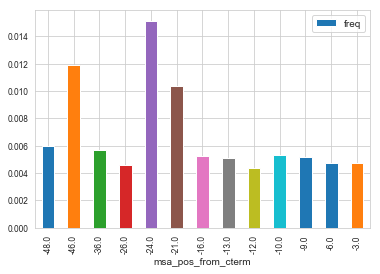

In [140]:
plotDf = countChangeGroupDf2.loc[idx['positively charged', 'hydrophobic']]
plotDf = plotDf[plotDf['count_total'] >= 100].loc[-50:]
plotDf.plot.bar(y='freq')

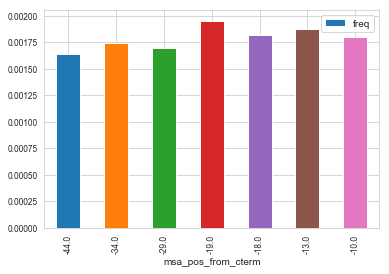

In [141]:
plotDf = countChangeGroupDf2.loc[idx['hydrophobic', 'positively charged']]
plotDf = plotDf[plotDf['count_total'] >= 100].loc[-50:]
plotDf.plot.bar(y='freq')

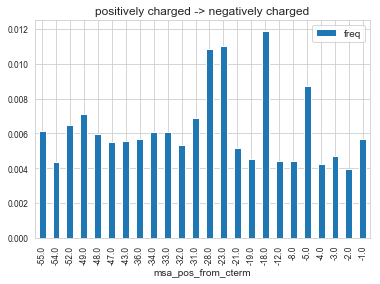

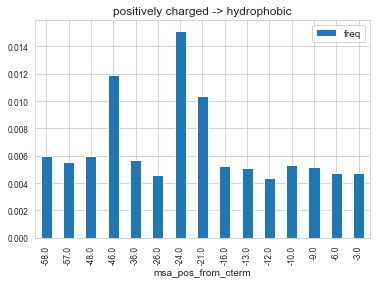

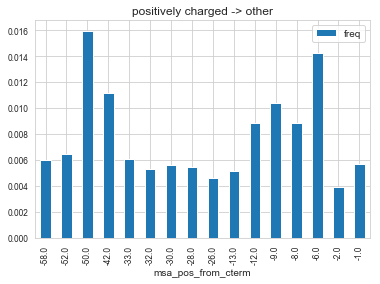

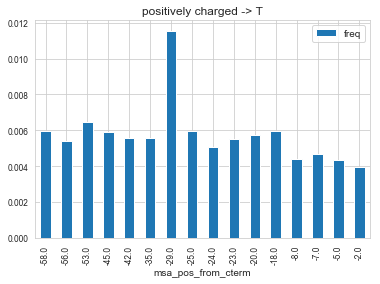

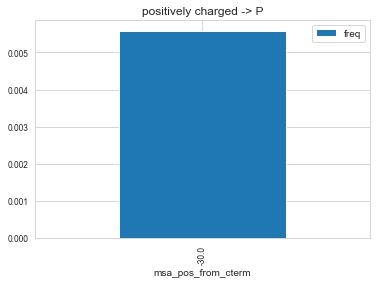

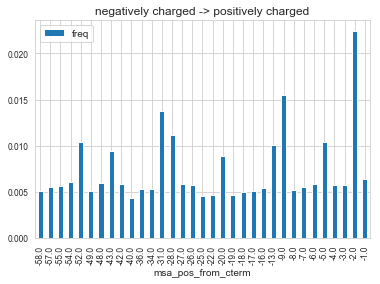

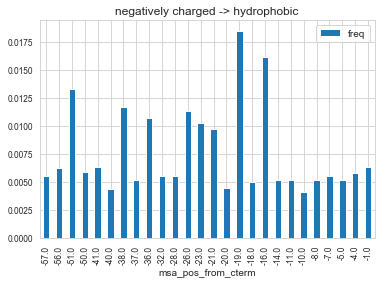

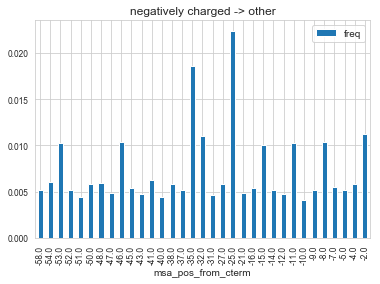

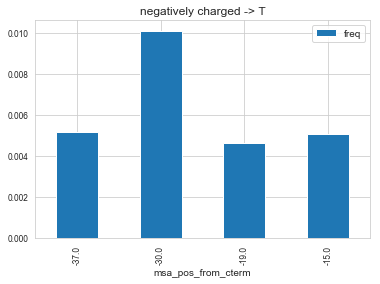

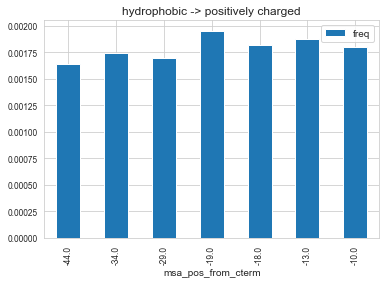

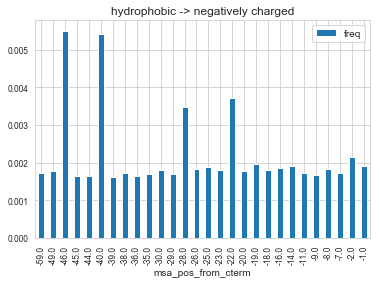

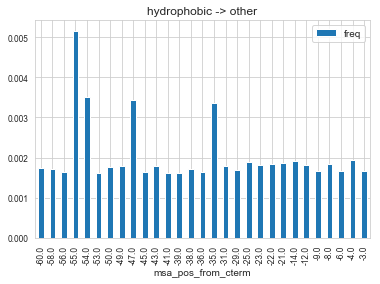

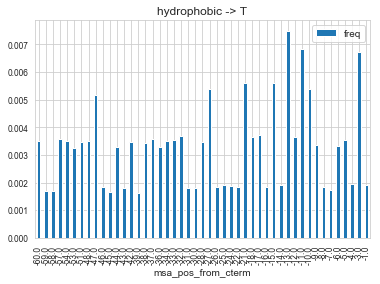

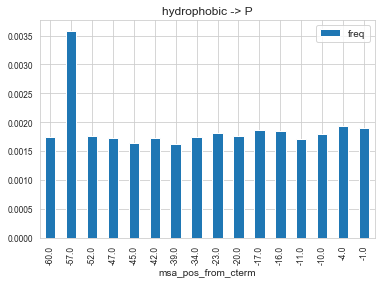

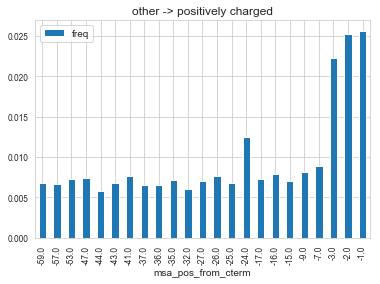

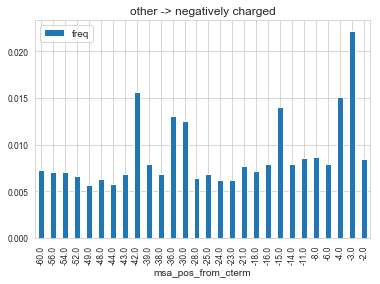

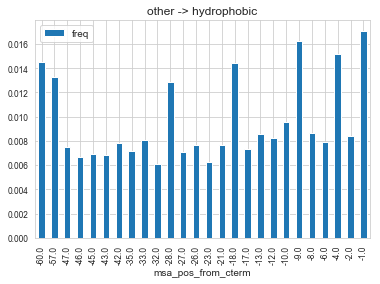

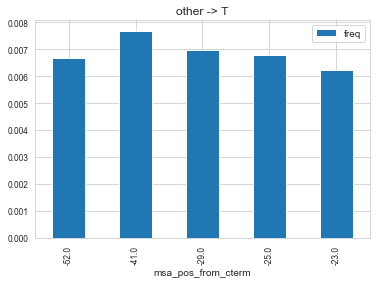

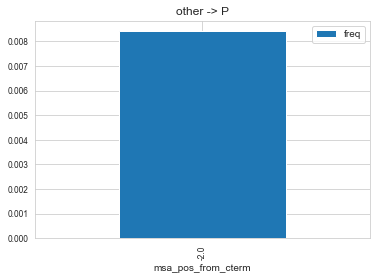

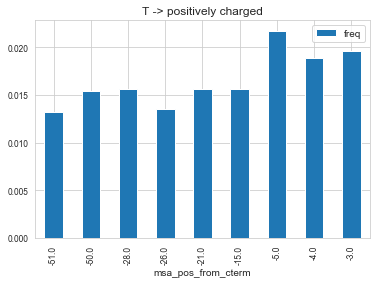

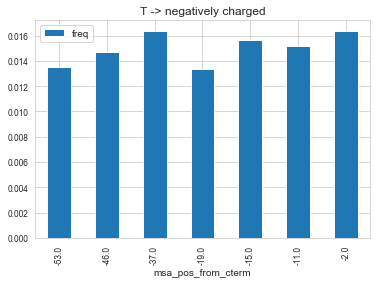

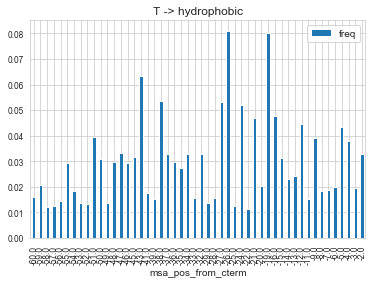

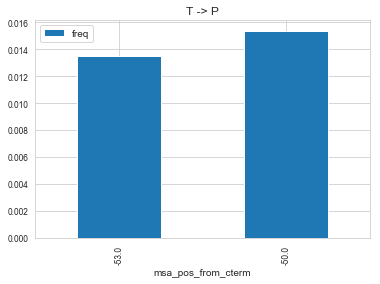

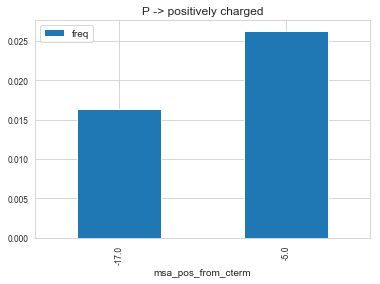

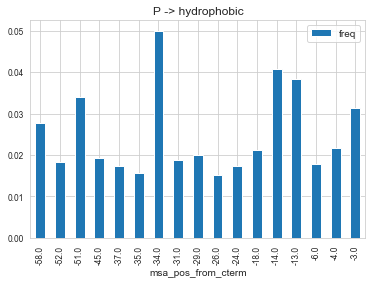

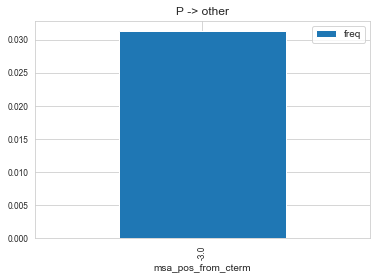

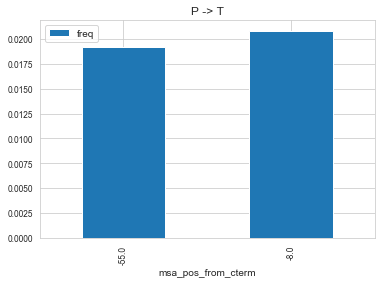

In [142]:
for transition in transitions[:]:
    plotDf = countChangeGroupDf2.loc[idx[transition[0], transition[1]]]
    plotDf = plotDf[plotDf['count_total'] >= 10].loc[-60:]
    if len(plotDf) > 0:
        plotDf.plot.bar(y='freq', color=sns.color_palette()[0])
        plt.gca().set_title(' -> '.join(transition))
        filename = 'abundance {} transition freq cterm region {} to {}'.format(abundance_bin, transition[0], transition[1])
        plt.savefig(evolPath / 'results' / (filename + '.svg'))
        plt.savefig(evolPath / 'results' / (filename + '.png'), dpi=300)